In [ ]:
from keras.datasets import imdb
import numpy as np
import keras
import pandas as pd
from keras import layers , Sequential
from keras.initializers import Constant
from keras.optimizers import Adam
from sklearn.neighbors import NearestNeighbors
import regex as re
from tensorflow.keras.callbacks import EarlyStopping as ES
from keras.utils import pad_sequences
from copy import deepcopy
from sklearn.metrics import accuracy_score
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

17464789/17464789 [==============================] - 1s 0us/step
25000 train sequences
25000 test sequences


In [ ]:
y_test.shape

(25000,)

In [ ]:
INDEX_FROM = 3
word_index = imdb.get_word_index()
word_index = {key:(value+INDEX_FROM) for key,value in word_index.items()}
word_index["<PAD>"] = 0    # the padding token
word_index["<START>"] = 1  # the starting token
word_index["<UNK>"] = 2    # the unknown token
reverse_word_index = {value:key for key, value in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(X_train[0])

1641221/1641221 [==============================] - 0s 0us/step


"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

In [ ]:
maximum_sequence_length=0
for i in X_train:
  if maximum_sequence_length < len(i):
    maximum_sequence_length=len(i)

print(maximum_sequence_length)


2494


In [ ]:
vocab_size = 15000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words= vocab_size)

X_train, X_val = X_train[:-5000], X_train[-5000:]
y_train, y_val = y_train[:-5000], y_train[-5000:]

print(len(X_train), 'train sequences')
print(len(X_val), 'val sequences')
print(len(X_test), 'test sequences')

20000 train sequences
5000 val sequences
25000 test sequences


In [ ]:

maximum_sequence_length = 200 # maximum length of all review sequences

X_train = pad_sequences(X_train, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)
X_val = pad_sequences(X_val, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)
X_test = pad_sequences(X_test, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)

print('X_train shape:', X_train.shape) # (n_samples, n_timesteps)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (20000, 200)
X_val shape: (5000, 200)
X_test shape: (25000, 200)


In [ ]:
X_train[0].shape

(200,)

In [ ]:
# model = Sequential()
# # model.add(layers.convolutional(50, 100,trainable=True , input_length=70))
# model.add(layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
# # model.add(layers.Dropout(0.2))
# model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# # model.add(layers.Dropout(0.2))
# model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Bidirectional(layers.LSTM(300)))
# # model.add(layers.Dropout(0.2))
# model.add(layers.Dense(1, activation='sigmoid'))
from keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Conv2D

model = Sequential()
    # Embedding layer
model.add(Embedding(vocab_size, 64, input_length= maximum_sequence_length, trainable=True))
model.add(Conv1D(filters = 64, kernel_size = 3, strides= 1, padding='same', activation= 'relu'))
model.add(Dropout(0.2))
model.add(Conv1D(filters = 32, kernel_size = 3, strides= 1, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Conv1D(filters = 32, kernel_size = 3, strides= 1, activation= 'relu'))
# model.add(GlobalMaxPooling1D())
model.add(layers.Bidirectional(layers.LSTM(150)))
# model.add(GlobalMaxPooling1D())

# model.add(Dropout(0.2))

# model.add(Dense(units = 256, activation= 'relu', kernel_initializer= 'glorot_uniform'))
model.add(Dropout(0.2))
# Output layer
model.add(Dense(1, activation= 'sigmoid'))

# Compile the model
# model.build(input_shape=(None,1000,1))
model.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           960000    
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           12352     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 32)           6176      
                                                                 
 dropout_1 (Dropout)         (None, 198, 32)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 32)           3104      
                                                                 
 bidirectional (Bidirectiona  (None, 300)              2

In [ ]:
early_stopping = ES(monitor='val_loss',patience=15)
history = model.fit(
    X_train,
    y_train,
    batch_size=40,
    epochs=30,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping]

)


Epoch 1/30
500/500 [==============================] - 92s 126ms/step - loss: 0.6468 - accuracy: 0.5980 - val_loss: 0.3962 - val_accuracy: 0.8390
Epoch 2/30
500/500 [==============================] - 23s 47ms/step - loss: 0.3070 - accuracy: 0.8738 - val_loss: 0.3949 - val_accuracy: 0.8176
Epoch 3/30
500/500 [==============================] - 18s 35ms/step - loss: 0.1906 - accuracy: 0.9265 - val_loss: 0.3010 - val_accuracy: 0.8850
Epoch 4/30
500/500 [==============================] - 15s 29ms/step - loss: 0.1279 - accuracy: 0.9561 - val_loss: 0.3577 - val_accuracy: 0.8758
Epoch 5/30
500/500 [==============================] - 14s 27ms/step - loss: 0.0881 - accuracy: 0.9707 - val_loss: 0.4104 - val_accuracy: 0.8770
Epoch 6/30
500/500 [==============================] - 14s 27ms/step - loss: 0.0629 - accuracy: 0.9808 - val_loss: 0.4347 - val_accuracy: 0.8708
Epoch 7/30
500/500 [==============================] - 13s 25ms/step - loss: 0.0442 - accuracy: 0.9883 - val_loss: 0.5154 - val_accuracy

In [ ]:
print(history.history['val_loss'])

[0.39620348811149597, 0.3948551416397095, 0.30099570751190186, 0.35766860842704773, 0.4104456901550293, 0.4346964955329895, 0.5154128670692444, 0.5317578315734863, 0.5179809331893921, 0.5541664361953735, 0.6408898234367371, 0.6647437810897827, 0.7451996803283691, 0.75173020362854, 0.8036640882492065, 0.7673550844192505, 0.7452657222747803, 0.7952684164047241]


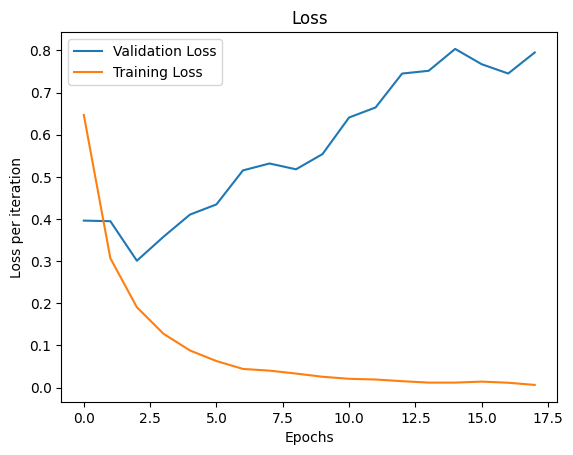

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per iteration")
plt.legend(["Validation Loss", "Training Loss"])

In [ ]:
# model.save_weights('/content/mydrive/MyDrive/NLP/Project/model.h5')
model.load_weights('/content/mydrive/MyDrive/NLP/Project/model.h5')

In [ ]:
preds  = model.predict(X_test)
preds = np.where(preds < 0.5, 0, 1)
print('Test accuracy: ',str(accuracy_score(y_test,preds)*100)+'%')

782/782 [==============================] - 7s 8ms/step
Test accuracy:  85.012%


In [ ]:
embedding_neighbors={}
training_vocab = word_index.keys()
def setupEmbeddingNeighbors(filename,k):
  # if True:
  embedding_vecs = {}
  with open(filename) as f:
    for each_line in f:
      word_n_vec = each_line.split(' ')
      # only read words in vocab, ignore the rest
      if word_n_vec[0] in training_vocab:
        embedding_vecs[word_n_vec[0]] = [float(value) for value in word_n_vec[1:]]

  # now we run knn and store neighbors of all the words
  all_words = list(embedding_vecs.keys())
  all_vectors = np.array([ list(each) for each in embedding_vecs.values()])
  knn_model = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(all_vectors)
  _, indices = knn_model.kneighbors(all_vectors)
  # store neighbors for all words
  for i in range(len(indices)):
    embedding_neighbors[all_words[i]] = [all_words[j] for j in indices[i]]
  return

def calculate_neighbors(word):
  if word in embedding_neighbors:
    return embedding_neighbors[word]
  return []
#'mydrive/My Drive/BERT-Attack-master (copy)/glove.6B.100d',9)

In [ ]:
setupEmbeddingNeighbors('/content/mydrive/MyDrive/NLP/Project/glove.6B.100d.txt',7)

In [ ]:
w2i = word_index
i2w = {word_index[k]:k for k in word_index}

In [ ]:
def get_loo_score(x):
  input_matrix = np.array([deepcopy(x) for _ in range(maximum_sequence_length)])
  for i in range(1,maximum_sequence_length):
    # ignore start, pad and unk tokens
    if x[i] in [1,2,3]:
      continue
    # put unk token
    input_matrix[i][i] = 2
  out_probs = model(input_matrix)
  loo_scores = [[1-s[0].numpy(),s[0].numpy()] for s in out_probs]
  return loo_scores


def attack_sentence(sen,label,loo_scores,word_budget):
  '''
  creates adversarial examples using x, and lowers the
  of label
  sen: input example
  label: actual label
  loo_scores: importance score, obtained by masking token with UNK
  word_budget: max number of words perturbed
  returns a list of length word_budget, each successive row has one more
  word replaced in the previous row
  '''
  x = deepcopy(sen)
  y = label
  orig_score = model(np.array([x]))
  adv_examples = []
  # xlist = list(x)
  print(orig_score)
  if y==1:
    # increasing order means we start with min loo prob
    incr_order_ind = np.argsort([s[1] for s in loo_scores])
    perturbation = 0
    # print(incr_order_ind[:10])
    while perturbation<word_budget:
      for ind in incr_order_ind:
        # print(ind)
        # print(x[ind])
        # print(i2w[x[ind]])
        # break if previous indexes have already finished the job
        if perturbation==word_budget:
          break
        neighbors = calculate_neighbors(i2w[x[ind]])#embedding_neighbors[i2w[x[ind]]]
        # do nothing if corner case or special word
        if len(neighbors)==0:
          continue
        replaced = np.array([deepcopy(x) for _ in range(len(neighbors))])
        for i in range(len(neighbors)):
          # replace word with its neighbor
          replaced[i][ind] = w2i[neighbors[i]]
        # print(replaced.shape)
        neighbor_scores = model(replaced)
        # pick the neighbor giving least prob
        min_neighbor = np.argmin(neighbor_scores)
        # if it reduces prob, keep it
        if neighbor_scores[min_neighbor] < orig_score:
          # permanently replace word
          x[ind] = w2i[neighbors[min_neighbor]]
          # inrease perturbation count
          perturbation +=1
          # store it to avoid recomputation
          adv_examples.append(deepcopy(x))
          # break if previous indexes have already finished the job
          if perturbation==word_budget:
            break
  else:
    # increasing order means we start with min loo prob
    incr_order_ind = np.argsort([s[0] for s in loo_scores])
    perturbation = 0
    for ind in incr_order_ind:
        # while perturbation<word_budget:
        neighbors = calculate_neighbors(i2w[x[ind]]) #embedding_neighbors[i2w[x[ind]]]
        # do nothing if corner case or special word
        if len(neighbors)==0:
          continue
        # break if previous indexes have already finished the job
        if perturbation==word_budget:
          break
        replaced = np.array([deepcopy(x) for _ in range(len(neighbors))])
        for i in range(len(neighbors)):
          # replace word with its neighbor
          replaced[i][ind] = w2i[neighbors[i]]
        neighbor_scores = [1-x for x in model(replaced)]
        # pick the neighbor giving least prob
        min_neighbor = np.argmin(neighbor_scores)
        # if it reduces prob, keep it
        if neighbor_scores[min_neighbor] < 1-orig_score:
          # permanently replace word
          x[ind] = w2i[neighbors[min_neighbor]]
          # inrease perturbation count
          perturbation +=1
          # store it to avoid recomputation
          adv_examples.append(deepcopy(x))
          if perturbation==word_budget:
            break
  return adv_examples

In [ ]:
def batch_attack(sentences,labels,loo_scores,word_budget):
  adv_examples=[attack_sentence(sentences[i],labels[i],loo_scores[i],word_budget) for i in tqdm(range(len(sentences)))]
  return adv_examples #np.array(adv_examples)

In [ ]:
# assign sentences in integers to the two variables
sample_sentences = X_test[10:5010]
sample_labels = y_test[10:5010]
sample_sentences[0][:10]

array([   7,  107,  349,    2, 1496,   11, 5116,   18,  397, 3767],
      dtype=int32)

In [ ]:
# computes loo_scores, saves computational time
all_loo_scores = [get_loo_score(x) for x in tqdm(sample_sentences)]

100%|██████████| 5000/5000 [25:03<00:00,  3.33it/s]


In [ ]:
all_adv_exs = batch_attack(sample_sentences,sample_labels,all_loo_scores,5)
# you will get a list of length 5 (word budget) for each sentence


  0%|          | 1/5000 [00:00<15:02,  5.54it/s]

tf.Tensor([[0.99978536]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.9608778e-05]], shape=(1, 1), dtype=float32)



  0%|          | 3/5000 [00:00<17:00,  4.90it/s]

tf.Tensor([[9.4016796e-05]], shape=(1, 1), dtype=float32)



  0%|          | 4/5000 [00:00<17:01,  4.89it/s]

tf.Tensor([[0.00010943]], shape=(1, 1), dtype=float32)



  0%|          | 5/5000 [00:00<16:22,  5.08it/s]

tf.Tensor([[0.99958247]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1524785e-05]], shape=(1, 1), dtype=float32)



  0%|          | 7/5000 [00:01<16:55,  4.91it/s]

tf.Tensor([[0.9994025]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00565445]], shape=(1, 1), dtype=float32)



  0%|          | 9/5000 [00:01<17:04,  4.87it/s]

tf.Tensor([[0.00014845]], shape=(1, 1), dtype=float32)



  0%|          | 10/5000 [00:02<17:25,  4.77it/s]

tf.Tensor([[0.00277959]], shape=(1, 1), dtype=float32)



  0%|          | 11/5000 [00:02<16:58,  4.90it/s]

tf.Tensor([[0.9999747]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99909914]], shape=(1, 1), dtype=float32)



  0%|          | 13/5000 [00:02<14:43,  5.65it/s]

tf.Tensor([[0.02683782]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9944043]], shape=(1, 1), dtype=float32)



  0%|          | 15/5000 [00:02<13:23,  6.21it/s]

tf.Tensor([[0.9061811]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99998367]], shape=(1, 1), dtype=float32)



  0%|          | 17/5000 [00:03<12:53,  6.44it/s]

tf.Tensor([[5.7610927e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99937636]], shape=(1, 1), dtype=float32)



  0%|          | 19/5000 [00:03<12:22,  6.70it/s]

tf.Tensor([[0.99887174]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.86748e-05]], shape=(1, 1), dtype=float32)



  0%|          | 21/5000 [00:03<12:31,  6.63it/s]

tf.Tensor([[0.98558587]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99559265]], shape=(1, 1), dtype=float32)



  0%|          | 23/5000 [00:04<12:19,  6.73it/s]

tf.Tensor([[0.9942925]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.908478e-05]], shape=(1, 1), dtype=float32)



  0%|          | 25/5000 [00:04<12:42,  6.52it/s]

tf.Tensor([[9.559551e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.3696566e-05]], shape=(1, 1), dtype=float32)



  1%|          | 27/5000 [00:04<13:01,  6.36it/s]

tf.Tensor([[0.9918248]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994185]], shape=(1, 1), dtype=float32)



  1%|          | 29/5000 [00:04<12:43,  6.51it/s]

tf.Tensor([[0.00045705]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.6591794e-05]], shape=(1, 1), dtype=float32)



  1%|          | 31/5000 [00:05<12:53,  6.42it/s]

tf.Tensor([[0.99998903]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9976324]], shape=(1, 1), dtype=float32)



  1%|          | 33/5000 [00:05<12:40,  6.53it/s]

tf.Tensor([[3.0264058e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9975574]], shape=(1, 1), dtype=float32)



  1%|          | 35/5000 [00:05<12:21,  6.69it/s]

tf.Tensor([[0.99991524]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.21769543]], shape=(1, 1), dtype=float32)



  1%|          | 37/5000 [00:06<12:31,  6.61it/s]

tf.Tensor([[0.00024133]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.791782e-05]], shape=(1, 1), dtype=float32)



  1%|          | 39/5000 [00:06<12:50,  6.44it/s]

tf.Tensor([[0.00020804]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00418986]], shape=(1, 1), dtype=float32)



  1%|          | 41/5000 [00:06<13:18,  6.21it/s]

tf.Tensor([[0.0001844]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01434109]], shape=(1, 1), dtype=float32)



  1%|          | 43/5000 [00:07<12:47,  6.46it/s]

tf.Tensor([[0.9986564]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98072433]], shape=(1, 1), dtype=float32)



  1%|          | 45/5000 [00:07<12:10,  6.78it/s]

tf.Tensor([[0.968509]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.3489595e-05]], shape=(1, 1), dtype=float32)



  1%|          | 47/5000 [00:07<12:08,  6.80it/s]

tf.Tensor([[0.00502292]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99953353]], shape=(1, 1), dtype=float32)



  1%|          | 49/5000 [00:08<12:35,  6.56it/s]

tf.Tensor([[9.785425e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.04331692]], shape=(1, 1), dtype=float32)



  1%|          | 51/5000 [00:08<12:46,  6.45it/s]

tf.Tensor([[0.01106301]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.287444e-05]], shape=(1, 1), dtype=float32)



  1%|          | 53/5000 [00:08<12:36,  6.54it/s]

tf.Tensor([[0.9992156]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.397195e-05]], shape=(1, 1), dtype=float32)



  1%|          | 55/5000 [00:08<12:46,  6.46it/s]

tf.Tensor([[8.991499e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99961275]], shape=(1, 1), dtype=float32)



  1%|          | 57/5000 [00:09<12:22,  6.65it/s]

tf.Tensor([[0.9970137]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99968207]], shape=(1, 1), dtype=float32)



  1%|          | 59/5000 [00:09<11:54,  6.92it/s]

tf.Tensor([[0.99982375]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.94141835]], shape=(1, 1), dtype=float32)



  1%|          | 61/5000 [00:09<11:52,  6.93it/s]

tf.Tensor([[0.99953175]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.97490376]], shape=(1, 1), dtype=float32)



  1%|▏         | 63/5000 [00:10<11:42,  7.03it/s]

tf.Tensor([[0.9992895]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.345112e-05]], shape=(1, 1), dtype=float32)



  1%|▏         | 65/5000 [00:10<12:08,  6.77it/s]

tf.Tensor([[0.00012691]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99993217]], shape=(1, 1), dtype=float32)



  1%|▏         | 67/5000 [00:10<12:28,  6.59it/s]

tf.Tensor([[4.705261e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9990671]], shape=(1, 1), dtype=float32)



  1%|▏         | 69/5000 [00:11<12:26,  6.61it/s]

tf.Tensor([[0.00151286]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00015553]], shape=(1, 1), dtype=float32)



  1%|▏         | 71/5000 [00:11<12:27,  6.59it/s]

tf.Tensor([[0.929107]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00042446]], shape=(1, 1), dtype=float32)



  1%|▏         | 73/5000 [00:11<12:10,  6.74it/s]

tf.Tensor([[0.995436]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8848863]], shape=(1, 1), dtype=float32)



  2%|▏         | 75/5000 [00:11<12:21,  6.64it/s]

tf.Tensor([[0.00039246]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001061]], shape=(1, 1), dtype=float32)



  2%|▏         | 77/5000 [00:12<12:56,  6.34it/s]

tf.Tensor([[0.00024338]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99995637]], shape=(1, 1), dtype=float32)



  2%|▏         | 79/5000 [00:12<14:46,  5.55it/s]

tf.Tensor([[7.7199606e-05]], shape=(1, 1), dtype=float32)



  2%|▏         | 80/5000 [00:12<15:00,  5.46it/s]

tf.Tensor([[0.98393494]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.998863]], shape=(1, 1), dtype=float32)



  2%|▏         | 82/5000 [00:13<15:21,  5.33it/s]

tf.Tensor([[0.9881021]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00090669]], shape=(1, 1), dtype=float32)



  2%|▏         | 84/5000 [00:13<15:30,  5.28it/s]

tf.Tensor([[0.9980299]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99986696]], shape=(1, 1), dtype=float32)



  2%|▏         | 86/5000 [00:14<15:44,  5.20it/s]

tf.Tensor([[1.7612296e-05]], shape=(1, 1), dtype=float32)



  2%|▏         | 87/5000 [00:14<15:33,  5.26it/s]

tf.Tensor([[0.873365]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99176764]], shape=(1, 1), dtype=float32)



  2%|▏         | 89/5000 [00:14<15:37,  5.24it/s]

tf.Tensor([[0.00024585]], shape=(1, 1), dtype=float32)



  2%|▏         | 90/5000 [00:14<16:02,  5.10it/s]

tf.Tensor([[9.705551e-05]], shape=(1, 1), dtype=float32)



  2%|▏         | 91/5000 [00:14<15:56,  5.13it/s]

tf.Tensor([[0.00021809]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00085516]], shape=(1, 1), dtype=float32)



  2%|▏         | 93/5000 [00:15<15:35,  5.25it/s]

tf.Tensor([[0.81864357]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.4108004e-05]], shape=(1, 1), dtype=float32)



  2%|▏         | 95/5000 [00:15<16:26,  4.97it/s]

tf.Tensor([[7.1689705e-05]], shape=(1, 1), dtype=float32)



  2%|▏         | 96/5000 [00:15<17:08,  4.77it/s]

tf.Tensor([[4.267468e-05]], shape=(1, 1), dtype=float32)



  2%|▏         | 97/5000 [00:16<17:20,  4.71it/s]

tf.Tensor([[0.00868229]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024293]], shape=(1, 1), dtype=float32)



  2%|▏         | 99/5000 [00:16<14:39,  5.57it/s]

tf.Tensor([[0.9969676]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9983485]], shape=(1, 1), dtype=float32)



  2%|▏         | 101/5000 [00:16<13:10,  6.20it/s]

tf.Tensor([[0.99997246]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.037879e-05]], shape=(1, 1), dtype=float32)



  2%|▏         | 103/5000 [00:17<13:35,  6.00it/s]

tf.Tensor([[0.47582456]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00282435]], shape=(1, 1), dtype=float32)



  2%|▏         | 105/5000 [00:17<13:03,  6.25it/s]

tf.Tensor([[0.0031339]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.1908152]], shape=(1, 1), dtype=float32)



  2%|▏         | 107/5000 [00:17<12:34,  6.49it/s]

tf.Tensor([[0.99926955]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.954414e-05]], shape=(1, 1), dtype=float32)



  2%|▏         | 109/5000 [00:18<12:19,  6.61it/s]

tf.Tensor([[0.96995544]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99808633]], shape=(1, 1), dtype=float32)



  2%|▏         | 111/5000 [00:18<12:25,  6.56it/s]

tf.Tensor([[0.0068429]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00402238]], shape=(1, 1), dtype=float32)



  2%|▏         | 113/5000 [00:18<12:34,  6.48it/s]

tf.Tensor([[0.00123526]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.993952]], shape=(1, 1), dtype=float32)



  2%|▏         | 115/5000 [00:18<11:50,  6.87it/s]

tf.Tensor([[0.99881697]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01733276]], shape=(1, 1), dtype=float32)



  2%|▏         | 117/5000 [00:19<12:16,  6.63it/s]

tf.Tensor([[0.99727976]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01804334]], shape=(1, 1), dtype=float32)



  2%|▏         | 119/5000 [00:19<12:31,  6.49it/s]

tf.Tensor([[0.00018458]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.4057436e-05]], shape=(1, 1), dtype=float32)



  2%|▏         | 121/5000 [00:19<12:24,  6.55it/s]

tf.Tensor([[0.99993455]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0003977]], shape=(1, 1), dtype=float32)



  2%|▏         | 123/5000 [00:20<12:32,  6.48it/s]

tf.Tensor([[9.362725e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994261]], shape=(1, 1), dtype=float32)



  2%|▎         | 125/5000 [00:20<12:12,  6.66it/s]

tf.Tensor([[0.2710291]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00206519]], shape=(1, 1), dtype=float32)



  3%|▎         | 127/5000 [00:20<12:17,  6.60it/s]

tf.Tensor([[0.02190143]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00245413]], shape=(1, 1), dtype=float32)



  3%|▎         | 129/5000 [00:21<12:25,  6.54it/s]

tf.Tensor([[9.699316e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010303]], shape=(1, 1), dtype=float32)



  3%|▎         | 131/5000 [00:21<12:31,  6.48it/s]

tf.Tensor([[0.9999857]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.794789e-05]], shape=(1, 1), dtype=float32)



  3%|▎         | 133/5000 [00:21<12:18,  6.59it/s]

tf.Tensor([[0.9991798]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.250049e-05]], shape=(1, 1), dtype=float32)



  3%|▎         | 135/5000 [00:22<12:25,  6.52it/s]

tf.Tensor([[3.9950304e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98425335]], shape=(1, 1), dtype=float32)



  3%|▎         | 137/5000 [00:22<12:20,  6.56it/s]

tf.Tensor([[0.32627216]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9839715]], shape=(1, 1), dtype=float32)



  3%|▎         | 139/5000 [00:22<12:17,  6.59it/s]

tf.Tensor([[0.99942005]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021994]], shape=(1, 1), dtype=float32)



  3%|▎         | 141/5000 [00:22<12:26,  6.51it/s]

tf.Tensor([[0.00043546]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002134]], shape=(1, 1), dtype=float32)



  3%|▎         | 143/5000 [00:23<12:58,  6.24it/s]

tf.Tensor([[0.10341606]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997273]], shape=(1, 1), dtype=float32)



  3%|▎         | 145/5000 [00:23<12:32,  6.45it/s]

tf.Tensor([[0.00826887]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999124]], shape=(1, 1), dtype=float32)



  3%|▎         | 147/5000 [00:23<12:28,  6.49it/s]

tf.Tensor([[0.00080032]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99818856]], shape=(1, 1), dtype=float32)



  3%|▎         | 149/5000 [00:24<12:20,  6.55it/s]

tf.Tensor([[0.00019337]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9507484]], shape=(1, 1), dtype=float32)



  3%|▎         | 151/5000 [00:24<12:35,  6.42it/s]

tf.Tensor([[7.586488e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013394]], shape=(1, 1), dtype=float32)



  3%|▎         | 153/5000 [00:24<12:36,  6.41it/s]

tf.Tensor([[1.8099621e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.006365e-05]], shape=(1, 1), dtype=float32)



  3%|▎         | 155/5000 [00:25<12:20,  6.54it/s]

tf.Tensor([[0.9995814]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.0313687e-05]], shape=(1, 1), dtype=float32)



  3%|▎         | 157/5000 [00:25<12:24,  6.50it/s]

tf.Tensor([[0.99872416]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9971444]], shape=(1, 1), dtype=float32)



  3%|▎         | 159/5000 [00:25<12:09,  6.63it/s]

tf.Tensor([[0.00021172]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012338]], shape=(1, 1), dtype=float32)



  3%|▎         | 161/5000 [00:26<12:35,  6.41it/s]

tf.Tensor([[0.00033599]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994074]], shape=(1, 1), dtype=float32)



  3%|▎         | 163/5000 [00:26<14:13,  5.67it/s]

tf.Tensor([[0.00124269]], shape=(1, 1), dtype=float32)



  3%|▎         | 164/5000 [00:26<14:19,  5.63it/s]

tf.Tensor([[0.99959487]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00983106]], shape=(1, 1), dtype=float32)



  3%|▎         | 166/5000 [00:26<14:50,  5.43it/s]

tf.Tensor([[0.00013405]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01098416]], shape=(1, 1), dtype=float32)


  3%|▎         | 167/5000 [00:27<15:05,  5.34it/s]


tf.Tensor([[0.00050602]], shape=(1, 1), dtype=float32)



  3%|▎         | 169/5000 [00:27<16:19,  4.93it/s]

tf.Tensor([[0.00067736]], shape=(1, 1), dtype=float32)



  3%|▎         | 170/5000 [00:27<16:33,  4.86it/s]

tf.Tensor([[6.879914e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.7770177e-05]], shape=(1, 1), dtype=float32)


  3%|▎         | 171/5000 [00:28<16:16,  4.95it/s]


  3%|▎         | 172/5000 [00:28<16:17,  4.94it/s]

tf.Tensor([[0.0064637]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.89476025]], shape=(1, 1), dtype=float32)



  3%|▎         | 174/5000 [00:28<16:38,  4.83it/s]

tf.Tensor([[0.00575009]], shape=(1, 1), dtype=float32)



  4%|▎         | 175/5000 [00:28<16:17,  4.93it/s]

tf.Tensor([[0.99952054]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013587]], shape=(1, 1), dtype=float32)



  4%|▎         | 177/5000 [00:29<17:08,  4.69it/s]

tf.Tensor([[0.00017352]], shape=(1, 1), dtype=float32)



  4%|▎         | 178/5000 [00:29<17:03,  4.71it/s]

tf.Tensor([[0.9945977]], shape=(1, 1), dtype=float32)



  4%|▎         | 179/5000 [00:29<16:44,  4.80it/s]

tf.Tensor([[0.99943227]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.362918e-05]], shape=(1, 1), dtype=float32)



  4%|▎         | 181/5000 [00:30<15:37,  5.14it/s]

tf.Tensor([[0.9369041]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00584812]], shape=(1, 1), dtype=float32)



  4%|▎         | 183/5000 [00:30<13:57,  5.75it/s]

tf.Tensor([[0.00011166]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00030546]], shape=(1, 1), dtype=float32)



  4%|▎         | 185/5000 [00:30<13:44,  5.84it/s]

tf.Tensor([[0.00080141]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99943095]], shape=(1, 1), dtype=float32)



  4%|▎         | 187/5000 [00:30<12:36,  6.37it/s]

tf.Tensor([[0.99836797]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013361]], shape=(1, 1), dtype=float32)



  4%|▍         | 189/5000 [00:31<12:48,  6.26it/s]

tf.Tensor([[0.0001678]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00026276]], shape=(1, 1), dtype=float32)



  4%|▍         | 191/5000 [00:31<12:30,  6.40it/s]

tf.Tensor([[0.9980446]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.04416376]], shape=(1, 1), dtype=float32)



  4%|▍         | 193/5000 [00:31<12:33,  6.38it/s]

tf.Tensor([[0.04162945]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.08851747]], shape=(1, 1), dtype=float32)



  4%|▍         | 195/5000 [00:32<12:06,  6.61it/s]

tf.Tensor([[0.00010592]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.84468234]], shape=(1, 1), dtype=float32)



  4%|▍         | 197/5000 [00:32<11:54,  6.72it/s]

tf.Tensor([[0.00633777]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.1714284e-05]], shape=(1, 1), dtype=float32)



  4%|▍         | 199/5000 [00:32<12:03,  6.64it/s]

tf.Tensor([[0.00011747]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99936074]], shape=(1, 1), dtype=float32)



  4%|▍         | 201/5000 [00:33<11:38,  6.87it/s]

tf.Tensor([[0.99928576]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997832]], shape=(1, 1), dtype=float32)



  4%|▍         | 203/5000 [00:33<11:38,  6.87it/s]

tf.Tensor([[0.99576855]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00023541]], shape=(1, 1), dtype=float32)



  4%|▍         | 205/5000 [00:33<12:15,  6.52it/s]

tf.Tensor([[0.00063017]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00033486]], shape=(1, 1), dtype=float32)



  4%|▍         | 207/5000 [00:34<12:23,  6.44it/s]

tf.Tensor([[0.00023487]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.6045642e-05]], shape=(1, 1), dtype=float32)



  4%|▍         | 209/5000 [00:34<12:18,  6.48it/s]

tf.Tensor([[0.9997212]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00034198]], shape=(1, 1), dtype=float32)



  4%|▍         | 211/5000 [00:34<13:05,  6.10it/s]

tf.Tensor([[3.989822e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995546]], shape=(1, 1), dtype=float32)



  4%|▍         | 213/5000 [00:34<12:40,  6.29it/s]

tf.Tensor([[0.00210921]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.12280593]], shape=(1, 1), dtype=float32)



  4%|▍         | 215/5000 [00:35<12:03,  6.61it/s]

tf.Tensor([[0.99959403]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994764]], shape=(1, 1), dtype=float32)



  4%|▍         | 217/5000 [00:35<12:04,  6.60it/s]

tf.Tensor([[0.9996331]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9473038]], shape=(1, 1), dtype=float32)



  4%|▍         | 219/5000 [00:35<12:05,  6.59it/s]

tf.Tensor([[0.00037205]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99947923]], shape=(1, 1), dtype=float32)



  4%|▍         | 221/5000 [00:36<12:32,  6.35it/s]

tf.Tensor([[6.0654063e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.93780893]], shape=(1, 1), dtype=float32)



  4%|▍         | 223/5000 [00:36<12:14,  6.50it/s]

tf.Tensor([[0.99861395]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99944]], shape=(1, 1), dtype=float32)



  4%|▍         | 225/5000 [00:36<12:07,  6.57it/s]

tf.Tensor([[0.00010096]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.3990248]], shape=(1, 1), dtype=float32)



  5%|▍         | 227/5000 [00:37<11:54,  6.68it/s]

tf.Tensor([[0.00012687]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994431]], shape=(1, 1), dtype=float32)



  5%|▍         | 229/5000 [00:37<12:07,  6.56it/s]

tf.Tensor([[0.00728079]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.2326011]], shape=(1, 1), dtype=float32)



  5%|▍         | 231/5000 [00:37<12:15,  6.48it/s]

tf.Tensor([[0.9991093]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.9968424e-05]], shape=(1, 1), dtype=float32)



  5%|▍         | 233/5000 [00:38<12:02,  6.60it/s]

tf.Tensor([[0.9957716]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00025091]], shape=(1, 1), dtype=float32)



  5%|▍         | 235/5000 [00:38<12:07,  6.55it/s]

tf.Tensor([[0.99542844]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993926]], shape=(1, 1), dtype=float32)



  5%|▍         | 237/5000 [00:38<12:22,  6.42it/s]

tf.Tensor([[0.00016034]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9566133]], shape=(1, 1), dtype=float32)



  5%|▍         | 239/5000 [00:38<12:03,  6.58it/s]

tf.Tensor([[0.987241]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99919134]], shape=(1, 1), dtype=float32)



  5%|▍         | 241/5000 [00:39<11:58,  6.63it/s]

tf.Tensor([[0.63640875]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9114904]], shape=(1, 1), dtype=float32)



  5%|▍         | 243/5000 [00:39<12:09,  6.52it/s]

tf.Tensor([[0.00041944]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99997056]], shape=(1, 1), dtype=float32)



  5%|▍         | 245/5000 [00:39<12:30,  6.33it/s]

tf.Tensor([[1.7181146e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013194]], shape=(1, 1), dtype=float32)



  5%|▍         | 247/5000 [00:40<15:13,  5.20it/s]

tf.Tensor([[0.9990693]], shape=(1, 1), dtype=float32)



  5%|▍         | 248/5000 [00:40<15:22,  5.15it/s]

tf.Tensor([[0.9999554]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5786003]], shape=(1, 1), dtype=float32)



  5%|▌         | 250/5000 [00:40<15:26,  5.13it/s]

tf.Tensor([[0.01917048]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010857]], shape=(1, 1), dtype=float32)



  5%|▌         | 252/5000 [00:41<16:38,  4.75it/s]

tf.Tensor([[0.01572423]], shape=(1, 1), dtype=float32)



  5%|▌         | 253/5000 [00:41<17:01,  4.65it/s]

tf.Tensor([[0.00030154]], shape=(1, 1), dtype=float32)



  5%|▌         | 254/5000 [00:41<17:08,  4.61it/s]

tf.Tensor([[0.3082872]], shape=(1, 1), dtype=float32)



  5%|▌         | 255/5000 [00:42<16:28,  4.80it/s]

tf.Tensor([[0.9773278]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996486]], shape=(1, 1), dtype=float32)



  5%|▌         | 257/5000 [00:42<16:08,  4.90it/s]

tf.Tensor([[0.99795234]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017762]], shape=(1, 1), dtype=float32)



  5%|▌         | 259/5000 [00:42<17:18,  4.57it/s]

tf.Tensor([[3.274374e-05]], shape=(1, 1), dtype=float32)



  5%|▌         | 260/5000 [00:43<16:31,  4.78it/s]

tf.Tensor([[0.999729]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00355952]], shape=(1, 1), dtype=float32)



  5%|▌         | 262/5000 [00:43<16:18,  4.84it/s]

tf.Tensor([[0.9999007]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.000396]], shape=(1, 1), dtype=float32)



  5%|▌         | 264/5000 [00:43<16:17,  4.85it/s]

tf.Tensor([[0.99985397]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96752644]], shape=(1, 1), dtype=float32)



  5%|▌         | 266/5000 [00:44<14:21,  5.50it/s]

tf.Tensor([[3.4482953e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.3692477e-05]], shape=(1, 1), dtype=float32)



  5%|▌         | 268/5000 [00:44<13:18,  5.93it/s]

tf.Tensor([[0.00018516]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999608]], shape=(1, 1), dtype=float32)



  5%|▌         | 270/5000 [00:44<12:43,  6.20it/s]

tf.Tensor([[0.00014595]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9734697]], shape=(1, 1), dtype=float32)



  5%|▌         | 272/5000 [00:45<12:30,  6.30it/s]

tf.Tensor([[0.00023952]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.08620328]], shape=(1, 1), dtype=float32)



  5%|▌         | 274/5000 [00:45<12:07,  6.49it/s]

tf.Tensor([[0.25571513]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.7069404e-05]], shape=(1, 1), dtype=float32)



  6%|▌         | 276/5000 [00:45<11:49,  6.65it/s]

tf.Tensor([[0.9995983]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027639]], shape=(1, 1), dtype=float32)



  6%|▌         | 278/5000 [00:46<11:46,  6.68it/s]

tf.Tensor([[0.93475693]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99994504]], shape=(1, 1), dtype=float32)



  6%|▌         | 280/5000 [00:46<11:29,  6.84it/s]

tf.Tensor([[0.99164915]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993098]], shape=(1, 1), dtype=float32)



  6%|▌         | 282/5000 [00:46<11:43,  6.70it/s]

tf.Tensor([[0.00011009]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99957484]], shape=(1, 1), dtype=float32)



  6%|▌         | 284/5000 [00:46<11:59,  6.56it/s]

tf.Tensor([[0.00077251]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0739488e-05]], shape=(1, 1), dtype=float32)



  6%|▌         | 286/5000 [00:47<12:10,  6.45it/s]

tf.Tensor([[8.556147e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99938]], shape=(1, 1), dtype=float32)



  6%|▌         | 288/5000 [00:47<11:47,  6.66it/s]

tf.Tensor([[0.00031387]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001235]], shape=(1, 1), dtype=float32)



  6%|▌         | 290/5000 [00:47<11:50,  6.63it/s]

tf.Tensor([[0.9492364]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024159]], shape=(1, 1), dtype=float32)



  6%|▌         | 292/5000 [00:48<11:37,  6.75it/s]

tf.Tensor([[0.9996619]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00302824]], shape=(1, 1), dtype=float32)



  6%|▌         | 294/5000 [00:48<11:54,  6.58it/s]

tf.Tensor([[0.00027401]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00023492]], shape=(1, 1), dtype=float32)



  6%|▌         | 296/5000 [00:48<11:43,  6.69it/s]

tf.Tensor([[0.9997826]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6620846]], shape=(1, 1), dtype=float32)



  6%|▌         | 298/5000 [00:49<12:01,  6.52it/s]

tf.Tensor([[0.9998455]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99622846]], shape=(1, 1), dtype=float32)



  6%|▌         | 300/5000 [00:49<11:55,  6.57it/s]

tf.Tensor([[0.00020387]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.67324066]], shape=(1, 1), dtype=float32)



  6%|▌         | 302/5000 [00:49<12:05,  6.47it/s]

tf.Tensor([[0.01696307]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027537]], shape=(1, 1), dtype=float32)



  6%|▌         | 304/5000 [00:49<11:57,  6.54it/s]

tf.Tensor([[0.99584204]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99931693]], shape=(1, 1), dtype=float32)



  6%|▌         | 306/5000 [00:50<12:13,  6.40it/s]

tf.Tensor([[0.00017374]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.07295986]], shape=(1, 1), dtype=float32)



  6%|▌         | 308/5000 [00:50<12:19,  6.35it/s]

tf.Tensor([[0.00989853]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99579465]], shape=(1, 1), dtype=float32)



  6%|▌         | 310/5000 [00:50<12:14,  6.39it/s]

tf.Tensor([[0.00068303]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02980554]], shape=(1, 1), dtype=float32)



  6%|▌         | 312/5000 [00:51<12:35,  6.21it/s]

tf.Tensor([[0.00015812]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99948835]], shape=(1, 1), dtype=float32)



  6%|▋         | 314/5000 [00:51<12:05,  6.46it/s]

tf.Tensor([[0.999451]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99962056]], shape=(1, 1), dtype=float32)



  6%|▋         | 316/5000 [00:51<11:49,  6.60it/s]

tf.Tensor([[0.00016376]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.018747e-05]], shape=(1, 1), dtype=float32)



  6%|▋         | 318/5000 [00:52<11:56,  6.53it/s]

tf.Tensor([[0.99980265]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99650085]], shape=(1, 1), dtype=float32)



  6%|▋         | 320/5000 [00:52<12:00,  6.49it/s]

tf.Tensor([[0.00307035]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00052724]], shape=(1, 1), dtype=float32)



  6%|▋         | 322/5000 [00:52<12:00,  6.49it/s]

tf.Tensor([[0.9958169]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99949396]], shape=(1, 1), dtype=float32)



  6%|▋         | 324/5000 [00:53<12:02,  6.47it/s]

tf.Tensor([[0.00013848]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02141454]], shape=(1, 1), dtype=float32)



  7%|▋         | 326/5000 [00:53<12:06,  6.43it/s]

tf.Tensor([[2.5778505e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00044872]], shape=(1, 1), dtype=float32)



  7%|▋         | 328/5000 [00:53<12:02,  6.47it/s]

tf.Tensor([[0.99928373]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99953115]], shape=(1, 1), dtype=float32)



  7%|▋         | 329/5000 [00:53<11:52,  6.55it/s]


tf.Tensor([[0.98068607]], shape=(1, 1), dtype=float32)


  7%|▋         | 331/5000 [00:54<14:31,  5.36it/s]

tf.Tensor([[0.00010138]], shape=(1, 1), dtype=float32)



  7%|▋         | 332/5000 [00:54<14:51,  5.24it/s]

tf.Tensor([[0.9992866]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99918896]], shape=(1, 1), dtype=float32)



  7%|▋         | 334/5000 [00:54<14:58,  5.19it/s]

tf.Tensor([[0.99827397]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.7101315e-05]], shape=(1, 1), dtype=float32)



  7%|▋         | 336/5000 [00:55<15:02,  5.17it/s]

tf.Tensor([[3.3929202e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0003476]], shape=(1, 1), dtype=float32)



  7%|▋         | 338/5000 [00:55<15:33,  4.99it/s]

tf.Tensor([[0.999022]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02028769]], shape=(1, 1), dtype=float32)



  7%|▋         | 340/5000 [00:56<15:34,  4.99it/s]

tf.Tensor([[0.99928814]], shape=(1, 1), dtype=float32)



  7%|▋         | 341/5000 [00:56<15:45,  4.93it/s]

tf.Tensor([[0.9993544]], shape=(1, 1), dtype=float32)



  7%|▋         | 342/5000 [00:56<15:37,  4.97it/s]

tf.Tensor([[0.99950695]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00597268]], shape=(1, 1), dtype=float32)



  7%|▋         | 344/5000 [00:56<16:04,  4.83it/s]

tf.Tensor([[0.00470864]], shape=(1, 1), dtype=float32)



  7%|▋         | 345/5000 [00:57<16:09,  4.80it/s]

tf.Tensor([[0.00018211]], shape=(1, 1), dtype=float32)



  7%|▋         | 346/5000 [00:57<15:44,  4.93it/s]

tf.Tensor([[0.00334787]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00031254]], shape=(1, 1), dtype=float32)



  7%|▋         | 348/5000 [00:57<15:29,  5.00it/s]

tf.Tensor([[0.9997633]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.84752524]], shape=(1, 1), dtype=float32)



  7%|▋         | 350/5000 [00:58<13:54,  5.57it/s]

tf.Tensor([[0.9999924]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00031253]], shape=(1, 1), dtype=float32)



  7%|▋         | 352/5000 [00:58<12:50,  6.03it/s]

tf.Tensor([[0.98242456]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99942505]], shape=(1, 1), dtype=float32)



  7%|▋         | 354/5000 [00:58<12:04,  6.41it/s]

tf.Tensor([[0.3321735]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999535]], shape=(1, 1), dtype=float32)



  7%|▋         | 356/5000 [00:58<11:41,  6.62it/s]

tf.Tensor([[0.99976104]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.07546844]], shape=(1, 1), dtype=float32)



  7%|▋         | 358/5000 [00:59<11:53,  6.50it/s]

tf.Tensor([[0.99543095]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00042553]], shape=(1, 1), dtype=float32)



  7%|▋         | 360/5000 [00:59<12:24,  6.23it/s]

tf.Tensor([[6.854257e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993716]], shape=(1, 1), dtype=float32)



  7%|▋         | 362/5000 [00:59<11:45,  6.57it/s]

tf.Tensor([[0.9998852]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001693]], shape=(1, 1), dtype=float32)



  7%|▋         | 364/5000 [01:00<11:47,  6.56it/s]

tf.Tensor([[0.99613464]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99997973]], shape=(1, 1), dtype=float32)



  7%|▋         | 366/5000 [01:00<11:53,  6.49it/s]

tf.Tensor([[0.0001039]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.86891115]], shape=(1, 1), dtype=float32)



  7%|▋         | 368/5000 [01:00<12:10,  6.34it/s]

tf.Tensor([[0.00030421]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9272585]], shape=(1, 1), dtype=float32)



  7%|▋         | 370/5000 [01:01<12:02,  6.41it/s]

tf.Tensor([[0.00017544]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9990189]], shape=(1, 1), dtype=float32)



  7%|▋         | 372/5000 [01:01<11:44,  6.57it/s]

tf.Tensor([[0.9991903]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.9491777e-05]], shape=(1, 1), dtype=float32)



  7%|▋         | 374/5000 [01:01<11:57,  6.45it/s]

tf.Tensor([[0.8599667]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00026326]], shape=(1, 1), dtype=float32)



  8%|▊         | 376/5000 [01:02<11:35,  6.65it/s]

tf.Tensor([[0.9998248]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99533075]], shape=(1, 1), dtype=float32)



  8%|▊         | 378/5000 [01:02<11:55,  6.46it/s]

tf.Tensor([[0.99999106]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9987036]], shape=(1, 1), dtype=float32)



  8%|▊         | 380/5000 [01:02<11:48,  6.52it/s]

tf.Tensor([[0.00022106]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.88410527]], shape=(1, 1), dtype=float32)



  8%|▊         | 382/5000 [01:03<11:54,  6.47it/s]

tf.Tensor([[0.00023037]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00049931]], shape=(1, 1), dtype=float32)



  8%|▊         | 384/5000 [01:03<12:05,  6.36it/s]

tf.Tensor([[9.639832e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.1658897e-05]], shape=(1, 1), dtype=float32)



  8%|▊         | 386/5000 [01:03<12:18,  6.25it/s]

tf.Tensor([[2.8763592e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.97836465]], shape=(1, 1), dtype=float32)



  8%|▊         | 388/5000 [01:03<11:47,  6.52it/s]

tf.Tensor([[0.99992955]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996207]], shape=(1, 1), dtype=float32)



  8%|▊         | 390/5000 [01:04<11:30,  6.68it/s]

tf.Tensor([[0.9993806]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022129]], shape=(1, 1), dtype=float32)



  8%|▊         | 392/5000 [01:04<11:41,  6.57it/s]

tf.Tensor([[0.9955342]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8618132]], shape=(1, 1), dtype=float32)



  8%|▊         | 394/5000 [01:04<12:25,  6.18it/s]

tf.Tensor([[0.09126963]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.026465e-05]], shape=(1, 1), dtype=float32)



  8%|▊         | 396/5000 [01:05<12:28,  6.15it/s]

tf.Tensor([[9.64718e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992418]], shape=(1, 1), dtype=float32)



  8%|▊         | 398/5000 [01:05<12:37,  6.08it/s]

tf.Tensor([[0.00019215]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98345864]], shape=(1, 1), dtype=float32)



  8%|▊         | 400/5000 [01:05<11:46,  6.51it/s]

tf.Tensor([[0.10606472]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997836]], shape=(1, 1), dtype=float32)



  8%|▊         | 402/5000 [01:06<11:32,  6.64it/s]

tf.Tensor([[0.9999796]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995455]], shape=(1, 1), dtype=float32)



  8%|▊         | 404/5000 [01:06<11:27,  6.69it/s]

tf.Tensor([[0.99997616]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9927738]], shape=(1, 1), dtype=float32)



  8%|▊         | 406/5000 [01:06<11:22,  6.73it/s]

tf.Tensor([[0.99467367]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992157]], shape=(1, 1), dtype=float32)



  8%|▊         | 408/5000 [01:07<11:53,  6.44it/s]

tf.Tensor([[8.508265e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999242]], shape=(1, 1), dtype=float32)



  8%|▊         | 410/5000 [01:07<11:26,  6.69it/s]

tf.Tensor([[0.2873242]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.664477e-05]], shape=(1, 1), dtype=float32)



  8%|▊         | 412/5000 [01:07<11:50,  6.46it/s]

tf.Tensor([[8.6986765e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00403888]], shape=(1, 1), dtype=float32)



  8%|▊         | 414/5000 [01:08<13:41,  5.58it/s]

tf.Tensor([[0.99953234]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.816534]], shape=(1, 1), dtype=float32)



  8%|▊         | 416/5000 [01:08<15:20,  4.98it/s]

tf.Tensor([[0.00029474]], shape=(1, 1), dtype=float32)



  8%|▊         | 417/5000 [01:08<15:56,  4.79it/s]

tf.Tensor([[0.04560013]], shape=(1, 1), dtype=float32)



  8%|▊         | 418/5000 [01:08<15:45,  4.85it/s]

tf.Tensor([[0.9999062]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98871326]], shape=(1, 1), dtype=float32)



  8%|▊         | 420/5000 [01:09<15:45,  4.85it/s]

tf.Tensor([[0.00016879]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9978041]], shape=(1, 1), dtype=float32)



  8%|▊         | 422/5000 [01:09<15:26,  4.94it/s]

tf.Tensor([[4.5932895e-05]], shape=(1, 1), dtype=float32)



  8%|▊         | 423/5000 [01:09<15:39,  4.87it/s]

tf.Tensor([[0.00301604]], shape=(1, 1), dtype=float32)



  8%|▊         | 424/5000 [01:10<16:38,  4.58it/s]

tf.Tensor([[0.00037486]], shape=(1, 1), dtype=float32)



  8%|▊         | 425/5000 [01:10<16:15,  4.69it/s]

tf.Tensor([[0.99999094]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021956]], shape=(1, 1), dtype=float32)



  9%|▊         | 427/5000 [01:10<16:13,  4.70it/s]

tf.Tensor([[0.00138105]], shape=(1, 1), dtype=float32)



  9%|▊         | 428/5000 [01:11<15:52,  4.80it/s]

tf.Tensor([[0.999461]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99869436]], shape=(1, 1), dtype=float32)



  9%|▊         | 430/5000 [01:11<16:22,  4.65it/s]

tf.Tensor([[0.00086282]], shape=(1, 1), dtype=float32)



  9%|▊         | 431/5000 [01:11<15:31,  4.90it/s]

tf.Tensor([[0.9993724]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.681314e-05]], shape=(1, 1), dtype=float32)



  9%|▊         | 433/5000 [01:11<13:27,  5.66it/s]

tf.Tensor([[0.99955827]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00047628]], shape=(1, 1), dtype=float32)



  9%|▊         | 435/5000 [01:12<12:57,  5.87it/s]

tf.Tensor([[3.8883765e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012515]], shape=(1, 1), dtype=float32)



  9%|▊         | 437/5000 [01:12<12:23,  6.14it/s]

tf.Tensor([[0.99944466]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.95444095]], shape=(1, 1), dtype=float32)



  9%|▉         | 439/5000 [01:12<12:11,  6.23it/s]

tf.Tensor([[0.9984263]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00304746]], shape=(1, 1), dtype=float32)



  9%|▉         | 441/5000 [01:13<12:52,  5.90it/s]

tf.Tensor([[0.00016242]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017648]], shape=(1, 1), dtype=float32)



  9%|▉         | 443/5000 [01:13<12:18,  6.17it/s]

tf.Tensor([[0.9994881]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011028]], shape=(1, 1), dtype=float32)



  9%|▉         | 445/5000 [01:13<12:20,  6.15it/s]

tf.Tensor([[0.00176417]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.37701333]], shape=(1, 1), dtype=float32)



  9%|▉         | 447/5000 [01:14<12:22,  6.14it/s]

tf.Tensor([[0.00015697]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.95101255]], shape=(1, 1), dtype=float32)



  9%|▉         | 449/5000 [01:14<12:04,  6.28it/s]

tf.Tensor([[4.5325844e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02628968]], shape=(1, 1), dtype=float32)



  9%|▉         | 451/5000 [01:14<11:59,  6.32it/s]

tf.Tensor([[0.00019886]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999694]], shape=(1, 1), dtype=float32)



  9%|▉         | 453/5000 [01:15<12:01,  6.30it/s]

tf.Tensor([[0.00014812]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0046768]], shape=(1, 1), dtype=float32)



  9%|▉         | 455/5000 [01:15<12:10,  6.23it/s]

tf.Tensor([[0.00091358]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99953294]], shape=(1, 1), dtype=float32)



  9%|▉         | 457/5000 [01:15<11:56,  6.34it/s]

tf.Tensor([[0.43560737]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99985754]], shape=(1, 1), dtype=float32)



  9%|▉         | 459/5000 [01:16<11:57,  6.33it/s]

tf.Tensor([[0.00014665]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96187127]], shape=(1, 1), dtype=float32)



  9%|▉         | 461/5000 [01:16<11:53,  6.36it/s]

tf.Tensor([[7.414288e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.6411466e-05]], shape=(1, 1), dtype=float32)



  9%|▉         | 463/5000 [01:16<12:01,  6.29it/s]

tf.Tensor([[0.00146523]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99994683]], shape=(1, 1), dtype=float32)



  9%|▉         | 465/5000 [01:17<12:05,  6.25it/s]

tf.Tensor([[0.00018252]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018743]], shape=(1, 1), dtype=float32)



  9%|▉         | 467/5000 [01:17<11:59,  6.30it/s]

tf.Tensor([[0.9994117]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99968815]], shape=(1, 1), dtype=float32)



  9%|▉         | 469/5000 [01:17<11:31,  6.55it/s]

tf.Tensor([[0.9998932]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996094]], shape=(1, 1), dtype=float32)



  9%|▉         | 471/5000 [01:18<11:39,  6.47it/s]

tf.Tensor([[0.00574905]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992816]], shape=(1, 1), dtype=float32)



  9%|▉         | 473/5000 [01:18<11:20,  6.66it/s]

tf.Tensor([[0.97870517]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9972988]], shape=(1, 1), dtype=float32)



 10%|▉         | 475/5000 [01:18<11:38,  6.48it/s]

tf.Tensor([[3.0169915e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013362]], shape=(1, 1), dtype=float32)



 10%|▉         | 477/5000 [01:18<11:42,  6.44it/s]

tf.Tensor([[0.00058914]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99945885]], shape=(1, 1), dtype=float32)



 10%|▉         | 479/5000 [01:19<11:46,  6.40it/s]

tf.Tensor([[0.9693759]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010089]], shape=(1, 1), dtype=float32)



 10%|▉         | 481/5000 [01:19<12:08,  6.20it/s]

tf.Tensor([[0.00028547]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.09500817]], shape=(1, 1), dtype=float32)



 10%|▉         | 483/5000 [01:19<12:13,  6.16it/s]

tf.Tensor([[6.435997e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99974924]], shape=(1, 1), dtype=float32)



 10%|▉         | 485/5000 [01:20<11:59,  6.27it/s]

tf.Tensor([[0.00990782]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9987841]], shape=(1, 1), dtype=float32)



 10%|▉         | 487/5000 [01:20<11:46,  6.39it/s]

tf.Tensor([[0.999718]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.1351634e-05]], shape=(1, 1), dtype=float32)



 10%|▉         | 489/5000 [01:20<12:01,  6.25it/s]

tf.Tensor([[0.85765845]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9990834]], shape=(1, 1), dtype=float32)



 10%|▉         | 491/5000 [01:21<11:34,  6.49it/s]

tf.Tensor([[0.99947125]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99993706]], shape=(1, 1), dtype=float32)



 10%|▉         | 493/5000 [01:21<11:26,  6.56it/s]

tf.Tensor([[0.999468]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9816664]], shape=(1, 1), dtype=float32)



 10%|▉         | 495/5000 [01:21<12:51,  5.84it/s]

tf.Tensor([[0.99949014]], shape=(1, 1), dtype=float32)



 10%|▉         | 496/5000 [01:22<14:00,  5.36it/s]

tf.Tensor([[0.6125857]], shape=(1, 1), dtype=float32)



 10%|▉         | 497/5000 [01:22<13:53,  5.40it/s]

tf.Tensor([[0.9992009]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998832]], shape=(1, 1), dtype=float32)



 10%|▉         | 499/5000 [01:22<14:22,  5.22it/s]

tf.Tensor([[0.00011919]], shape=(1, 1), dtype=float32)



 10%|█         | 500/5000 [01:22<14:24,  5.21it/s]

tf.Tensor([[0.09716786]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9952958]], shape=(1, 1), dtype=float32)



 10%|█         | 502/5000 [01:23<14:20,  5.23it/s]

tf.Tensor([[0.00316267]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00588565]], shape=(1, 1), dtype=float32)



 10%|█         | 504/5000 [01:23<15:10,  4.94it/s]

tf.Tensor([[7.271739e-05]], shape=(1, 1), dtype=float32)



 10%|█         | 505/5000 [01:23<14:43,  5.09it/s]

tf.Tensor([[0.999463]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998938]], shape=(1, 1), dtype=float32)



 10%|█         | 507/5000 [01:24<14:56,  5.01it/s]

tf.Tensor([[0.9982083]], shape=(1, 1), dtype=float32)



 10%|█         | 508/5000 [01:24<14:55,  5.02it/s]

tf.Tensor([[0.00014976]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99904066]], shape=(1, 1), dtype=float32)



 10%|█         | 510/5000 [01:24<13:56,  5.37it/s]

tf.Tensor([[0.9993794]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00097771]], shape=(1, 1), dtype=float32)



 10%|█         | 512/5000 [01:25<14:16,  5.24it/s]

tf.Tensor([[0.99985266]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994741]], shape=(1, 1), dtype=float32)



 10%|█         | 514/5000 [01:25<15:23,  4.86it/s]

tf.Tensor([[0.00078199]], shape=(1, 1), dtype=float32)



 10%|█         | 515/5000 [01:25<14:29,  5.16it/s]

tf.Tensor([[0.00020466]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00254346]], shape=(1, 1), dtype=float32)



 10%|█         | 517/5000 [01:26<12:56,  5.78it/s]

tf.Tensor([[0.00063468]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9474861]], shape=(1, 1), dtype=float32)



 10%|█         | 519/5000 [01:26<12:01,  6.21it/s]

tf.Tensor([[0.9998276]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99924564]], shape=(1, 1), dtype=float32)



 10%|█         | 521/5000 [01:26<11:38,  6.41it/s]

tf.Tensor([[0.99958044]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7397402]], shape=(1, 1), dtype=float32)



 10%|█         | 523/5000 [01:26<11:37,  6.42it/s]

tf.Tensor([[0.9995565]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995177]], shape=(1, 1), dtype=float32)



 10%|█         | 525/5000 [01:27<11:35,  6.44it/s]

tf.Tensor([[0.00016662]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99690324]], shape=(1, 1), dtype=float32)



 11%|█         | 527/5000 [01:27<11:30,  6.47it/s]

tf.Tensor([[0.20427562]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9480259]], shape=(1, 1), dtype=float32)



 11%|█         | 529/5000 [01:27<11:49,  6.30it/s]

tf.Tensor([[9.348024e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.469781e-05]], shape=(1, 1), dtype=float32)



 11%|█         | 531/5000 [01:28<11:48,  6.31it/s]

tf.Tensor([[0.00035507]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.710172e-05]], shape=(1, 1), dtype=float32)



 11%|█         | 533/5000 [01:28<11:25,  6.52it/s]

tf.Tensor([[0.9998153]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0274098]], shape=(1, 1), dtype=float32)



 11%|█         | 535/5000 [01:28<11:22,  6.54it/s]

tf.Tensor([[0.00017502]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999629]], shape=(1, 1), dtype=float32)



 11%|█         | 537/5000 [01:29<11:28,  6.48it/s]

tf.Tensor([[1.9903131e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.16577448]], shape=(1, 1), dtype=float32)



 11%|█         | 539/5000 [01:29<12:10,  6.10it/s]

tf.Tensor([[0.91360074]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999881]], shape=(1, 1), dtype=float32)



 11%|█         | 541/5000 [01:29<11:47,  6.30it/s]

tf.Tensor([[6.087391e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011251]], shape=(1, 1), dtype=float32)



 11%|█         | 543/5000 [01:30<11:45,  6.32it/s]

tf.Tensor([[0.00022244]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00061679]], shape=(1, 1), dtype=float32)



 11%|█         | 545/5000 [01:30<11:35,  6.41it/s]

tf.Tensor([[6.571727e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00048124]], shape=(1, 1), dtype=float32)



 11%|█         | 547/5000 [01:30<11:32,  6.43it/s]

tf.Tensor([[0.99938583]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999188]], shape=(1, 1), dtype=float32)



 11%|█         | 549/5000 [01:31<11:26,  6.48it/s]

tf.Tensor([[0.00116767]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.97417563]], shape=(1, 1), dtype=float32)



 11%|█         | 551/5000 [01:31<11:35,  6.40it/s]

tf.Tensor([[0.999463]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99942315]], shape=(1, 1), dtype=float32)



 11%|█         | 553/5000 [01:31<11:42,  6.33it/s]

tf.Tensor([[0.9983109]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99942565]], shape=(1, 1), dtype=float32)



 11%|█         | 555/5000 [01:32<11:23,  6.50it/s]

tf.Tensor([[0.9991748]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00032552]], shape=(1, 1), dtype=float32)



 11%|█         | 557/5000 [01:32<11:25,  6.48it/s]

tf.Tensor([[0.99447495]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001121]], shape=(1, 1), dtype=float32)



 11%|█         | 559/5000 [01:32<11:23,  6.49it/s]

tf.Tensor([[0.99966455]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99971086]], shape=(1, 1), dtype=float32)



 11%|█         | 561/5000 [01:32<11:23,  6.49it/s]

tf.Tensor([[0.91973394]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98057723]], shape=(1, 1), dtype=float32)



 11%|█▏        | 563/5000 [01:33<11:19,  6.53it/s]

tf.Tensor([[0.97753704]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991948]], shape=(1, 1), dtype=float32)



 11%|█▏        | 565/5000 [01:33<11:06,  6.65it/s]

tf.Tensor([[0.99736065]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999385]], shape=(1, 1), dtype=float32)



 11%|█▏        | 567/5000 [01:33<11:16,  6.56it/s]

tf.Tensor([[0.16238566]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.635485e-05]], shape=(1, 1), dtype=float32)



 11%|█▏        | 569/5000 [01:34<11:25,  6.46it/s]

tf.Tensor([[0.00012829]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99996614]], shape=(1, 1), dtype=float32)



 11%|█▏        | 571/5000 [01:34<11:17,  6.53it/s]

tf.Tensor([[0.9998616]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00036401]], shape=(1, 1), dtype=float32)



 11%|█▏        | 573/5000 [01:34<11:22,  6.48it/s]

tf.Tensor([[0.00119308]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99948454]], shape=(1, 1), dtype=float32)



 12%|█▏        | 575/5000 [01:35<11:49,  6.24it/s]

tf.Tensor([[0.00018101]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99924976]], shape=(1, 1), dtype=float32)



 12%|█▏        | 577/5000 [01:35<11:41,  6.30it/s]

tf.Tensor([[0.9933449]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027998]], shape=(1, 1), dtype=float32)



 12%|█▏        | 579/5000 [01:35<13:16,  5.55it/s]

tf.Tensor([[4.2474403e-05]], shape=(1, 1), dtype=float32)



 12%|█▏        | 580/5000 [01:36<13:37,  5.41it/s]

tf.Tensor([[0.9903583]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00401627]], shape=(1, 1), dtype=float32)



 12%|█▏        | 582/5000 [01:36<13:37,  5.40it/s]

tf.Tensor([[0.99927]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96265095]], shape=(1, 1), dtype=float32)



 12%|█▏        | 584/5000 [01:36<13:52,  5.31it/s]

tf.Tensor([[0.99976915]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.60858e-05]], shape=(1, 1), dtype=float32)



 12%|█▏        | 586/5000 [01:37<14:05,  5.22it/s]

tf.Tensor([[0.9999523]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6466268]], shape=(1, 1), dtype=float32)



 12%|█▏        | 588/5000 [01:37<14:35,  5.04it/s]

tf.Tensor([[0.992811]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99824595]], shape=(1, 1), dtype=float32)



 12%|█▏        | 590/5000 [01:37<14:38,  5.02it/s]

tf.Tensor([[0.99959546]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.4210816e-05]], shape=(1, 1), dtype=float32)



 12%|█▏        | 592/5000 [01:38<15:40,  4.69it/s]

tf.Tensor([[1.2979237e-05]], shape=(1, 1), dtype=float32)



 12%|█▏        | 593/5000 [01:38<15:44,  4.67it/s]

tf.Tensor([[0.00059341]], shape=(1, 1), dtype=float32)



 12%|█▏        | 594/5000 [01:38<15:17,  4.80it/s]

tf.Tensor([[0.9719688]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014748]], shape=(1, 1), dtype=float32)



 12%|█▏        | 596/5000 [01:39<15:29,  4.74it/s]

tf.Tensor([[0.00013855]], shape=(1, 1), dtype=float32)



 12%|█▏        | 597/5000 [01:39<15:48,  4.64it/s]

tf.Tensor([[2.3499737e-05]], shape=(1, 1), dtype=float32)



 12%|█▏        | 598/5000 [01:39<16:12,  4.53it/s]

tf.Tensor([[0.9847569]], shape=(1, 1), dtype=float32)



 12%|█▏        | 599/5000 [01:39<14:40,  5.00it/s]

tf.Tensor([[0.99998236]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99828976]], shape=(1, 1), dtype=float32)



 12%|█▏        | 601/5000 [01:40<12:53,  5.69it/s]

tf.Tensor([[0.99999106]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00097597]], shape=(1, 1), dtype=float32)



 12%|█▏        | 603/5000 [01:40<12:38,  5.80it/s]

tf.Tensor([[0.9960569]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.136601e-05]], shape=(1, 1), dtype=float32)



 12%|█▏        | 605/5000 [01:40<12:21,  5.93it/s]

tf.Tensor([[0.95029205]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999421]], shape=(1, 1), dtype=float32)



 12%|█▏        | 607/5000 [01:41<11:50,  6.18it/s]

tf.Tensor([[0.9996202]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99646425]], shape=(1, 1), dtype=float32)



 12%|█▏        | 609/5000 [01:41<12:02,  6.08it/s]

tf.Tensor([[0.99783915]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02511516]], shape=(1, 1), dtype=float32)



 12%|█▏        | 611/5000 [01:41<12:02,  6.08it/s]

tf.Tensor([[0.00224297]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.767389e-05]], shape=(1, 1), dtype=float32)



 12%|█▏        | 613/5000 [01:42<12:04,  6.06it/s]

tf.Tensor([[9.454363e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.23954651]], shape=(1, 1), dtype=float32)



 12%|█▏        | 615/5000 [01:42<12:07,  6.03it/s]

tf.Tensor([[0.00023726]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9933802]], shape=(1, 1), dtype=float32)



 12%|█▏        | 617/5000 [01:42<11:37,  6.29it/s]

tf.Tensor([[0.09488372]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9984883]], shape=(1, 1), dtype=float32)



 12%|█▏        | 619/5000 [01:43<11:30,  6.35it/s]

tf.Tensor([[0.9887729]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.27449197]], shape=(1, 1), dtype=float32)



 12%|█▏        | 621/5000 [01:43<12:17,  5.94it/s]

tf.Tensor([[0.00308754]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9988412]], shape=(1, 1), dtype=float32)



 12%|█▏        | 623/5000 [01:43<11:42,  6.23it/s]

tf.Tensor([[0.99953437]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9356077]], shape=(1, 1), dtype=float32)



 12%|█▎        | 625/5000 [01:44<11:55,  6.11it/s]

tf.Tensor([[0.00020062]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00093852]], shape=(1, 1), dtype=float32)



 13%|█▎        | 627/5000 [01:44<11:44,  6.21it/s]

tf.Tensor([[8.940363e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9987675]], shape=(1, 1), dtype=float32)



 13%|█▎        | 629/5000 [01:44<11:43,  6.22it/s]

tf.Tensor([[8.507519e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.67383e-05]], shape=(1, 1), dtype=float32)



 13%|█▎        | 631/5000 [01:45<11:34,  6.29it/s]

tf.Tensor([[0.9999263]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00144016]], shape=(1, 1), dtype=float32)



 13%|█▎        | 633/5000 [01:45<12:04,  6.03it/s]

tf.Tensor([[0.00029535]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011424]], shape=(1, 1), dtype=float32)



 13%|█▎        | 635/5000 [01:45<11:55,  6.10it/s]

tf.Tensor([[0.9985114]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9989354]], shape=(1, 1), dtype=float32)



 13%|█▎        | 637/5000 [01:46<11:16,  6.44it/s]

tf.Tensor([[0.9997657]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.06189219]], shape=(1, 1), dtype=float32)



 13%|█▎        | 639/5000 [01:46<11:31,  6.31it/s]

tf.Tensor([[0.9997738]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016204]], shape=(1, 1), dtype=float32)



 13%|█▎        | 641/5000 [01:46<11:53,  6.11it/s]

tf.Tensor([[0.00416379]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00366352]], shape=(1, 1), dtype=float32)



 13%|█▎        | 643/5000 [01:47<11:46,  6.17it/s]

tf.Tensor([[0.00013028]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.8591154e-05]], shape=(1, 1), dtype=float32)



 13%|█▎        | 645/5000 [01:47<11:47,  6.15it/s]

tf.Tensor([[7.71698e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00084173]], shape=(1, 1), dtype=float32)



 13%|█▎        | 647/5000 [01:47<12:02,  6.02it/s]

tf.Tensor([[8.9796056e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00315523]], shape=(1, 1), dtype=float32)



 13%|█▎        | 649/5000 [01:48<11:46,  6.16it/s]

tf.Tensor([[0.9995864]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00068037]], shape=(1, 1), dtype=float32)



 13%|█▎        | 651/5000 [01:48<11:37,  6.24it/s]

tf.Tensor([[0.9992507]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00510123]], shape=(1, 1), dtype=float32)



 13%|█▎        | 653/5000 [01:48<12:01,  6.03it/s]

tf.Tensor([[0.00023377]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9957105]], shape=(1, 1), dtype=float32)



 13%|█▎        | 655/5000 [01:48<11:53,  6.09it/s]

tf.Tensor([[0.16084895]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.504975e-05]], shape=(1, 1), dtype=float32)



 13%|█▎        | 657/5000 [01:49<11:50,  6.11it/s]

tf.Tensor([[0.00032744]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00459835]], shape=(1, 1), dtype=float32)



 13%|█▎        | 659/5000 [01:49<11:47,  6.14it/s]

tf.Tensor([[0.00012008]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9962298]], shape=(1, 1), dtype=float32)



 13%|█▎        | 661/5000 [01:50<13:02,  5.55it/s]

tf.Tensor([[0.5728058]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001622]], shape=(1, 1), dtype=float32)



 13%|█▎        | 663/5000 [01:50<13:38,  5.30it/s]

tf.Tensor([[0.9976528]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.984954]], shape=(1, 1), dtype=float32)



 13%|█▎        | 665/5000 [01:50<14:40,  4.93it/s]

tf.Tensor([[0.0001835]], shape=(1, 1), dtype=float32)



 13%|█▎        | 666/5000 [01:51<14:28,  4.99it/s]

tf.Tensor([[0.99998665]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.4319637e-05]], shape=(1, 1), dtype=float32)



 13%|█▎        | 668/5000 [01:51<14:11,  5.09it/s]

tf.Tensor([[6.342068e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.9250945e-05]], shape=(1, 1), dtype=float32)



 13%|█▎        | 670/5000 [01:51<14:16,  5.05it/s]

tf.Tensor([[0.9995284]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00035842]], shape=(1, 1), dtype=float32)



 13%|█▎        | 672/5000 [01:52<14:38,  4.92it/s]

tf.Tensor([[0.9999778]], shape=(1, 1), dtype=float32)



 13%|█▎        | 673/5000 [01:52<14:46,  4.88it/s]

tf.Tensor([[0.99941814]], shape=(1, 1), dtype=float32)



 13%|█▎        | 674/5000 [01:52<15:05,  4.78it/s]

tf.Tensor([[8.6963555e-05]], shape=(1, 1), dtype=float32)



 14%|█▎        | 675/5000 [01:52<14:51,  4.85it/s]

tf.Tensor([[0.9996395]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.572229e-05]], shape=(1, 1), dtype=float32)


 14%|█▎        | 676/5000 [01:53<14:55,  4.83it/s]


 14%|█▎        | 677/5000 [01:53<14:50,  4.85it/s]

tf.Tensor([[0.00105214]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.46677604]], shape=(1, 1), dtype=float32)



 14%|█▎        | 679/5000 [01:53<14:55,  4.83it/s]

tf.Tensor([[6.655353e-05]], shape=(1, 1), dtype=float32)



 14%|█▎        | 680/5000 [01:53<15:25,  4.67it/s]

tf.Tensor([[0.00012492]], shape=(1, 1), dtype=float32)



 14%|█▎        | 681/5000 [01:54<13:57,  5.16it/s]

tf.Tensor([[0.99808997]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.6751866e-05]], shape=(1, 1), dtype=float32)



 14%|█▎        | 683/5000 [01:54<12:20,  5.83it/s]

tf.Tensor([[0.9993981]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992718]], shape=(1, 1), dtype=float32)



 14%|█▎        | 685/5000 [01:54<11:40,  6.16it/s]

tf.Tensor([[0.9978916]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.171693e-05]], shape=(1, 1), dtype=float32)



 14%|█▎        | 687/5000 [01:55<11:50,  6.07it/s]

tf.Tensor([[5.045402e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.657932e-05]], shape=(1, 1), dtype=float32)



 14%|█▍        | 689/5000 [01:55<11:22,  6.31it/s]

tf.Tensor([[0.999835]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5992721]], shape=(1, 1), dtype=float32)



 14%|█▍        | 691/5000 [01:55<11:12,  6.41it/s]

tf.Tensor([[0.99957794]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018355]], shape=(1, 1), dtype=float32)



 14%|█▍        | 693/5000 [01:55<11:29,  6.24it/s]

tf.Tensor([[0.9994325]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019488]], shape=(1, 1), dtype=float32)



 14%|█▍        | 695/5000 [01:56<11:35,  6.19it/s]

tf.Tensor([[0.9998198]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.10865208]], shape=(1, 1), dtype=float32)



 14%|█▍        | 697/5000 [01:56<11:25,  6.27it/s]

tf.Tensor([[0.00049593]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013005]], shape=(1, 1), dtype=float32)



 14%|█▍        | 699/5000 [01:56<11:23,  6.29it/s]

tf.Tensor([[0.99998355]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993783]], shape=(1, 1), dtype=float32)



 14%|█▍        | 701/5000 [01:57<11:35,  6.18it/s]

tf.Tensor([[0.9997315]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012927]], shape=(1, 1), dtype=float32)



 14%|█▍        | 703/5000 [01:57<11:42,  6.12it/s]

tf.Tensor([[0.01998795]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00046491]], shape=(1, 1), dtype=float32)



 14%|█▍        | 705/5000 [01:57<11:38,  6.15it/s]

tf.Tensor([[0.00030744]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.696171e-05]], shape=(1, 1), dtype=float32)



 14%|█▍        | 707/5000 [01:58<11:27,  6.25it/s]

tf.Tensor([[0.9995346]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013841]], shape=(1, 1), dtype=float32)



 14%|█▍        | 709/5000 [01:58<11:09,  6.41it/s]

tf.Tensor([[0.99008614]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.25392553]], shape=(1, 1), dtype=float32)



 14%|█▍        | 711/5000 [01:58<11:16,  6.34it/s]

tf.Tensor([[0.9994703]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99899465]], shape=(1, 1), dtype=float32)



 14%|█▍        | 713/5000 [01:59<11:16,  6.34it/s]

tf.Tensor([[0.99938154]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998709]], shape=(1, 1), dtype=float32)



 14%|█▍        | 715/5000 [01:59<11:05,  6.44it/s]

tf.Tensor([[4.5565852e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00085958]], shape=(1, 1), dtype=float32)



 14%|█▍        | 717/5000 [01:59<11:27,  6.23it/s]

tf.Tensor([[0.00015813]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99930954]], shape=(1, 1), dtype=float32)



 14%|█▍        | 719/5000 [02:00<11:40,  6.11it/s]

tf.Tensor([[0.00011663]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00627182]], shape=(1, 1), dtype=float32)



 14%|█▍        | 721/5000 [02:00<11:44,  6.08it/s]

tf.Tensor([[6.949042e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00026351]], shape=(1, 1), dtype=float32)



 14%|█▍        | 723/5000 [02:00<11:53,  5.99it/s]

tf.Tensor([[0.00036649]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.81520915]], shape=(1, 1), dtype=float32)



 14%|█▍        | 725/5000 [02:01<11:46,  6.05it/s]

tf.Tensor([[0.00018981]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01388428]], shape=(1, 1), dtype=float32)



 15%|█▍        | 727/5000 [02:01<11:25,  6.24it/s]

tf.Tensor([[0.99927586]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99997795]], shape=(1, 1), dtype=float32)



 15%|█▍        | 729/5000 [02:01<11:26,  6.22it/s]

tf.Tensor([[1.2216105e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9887605]], shape=(1, 1), dtype=float32)



 15%|█▍        | 731/5000 [02:02<11:33,  6.16it/s]

tf.Tensor([[0.63900244]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996088]], shape=(1, 1), dtype=float32)



 15%|█▍        | 733/5000 [02:02<11:01,  6.45it/s]

tf.Tensor([[0.99761224]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010536]], shape=(1, 1), dtype=float32)



 15%|█▍        | 735/5000 [02:02<11:18,  6.28it/s]

tf.Tensor([[0.00016438]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99517053]], shape=(1, 1), dtype=float32)



 15%|█▍        | 737/5000 [02:03<11:41,  6.07it/s]

tf.Tensor([[0.00025167]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.13253915]], shape=(1, 1), dtype=float32)



 15%|█▍        | 739/5000 [02:03<11:18,  6.28it/s]

tf.Tensor([[0.9685859]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9268883]], shape=(1, 1), dtype=float32)



 15%|█▍        | 741/5000 [02:03<11:19,  6.26it/s]

tf.Tensor([[0.02788284]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991297]], shape=(1, 1), dtype=float32)



 15%|█▍        | 742/5000 [02:03<11:15,  6.30it/s]

tf.Tensor([[0.00028638]], shape=(1, 1), dtype=float32)



 15%|█▍        | 744/5000 [02:04<13:25,  5.28it/s]

tf.Tensor([[0.10875612]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995696]], shape=(1, 1), dtype=float32)



 15%|█▍        | 746/5000 [02:04<13:04,  5.42it/s]

tf.Tensor([[0.99342763]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.3703868]], shape=(1, 1), dtype=float32)



 15%|█▍        | 748/5000 [02:05<13:16,  5.34it/s]

tf.Tensor([[0.85833794]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99315333]], shape=(1, 1), dtype=float32)



 15%|█▌        | 750/5000 [02:05<14:20,  4.94it/s]

tf.Tensor([[0.17571902]], shape=(1, 1), dtype=float32)



 15%|█▌        | 751/5000 [02:05<14:24,  4.92it/s]

tf.Tensor([[0.00100836]], shape=(1, 1), dtype=float32)



 15%|█▌        | 752/5000 [02:05<14:31,  4.87it/s]

tf.Tensor([[0.00162442]], shape=(1, 1), dtype=float32)



 15%|█▌        | 753/5000 [02:06<14:37,  4.84it/s]

tf.Tensor([[0.00024936]], shape=(1, 1), dtype=float32)



 15%|█▌        | 754/5000 [02:06<14:19,  4.94it/s]

tf.Tensor([[0.9996643]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7395563]], shape=(1, 1), dtype=float32)



 15%|█▌        | 756/5000 [02:06<14:03,  5.03it/s]

tf.Tensor([[0.9971047]], shape=(1, 1), dtype=float32)



 15%|█▌        | 757/5000 [02:06<14:14,  4.96it/s]

tf.Tensor([[0.00767423]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00054099]], shape=(1, 1), dtype=float32)



 15%|█▌        | 759/5000 [02:07<14:15,  4.95it/s]

tf.Tensor([[0.9999913]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9588052]], shape=(1, 1), dtype=float32)



 15%|█▌        | 761/5000 [02:07<13:49,  5.11it/s]

tf.Tensor([[0.61452806]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00209735]], shape=(1, 1), dtype=float32)



 15%|█▌        | 763/5000 [02:08<14:24,  4.90it/s]

tf.Tensor([[1.4500504e-05]], shape=(1, 1), dtype=float32)



 15%|█▌        | 764/5000 [02:08<13:29,  5.23it/s]

tf.Tensor([[0.00253698]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022664]], shape=(1, 1), dtype=float32)



 15%|█▌        | 766/5000 [02:08<12:25,  5.68it/s]

tf.Tensor([[0.00013843]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010328]], shape=(1, 1), dtype=float32)



 15%|█▌        | 768/5000 [02:08<11:50,  5.96it/s]

tf.Tensor([[0.00055673]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99443626]], shape=(1, 1), dtype=float32)



 15%|█▌        | 770/5000 [02:09<11:42,  6.02it/s]

tf.Tensor([[0.9999311]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.518981e-05]], shape=(1, 1), dtype=float32)



 15%|█▌        | 772/5000 [02:09<11:32,  6.11it/s]

tf.Tensor([[0.00564718]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019652]], shape=(1, 1), dtype=float32)



 15%|█▌        | 774/5000 [02:09<11:34,  6.09it/s]

tf.Tensor([[0.00025331]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99983954]], shape=(1, 1), dtype=float32)



 16%|█▌        | 776/5000 [02:10<11:12,  6.28it/s]

tf.Tensor([[0.00010689]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017902]], shape=(1, 1), dtype=float32)



 16%|█▌        | 778/5000 [02:10<11:21,  6.20it/s]

tf.Tensor([[0.99997723]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.21237929]], shape=(1, 1), dtype=float32)



 16%|█▌        | 780/5000 [02:10<11:08,  6.31it/s]

tf.Tensor([[0.00032744]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9880973]], shape=(1, 1), dtype=float32)



 16%|█▌        | 782/5000 [02:11<11:14,  6.25it/s]

tf.Tensor([[0.9994821]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022112]], shape=(1, 1), dtype=float32)



 16%|█▌        | 784/5000 [02:11<11:16,  6.23it/s]

tf.Tensor([[0.9998815]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018656]], shape=(1, 1), dtype=float32)



 16%|█▌        | 786/5000 [02:11<11:31,  6.09it/s]

tf.Tensor([[7.744825e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99965715]], shape=(1, 1), dtype=float32)



 16%|█▌        | 788/5000 [02:12<11:22,  6.17it/s]

tf.Tensor([[0.9998264]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012948]], shape=(1, 1), dtype=float32)



 16%|█▌        | 790/5000 [02:12<11:50,  5.93it/s]

tf.Tensor([[3.1200783e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996388]], shape=(1, 1), dtype=float32)



 16%|█▌        | 792/5000 [02:12<11:51,  5.92it/s]

tf.Tensor([[0.00031887]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99962294]], shape=(1, 1), dtype=float32)



 16%|█▌        | 794/5000 [02:13<11:26,  6.13it/s]

tf.Tensor([[0.99987507]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99903226]], shape=(1, 1), dtype=float32)



 16%|█▌        | 796/5000 [02:13<11:51,  5.91it/s]

tf.Tensor([[0.00011338]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00051909]], shape=(1, 1), dtype=float32)



 16%|█▌        | 798/5000 [02:13<12:18,  5.69it/s]

tf.Tensor([[0.00031085]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.14159122]], shape=(1, 1), dtype=float32)



 16%|█▌        | 800/5000 [02:14<12:35,  5.56it/s]

tf.Tensor([[1.9066647e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9986534]], shape=(1, 1), dtype=float32)



 16%|█▌        | 802/5000 [02:14<11:50,  5.90it/s]

tf.Tensor([[0.9993843]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99754673]], shape=(1, 1), dtype=float32)



 16%|█▌        | 804/5000 [02:14<11:46,  5.94it/s]

tf.Tensor([[3.0298623e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99819607]], shape=(1, 1), dtype=float32)



 16%|█▌        | 806/5000 [02:15<11:34,  6.04it/s]

tf.Tensor([[0.99984276]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993723]], shape=(1, 1), dtype=float32)



 16%|█▌        | 808/5000 [02:15<11:18,  6.17it/s]

tf.Tensor([[0.9942365]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0006568]], shape=(1, 1), dtype=float32)



 16%|█▌        | 810/5000 [02:15<11:15,  6.20it/s]

tf.Tensor([[0.9999683]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999095]], shape=(1, 1), dtype=float32)



 16%|█▌        | 812/5000 [02:16<11:03,  6.32it/s]

tf.Tensor([[0.99932337]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997873]], shape=(1, 1), dtype=float32)



 16%|█▋        | 814/5000 [02:16<11:06,  6.29it/s]

tf.Tensor([[0.9988294]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99945205]], shape=(1, 1), dtype=float32)



 16%|█▋        | 816/5000 [02:16<11:10,  6.24it/s]

tf.Tensor([[8.50009e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.1708425e-05]], shape=(1, 1), dtype=float32)



 16%|█▋        | 818/5000 [02:17<11:09,  6.25it/s]

tf.Tensor([[0.99548537]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02366183]], shape=(1, 1), dtype=float32)



 16%|█▋        | 820/5000 [02:17<11:16,  6.18it/s]

tf.Tensor([[9.036721e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991879]], shape=(1, 1), dtype=float32)



 16%|█▋        | 822/5000 [02:17<11:15,  6.19it/s]

tf.Tensor([[0.00011294]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9830415]], shape=(1, 1), dtype=float32)



 16%|█▋        | 824/5000 [02:18<11:14,  6.19it/s]

tf.Tensor([[0.99993277]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00350569]], shape=(1, 1), dtype=float32)



 17%|█▋        | 826/5000 [02:18<12:57,  5.37it/s]

tf.Tensor([[0.6943236]], shape=(1, 1), dtype=float32)



 17%|█▋        | 827/5000 [02:18<13:39,  5.09it/s]

tf.Tensor([[0.00016717]], shape=(1, 1), dtype=float32)



 17%|█▋        | 828/5000 [02:18<13:39,  5.09it/s]

tf.Tensor([[0.00012799]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024142]], shape=(1, 1), dtype=float32)



 17%|█▋        | 830/5000 [02:19<13:50,  5.02it/s]

tf.Tensor([[0.00168783]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017781]], shape=(1, 1), dtype=float32)



 17%|█▋        | 832/5000 [02:19<13:43,  5.06it/s]

tf.Tensor([[0.967923]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00020103]], shape=(1, 1), dtype=float32)



 17%|█▋        | 834/5000 [02:20<13:45,  5.04it/s]

tf.Tensor([[0.99947053]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.89680165]], shape=(1, 1), dtype=float32)



 17%|█▋        | 836/5000 [02:20<14:10,  4.90it/s]

tf.Tensor([[6.392459e-05]], shape=(1, 1), dtype=float32)



 17%|█▋        | 837/5000 [02:20<14:20,  4.84it/s]

tf.Tensor([[0.27173144]], shape=(1, 1), dtype=float32)



 17%|█▋        | 838/5000 [02:21<14:38,  4.74it/s]

tf.Tensor([[5.2662566e-05]], shape=(1, 1), dtype=float32)



 17%|█▋        | 839/5000 [02:21<14:43,  4.71it/s]

tf.Tensor([[8.728607e-05]], shape=(1, 1), dtype=float32)



 17%|█▋        | 840/5000 [02:21<14:35,  4.75it/s]

tf.Tensor([[0.00025074]], shape=(1, 1), dtype=float32)



 17%|█▋        | 841/5000 [02:21<14:01,  4.94it/s]

tf.Tensor([[0.99918216]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999564]], shape=(1, 1), dtype=float32)



 17%|█▋        | 843/5000 [02:22<14:06,  4.91it/s]

tf.Tensor([[0.99968374]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01593127]], shape=(1, 1), dtype=float32)



 17%|█▋        | 845/5000 [02:22<13:16,  5.22it/s]

tf.Tensor([[0.9591944]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00117767]], shape=(1, 1), dtype=float32)



 17%|█▋        | 847/5000 [02:22<12:16,  5.64it/s]

tf.Tensor([[0.00182691]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0025951]], shape=(1, 1), dtype=float32)



 17%|█▋        | 849/5000 [02:23<12:10,  5.68it/s]

tf.Tensor([[6.641437e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99998033]], shape=(1, 1), dtype=float32)



 17%|█▋        | 851/5000 [02:23<11:19,  6.10it/s]

tf.Tensor([[8.2637e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00951914]], shape=(1, 1), dtype=float32)



 17%|█▋        | 853/5000 [02:23<10:49,  6.39it/s]

tf.Tensor([[0.999542]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.883399e-05]], shape=(1, 1), dtype=float32)



 17%|█▋        | 855/5000 [02:24<11:30,  6.00it/s]

tf.Tensor([[0.9902592]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99929976]], shape=(1, 1), dtype=float32)



 17%|█▋        | 857/5000 [02:24<11:17,  6.11it/s]

tf.Tensor([[0.9734405]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99937016]], shape=(1, 1), dtype=float32)



 17%|█▋        | 859/5000 [02:24<11:02,  6.25it/s]

tf.Tensor([[0.99962723]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022493]], shape=(1, 1), dtype=float32)



 17%|█▋        | 861/5000 [02:25<11:12,  6.15it/s]

tf.Tensor([[0.00024317]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.13785528]], shape=(1, 1), dtype=float32)



 17%|█▋        | 863/5000 [02:25<11:16,  6.11it/s]

tf.Tensor([[0.16764608]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.114867e-05]], shape=(1, 1), dtype=float32)



 17%|█▋        | 865/5000 [02:25<10:53,  6.33it/s]

tf.Tensor([[0.99921167]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999683]], shape=(1, 1), dtype=float32)



 17%|█▋        | 867/5000 [02:25<10:43,  6.42it/s]

tf.Tensor([[0.9987287]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6582112]], shape=(1, 1), dtype=float32)



 17%|█▋        | 869/5000 [02:26<10:45,  6.40it/s]

tf.Tensor([[0.00159496]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99931693]], shape=(1, 1), dtype=float32)



 17%|█▋        | 871/5000 [02:26<10:43,  6.41it/s]

tf.Tensor([[0.85862356]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99983907]], shape=(1, 1), dtype=float32)



 17%|█▋        | 873/5000 [02:26<10:55,  6.30it/s]

tf.Tensor([[0.00040235]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013763]], shape=(1, 1), dtype=float32)



 18%|█▊        | 875/5000 [02:27<11:07,  6.18it/s]

tf.Tensor([[0.95223266]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00096391]], shape=(1, 1), dtype=float32)



 18%|█▊        | 877/5000 [02:27<10:49,  6.35it/s]

tf.Tensor([[0.9995653]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.3056e-05]], shape=(1, 1), dtype=float32)



 18%|█▊        | 879/5000 [02:27<11:02,  6.22it/s]

tf.Tensor([[0.00219362]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001274]], shape=(1, 1), dtype=float32)



 18%|█▊        | 881/5000 [02:28<11:04,  6.20it/s]

tf.Tensor([[0.00019554]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99948055]], shape=(1, 1), dtype=float32)



 18%|█▊        | 883/5000 [02:28<10:41,  6.42it/s]

tf.Tensor([[0.9991812]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98678595]], shape=(1, 1), dtype=float32)



 18%|█▊        | 885/5000 [02:28<10:32,  6.51it/s]

tf.Tensor([[0.99945945]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96462506]], shape=(1, 1), dtype=float32)



 18%|█▊        | 887/5000 [02:29<10:52,  6.30it/s]

tf.Tensor([[8.30717e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019628]], shape=(1, 1), dtype=float32)



 18%|█▊        | 889/5000 [02:29<11:20,  6.04it/s]

tf.Tensor([[0.00023511]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.371365e-05]], shape=(1, 1), dtype=float32)



 18%|█▊        | 891/5000 [02:29<11:32,  5.94it/s]

tf.Tensor([[0.00020168]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9989856]], shape=(1, 1), dtype=float32)



 18%|█▊        | 893/5000 [02:30<11:09,  6.14it/s]

tf.Tensor([[0.02801799]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993345]], shape=(1, 1), dtype=float32)



 18%|█▊        | 895/5000 [02:30<10:53,  6.28it/s]

tf.Tensor([[0.9994572]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6625251]], shape=(1, 1), dtype=float32)



 18%|█▊        | 897/5000 [02:30<11:14,  6.08it/s]

tf.Tensor([[0.00176353]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.06708483]], shape=(1, 1), dtype=float32)



 18%|█▊        | 899/5000 [02:31<10:58,  6.23it/s]

tf.Tensor([[0.99837327]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998542]], shape=(1, 1), dtype=float32)



 18%|█▊        | 901/5000 [02:31<10:42,  6.38it/s]

tf.Tensor([[0.90465206]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999962]], shape=(1, 1), dtype=float32)



 18%|█▊        | 903/5000 [02:31<10:37,  6.42it/s]

tf.Tensor([[0.9996012]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99919444]], shape=(1, 1), dtype=float32)



 18%|█▊        | 905/5000 [02:32<10:59,  6.20it/s]

tf.Tensor([[0.01223443]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999074]], shape=(1, 1), dtype=float32)



 18%|█▊        | 907/5000 [02:32<12:04,  5.65it/s]

tf.Tensor([[0.00038207]], shape=(1, 1), dtype=float32)



 18%|█▊        | 908/5000 [02:32<13:08,  5.19it/s]

tf.Tensor([[9.300357e-05]], shape=(1, 1), dtype=float32)



 18%|█▊        | 909/5000 [02:32<13:27,  5.07it/s]

tf.Tensor([[9.1366535e-05]], shape=(1, 1), dtype=float32)



 18%|█▊        | 910/5000 [02:33<13:37,  5.00it/s]

tf.Tensor([[0.99887174]], shape=(1, 1), dtype=float32)



 18%|█▊        | 911/5000 [02:33<13:30,  5.05it/s]

tf.Tensor([[0.9902872]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.721056e-05]], shape=(1, 1), dtype=float32)



 18%|█▊        | 913/5000 [02:33<13:24,  5.08it/s]

tf.Tensor([[0.99408627]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9930708]], shape=(1, 1), dtype=float32)



 18%|█▊        | 915/5000 [02:34<13:35,  5.01it/s]

tf.Tensor([[0.99791104]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017079]], shape=(1, 1), dtype=float32)



 18%|█▊        | 917/5000 [02:34<13:30,  5.04it/s]

tf.Tensor([[0.9715307]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994217]], shape=(1, 1), dtype=float32)



 18%|█▊        | 919/5000 [02:34<13:12,  5.15it/s]

tf.Tensor([[3.870991e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02142897]], shape=(1, 1), dtype=float32)



 18%|█▊        | 920/5000 [02:35<13:37,  4.99it/s]


tf.Tensor([[0.12574054]], shape=(1, 1), dtype=float32)


 18%|█▊        | 922/5000 [02:35<14:31,  4.68it/s]

tf.Tensor([[0.13979256]], shape=(1, 1), dtype=float32)



 18%|█▊        | 923/5000 [02:35<14:10,  4.80it/s]

tf.Tensor([[0.9963535]], shape=(1, 1), dtype=float32)



 18%|█▊        | 924/5000 [02:35<14:07,  4.81it/s]

tf.Tensor([[3.887257e-05]], shape=(1, 1), dtype=float32)



 18%|█▊        | 925/5000 [02:36<14:25,  4.71it/s]

tf.Tensor([[0.00016327]], shape=(1, 1), dtype=float32)



 19%|█▊        | 926/5000 [02:36<14:24,  4.71it/s]

tf.Tensor([[0.09933424]], shape=(1, 1), dtype=float32)



 19%|█▊        | 927/5000 [02:36<14:29,  4.68it/s]

tf.Tensor([[0.9995503]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016322]], shape=(1, 1), dtype=float32)


 19%|█▊        | 928/5000 [02:36<14:26,  4.70it/s]


 19%|█▊        | 929/5000 [02:36<13:35,  4.99it/s]

tf.Tensor([[0.00012727]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00059444]], shape=(1, 1), dtype=float32)



 19%|█▊        | 931/5000 [02:37<12:15,  5.53it/s]

tf.Tensor([[0.2678034]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010036]], shape=(1, 1), dtype=float32)



 19%|█▊        | 933/5000 [02:37<11:36,  5.84it/s]

tf.Tensor([[0.00020096]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010318]], shape=(1, 1), dtype=float32)



 19%|█▊        | 935/5000 [02:37<11:34,  5.86it/s]

tf.Tensor([[0.00030032]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998964]], shape=(1, 1), dtype=float32)



 19%|█▊        | 937/5000 [02:38<11:15,  6.02it/s]

tf.Tensor([[0.989589]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994104]], shape=(1, 1), dtype=float32)



 19%|█▉        | 939/5000 [02:38<10:39,  6.35it/s]

tf.Tensor([[0.14916545]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.3311573e-05]], shape=(1, 1), dtype=float32)



 19%|█▉        | 941/5000 [02:38<11:02,  6.13it/s]

tf.Tensor([[0.00431849]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.908158]], shape=(1, 1), dtype=float32)



 19%|█▉        | 943/5000 [02:39<11:19,  5.97it/s]

tf.Tensor([[3.5922807e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99975723]], shape=(1, 1), dtype=float32)



 19%|█▉        | 945/5000 [02:39<10:56,  6.18it/s]

tf.Tensor([[0.99981314]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.97757655]], shape=(1, 1), dtype=float32)



 19%|█▉        | 947/5000 [02:39<11:18,  5.98it/s]

tf.Tensor([[0.0006157]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96556306]], shape=(1, 1), dtype=float32)



 19%|█▉        | 949/5000 [02:40<10:52,  6.21it/s]

tf.Tensor([[0.3864005]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.607602e-05]], shape=(1, 1), dtype=float32)



 19%|█▉        | 951/5000 [02:40<11:17,  5.97it/s]

tf.Tensor([[0.00961032]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01120203]], shape=(1, 1), dtype=float32)



 19%|█▉        | 953/5000 [02:40<11:06,  6.07it/s]

tf.Tensor([[0.00075604]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016647]], shape=(1, 1), dtype=float32)



 19%|█▉        | 955/5000 [02:41<11:30,  5.85it/s]

tf.Tensor([[0.00023957]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9775335]], shape=(1, 1), dtype=float32)



 19%|█▉        | 957/5000 [02:41<10:57,  6.15it/s]

tf.Tensor([[0.9998449]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99955136]], shape=(1, 1), dtype=float32)



 19%|█▉        | 959/5000 [02:41<10:37,  6.34it/s]

tf.Tensor([[0.9996661]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00032403]], shape=(1, 1), dtype=float32)



 19%|█▉        | 961/5000 [02:42<11:02,  6.10it/s]

tf.Tensor([[0.00014837]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.299315e-05]], shape=(1, 1), dtype=float32)



 19%|█▉        | 963/5000 [02:42<11:02,  6.09it/s]

tf.Tensor([[0.997493]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00159189]], shape=(1, 1), dtype=float32)



 19%|█▉        | 965/5000 [02:42<10:42,  6.28it/s]

tf.Tensor([[0.05990324]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9958911]], shape=(1, 1), dtype=float32)



 19%|█▉        | 967/5000 [02:43<10:47,  6.23it/s]

tf.Tensor([[0.9994005]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.715093e-05]], shape=(1, 1), dtype=float32)



 19%|█▉        | 969/5000 [02:43<11:09,  6.02it/s]

tf.Tensor([[1.3145072e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994487]], shape=(1, 1), dtype=float32)



 19%|█▉        | 971/5000 [02:43<10:47,  6.22it/s]

tf.Tensor([[0.97572315]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00036914]], shape=(1, 1), dtype=float32)



 19%|█▉        | 973/5000 [02:44<11:48,  5.68it/s]

tf.Tensor([[0.99434173]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999517]], shape=(1, 1), dtype=float32)



 20%|█▉        | 975/5000 [02:44<11:39,  5.76it/s]

tf.Tensor([[0.9751081]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9955863]], shape=(1, 1), dtype=float32)



 20%|█▉        | 977/5000 [02:44<11:27,  5.85it/s]

tf.Tensor([[0.44376674]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00041616]], shape=(1, 1), dtype=float32)



 20%|█▉        | 979/5000 [02:45<11:26,  5.86it/s]

tf.Tensor([[0.99941766]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99986434]], shape=(1, 1), dtype=float32)



 20%|█▉        | 981/5000 [02:45<11:38,  5.75it/s]

tf.Tensor([[0.4689614]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.82998353]], shape=(1, 1), dtype=float32)



 20%|█▉        | 983/5000 [02:45<10:50,  6.17it/s]

tf.Tensor([[0.99917334]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9804535]], shape=(1, 1), dtype=float32)



 20%|█▉        | 985/5000 [02:46<10:40,  6.27it/s]

tf.Tensor([[0.9930943]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999956]], shape=(1, 1), dtype=float32)



 20%|█▉        | 987/5000 [02:46<10:58,  6.10it/s]

tf.Tensor([[0.00014092]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00025701]], shape=(1, 1), dtype=float32)



 20%|█▉        | 989/5000 [02:46<12:06,  5.52it/s]

tf.Tensor([[0.00018769]], shape=(1, 1), dtype=float32)



 20%|█▉        | 990/5000 [02:47<12:59,  5.14it/s]

tf.Tensor([[0.42430738]], shape=(1, 1), dtype=float32)



 20%|█▉        | 991/5000 [02:47<13:31,  4.94it/s]

tf.Tensor([[9.1529684e-05]], shape=(1, 1), dtype=float32)



 20%|█▉        | 992/5000 [02:47<14:08,  4.72it/s]

tf.Tensor([[0.9756094]], shape=(1, 1), dtype=float32)



 20%|█▉        | 993/5000 [02:47<14:22,  4.65it/s]

tf.Tensor([[0.00981486]], shape=(1, 1), dtype=float32)



 20%|█▉        | 994/5000 [02:48<14:24,  4.63it/s]

tf.Tensor([[0.04241502]], shape=(1, 1), dtype=float32)



 20%|█▉        | 995/5000 [02:48<14:25,  4.63it/s]

tf.Tensor([[8.797144e-05]], shape=(1, 1), dtype=float32)



 20%|█▉        | 996/5000 [02:48<14:12,  4.70it/s]

tf.Tensor([[0.00012475]], shape=(1, 1), dtype=float32)



 20%|█▉        | 997/5000 [02:48<14:16,  4.67it/s]

tf.Tensor([[0.00015702]], shape=(1, 1), dtype=float32)



 20%|█▉        | 998/5000 [02:48<14:13,  4.69it/s]

tf.Tensor([[0.00119606]], shape=(1, 1), dtype=float32)



 20%|█▉        | 999/5000 [02:49<14:33,  4.58it/s]

tf.Tensor([[0.07735255]], shape=(1, 1), dtype=float32)



 20%|██        | 1000/5000 [02:49<14:44,  4.52it/s]

tf.Tensor([[0.00010219]], shape=(1, 1), dtype=float32)


tf.Tensor([[8.655336e-05]], shape=(1, 1), dtype=float32)


 20%|██        | 1002/5000 [02:49<14:03,  4.74it/s]

tf.Tensor([[0.12551658]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994068]], shape=(1, 1), dtype=float32)



 20%|██        | 1004/5000 [02:50<14:02,  4.74it/s]

tf.Tensor([[0.00336759]], shape=(1, 1), dtype=float32)



 20%|██        | 1005/5000 [02:50<14:18,  4.65it/s]

tf.Tensor([[0.9018743]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010859]], shape=(1, 1), dtype=float32)



 20%|██        | 1007/5000 [02:50<15:17,  4.35it/s]

tf.Tensor([[0.00110352]], shape=(1, 1), dtype=float32)



 20%|██        | 1008/5000 [02:51<14:13,  4.68it/s]

tf.Tensor([[0.7657007]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.73626477]], shape=(1, 1), dtype=float32)



 20%|██        | 1010/5000 [02:51<12:30,  5.32it/s]

tf.Tensor([[0.00176284]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.38384396]], shape=(1, 1), dtype=float32)



 20%|██        | 1012/5000 [02:51<11:36,  5.73it/s]

tf.Tensor([[0.99086833]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999727]], shape=(1, 1), dtype=float32)



 20%|██        | 1014/5000 [02:52<10:55,  6.08it/s]

tf.Tensor([[0.9993579]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.476422e-05]], shape=(1, 1), dtype=float32)



 20%|██        | 1016/5000 [02:52<11:06,  5.98it/s]

tf.Tensor([[0.00051085]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.35264483]], shape=(1, 1), dtype=float32)



 20%|██        | 1018/5000 [02:52<11:36,  5.72it/s]

tf.Tensor([[8.662453e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998462]], shape=(1, 1), dtype=float32)



 20%|██        | 1020/5000 [02:53<11:30,  5.76it/s]

tf.Tensor([[0.00059319]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.707265e-05]], shape=(1, 1), dtype=float32)



 20%|██        | 1022/5000 [02:53<10:50,  6.11it/s]

tf.Tensor([[0.9999683]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994511]], shape=(1, 1), dtype=float32)



 20%|██        | 1024/5000 [02:53<10:54,  6.08it/s]

tf.Tensor([[0.00012966]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9943498]], shape=(1, 1), dtype=float32)



 21%|██        | 1026/5000 [02:54<10:36,  6.24it/s]

tf.Tensor([[6.881266e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.137619]], shape=(1, 1), dtype=float32)



 21%|██        | 1028/5000 [02:54<10:47,  6.13it/s]

tf.Tensor([[0.00013558]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6679438]], shape=(1, 1), dtype=float32)



 21%|██        | 1030/5000 [02:54<11:00,  6.01it/s]

tf.Tensor([[0.06929647]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.953535e-05]], shape=(1, 1), dtype=float32)



 21%|██        | 1032/5000 [02:55<10:50,  6.10it/s]

tf.Tensor([[0.999706]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998006]], shape=(1, 1), dtype=float32)



 21%|██        | 1034/5000 [02:55<10:41,  6.18it/s]

tf.Tensor([[0.0001276]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9967265]], shape=(1, 1), dtype=float32)



 21%|██        | 1036/5000 [02:55<10:34,  6.25it/s]

tf.Tensor([[0.9965486]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00036625]], shape=(1, 1), dtype=float32)



 21%|██        | 1038/5000 [02:56<11:27,  5.76it/s]

tf.Tensor([[0.00013712]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.25010273]], shape=(1, 1), dtype=float32)



 21%|██        | 1040/5000 [02:56<11:23,  5.79it/s]

tf.Tensor([[2.5312147e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.06471422]], shape=(1, 1), dtype=float32)



 21%|██        | 1042/5000 [02:56<10:43,  6.15it/s]

tf.Tensor([[0.99611133]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999695]], shape=(1, 1), dtype=float32)



 21%|██        | 1044/5000 [02:57<10:24,  6.34it/s]

tf.Tensor([[0.99864846]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00032742]], shape=(1, 1), dtype=float32)



 21%|██        | 1046/5000 [02:57<10:22,  6.36it/s]

tf.Tensor([[0.9999639]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00025365]], shape=(1, 1), dtype=float32)



 21%|██        | 1048/5000 [02:57<10:23,  6.34it/s]

tf.Tensor([[0.9989353]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99994075]], shape=(1, 1), dtype=float32)



 21%|██        | 1050/5000 [02:57<10:37,  6.19it/s]

tf.Tensor([[0.05527905]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9967733]], shape=(1, 1), dtype=float32)



 21%|██        | 1052/5000 [02:58<10:20,  6.36it/s]

tf.Tensor([[0.99971527]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00020561]], shape=(1, 1), dtype=float32)



 21%|██        | 1054/5000 [02:58<10:40,  6.16it/s]

tf.Tensor([[0.30627435]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99924755]], shape=(1, 1), dtype=float32)



 21%|██        | 1056/5000 [02:58<10:44,  6.12it/s]

tf.Tensor([[0.9999894]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.44066045]], shape=(1, 1), dtype=float32)



 21%|██        | 1058/5000 [02:59<10:24,  6.31it/s]

tf.Tensor([[0.9963045]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.7184505e-05]], shape=(1, 1), dtype=float32)



 21%|██        | 1060/5000 [02:59<10:26,  6.29it/s]

tf.Tensor([[0.9993]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00025129]], shape=(1, 1), dtype=float32)



 21%|██        | 1062/5000 [02:59<10:52,  6.04it/s]

tf.Tensor([[0.00040713]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9845871]], shape=(1, 1), dtype=float32)



 21%|██▏       | 1064/5000 [03:00<10:24,  6.30it/s]

tf.Tensor([[0.9995753]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00084876]], shape=(1, 1), dtype=float32)



 21%|██▏       | 1066/5000 [03:00<10:37,  6.17it/s]

tf.Tensor([[3.5097477e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.1447267e-05]], shape=(1, 1), dtype=float32)



 21%|██▏       | 1068/5000 [03:00<10:32,  6.22it/s]

tf.Tensor([[0.07066234]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9971106]], shape=(1, 1), dtype=float32)



 21%|██▏       | 1070/5000 [03:01<12:19,  5.32it/s]

tf.Tensor([[9.3424096e-05]], shape=(1, 1), dtype=float32)



 21%|██▏       | 1071/5000 [03:01<12:55,  5.07it/s]

tf.Tensor([[9.334795e-05]], shape=(1, 1), dtype=float32)



 21%|██▏       | 1072/5000 [03:01<12:36,  5.19it/s]

tf.Tensor([[0.9961144]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994469]], shape=(1, 1), dtype=float32)



 21%|██▏       | 1074/5000 [03:02<12:45,  5.13it/s]

tf.Tensor([[7.147271e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.6641028e-05]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1076/5000 [03:02<13:17,  4.92it/s]

tf.Tensor([[0.0004516]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1077/5000 [03:02<13:08,  4.97it/s]

tf.Tensor([[4.7531194e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019264]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1079/5000 [03:03<13:08,  4.97it/s]

tf.Tensor([[0.99848783]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1080/5000 [03:03<12:55,  5.05it/s]

tf.Tensor([[0.5270193]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996333]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1082/5000 [03:03<12:23,  5.27it/s]

tf.Tensor([[0.99996126]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.921908e-05]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1084/5000 [03:04<13:38,  4.78it/s]

tf.Tensor([[0.00020151]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1085/5000 [03:04<13:13,  4.93it/s]

tf.Tensor([[0.99964046]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017892]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1087/5000 [03:04<13:30,  4.83it/s]

tf.Tensor([[0.99991274]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00039279]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1089/5000 [03:05<14:20,  4.55it/s]

tf.Tensor([[2.2127759e-05]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1090/5000 [03:05<14:01,  4.65it/s]

tf.Tensor([[0.9990496]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1091/5000 [03:05<13:46,  4.73it/s]

tf.Tensor([[0.94624376]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00482335]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1093/5000 [03:05<12:21,  5.27it/s]

tf.Tensor([[0.99930763]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.570432e-05]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1095/5000 [03:06<11:45,  5.53it/s]

tf.Tensor([[7.250717e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0006295]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1097/5000 [03:06<11:27,  5.68it/s]

tf.Tensor([[0.9417718]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99895775]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1099/5000 [03:06<10:47,  6.03it/s]

tf.Tensor([[0.99661773]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.5789415e-05]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1101/5000 [03:07<11:09,  5.82it/s]

tf.Tensor([[0.0001014]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99993217]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1103/5000 [03:07<10:58,  5.91it/s]

tf.Tensor([[0.00016561]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00023082]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1105/5000 [03:07<10:24,  6.24it/s]

tf.Tensor([[0.99981123]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9880725]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1107/5000 [03:08<10:26,  6.22it/s]

tf.Tensor([[0.988304]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01025763]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1109/5000 [03:08<10:34,  6.13it/s]

tf.Tensor([[0.00023814]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.03256881]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1111/5000 [03:08<10:43,  6.04it/s]

tf.Tensor([[0.00029287]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01213882]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1113/5000 [03:09<10:43,  6.04it/s]

tf.Tensor([[0.04798178]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.44941148]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1115/5000 [03:09<10:30,  6.16it/s]

tf.Tensor([[0.00462899]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00054277]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1117/5000 [03:09<10:41,  6.05it/s]

tf.Tensor([[0.00354335]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021587]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1119/5000 [03:10<10:59,  5.88it/s]

tf.Tensor([[2.6436335e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995277]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1121/5000 [03:10<10:54,  5.93it/s]

tf.Tensor([[0.00011419]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999579]], shape=(1, 1), dtype=float32)



 22%|██▏       | 1123/5000 [03:10<10:28,  6.17it/s]

tf.Tensor([[0.99895346]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999448]], shape=(1, 1), dtype=float32)



 22%|██▎       | 1125/5000 [03:11<10:24,  6.20it/s]

tf.Tensor([[0.99945635]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024685]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1127/5000 [03:11<10:26,  6.18it/s]

tf.Tensor([[0.999519]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99947196]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1129/5000 [03:11<10:25,  6.19it/s]

tf.Tensor([[0.0021215]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0197027]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1131/5000 [03:12<10:23,  6.20it/s]

tf.Tensor([[8.907643e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.4389013e-05]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1133/5000 [03:12<10:46,  5.98it/s]

tf.Tensor([[0.9695579]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99987435]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1135/5000 [03:12<10:45,  5.98it/s]

tf.Tensor([[0.00013435]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.750194e-05]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1137/5000 [03:13<10:31,  6.12it/s]

tf.Tensor([[0.9695659]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019471]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1139/5000 [03:13<10:34,  6.08it/s]

tf.Tensor([[0.09787849]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9988387]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1141/5000 [03:13<10:31,  6.11it/s]

tf.Tensor([[0.00029197]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01891102]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1143/5000 [03:14<10:22,  6.20it/s]

tf.Tensor([[0.9999919]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9878649]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1145/5000 [03:14<10:25,  6.16it/s]

tf.Tensor([[0.99937123]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00099072]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1147/5000 [03:14<10:55,  5.88it/s]

tf.Tensor([[0.00071952]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019615]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1149/5000 [03:15<10:37,  6.04it/s]

tf.Tensor([[0.9999863]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012852]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1151/5000 [03:15<11:02,  5.81it/s]

tf.Tensor([[0.9993413]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995865]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1153/5000 [03:16<12:26,  5.16it/s]

tf.Tensor([[0.00057773]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1154/5000 [03:16<12:41,  5.05it/s]

tf.Tensor([[0.92279124]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1155/5000 [03:16<13:06,  4.89it/s]

tf.Tensor([[2.7504408e-05]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1156/5000 [03:16<13:14,  4.84it/s]

tf.Tensor([[1.923085e-05]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1157/5000 [03:16<13:16,  4.82it/s]

tf.Tensor([[0.00193618]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1158/5000 [03:17<13:29,  4.74it/s]

tf.Tensor([[0.00095506]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1159/5000 [03:17<13:28,  4.75it/s]

tf.Tensor([[1.8992894e-05]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.00011927]], shape=(1, 1), dtype=float32)


 23%|██▎       | 1161/5000 [03:17<13:21,  4.79it/s]

tf.Tensor([[0.9994344]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.8746816e-05]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1163/5000 [03:18<13:35,  4.70it/s]

tf.Tensor([[0.00011082]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1164/5000 [03:18<13:22,  4.78it/s]

tf.Tensor([[8.833501e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00035141]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1166/5000 [03:18<14:27,  4.42it/s]

tf.Tensor([[0.0009961]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1167/5000 [03:19<14:10,  4.51it/s]

tf.Tensor([[0.00012893]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1168/5000 [03:19<13:53,  4.60it/s]

tf.Tensor([[0.00019023]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.210394e-05]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1170/5000 [03:19<13:47,  4.63it/s]

tf.Tensor([[0.99017406]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1171/5000 [03:19<13:50,  4.61it/s]

tf.Tensor([[0.00015927]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1172/5000 [03:20<13:59,  4.56it/s]

tf.Tensor([[0.00023161]], shape=(1, 1), dtype=float32)



 23%|██▎       | 1173/5000 [03:20<13:26,  4.74it/s]

tf.Tensor([[0.00030054]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99943274]], shape=(1, 1), dtype=float32)



 24%|██▎       | 1175/5000 [03:20<11:41,  5.45it/s]

tf.Tensor([[0.99523276]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999021]], shape=(1, 1), dtype=float32)



 24%|██▎       | 1177/5000 [03:20<11:09,  5.71it/s]

tf.Tensor([[0.9993598]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997272]], shape=(1, 1), dtype=float32)



 24%|██▎       | 1179/5000 [03:21<10:38,  5.99it/s]

tf.Tensor([[0.9994066]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00032067]], shape=(1, 1), dtype=float32)



 24%|██▎       | 1181/5000 [03:21<10:51,  5.86it/s]

tf.Tensor([[0.05705689]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.1701933e-05]], shape=(1, 1), dtype=float32)



 24%|██▎       | 1183/5000 [03:21<10:47,  5.90it/s]

tf.Tensor([[0.99145144]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9926157]], shape=(1, 1), dtype=float32)



 24%|██▎       | 1185/5000 [03:22<10:46,  5.90it/s]

tf.Tensor([[0.00060231]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.91841984]], shape=(1, 1), dtype=float32)



 24%|██▎       | 1187/5000 [03:22<10:34,  6.01it/s]

tf.Tensor([[0.99976534]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997801]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1189/5000 [03:22<10:05,  6.29it/s]

tf.Tensor([[0.34008297]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00529234]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1191/5000 [03:23<10:25,  6.09it/s]

tf.Tensor([[1.9040082e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99930966]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1193/5000 [03:23<10:07,  6.27it/s]

tf.Tensor([[0.06307808]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019232]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1195/5000 [03:23<10:29,  6.04it/s]

tf.Tensor([[9.105228e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99933535]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1197/5000 [03:24<10:26,  6.07it/s]

tf.Tensor([[1.9821135e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9561667]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1199/5000 [03:24<10:44,  5.90it/s]

tf.Tensor([[0.9952148]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999895]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1201/5000 [03:24<10:36,  5.96it/s]

tf.Tensor([[0.9988122]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00128636]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1203/5000 [03:25<10:21,  6.11it/s]

tf.Tensor([[2.9268047e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010801]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1205/5000 [03:25<10:01,  6.31it/s]

tf.Tensor([[0.9999633]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99632335]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1207/5000 [03:25<10:17,  6.14it/s]

tf.Tensor([[0.00023882]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998282]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1209/5000 [03:26<10:14,  6.17it/s]

tf.Tensor([[0.9985745]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011185]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1211/5000 [03:26<10:16,  6.14it/s]

tf.Tensor([[0.00068716]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0003053]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1213/5000 [03:26<10:06,  6.24it/s]

tf.Tensor([[0.9999124]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99910563]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1215/5000 [03:27<10:11,  6.19it/s]

tf.Tensor([[0.00051028]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.053316e-05]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1217/5000 [03:27<10:12,  6.18it/s]

tf.Tensor([[0.999387]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011367]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1219/5000 [03:27<10:15,  6.14it/s]

tf.Tensor([[0.9999932]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014626]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1221/5000 [03:28<10:23,  6.06it/s]

tf.Tensor([[0.99917245]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00148436]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1223/5000 [03:28<10:10,  6.18it/s]

tf.Tensor([[0.9999877]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997892]], shape=(1, 1), dtype=float32)



 24%|██▍       | 1225/5000 [03:28<10:09,  6.19it/s]

tf.Tensor([[0.99918205]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.4420666e-05]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1227/5000 [03:29<10:15,  6.13it/s]

tf.Tensor([[0.00197103]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00194059]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1229/5000 [03:29<10:38,  5.91it/s]

tf.Tensor([[8.9757195e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995425]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1231/5000 [03:29<10:35,  5.93it/s]

tf.Tensor([[0.00659616]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96323526]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1233/5000 [03:30<10:37,  5.91it/s]

tf.Tensor([[0.00021298]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010256]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1235/5000 [03:30<12:03,  5.20it/s]

tf.Tensor([[0.04923965]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1236/5000 [03:30<12:57,  4.84it/s]

tf.Tensor([[0.00029968]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1237/5000 [03:31<12:45,  4.91it/s]

tf.Tensor([[9.058393e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.6089682e-05]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1239/5000 [03:31<12:51,  4.87it/s]

tf.Tensor([[0.00024085]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011048]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1241/5000 [03:31<12:28,  5.02it/s]

tf.Tensor([[0.03594302]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1242/5000 [03:32<12:27,  5.03it/s]

tf.Tensor([[0.22337098]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1243/5000 [03:32<12:57,  4.83it/s]

tf.Tensor([[0.03781601]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1244/5000 [03:32<13:12,  4.74it/s]

tf.Tensor([[0.9980854]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1245/5000 [03:32<13:15,  4.72it/s]

tf.Tensor([[0.0001288]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1246/5000 [03:32<13:06,  4.78it/s]

tf.Tensor([[0.00027698]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1247/5000 [03:33<13:33,  4.61it/s]

tf.Tensor([[5.7801164e-05]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1248/5000 [03:33<13:23,  4.67it/s]

tf.Tensor([[0.00127321]], shape=(1, 1), dtype=float32)



 25%|██▍       | 1249/5000 [03:33<13:25,  4.66it/s]

tf.Tensor([[0.99493057]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1250/5000 [03:33<13:43,  4.55it/s]

tf.Tensor([[0.00026843]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1251/5000 [03:34<13:40,  4.57it/s]

tf.Tensor([[4.7248155e-05]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1252/5000 [03:34<13:00,  4.80it/s]

tf.Tensor([[0.6139284]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001057]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1254/5000 [03:34<13:18,  4.69it/s]

tf.Tensor([[0.02346415]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1255/5000 [03:34<13:36,  4.59it/s]

tf.Tensor([[0.9999939]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1256/5000 [03:35<12:50,  4.86it/s]

tf.Tensor([[4.277879e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.68878853]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1258/5000 [03:35<11:07,  5.61it/s]

tf.Tensor([[0.999877]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99942684]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1260/5000 [03:35<10:29,  5.94it/s]

tf.Tensor([[0.9999249]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99960154]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1262/5000 [03:35<09:56,  6.26it/s]

tf.Tensor([[0.9998907]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.09546136]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1264/5000 [03:36<10:41,  5.83it/s]

tf.Tensor([[0.0002484]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.776618e-05]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1266/5000 [03:36<10:24,  5.98it/s]

tf.Tensor([[0.999627]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99994457]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1268/5000 [03:37<10:21,  6.01it/s]

tf.Tensor([[0.00012961]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.5215867e-05]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1270/5000 [03:37<10:50,  5.73it/s]

tf.Tensor([[0.09801921]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5469559]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1272/5000 [03:37<10:30,  5.91it/s]

tf.Tensor([[0.00015178]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.0651924e-05]], shape=(1, 1), dtype=float32)



 25%|██▌       | 1274/5000 [03:38<10:19,  6.01it/s]

tf.Tensor([[2.0404103e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992901]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1276/5000 [03:38<10:17,  6.03it/s]

tf.Tensor([[0.00013521]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012402]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1278/5000 [03:38<10:21,  5.99it/s]

tf.Tensor([[0.00061843]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014688]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1280/5000 [03:39<10:27,  5.93it/s]

tf.Tensor([[7.7826124e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00293916]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1282/5000 [03:39<10:10,  6.09it/s]

tf.Tensor([[0.00251601]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0037085]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1284/5000 [03:39<10:00,  6.19it/s]

tf.Tensor([[0.9994381]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011907]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1286/5000 [03:40<10:14,  6.05it/s]

tf.Tensor([[5.6274297e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.03238421]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1288/5000 [03:40<10:05,  6.13it/s]

tf.Tensor([[0.00280141]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995061]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1290/5000 [03:40<10:07,  6.11it/s]

tf.Tensor([[0.0002646]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00287353]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1292/5000 [03:41<09:55,  6.23it/s]

tf.Tensor([[0.9989668]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994548]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1294/5000 [03:41<09:49,  6.28it/s]

tf.Tensor([[0.41588002]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995505]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1296/5000 [03:41<09:56,  6.20it/s]

tf.Tensor([[5.649276e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.618254e-05]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1298/5000 [03:42<10:19,  5.97it/s]

tf.Tensor([[0.00108101]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4733417e-05]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1300/5000 [03:42<10:07,  6.09it/s]

tf.Tensor([[0.00010604]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.5673306e-05]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1302/5000 [03:42<09:55,  6.21it/s]

tf.Tensor([[0.9999938]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00043786]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1304/5000 [03:42<10:21,  5.95it/s]

tf.Tensor([[0.00012906]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00733451]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1306/5000 [03:43<09:56,  6.20it/s]

tf.Tensor([[0.99964833]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00028902]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1308/5000 [03:43<09:57,  6.18it/s]

tf.Tensor([[0.99900526]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019849]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1310/5000 [03:43<10:23,  5.91it/s]

tf.Tensor([[0.00349713]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.91911083]], shape=(1, 1), dtype=float32)



 26%|██▌       | 1312/5000 [03:44<10:15,  5.99it/s]

tf.Tensor([[0.04190231]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99865484]], shape=(1, 1), dtype=float32)



 26%|██▋       | 1314/5000 [03:44<10:18,  5.96it/s]

tf.Tensor([[1.4804318e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.774586e-05]], shape=(1, 1), dtype=float32)



 26%|██▋       | 1316/5000 [03:45<11:51,  5.18it/s]

tf.Tensor([[0.9995629]], shape=(1, 1), dtype=float32)



 26%|██▋       | 1317/5000 [03:45<12:07,  5.06it/s]

tf.Tensor([[0.999121]], shape=(1, 1), dtype=float32)



 26%|██▋       | 1318/5000 [03:45<12:43,  4.82it/s]

tf.Tensor([[0.06031408]], shape=(1, 1), dtype=float32)



 26%|██▋       | 1319/5000 [03:45<12:37,  4.86it/s]

tf.Tensor([[0.00010774]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.21748397]], shape=(1, 1), dtype=float32)


 26%|██▋       | 1320/5000 [03:45<12:17,  4.99it/s]


 26%|██▋       | 1321/5000 [03:46<12:45,  4.80it/s]

tf.Tensor([[0.00020937]], shape=(1, 1), dtype=float32)



 26%|██▋       | 1322/5000 [03:46<12:46,  4.80it/s]

tf.Tensor([[0.36371312]], shape=(1, 1), dtype=float32)



 26%|██▋       | 1323/5000 [03:46<13:15,  4.62it/s]

tf.Tensor([[0.40075696]], shape=(1, 1), dtype=float32)



 26%|██▋       | 1324/5000 [03:46<13:06,  4.67it/s]

tf.Tensor([[0.19472317]], shape=(1, 1), dtype=float32)



 26%|██▋       | 1325/5000 [03:47<13:08,  4.66it/s]

tf.Tensor([[0.96427286]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1326/5000 [03:47<12:59,  4.71it/s]

tf.Tensor([[0.00026488]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1327/5000 [03:47<12:46,  4.79it/s]

tf.Tensor([[0.99782157]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1328/5000 [03:47<12:37,  4.85it/s]

tf.Tensor([[0.01626604]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98896295]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1330/5000 [03:48<12:28,  4.90it/s]

tf.Tensor([[0.00965917]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1331/5000 [03:48<13:13,  4.62it/s]

tf.Tensor([[0.00023702]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1332/5000 [03:48<13:05,  4.67it/s]

tf.Tensor([[0.00056502]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1333/5000 [03:48<13:28,  4.54it/s]

tf.Tensor([[0.00294549]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1334/5000 [03:48<12:56,  4.72it/s]

tf.Tensor([[0.00405817]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993998]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1336/5000 [03:49<13:04,  4.67it/s]

tf.Tensor([[0.6746398]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1337/5000 [03:49<12:42,  4.80it/s]

tf.Tensor([[0.99929154]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99924064]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1339/5000 [03:49<13:00,  4.69it/s]

tf.Tensor([[8.741734e-05]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1340/5000 [03:50<12:24,  4.91it/s]

tf.Tensor([[0.00010506]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999383]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1342/5000 [03:50<10:56,  5.57it/s]

tf.Tensor([[0.99943274]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99916804]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1344/5000 [03:50<10:35,  5.75it/s]

tf.Tensor([[0.75406957]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997464]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1346/5000 [03:51<10:28,  5.81it/s]

tf.Tensor([[2.9186045e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9083336]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1348/5000 [03:51<10:11,  5.97it/s]

tf.Tensor([[0.01499815]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998416]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1350/5000 [03:51<10:11,  5.97it/s]

tf.Tensor([[0.00025772]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994541]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1352/5000 [03:52<10:00,  6.08it/s]

tf.Tensor([[0.00020596]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.8015798e-05]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1354/5000 [03:52<09:43,  6.25it/s]

tf.Tensor([[0.99819916]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6431368]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1356/5000 [03:52<09:47,  6.20it/s]

tf.Tensor([[0.99356776]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021448]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1358/5000 [03:53<09:54,  6.12it/s]

tf.Tensor([[0.00266222]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7968257]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1360/5000 [03:53<09:53,  6.13it/s]

tf.Tensor([[4.420264e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99965036]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1362/5000 [03:53<09:53,  6.13it/s]

tf.Tensor([[0.9990484]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0033659]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1364/5000 [03:54<09:59,  6.07it/s]

tf.Tensor([[2.0514242e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994672]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1366/5000 [03:54<09:49,  6.16it/s]

tf.Tensor([[0.99974173]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996722]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1368/5000 [03:54<09:50,  6.15it/s]

tf.Tensor([[0.0388386]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993919]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1370/5000 [03:55<09:50,  6.15it/s]

tf.Tensor([[0.9862076]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99953544]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1372/5000 [03:55<09:42,  6.22it/s]

tf.Tensor([[0.99868375]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.1649796e-05]], shape=(1, 1), dtype=float32)



 27%|██▋       | 1374/5000 [03:55<09:53,  6.11it/s]

tf.Tensor([[0.9990426]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011658]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1376/5000 [03:56<10:24,  5.81it/s]

tf.Tensor([[4.632696e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017416]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1378/5000 [03:56<10:14,  5.90it/s]

tf.Tensor([[0.99970955]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99969184]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1380/5000 [03:56<09:42,  6.22it/s]

tf.Tensor([[0.9992692]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.03773769]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1382/5000 [03:57<09:54,  6.09it/s]

tf.Tensor([[0.00016311]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.641825e-05]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1384/5000 [03:57<10:08,  5.94it/s]

tf.Tensor([[0.00016371]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99993634]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1386/5000 [03:57<09:48,  6.14it/s]

tf.Tensor([[0.9993888]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.287848e-05]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1388/5000 [03:58<09:51,  6.11it/s]

tf.Tensor([[0.9999914]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9914374]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1390/5000 [03:58<09:57,  6.05it/s]

tf.Tensor([[0.00026402]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014954]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1392/5000 [03:58<09:52,  6.09it/s]

tf.Tensor([[0.02503185]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011949]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1394/5000 [03:59<10:08,  5.92it/s]

tf.Tensor([[0.99950266]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012638]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1396/5000 [03:59<10:02,  5.98it/s]

tf.Tensor([[0.9998234]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999181]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1398/5000 [03:59<10:11,  5.89it/s]

tf.Tensor([[0.74283457]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.1935224e-05]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1400/5000 [04:00<10:58,  5.47it/s]

tf.Tensor([[0.99916625]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96277076]], shape=(1, 1), dtype=float32)


 28%|██▊       | 1401/5000 [04:00<11:20,  5.29it/s]


tf.Tensor([[0.9995857]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1403/5000 [04:00<11:34,  5.18it/s]

tf.Tensor([[0.9954111]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99998903]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1405/5000 [04:01<11:36,  5.16it/s]

tf.Tensor([[0.998917]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00040676]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1407/5000 [04:01<11:34,  5.17it/s]

tf.Tensor([[0.99889463]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99092484]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1409/5000 [04:01<11:13,  5.33it/s]

tf.Tensor([[0.9996948]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016826]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1411/5000 [04:02<12:04,  4.96it/s]

tf.Tensor([[0.00020234]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1412/5000 [04:02<12:14,  4.88it/s]

tf.Tensor([[2.914202e-05]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1413/5000 [04:02<12:38,  4.73it/s]

tf.Tensor([[0.00049576]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1414/5000 [04:02<12:34,  4.75it/s]

tf.Tensor([[0.00021203]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1415/5000 [04:03<12:54,  4.63it/s]

tf.Tensor([[0.9999286]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1416/5000 [04:03<12:28,  4.79it/s]

tf.Tensor([[0.9992843]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9825575]], shape=(1, 1), dtype=float32)


 28%|██▊       | 1417/5000 [04:03<13:03,  4.58it/s]


 28%|██▊       | 1418/5000 [04:03<12:47,  4.67it/s]

tf.Tensor([[0.00013625]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1419/5000 [04:03<12:29,  4.78it/s]

tf.Tensor([[0.4971905]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999613]], shape=(1, 1), dtype=float32)


 28%|██▊       | 1420/5000 [04:04<12:35,  4.74it/s]


 28%|██▊       | 1421/5000 [04:04<13:00,  4.59it/s]

tf.Tensor([[0.99986374]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1422/5000 [04:04<13:07,  4.55it/s]

tf.Tensor([[0.17527507]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1423/5000 [04:04<13:06,  4.55it/s]

tf.Tensor([[0.00018229]], shape=(1, 1), dtype=float32)



 28%|██▊       | 1424/5000 [04:05<12:01,  4.96it/s]

tf.Tensor([[0.99930847]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.410655e-05]], shape=(1, 1), dtype=float32)



 29%|██▊       | 1426/5000 [04:05<11:14,  5.30it/s]

tf.Tensor([[0.00040609]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.547843e-05]], shape=(1, 1), dtype=float32)



 29%|██▊       | 1428/5000 [04:05<10:34,  5.63it/s]

tf.Tensor([[0.9995766]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.99372e-05]], shape=(1, 1), dtype=float32)



 29%|██▊       | 1430/5000 [04:06<10:03,  5.92it/s]

tf.Tensor([[0.371049]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.1922896e-05]], shape=(1, 1), dtype=float32)



 29%|██▊       | 1432/5000 [04:06<10:18,  5.77it/s]

tf.Tensor([[0.9999937]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.97045016]], shape=(1, 1), dtype=float32)



 29%|██▊       | 1434/5000 [04:06<10:06,  5.88it/s]

tf.Tensor([[0.00141514]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00068171]], shape=(1, 1), dtype=float32)



 29%|██▊       | 1436/5000 [04:07<10:10,  5.83it/s]

tf.Tensor([[0.00254487]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.000147]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1438/5000 [04:07<10:23,  5.71it/s]

tf.Tensor([[3.784823e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997687]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1440/5000 [04:07<10:13,  5.80it/s]

tf.Tensor([[0.00021671]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00153582]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1442/5000 [04:08<09:55,  5.98it/s]

tf.Tensor([[0.5368947]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001268]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1444/5000 [04:08<10:03,  5.89it/s]

tf.Tensor([[0.9976907]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.309975e-05]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1446/5000 [04:08<09:55,  5.97it/s]

tf.Tensor([[0.00019828]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002226]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1448/5000 [04:09<09:58,  5.93it/s]

tf.Tensor([[0.00023332]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0010842]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1450/5000 [04:09<10:08,  5.84it/s]

tf.Tensor([[0.00018094]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00213406]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1452/5000 [04:09<09:56,  5.95it/s]

tf.Tensor([[0.9994691]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.35952184]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1454/5000 [04:10<10:21,  5.70it/s]

tf.Tensor([[9.7324184e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010889]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1456/5000 [04:10<10:08,  5.82it/s]

tf.Tensor([[0.99945325]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.399131e-05]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1458/5000 [04:10<09:51,  5.98it/s]

tf.Tensor([[0.99927205]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99215215]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1460/5000 [04:11<09:50,  6.00it/s]

tf.Tensor([[4.5804558e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.4469853e-05]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1462/5000 [04:11<09:46,  6.03it/s]

tf.Tensor([[0.9995709]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99920887]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1464/5000 [04:11<09:21,  6.30it/s]

tf.Tensor([[0.9999846]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994331]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1466/5000 [04:12<09:38,  6.11it/s]

tf.Tensor([[9.4282e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99237615]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1468/5000 [04:12<10:11,  5.77it/s]

tf.Tensor([[2.2763279e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0284095]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1470/5000 [04:12<09:58,  5.90it/s]

tf.Tensor([[0.97896427]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994265]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1472/5000 [04:13<09:38,  6.10it/s]

tf.Tensor([[0.99940443]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9980281]], shape=(1, 1), dtype=float32)



 29%|██▉       | 1474/5000 [04:13<09:33,  6.15it/s]

tf.Tensor([[0.9999747]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99960095]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1476/5000 [04:13<09:26,  6.22it/s]

tf.Tensor([[0.99853694]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99964964]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1478/5000 [04:14<09:28,  6.20it/s]

tf.Tensor([[0.3932419]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.09864e-05]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1480/5000 [04:14<09:53,  5.93it/s]

tf.Tensor([[8.896725e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010844]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1482/5000 [04:14<10:11,  5.76it/s]

tf.Tensor([[0.00010808]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99959785]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1484/5000 [04:15<11:01,  5.32it/s]

tf.Tensor([[0.9991518]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.7664695e-05]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1486/5000 [04:15<12:57,  4.52it/s]

tf.Tensor([[0.9995492]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1487/5000 [04:15<12:22,  4.73it/s]

tf.Tensor([[0.99947757]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99981076]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1489/5000 [04:16<12:44,  4.59it/s]

tf.Tensor([[0.1483589]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1490/5000 [04:16<13:04,  4.48it/s]

tf.Tensor([[0.00029648]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1491/5000 [04:16<12:27,  4.70it/s]

tf.Tensor([[0.73809034]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995158]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1493/5000 [04:17<11:30,  5.08it/s]

tf.Tensor([[0.99992144]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00046415]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1495/5000 [04:17<11:47,  4.95it/s]

tf.Tensor([[0.9999082]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00138828]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1497/5000 [04:18<12:01,  4.85it/s]

tf.Tensor([[0.9996051]], shape=(1, 1), dtype=float32)



 30%|██▉       | 1498/5000 [04:18<12:00,  4.86it/s]

tf.Tensor([[0.9997633]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.3092239]], shape=(1, 1), dtype=float32)



 30%|███       | 1500/5000 [04:18<12:38,  4.61it/s]

tf.Tensor([[9.999362e-05]], shape=(1, 1), dtype=float32)



 30%|███       | 1501/5000 [04:18<12:12,  4.77it/s]

tf.Tensor([[0.99301213]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992488]], shape=(1, 1), dtype=float32)



 30%|███       | 1503/5000 [04:19<12:15,  4.76it/s]

tf.Tensor([[0.00074976]], shape=(1, 1), dtype=float32)



 30%|███       | 1504/5000 [04:19<12:19,  4.73it/s]

tf.Tensor([[0.9999169]], shape=(1, 1), dtype=float32)



 30%|███       | 1505/5000 [04:19<12:39,  4.60it/s]

tf.Tensor([[0.95655954]], shape=(1, 1), dtype=float32)



 30%|███       | 1506/5000 [04:20<12:39,  4.60it/s]

tf.Tensor([[1.9298699e-05]], shape=(1, 1), dtype=float32)



 30%|███       | 1507/5000 [04:20<11:43,  4.97it/s]

tf.Tensor([[0.99884135]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9979565]], shape=(1, 1), dtype=float32)



 30%|███       | 1509/5000 [04:20<10:20,  5.63it/s]

tf.Tensor([[0.99861646]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00773571]], shape=(1, 1), dtype=float32)



 30%|███       | 1511/5000 [04:20<10:20,  5.62it/s]

tf.Tensor([[0.99607795]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999696]], shape=(1, 1), dtype=float32)



 30%|███       | 1513/5000 [04:21<10:05,  5.76it/s]

tf.Tensor([[0.00242589]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999857]], shape=(1, 1), dtype=float32)



 30%|███       | 1515/5000 [04:21<09:40,  6.00it/s]

tf.Tensor([[0.40267864]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.84741014]], shape=(1, 1), dtype=float32)



 30%|███       | 1517/5000 [04:21<09:45,  5.95it/s]

tf.Tensor([[3.8190232e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9982767]], shape=(1, 1), dtype=float32)



 30%|███       | 1519/5000 [04:22<09:33,  6.06it/s]

tf.Tensor([[0.9994711]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011202]], shape=(1, 1), dtype=float32)



 30%|███       | 1521/5000 [04:22<09:28,  6.12it/s]

tf.Tensor([[0.9836427]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999752]], shape=(1, 1), dtype=float32)



 30%|███       | 1523/5000 [04:22<09:27,  6.13it/s]

tf.Tensor([[0.9982352]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018719]], shape=(1, 1), dtype=float32)



 30%|███       | 1525/5000 [04:23<09:56,  5.82it/s]

tf.Tensor([[0.9866751]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998425]], shape=(1, 1), dtype=float32)



 31%|███       | 1527/5000 [04:23<09:52,  5.86it/s]

tf.Tensor([[9.368995e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011945]], shape=(1, 1), dtype=float32)



 31%|███       | 1529/5000 [04:23<10:01,  5.77it/s]

tf.Tensor([[0.01735722]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99798703]], shape=(1, 1), dtype=float32)



 31%|███       | 1531/5000 [04:24<10:06,  5.72it/s]

tf.Tensor([[0.00017416]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00045507]], shape=(1, 1), dtype=float32)



 31%|███       | 1533/5000 [04:24<10:04,  5.74it/s]

tf.Tensor([[8.869915e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99998665]], shape=(1, 1), dtype=float32)



 31%|███       | 1535/5000 [04:24<10:00,  5.77it/s]

tf.Tensor([[0.00021929]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.5055099e-05]], shape=(1, 1), dtype=float32)



 31%|███       | 1537/5000 [04:25<10:02,  5.75it/s]

tf.Tensor([[0.00064268]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022084]], shape=(1, 1), dtype=float32)



 31%|███       | 1539/5000 [04:25<09:56,  5.80it/s]

tf.Tensor([[0.979255]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011468]], shape=(1, 1), dtype=float32)



 31%|███       | 1541/5000 [04:25<10:05,  5.71it/s]

tf.Tensor([[0.9973786]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8149899]], shape=(1, 1), dtype=float32)



 31%|███       | 1543/5000 [04:26<09:50,  5.85it/s]

tf.Tensor([[0.9999789]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013469]], shape=(1, 1), dtype=float32)



 31%|███       | 1545/5000 [04:26<09:35,  6.00it/s]

tf.Tensor([[0.9990381]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010234]], shape=(1, 1), dtype=float32)



 31%|███       | 1547/5000 [04:26<09:35,  6.00it/s]

tf.Tensor([[0.0001143]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994616]], shape=(1, 1), dtype=float32)



 31%|███       | 1549/5000 [04:27<09:17,  6.19it/s]

tf.Tensor([[0.99906033]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.28769207]], shape=(1, 1), dtype=float32)



 31%|███       | 1551/5000 [04:27<09:19,  6.17it/s]

tf.Tensor([[0.99939203]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9955355]], shape=(1, 1), dtype=float32)



 31%|███       | 1553/5000 [04:27<09:22,  6.13it/s]

tf.Tensor([[0.99958676]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999763]], shape=(1, 1), dtype=float32)



 31%|███       | 1555/5000 [04:28<09:29,  6.05it/s]

tf.Tensor([[0.00045839]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027711]], shape=(1, 1), dtype=float32)



 31%|███       | 1557/5000 [04:28<09:29,  6.05it/s]

tf.Tensor([[0.9996395]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.5492622e-05]], shape=(1, 1), dtype=float32)



 31%|███       | 1559/5000 [04:28<09:17,  6.18it/s]

tf.Tensor([[0.99989533]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00035296]], shape=(1, 1), dtype=float32)



 31%|███       | 1561/5000 [04:29<09:39,  5.93it/s]

tf.Tensor([[0.00677728]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9923535]], shape=(1, 1), dtype=float32)



 31%|███▏      | 1563/5000 [04:29<09:56,  5.76it/s]

tf.Tensor([[0.00958365]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011877]], shape=(1, 1), dtype=float32)



 31%|███▏      | 1565/5000 [04:29<10:02,  5.70it/s]

tf.Tensor([[0.9991798]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9983789]], shape=(1, 1), dtype=float32)



 31%|███▏      | 1566/5000 [04:30<10:40,  5.36it/s]

tf.Tensor([[0.00012199]], shape=(1, 1), dtype=float32)



 31%|███▏      | 1568/5000 [04:30<11:46,  4.86it/s]

tf.Tensor([[0.99950516]], shape=(1, 1), dtype=float32)



 31%|███▏      | 1569/5000 [04:30<11:52,  4.82it/s]

tf.Tensor([[0.8747386]], shape=(1, 1), dtype=float32)



 31%|███▏      | 1570/5000 [04:31<11:50,  4.83it/s]

tf.Tensor([[0.81620616]], shape=(1, 1), dtype=float32)



 31%|███▏      | 1571/5000 [04:31<11:38,  4.91it/s]

tf.Tensor([[0.99988484]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.3331641e-05]], shape=(1, 1), dtype=float32)



 31%|███▏      | 1573/5000 [04:31<11:53,  4.80it/s]

tf.Tensor([[0.00013847]], shape=(1, 1), dtype=float32)



 31%|███▏      | 1574/5000 [04:31<12:13,  4.67it/s]

tf.Tensor([[0.0001752]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1575/5000 [04:32<12:01,  4.75it/s]

tf.Tensor([[0.9992244]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1576/5000 [04:32<11:47,  4.84it/s]

tf.Tensor([[0.986943]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00080219]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1578/5000 [04:32<11:52,  4.80it/s]

tf.Tensor([[0.9993919]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993037]], shape=(1, 1), dtype=float32)


 32%|███▏      | 1579/5000 [04:32<11:26,  4.99it/s]


tf.Tensor([[1.9328667e-05]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1581/5000 [04:33<11:37,  4.90it/s]

tf.Tensor([[0.9997745]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1582/5000 [04:33<11:48,  4.82it/s]

tf.Tensor([[0.9993544]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1583/5000 [04:33<12:01,  4.73it/s]

tf.Tensor([[0.99258864]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1584/5000 [04:33<12:08,  4.69it/s]

tf.Tensor([[0.9982002]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1585/5000 [04:34<11:49,  4.82it/s]

tf.Tensor([[0.9997563]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9972422]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1587/5000 [04:34<11:02,  5.15it/s]

tf.Tensor([[0.9993691]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011954]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1589/5000 [04:34<11:18,  5.03it/s]

tf.Tensor([[0.9712567]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.9901931]], shape=(1, 1), dtype=float32)


 32%|███▏      | 1591/5000 [04:35<11:52,  4.78it/s]

tf.Tensor([[4.8707658e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0025779]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1593/5000 [04:35<11:08,  5.09it/s]

tf.Tensor([[0.00054607]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99983037]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1595/5000 [04:36<10:27,  5.43it/s]

tf.Tensor([[0.9995036]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.23122117]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1597/5000 [04:36<10:12,  5.55it/s]

tf.Tensor([[8.8062094e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.13232334]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1599/5000 [04:36<10:24,  5.44it/s]

tf.Tensor([[0.00021927]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001344]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1601/5000 [04:37<09:50,  5.76it/s]

tf.Tensor([[0.99971277]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016201]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1603/5000 [04:37<10:06,  5.60it/s]

tf.Tensor([[0.00015362]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994591]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1605/5000 [04:37<09:42,  5.83it/s]

tf.Tensor([[0.00016878]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.1643149e-05]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1607/5000 [04:38<10:00,  5.65it/s]

tf.Tensor([[0.00017037]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.953716e-05]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1609/5000 [04:38<09:56,  5.69it/s]

tf.Tensor([[5.5249893e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6995351]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1611/5000 [04:38<09:36,  5.88it/s]

tf.Tensor([[0.99934345]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99967873]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1613/5000 [04:39<09:58,  5.66it/s]

tf.Tensor([[0.07295986]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994814]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1615/5000 [04:39<09:56,  5.68it/s]

tf.Tensor([[0.99976474]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9828745]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1617/5000 [04:39<09:43,  5.80it/s]

tf.Tensor([[0.9999176]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0003886]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1619/5000 [04:40<09:32,  5.91it/s]

tf.Tensor([[0.99996746]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.997477]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1621/5000 [04:40<09:29,  5.93it/s]

tf.Tensor([[0.9991904]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.8176324e-05]], shape=(1, 1), dtype=float32)



 32%|███▏      | 1623/5000 [04:40<09:24,  5.98it/s]

tf.Tensor([[0.99945873]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994517]], shape=(1, 1), dtype=float32)



 32%|███▎      | 1625/5000 [04:41<09:31,  5.91it/s]

tf.Tensor([[0.99944264]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9989221]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1627/5000 [04:41<09:24,  5.97it/s]

tf.Tensor([[0.99936455]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9701179]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1629/5000 [04:42<09:35,  5.86it/s]

tf.Tensor([[0.000451]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9905667]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1631/5000 [04:42<09:53,  5.67it/s]

tf.Tensor([[0.99564457]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1632/5000 [04:42<09:57,  5.63it/s]

tf.Tensor([[0.46182042]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021248]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1634/5000 [04:42<09:35,  5.85it/s]

tf.Tensor([[0.99957687]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022647]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1636/5000 [04:43<09:42,  5.77it/s]

tf.Tensor([[0.00013989]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9973303]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1638/5000 [04:43<09:40,  5.79it/s]

tf.Tensor([[0.99895287]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9792883]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1640/5000 [04:43<09:41,  5.78it/s]

tf.Tensor([[0.00019153]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001102]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1642/5000 [04:44<09:39,  5.79it/s]

tf.Tensor([[0.9940416]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99999416]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1644/5000 [04:44<09:50,  5.68it/s]

tf.Tensor([[0.00039633]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99732286]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1646/5000 [04:44<09:43,  5.75it/s]

tf.Tensor([[0.00028751]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996536]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1648/5000 [04:45<10:08,  5.51it/s]

tf.Tensor([[0.99940825]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1649/5000 [04:45<11:00,  5.07it/s]

tf.Tensor([[6.4245854e-05]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1650/5000 [04:45<11:40,  4.78it/s]

tf.Tensor([[7.762156e-05]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1651/5000 [04:46<11:45,  4.74it/s]

tf.Tensor([[0.9963806]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1652/5000 [04:46<11:25,  4.88it/s]

tf.Tensor([[0.99997485]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.78531575]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1654/5000 [04:46<11:54,  4.68it/s]

tf.Tensor([[0.00092942]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1655/5000 [04:46<11:56,  4.67it/s]

tf.Tensor([[0.00030032]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00050856]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1657/5000 [04:47<12:26,  4.48it/s]

tf.Tensor([[0.95785403]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1658/5000 [04:47<12:05,  4.61it/s]

tf.Tensor([[0.00028552]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1659/5000 [04:47<11:37,  4.79it/s]

tf.Tensor([[0.99252313]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00089419]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1661/5000 [04:48<11:30,  4.84it/s]

tf.Tensor([[0.9998492]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996747]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1663/5000 [04:48<11:02,  5.04it/s]

tf.Tensor([[0.00010649]], shape=(1, 1), dtype=float32)


tf.Tensor([[9.371676e-05]], shape=(1, 1), dtype=float32)


 33%|███▎      | 1665/5000 [04:48<11:54,  4.67it/s]

tf.Tensor([[0.9993781]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1666/5000 [04:49<11:36,  4.78it/s]

tf.Tensor([[0.00171838]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.51652]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1668/5000 [04:49<11:32,  4.81it/s]

tf.Tensor([[0.00121056]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.6654605e-05]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1670/5000 [04:50<12:13,  4.54it/s]

tf.Tensor([[7.8666206e-05]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1671/5000 [04:50<11:47,  4.71it/s]

tf.Tensor([[0.9994599]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9961055]], shape=(1, 1), dtype=float32)



 33%|███▎      | 1673/5000 [04:50<10:50,  5.12it/s]

tf.Tensor([[0.9993807]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00044939]], shape=(1, 1), dtype=float32)



 34%|███▎      | 1675/5000 [04:50<10:03,  5.51it/s]

tf.Tensor([[0.9990878]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99949205]], shape=(1, 1), dtype=float32)



 34%|███▎      | 1677/5000 [04:51<09:29,  5.84it/s]

tf.Tensor([[0.9999521]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99981076]], shape=(1, 1), dtype=float32)



 34%|███▎      | 1679/5000 [04:51<09:25,  5.87it/s]

tf.Tensor([[0.7803366]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.998755]], shape=(1, 1), dtype=float32)



 34%|███▎      | 1681/5000 [04:51<09:26,  5.86it/s]

tf.Tensor([[0.8585747]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010201]], shape=(1, 1), dtype=float32)



 34%|███▎      | 1683/5000 [04:52<09:19,  5.93it/s]

tf.Tensor([[0.00022689]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999659]], shape=(1, 1), dtype=float32)



 34%|███▎      | 1685/5000 [04:52<09:23,  5.88it/s]

tf.Tensor([[0.00013042]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.2515709]], shape=(1, 1), dtype=float32)



 34%|███▎      | 1687/5000 [04:52<09:25,  5.86it/s]

tf.Tensor([[0.9964772]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00102948]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1689/5000 [04:53<09:08,  6.03it/s]

tf.Tensor([[0.9993979]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9583744]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1691/5000 [04:53<09:18,  5.92it/s]

tf.Tensor([[0.00027906]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.09604692]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1693/5000 [04:54<09:09,  6.02it/s]

tf.Tensor([[0.99998975]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013349]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1695/5000 [04:54<09:24,  5.86it/s]

tf.Tensor([[0.9996917]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994105]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1697/5000 [04:54<09:24,  5.85it/s]

tf.Tensor([[0.99934226]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00028906]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1699/5000 [04:55<09:31,  5.77it/s]

tf.Tensor([[0.99936575]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994867]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1701/5000 [04:55<09:07,  6.02it/s]

tf.Tensor([[0.0002852]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99933606]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1703/5000 [04:55<09:03,  6.07it/s]

tf.Tensor([[0.24410023]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9037963]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1705/5000 [04:56<09:28,  5.79it/s]

tf.Tensor([[0.00172864]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7003323]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1707/5000 [04:56<09:13,  5.95it/s]

tf.Tensor([[0.99997926]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7605938]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1709/5000 [04:56<08:50,  6.20it/s]

tf.Tensor([[0.99994373]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.2593706]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1711/5000 [04:57<09:13,  5.95it/s]

tf.Tensor([[0.00166172]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.7404483e-05]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1713/5000 [04:57<09:17,  5.90it/s]

tf.Tensor([[0.8346856]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012574]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1715/5000 [04:57<09:23,  5.83it/s]

tf.Tensor([[0.00020673]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994771]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1717/5000 [04:58<09:21,  5.85it/s]

tf.Tensor([[2.0397703e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997912]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1719/5000 [04:58<08:53,  6.15it/s]

tf.Tensor([[0.99942505]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012589]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1721/5000 [04:58<09:02,  6.05it/s]

tf.Tensor([[0.9993337]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00422807]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1723/5000 [04:59<09:17,  5.87it/s]

tf.Tensor([[0.03511524]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.720166]], shape=(1, 1), dtype=float32)



 34%|███▍      | 1725/5000 [04:59<08:59,  6.07it/s]

tf.Tensor([[0.89140457]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01178681]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1727/5000 [04:59<09:12,  5.92it/s]

tf.Tensor([[0.99946636]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00127595]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1729/5000 [05:00<09:21,  5.83it/s]

tf.Tensor([[3.7451024e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998579]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1731/5000 [05:00<08:54,  6.12it/s]

tf.Tensor([[0.9962262]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999932]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1733/5000 [05:00<10:03,  5.41it/s]

tf.Tensor([[0.99945027]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1734/5000 [05:01<10:51,  5.01it/s]

tf.Tensor([[7.786955e-05]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1735/5000 [05:01<11:19,  4.80it/s]

tf.Tensor([[1.3420077e-05]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1736/5000 [05:01<11:16,  4.82it/s]

tf.Tensor([[0.99789447]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1737/5000 [05:01<11:36,  4.68it/s]

tf.Tensor([[0.00021625]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1738/5000 [05:01<11:07,  4.88it/s]

tf.Tensor([[0.22782867]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.843786e-05]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1740/5000 [05:02<10:57,  4.96it/s]

tf.Tensor([[0.99950624]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99843603]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1742/5000 [05:02<10:41,  5.08it/s]

tf.Tensor([[0.99962556]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001135]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1744/5000 [05:03<11:03,  4.91it/s]

tf.Tensor([[0.9996942]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1745/5000 [05:03<11:03,  4.91it/s]

tf.Tensor([[0.99717784]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996424]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1747/5000 [05:03<11:17,  4.80it/s]

tf.Tensor([[0.99985397]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1748/5000 [05:03<11:35,  4.68it/s]

tf.Tensor([[0.9999193]], shape=(1, 1), dtype=float32)



 35%|███▍      | 1749/5000 [05:04<11:54,  4.55it/s]

tf.Tensor([[0.18976445]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1750/5000 [05:04<11:44,  4.61it/s]

tf.Tensor([[0.00024919]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1751/5000 [05:04<11:26,  4.73it/s]

tf.Tensor([[0.0047898]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022317]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1752/5000 [05:04<11:00,  4.91it/s]


tf.Tensor([[0.00024709]], shape=(1, 1), dtype=float32)


 35%|███▌      | 1754/5000 [05:05<11:18,  4.78it/s]

tf.Tensor([[0.999519]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00147689]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1756/5000 [05:05<11:47,  4.58it/s]

tf.Tensor([[0.99975556]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1757/5000 [05:05<11:05,  4.87it/s]

tf.Tensor([[0.00019333]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01393736]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1759/5000 [05:06<10:11,  5.30it/s]

tf.Tensor([[0.9990564]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.4420411e-05]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1761/5000 [05:06<09:32,  5.65it/s]

tf.Tensor([[0.99999166]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.0453516e-05]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1763/5000 [05:06<09:34,  5.63it/s]

tf.Tensor([[0.0002129]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.898125e-05]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1765/5000 [05:07<09:34,  5.63it/s]

tf.Tensor([[0.00027362]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99998736]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1767/5000 [05:07<09:14,  5.83it/s]

tf.Tensor([[0.00032581]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999488]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1769/5000 [05:07<08:51,  6.08it/s]

tf.Tensor([[0.10740492]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99987674]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1771/5000 [05:08<08:56,  6.02it/s]

tf.Tensor([[9.589177e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00078251]], shape=(1, 1), dtype=float32)



 35%|███▌      | 1773/5000 [05:08<08:45,  6.14it/s]

tf.Tensor([[0.9991462]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024416]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1775/5000 [05:08<09:00,  5.97it/s]

tf.Tensor([[0.00012014]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99947566]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1777/5000 [05:09<09:03,  5.93it/s]

tf.Tensor([[0.00279076]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99872726]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1779/5000 [05:09<08:57,  6.00it/s]

tf.Tensor([[0.11240847]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995732]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1781/5000 [05:09<09:03,  5.92it/s]

tf.Tensor([[0.0002146]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0005997]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1783/5000 [05:10<09:07,  5.88it/s]

tf.Tensor([[0.9466985]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.111156e-05]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1785/5000 [05:10<09:16,  5.78it/s]

tf.Tensor([[0.6781171]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99951494]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1787/5000 [05:10<08:49,  6.07it/s]

tf.Tensor([[0.99960154]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998436]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1789/5000 [05:11<09:00,  5.94it/s]

tf.Tensor([[0.10563368]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98449194]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1791/5000 [05:11<08:44,  6.12it/s]

tf.Tensor([[0.99975926]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99928015]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1793/5000 [05:11<08:54,  6.00it/s]

tf.Tensor([[0.00023176]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00598617]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1795/5000 [05:12<09:06,  5.87it/s]

tf.Tensor([[0.00099955]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99453676]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1797/5000 [05:12<09:05,  5.87it/s]

tf.Tensor([[7.334012e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99931514]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1799/5000 [05:12<08:55,  5.98it/s]

tf.Tensor([[5.6889086e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00453796]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1801/5000 [05:13<09:15,  5.76it/s]

tf.Tensor([[0.00012212]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00030481]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1803/5000 [05:13<09:19,  5.72it/s]

tf.Tensor([[0.99995124]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001549]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1805/5000 [05:14<09:11,  5.79it/s]

tf.Tensor([[0.00018995]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.843708e-05]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1807/5000 [05:14<09:07,  5.84it/s]

tf.Tensor([[0.9757439]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.983232]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1809/5000 [05:14<09:07,  5.83it/s]

tf.Tensor([[0.00321753]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998659]], shape=(1, 1), dtype=float32)



 36%|███▌      | 1811/5000 [05:15<08:59,  5.91it/s]

tf.Tensor([[8.6924825e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014477]], shape=(1, 1), dtype=float32)



 36%|███▋      | 1813/5000 [05:15<09:14,  5.74it/s]

tf.Tensor([[0.997517]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994093]], shape=(1, 1), dtype=float32)



 36%|███▋      | 1815/5000 [05:15<09:10,  5.78it/s]

tf.Tensor([[0.01287519]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99804187]], shape=(1, 1), dtype=float32)



 36%|███▋      | 1817/5000 [05:16<10:39,  4.98it/s]

tf.Tensor([[9.1856964e-05]], shape=(1, 1), dtype=float32)



 36%|███▋      | 1818/5000 [05:16<11:02,  4.81it/s]

tf.Tensor([[0.7793083]], shape=(1, 1), dtype=float32)



 36%|███▋      | 1819/5000 [05:16<10:52,  4.87it/s]

tf.Tensor([[0.99962354]], shape=(1, 1), dtype=float32)



 36%|███▋      | 1820/5000 [05:16<11:08,  4.76it/s]

tf.Tensor([[0.00158924]], shape=(1, 1), dtype=float32)



 36%|███▋      | 1821/5000 [05:17<11:12,  4.73it/s]

tf.Tensor([[0.00012698]], shape=(1, 1), dtype=float32)



 36%|███▋      | 1822/5000 [05:17<11:11,  4.73it/s]

tf.Tensor([[0.00134303]], shape=(1, 1), dtype=float32)



 36%|███▋      | 1823/5000 [05:17<10:45,  4.92it/s]

tf.Tensor([[0.5971581]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994524]], shape=(1, 1), dtype=float32)



 36%|███▋      | 1825/5000 [05:17<10:45,  4.92it/s]

tf.Tensor([[0.06524438]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1826/5000 [05:18<10:51,  4.87it/s]

tf.Tensor([[2.1596205e-05]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1827/5000 [05:18<10:30,  5.03it/s]

tf.Tensor([[0.9994165]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994351]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1828/5000 [05:18<10:16,  5.14it/s]


tf.Tensor([[0.0003215]], shape=(1, 1), dtype=float32)


 37%|███▋      | 1830/5000 [05:18<10:44,  4.92it/s]

tf.Tensor([[0.98032963]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997249]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1832/5000 [05:19<10:32,  5.01it/s]

tf.Tensor([[4.8904258e-05]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1833/5000 [05:19<10:53,  4.85it/s]

tf.Tensor([[0.00010087]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1834/5000 [05:19<11:06,  4.75it/s]

tf.Tensor([[0.9838526]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1835/5000 [05:19<11:11,  4.72it/s]

tf.Tensor([[0.9993117]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1836/5000 [05:20<10:53,  4.84it/s]

tf.Tensor([[0.9950564]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9117557]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1838/5000 [05:20<10:39,  4.95it/s]

tf.Tensor([[0.00225471]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1839/5000 [05:20<10:28,  5.03it/s]

tf.Tensor([[0.9976701]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.2517305e-05]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1841/5000 [05:21<11:29,  4.58it/s]

tf.Tensor([[0.00012153]], shape=(1, 1), dtype=float32)


tf.Tensor([[9.288675e-05]], shape=(1, 1), dtype=float32)


 37%|███▋      | 1843/5000 [05:21<11:02,  4.76it/s]

tf.Tensor([[0.9808852]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99914825]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1845/5000 [05:21<10:08,  5.18it/s]

tf.Tensor([[0.12336589]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993968]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1847/5000 [05:22<09:25,  5.57it/s]

tf.Tensor([[0.9999021]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9902506]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1849/5000 [05:22<09:21,  5.61it/s]

tf.Tensor([[0.32353]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998903]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1851/5000 [05:22<08:52,  5.92it/s]

tf.Tensor([[0.9736621]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.20631325]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1853/5000 [05:23<09:04,  5.78it/s]

tf.Tensor([[0.00011671]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995383]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1855/5000 [05:23<08:35,  6.10it/s]

tf.Tensor([[0.99935955]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.09042518]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1857/5000 [05:23<08:31,  6.14it/s]

tf.Tensor([[0.99998844]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993911]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1859/5000 [05:24<08:54,  5.88it/s]

tf.Tensor([[0.00010979]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00808306]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1861/5000 [05:24<08:35,  6.09it/s]

tf.Tensor([[0.8265504]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027326]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1863/5000 [05:24<08:54,  5.87it/s]

tf.Tensor([[0.00018423]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00205392]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1865/5000 [05:25<09:15,  5.65it/s]

tf.Tensor([[0.00017916]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.05689817]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1867/5000 [05:25<09:08,  5.72it/s]

tf.Tensor([[7.312649e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99998295]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1869/5000 [05:26<08:54,  5.86it/s]

tf.Tensor([[0.0004999]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993482]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1871/5000 [05:26<08:42,  5.99it/s]

tf.Tensor([[0.9988518]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.766985e-05]], shape=(1, 1), dtype=float32)



 37%|███▋      | 1873/5000 [05:26<08:45,  5.95it/s]

tf.Tensor([[0.9970993]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.3382816e-05]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1875/5000 [05:27<08:45,  5.94it/s]

tf.Tensor([[0.99994195]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99984884]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1877/5000 [05:27<08:50,  5.88it/s]

tf.Tensor([[0.00027957]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99988365]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1879/5000 [05:27<08:34,  6.06it/s]

tf.Tensor([[0.998331]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.73297936]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1881/5000 [05:28<08:38,  6.02it/s]

tf.Tensor([[0.99757594]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99946016]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1883/5000 [05:28<08:34,  6.06it/s]

tf.Tensor([[0.9992792]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00998329]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1885/5000 [05:28<08:34,  6.05it/s]

tf.Tensor([[0.00192126]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98499876]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1887/5000 [05:29<08:34,  6.05it/s]

tf.Tensor([[0.00021165]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002198]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1889/5000 [05:29<08:49,  5.87it/s]

tf.Tensor([[0.9931607]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00142505]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1891/5000 [05:29<09:03,  5.72it/s]

tf.Tensor([[0.00021984]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9868962]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1893/5000 [05:30<08:54,  5.81it/s]

tf.Tensor([[7.330145e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.000138]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1895/5000 [05:30<08:52,  5.83it/s]

tf.Tensor([[0.99965334]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.35669792]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1897/5000 [05:30<08:50,  5.84it/s]

tf.Tensor([[1.0396356e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.73301095]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1899/5000 [05:31<08:42,  5.94it/s]

tf.Tensor([[0.9998185]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0015871]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1901/5000 [05:31<08:44,  5.91it/s]

tf.Tensor([[0.02658119]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.402388e-05]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1903/5000 [05:31<09:56,  5.19it/s]

tf.Tensor([[0.00804395]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1904/5000 [05:32<09:53,  5.21it/s]

tf.Tensor([[0.23292498]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.3950501e-05]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1906/5000 [05:32<10:27,  4.93it/s]

tf.Tensor([[0.01941467]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1907/5000 [05:32<10:36,  4.86it/s]

tf.Tensor([[0.00023558]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1908/5000 [05:32<10:52,  4.74it/s]

tf.Tensor([[0.00017662]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1909/5000 [05:33<10:36,  4.86it/s]

tf.Tensor([[0.00022428]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.943859e-05]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1911/5000 [05:33<10:44,  4.79it/s]

tf.Tensor([[0.9957975]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998074]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1913/5000 [05:33<10:10,  5.06it/s]

tf.Tensor([[0.9998354]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.956235]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1915/5000 [05:34<10:55,  4.71it/s]

tf.Tensor([[0.21773748]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1916/5000 [05:34<11:01,  4.66it/s]

tf.Tensor([[0.00021235]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1917/5000 [05:34<10:30,  4.89it/s]

tf.Tensor([[0.6882839]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00038824]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1919/5000 [05:35<10:58,  4.68it/s]

tf.Tensor([[0.40216476]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1920/5000 [05:35<11:19,  4.53it/s]

tf.Tensor([[0.00675539]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1921/5000 [05:35<11:10,  4.59it/s]

tf.Tensor([[0.9880129]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99810755]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1923/5000 [05:36<10:51,  4.73it/s]

tf.Tensor([[0.00023657]], shape=(1, 1), dtype=float32)



 38%|███▊      | 1924/5000 [05:36<10:34,  4.85it/s]

tf.Tensor([[0.9949302]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0017161]], shape=(1, 1), dtype=float32)



 39%|███▊      | 1926/5000 [05:36<10:53,  4.70it/s]

tf.Tensor([[0.9996184]], shape=(1, 1), dtype=float32)



 39%|███▊      | 1927/5000 [05:36<09:59,  5.13it/s]

tf.Tensor([[0.99889094]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.78726435]], shape=(1, 1), dtype=float32)



 39%|███▊      | 1929/5000 [05:37<09:25,  5.43it/s]

tf.Tensor([[0.99429697]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.4120934e-05]], shape=(1, 1), dtype=float32)



 39%|███▊      | 1931/5000 [05:37<08:59,  5.69it/s]

tf.Tensor([[0.99911886]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9987872]], shape=(1, 1), dtype=float32)



 39%|███▊      | 1933/5000 [05:37<08:35,  5.95it/s]

tf.Tensor([[0.9394578]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9928058]], shape=(1, 1), dtype=float32)



 39%|███▊      | 1935/5000 [05:38<08:39,  5.90it/s]

tf.Tensor([[8.414467e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001302]], shape=(1, 1), dtype=float32)



 39%|███▊      | 1937/5000 [05:38<08:57,  5.70it/s]

tf.Tensor([[0.01048595]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00085466]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1939/5000 [05:38<08:31,  5.98it/s]

tf.Tensor([[0.99988747]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993988]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1941/5000 [05:39<08:33,  5.95it/s]

tf.Tensor([[1.9996545e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.284868e-05]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1943/5000 [05:39<08:52,  5.74it/s]

tf.Tensor([[8.929226e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00373137]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1945/5000 [05:39<08:47,  5.79it/s]

tf.Tensor([[0.00068132]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8041579]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1947/5000 [05:40<08:38,  5.89it/s]

tf.Tensor([[0.9595306]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024135]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1949/5000 [05:40<08:36,  5.90it/s]

tf.Tensor([[0.9994042]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002964]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1951/5000 [05:40<08:29,  5.98it/s]

tf.Tensor([[0.00036373]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00101729]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1953/5000 [05:41<08:45,  5.80it/s]

tf.Tensor([[0.00019958]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00085151]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1955/5000 [05:41<08:42,  5.83it/s]

tf.Tensor([[0.01065734]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.20839226]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1957/5000 [05:41<08:21,  6.06it/s]

tf.Tensor([[0.9996113]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9574252]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1959/5000 [05:42<08:35,  5.90it/s]

tf.Tensor([[1.732439e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.88227266]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1961/5000 [05:42<08:46,  5.78it/s]

tf.Tensor([[0.00061905]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.95867014]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1963/5000 [05:43<08:53,  5.69it/s]

tf.Tensor([[0.9969047]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00151753]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1965/5000 [05:43<08:38,  5.85it/s]

tf.Tensor([[0.9893009]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.900263e-05]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1967/5000 [05:43<08:35,  5.88it/s]

tf.Tensor([[0.9998012]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01154975]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1969/5000 [05:44<08:30,  5.94it/s]

tf.Tensor([[0.99959916]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9989717]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1971/5000 [05:44<08:42,  5.80it/s]

tf.Tensor([[0.0059557]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7487107]], shape=(1, 1), dtype=float32)



 39%|███▉      | 1973/5000 [05:44<08:47,  5.74it/s]

tf.Tensor([[0.9982773]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996057]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1975/5000 [05:45<08:44,  5.76it/s]

tf.Tensor([[0.00013826]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.2884184e-05]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1977/5000 [05:45<08:37,  5.84it/s]

tf.Tensor([[0.9990503]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9883513]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1979/5000 [05:45<08:52,  5.67it/s]

tf.Tensor([[8.8867884e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99991286]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1981/5000 [05:46<08:43,  5.77it/s]

tf.Tensor([[9.341011e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993767]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1983/5000 [05:46<08:41,  5.79it/s]

tf.Tensor([[0.9530003]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.80277854]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1985/5000 [05:46<09:23,  5.35it/s]

tf.Tensor([[0.99994946]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1986/5000 [05:47<09:57,  5.05it/s]

tf.Tensor([[0.00123008]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1987/5000 [05:47<10:24,  4.82it/s]

tf.Tensor([[6.931034e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.769042e-05]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1989/5000 [05:47<10:15,  4.89it/s]

tf.Tensor([[0.9996152]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991037]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1991/5000 [05:48<10:04,  4.98it/s]

tf.Tensor([[0.99947673]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1992/5000 [05:48<09:51,  5.08it/s]

tf.Tensor([[0.9994635]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014683]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1994/5000 [05:48<09:57,  5.03it/s]

tf.Tensor([[0.99990904]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.692559e-05]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1996/5000 [05:49<10:21,  4.83it/s]

tf.Tensor([[0.00044418]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.13505085]], shape=(1, 1), dtype=float32)



 40%|███▉      | 1998/5000 [05:49<10:34,  4.73it/s]

tf.Tensor([[0.00017952]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.2530875e-05]], shape=(1, 1), dtype=float32)



 40%|████      | 2000/5000 [05:50<10:47,  4.63it/s]

tf.Tensor([[6.4235384e-05]], shape=(1, 1), dtype=float32)



 40%|████      | 2001/5000 [05:50<10:34,  4.73it/s]

tf.Tensor([[0.99997187]], shape=(1, 1), dtype=float32)



 40%|████      | 2002/5000 [05:50<10:46,  4.63it/s]

tf.Tensor([[0.9845748]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014762]], shape=(1, 1), dtype=float32)



 40%|████      | 2004/5000 [05:50<11:19,  4.41it/s]

tf.Tensor([[0.00013715]], shape=(1, 1), dtype=float32)



 40%|████      | 2005/5000 [05:51<11:24,  4.37it/s]

tf.Tensor([[9.465152e-05]], shape=(1, 1), dtype=float32)



 40%|████      | 2006/5000 [05:51<11:37,  4.29it/s]

tf.Tensor([[9.861798e-05]], shape=(1, 1), dtype=float32)


tf.Tensor([[1.578226e-05]], shape=(1, 1), dtype=float32)



 40%|████      | 2007/5000 [05:51<11:52,  4.20it/s]

tf.Tensor([[7.8869314e-05]], shape=(1, 1), dtype=float32)



 40%|████      | 2009/5000 [05:52<12:04,  4.13it/s]

tf.Tensor([[9.1509784e-05]], shape=(1, 1), dtype=float32)



 40%|████      | 2010/5000 [05:52<11:07,  4.48it/s]

tf.Tensor([[0.00015558]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.54729e-05]], shape=(1, 1), dtype=float32)



 40%|████      | 2012/5000 [05:52<09:46,  5.10it/s]

tf.Tensor([[0.9997527]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.990613]], shape=(1, 1), dtype=float32)



 40%|████      | 2014/5000 [05:53<09:07,  5.46it/s]

tf.Tensor([[0.00020007]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99090296]], shape=(1, 1), dtype=float32)



 40%|████      | 2016/5000 [05:53<08:49,  5.64it/s]

tf.Tensor([[4.75981e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.74993e-05]], shape=(1, 1), dtype=float32)



 40%|████      | 2018/5000 [05:53<08:26,  5.89it/s]

tf.Tensor([[0.9989316]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017083]], shape=(1, 1), dtype=float32)



 40%|████      | 2020/5000 [05:54<08:29,  5.85it/s]

tf.Tensor([[0.00196419]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021882]], shape=(1, 1), dtype=float32)



 40%|████      | 2022/5000 [05:54<08:30,  5.83it/s]

tf.Tensor([[0.99919814]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019818]], shape=(1, 1), dtype=float32)



 40%|████      | 2024/5000 [05:54<08:23,  5.91it/s]

tf.Tensor([[0.00086759]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012431]], shape=(1, 1), dtype=float32)



 41%|████      | 2026/5000 [05:55<08:24,  5.89it/s]

tf.Tensor([[0.00026212]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99975353]], shape=(1, 1), dtype=float32)



 41%|████      | 2028/5000 [05:55<08:27,  5.85it/s]

tf.Tensor([[0.00286985]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995586]], shape=(1, 1), dtype=float32)



 41%|████      | 2030/5000 [05:55<08:26,  5.86it/s]

tf.Tensor([[0.0003445]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00046116]], shape=(1, 1), dtype=float32)



 41%|████      | 2032/5000 [05:56<08:58,  5.51it/s]

tf.Tensor([[8.562889e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.608057e-05]], shape=(1, 1), dtype=float32)



 41%|████      | 2034/5000 [05:56<09:01,  5.48it/s]

tf.Tensor([[0.9997042]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.20492512]], shape=(1, 1), dtype=float32)



 41%|████      | 2036/5000 [05:56<08:36,  5.74it/s]

tf.Tensor([[0.99970335]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011478]], shape=(1, 1), dtype=float32)



 41%|████      | 2038/5000 [05:57<08:36,  5.73it/s]

tf.Tensor([[0.21072817]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997131]], shape=(1, 1), dtype=float32)



 41%|████      | 2040/5000 [05:57<08:25,  5.85it/s]

tf.Tensor([[0.98423773]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00015498]], shape=(1, 1), dtype=float32)



 41%|████      | 2042/5000 [05:57<08:42,  5.66it/s]

tf.Tensor([[3.0457843e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.0086354e-05]], shape=(1, 1), dtype=float32)



 41%|████      | 2044/5000 [05:58<08:39,  5.69it/s]

tf.Tensor([[0.999683]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014216]], shape=(1, 1), dtype=float32)



 41%|████      | 2046/5000 [05:58<08:27,  5.82it/s]

tf.Tensor([[0.9999721]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993017]], shape=(1, 1), dtype=float32)



 41%|████      | 2048/5000 [05:58<08:24,  5.86it/s]

tf.Tensor([[0.00019855]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.020388e-05]], shape=(1, 1), dtype=float32)



 41%|████      | 2050/5000 [05:59<08:41,  5.66it/s]

tf.Tensor([[0.00013297]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.901734e-05]], shape=(1, 1), dtype=float32)



 41%|████      | 2052/5000 [05:59<08:41,  5.65it/s]

tf.Tensor([[0.00010062]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99985766]], shape=(1, 1), dtype=float32)



 41%|████      | 2054/5000 [06:00<08:20,  5.89it/s]

tf.Tensor([[0.29218206]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.663082e-05]], shape=(1, 1), dtype=float32)



 41%|████      | 2056/5000 [06:00<08:25,  5.83it/s]

tf.Tensor([[0.99873406]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.09186245]], shape=(1, 1), dtype=float32)



 41%|████      | 2058/5000 [06:00<08:40,  5.65it/s]

tf.Tensor([[0.3629002]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011694]], shape=(1, 1), dtype=float32)



 41%|████      | 2060/5000 [06:01<08:35,  5.70it/s]

tf.Tensor([[0.9999492]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018492]], shape=(1, 1), dtype=float32)



 41%|████      | 2062/5000 [06:01<08:50,  5.54it/s]

tf.Tensor([[0.8577398]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999948]], shape=(1, 1), dtype=float32)



 41%|████▏     | 2064/5000 [06:01<08:21,  5.85it/s]

tf.Tensor([[0.9997596]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991229]], shape=(1, 1), dtype=float32)



 41%|████▏     | 2066/5000 [06:02<08:40,  5.64it/s]

tf.Tensor([[0.00058858]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99958104]], shape=(1, 1), dtype=float32)



 41%|████▏     | 2068/5000 [06:02<10:10,  4.81it/s]

tf.Tensor([[0.4754124]], shape=(1, 1), dtype=float32)



 41%|████▏     | 2069/5000 [06:02<10:00,  4.88it/s]

tf.Tensor([[0.99825877]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99957854]], shape=(1, 1), dtype=float32)



 41%|████▏     | 2071/5000 [06:03<09:51,  4.95it/s]

tf.Tensor([[5.0698018e-05]], shape=(1, 1), dtype=float32)



 41%|████▏     | 2072/5000 [06:03<09:53,  4.93it/s]

tf.Tensor([[0.99973637]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00031448]], shape=(1, 1), dtype=float32)



 41%|████▏     | 2074/5000 [06:03<10:03,  4.85it/s]

tf.Tensor([[0.03729923]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.8269172e-05]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2076/5000 [06:04<10:39,  4.57it/s]

tf.Tensor([[0.0016418]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2077/5000 [06:04<10:54,  4.47it/s]

tf.Tensor([[0.00020052]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2078/5000 [06:04<10:58,  4.44it/s]

tf.Tensor([[0.00017127]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2079/5000 [06:05<11:17,  4.31it/s]

tf.Tensor([[0.00192347]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2080/5000 [06:05<10:56,  4.45it/s]

tf.Tensor([[0.07218527]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9981177]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2081/5000 [06:05<10:29,  4.64it/s]

tf.Tensor([[0.9992524]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2083/5000 [06:05<10:31,  4.62it/s]

tf.Tensor([[0.00023199]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00030092]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2085/5000 [06:06<10:38,  4.57it/s]

tf.Tensor([[0.99920493]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2086/5000 [06:06<10:26,  4.65it/s]

tf.Tensor([[0.9994085]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0070151]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2088/5000 [06:06<10:26,  4.65it/s]

tf.Tensor([[0.20478772]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2089/5000 [06:07<10:16,  4.73it/s]

tf.Tensor([[0.9987336]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99921906]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2090/5000 [06:07<10:37,  4.57it/s]


tf.Tensor([[0.9967691]], shape=(1, 1), dtype=float32)


 42%|████▏     | 2092/5000 [06:07<11:19,  4.28it/s]

tf.Tensor([[0.99970835]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2093/5000 [06:08<10:38,  4.55it/s]

tf.Tensor([[0.00031766]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999089]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2095/5000 [06:08<09:31,  5.09it/s]

tf.Tensor([[0.06126792]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.28833e-05]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2097/5000 [06:08<09:09,  5.29it/s]

tf.Tensor([[0.00026711]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999311]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2099/5000 [06:09<08:35,  5.63it/s]

tf.Tensor([[0.00019902]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.16183749]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2101/5000 [06:09<08:28,  5.70it/s]

tf.Tensor([[2.1122532e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00030545]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2103/5000 [06:09<08:32,  5.66it/s]

tf.Tensor([[0.8706177]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018383]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2105/5000 [06:10<08:40,  5.57it/s]

tf.Tensor([[8.057213e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.996014]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2107/5000 [06:10<08:19,  5.79it/s]

tf.Tensor([[0.26081732]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9988098]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2109/5000 [06:10<08:20,  5.78it/s]

tf.Tensor([[0.00116824]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.006078]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2111/5000 [06:11<08:21,  5.76it/s]

tf.Tensor([[0.99748576]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99958616]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2113/5000 [06:11<08:17,  5.80it/s]

tf.Tensor([[0.00032784]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.844525e-05]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2115/5000 [06:11<08:35,  5.60it/s]

tf.Tensor([[9.664241e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.90413433]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2117/5000 [06:12<08:37,  5.58it/s]

tf.Tensor([[0.14115414]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7999145]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2119/5000 [06:12<08:39,  5.55it/s]

tf.Tensor([[0.00010891]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014739]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2121/5000 [06:12<08:30,  5.64it/s]

tf.Tensor([[0.9996934]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9987638]], shape=(1, 1), dtype=float32)



 42%|████▏     | 2123/5000 [06:13<08:40,  5.52it/s]

tf.Tensor([[0.00735413]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9985483]], shape=(1, 1), dtype=float32)



 42%|████▎     | 2125/5000 [06:13<08:35,  5.57it/s]

tf.Tensor([[2.6066851e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00043533]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2127/5000 [06:14<08:34,  5.58it/s]

tf.Tensor([[2.4996558e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.204691e-05]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2129/5000 [06:14<08:30,  5.62it/s]

tf.Tensor([[0.65979546]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9989182]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2131/5000 [06:14<08:20,  5.73it/s]

tf.Tensor([[0.998259]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018648]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2133/5000 [06:15<08:34,  5.57it/s]

tf.Tensor([[3.017121e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013862]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2135/5000 [06:15<08:45,  5.45it/s]

tf.Tensor([[8.998069e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999323]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2137/5000 [06:15<08:19,  5.73it/s]

tf.Tensor([[0.9967566]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024209]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2139/5000 [06:16<08:37,  5.53it/s]

tf.Tensor([[0.04079234]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013866]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2141/5000 [06:16<08:24,  5.66it/s]

tf.Tensor([[0.99973804]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993444]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2143/5000 [06:16<08:38,  5.51it/s]

tf.Tensor([[0.99613464]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9920408]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2145/5000 [06:17<08:58,  5.31it/s]

tf.Tensor([[0.9998553]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00639381]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2147/5000 [06:17<09:08,  5.20it/s]

tf.Tensor([[0.00016808]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.1551464]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2148/5000 [06:17<09:05,  5.23it/s]

tf.Tensor([[6.532576e-05]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2149/5000 [06:18<10:05,  4.71it/s]


tf.Tensor([[0.00134615]], shape=(1, 1), dtype=float32)


 43%|████▎     | 2151/5000 [06:18<10:49,  4.39it/s]

tf.Tensor([[0.00015885]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2152/5000 [06:18<10:42,  4.43it/s]

tf.Tensor([[1.0458408e-05]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2153/5000 [06:19<10:37,  4.47it/s]

tf.Tensor([[0.9435298]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2154/5000 [06:19<10:09,  4.67it/s]

tf.Tensor([[0.9991955]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.1579626e-05]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2156/5000 [06:19<10:04,  4.70it/s]

tf.Tensor([[0.9942457]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2157/5000 [06:19<09:42,  4.88it/s]

tf.Tensor([[0.9907533]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994349]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2159/5000 [06:20<09:46,  4.85it/s]

tf.Tensor([[8.8640125e-05]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2160/5000 [06:20<09:46,  4.84it/s]

tf.Tensor([[0.00020417]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2161/5000 [06:20<09:37,  4.92it/s]

tf.Tensor([[0.99998426]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998989]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2163/5000 [06:21<09:06,  5.19it/s]

tf.Tensor([[0.9992816]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.120953e-05]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2165/5000 [06:21<09:42,  4.86it/s]

tf.Tensor([[0.00023461]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.3892749]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2167/5000 [06:22<10:29,  4.50it/s]

tf.Tensor([[0.99952376]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2168/5000 [06:22<10:22,  4.55it/s]

tf.Tensor([[0.99983096]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2169/5000 [06:22<10:19,  4.57it/s]

tf.Tensor([[0.97888845]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2170/5000 [06:22<10:29,  4.50it/s]

tf.Tensor([[2.7719247e-05]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2171/5000 [06:22<10:42,  4.40it/s]

tf.Tensor([[0.99916375]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2172/5000 [06:23<10:45,  4.38it/s]

tf.Tensor([[0.99939775]], shape=(1, 1), dtype=float32)



 43%|████▎     | 2173/5000 [06:23<10:46,  4.37it/s]

tf.Tensor([[0.39870813]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.1098112e-05]], shape=(1, 1), dtype=float32)



 44%|████▎     | 2175/5000 [06:23<10:40,  4.41it/s]

tf.Tensor([[0.00021089]], shape=(1, 1), dtype=float32)



 44%|████▎     | 2176/5000 [06:24<10:04,  4.67it/s]

tf.Tensor([[0.99874204]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96030194]], shape=(1, 1), dtype=float32)



 44%|████▎     | 2178/5000 [06:24<09:16,  5.07it/s]

tf.Tensor([[0.00010999]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.537453e-05]], shape=(1, 1), dtype=float32)



 44%|████▎     | 2180/5000 [06:24<08:42,  5.40it/s]

tf.Tensor([[0.03809339]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02107605]], shape=(1, 1), dtype=float32)



 44%|████▎     | 2182/5000 [06:25<08:34,  5.48it/s]

tf.Tensor([[0.00017507]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.345664e-05]], shape=(1, 1), dtype=float32)



 44%|████▎     | 2184/5000 [06:25<08:32,  5.49it/s]

tf.Tensor([[0.00010355]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00028265]], shape=(1, 1), dtype=float32)



 44%|████▎     | 2186/5000 [06:25<08:28,  5.53it/s]

tf.Tensor([[2.8681117e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00043702]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2188/5000 [06:26<08:17,  5.65it/s]

tf.Tensor([[0.004007]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00271788]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2190/5000 [06:26<08:31,  5.49it/s]

tf.Tensor([[9.218348e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00133713]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2192/5000 [06:26<08:15,  5.67it/s]

tf.Tensor([[0.9994081]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0020985]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2194/5000 [06:27<08:17,  5.64it/s]

tf.Tensor([[0.99439925]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9984983]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2196/5000 [06:27<08:20,  5.60it/s]

tf.Tensor([[0.00015528]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010646]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2198/5000 [06:27<08:27,  5.52it/s]

tf.Tensor([[0.9993754]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.7963555e-05]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2200/5000 [06:28<08:16,  5.64it/s]

tf.Tensor([[0.9990061]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993795]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2202/5000 [06:28<08:08,  5.72it/s]

tf.Tensor([[0.99631184]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99959165]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2204/5000 [06:28<07:55,  5.88it/s]

tf.Tensor([[0.99846673]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99919385]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2206/5000 [06:29<07:47,  5.97it/s]

tf.Tensor([[0.00021752]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99989295]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2208/5000 [06:29<07:52,  5.90it/s]

tf.Tensor([[0.9999875]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99995863]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2210/5000 [06:30<07:59,  5.82it/s]

tf.Tensor([[0.00051955]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99937797]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2212/5000 [06:30<08:15,  5.63it/s]

tf.Tensor([[0.9999813]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99107146]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2214/5000 [06:30<08:28,  5.48it/s]

tf.Tensor([[0.0001119]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999068]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2216/5000 [06:31<08:25,  5.51it/s]

tf.Tensor([[0.00017998]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016897]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2218/5000 [06:31<08:27,  5.49it/s]

tf.Tensor([[1.7704091e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024596]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2220/5000 [06:31<08:10,  5.67it/s]

tf.Tensor([[0.99700433]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99898976]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2222/5000 [06:32<08:06,  5.71it/s]

tf.Tensor([[9.393157e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996172]], shape=(1, 1), dtype=float32)



 44%|████▍     | 2224/5000 [06:32<08:09,  5.67it/s]

tf.Tensor([[0.00024373]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019886]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2226/5000 [06:32<08:04,  5.72it/s]

tf.Tensor([[0.9947403]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994512]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2228/5000 [06:33<07:58,  5.80it/s]

tf.Tensor([[0.00096427]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9979868]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2230/5000 [06:33<07:51,  5.88it/s]

tf.Tensor([[0.9999558]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.47259025e-05]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2232/5000 [06:34<09:04,  5.09it/s]

tf.Tensor([[0.99987996]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2233/5000 [06:34<09:23,  4.91it/s]

tf.Tensor([[0.9994542]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2234/5000 [06:34<09:29,  4.86it/s]

tf.Tensor([[0.9563015]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.00015712]], shape=(1, 1), dtype=float32)


 45%|████▍     | 2236/5000 [06:34<10:05,  4.56it/s]

tf.Tensor([[0.00015871]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2237/5000 [06:35<09:41,  4.75it/s]

tf.Tensor([[0.9999925]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9896373]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2239/5000 [06:35<09:12,  5.00it/s]

tf.Tensor([[0.00420561]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.529207e-05]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2240/5000 [06:35<11:01,  4.17it/s]

tf.Tensor([[0.00106273]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2241/5000 [06:36<16:33,  2.78it/s]

tf.Tensor([[0.00020188]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2242/5000 [06:36<18:18,  2.51it/s]

tf.Tensor([[0.00273247]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2243/5000 [06:37<18:49,  2.44it/s]

tf.Tensor([[0.99937797]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2244/5000 [06:37<19:25,  2.36it/s]

tf.Tensor([[0.99996793]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2245/5000 [06:38<18:46,  2.45it/s]

tf.Tensor([[0.00014161]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2246/5000 [06:38<19:42,  2.33it/s]

tf.Tensor([[0.999895]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2247/5000 [06:39<19:34,  2.34it/s]

tf.Tensor([[0.00023904]], shape=(1, 1), dtype=float32)



 45%|████▍     | 2249/5000 [06:39<18:50,  2.43it/s]

tf.Tensor([[1.4459284e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994986]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2251/5000 [06:40<13:08,  3.49it/s]

tf.Tensor([[0.99965656]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00267714]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2253/5000 [06:40<10:41,  4.28it/s]

tf.Tensor([[0.9962352]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00029389]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2255/5000 [06:41<09:22,  4.88it/s]

tf.Tensor([[0.9999192]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010516]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2257/5000 [06:41<08:39,  5.28it/s]

tf.Tensor([[0.9997626]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.04265446]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2259/5000 [06:41<08:23,  5.45it/s]

tf.Tensor([[0.00014621]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00043698]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2261/5000 [06:42<08:23,  5.44it/s]

tf.Tensor([[0.9995127]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999859]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2263/5000 [06:42<08:17,  5.50it/s]

tf.Tensor([[0.9994617]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.24253757]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2265/5000 [06:42<07:59,  5.70it/s]

tf.Tensor([[0.9994]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9985524]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2267/5000 [06:43<07:52,  5.78it/s]

tf.Tensor([[0.10911173]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999453]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2269/5000 [06:43<07:46,  5.86it/s]

tf.Tensor([[0.9996106]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00044639]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2271/5000 [06:43<07:50,  5.79it/s]

tf.Tensor([[0.9995146]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994373]], shape=(1, 1), dtype=float32)



 45%|████▌     | 2273/5000 [06:44<07:51,  5.79it/s]

tf.Tensor([[0.9998241]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016003]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2275/5000 [06:44<07:52,  5.76it/s]

tf.Tensor([[0.9997999]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9744853]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2277/5000 [06:44<08:02,  5.64it/s]

tf.Tensor([[0.99952626]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00075928]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2279/5000 [06:45<08:07,  5.59it/s]

tf.Tensor([[0.992069]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019984]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2281/5000 [06:45<08:07,  5.57it/s]

tf.Tensor([[0.00016504]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993961]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2283/5000 [06:45<08:02,  5.63it/s]

tf.Tensor([[0.00082275]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995714]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2285/5000 [06:46<07:50,  5.77it/s]

tf.Tensor([[0.99957687]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01329924]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2287/5000 [06:46<07:49,  5.77it/s]

tf.Tensor([[0.9989404]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998642]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2289/5000 [06:47<07:38,  5.91it/s]

tf.Tensor([[0.99940276]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00023362]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2291/5000 [06:47<08:25,  5.36it/s]

tf.Tensor([[0.00132838]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9929705]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2293/5000 [06:47<08:03,  5.60it/s]

tf.Tensor([[0.9980787]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997961]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2295/5000 [06:48<07:39,  5.89it/s]

tf.Tensor([[0.08444946]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992287]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2297/5000 [06:48<07:45,  5.81it/s]

tf.Tensor([[0.00031178]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9962872]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2299/5000 [06:48<07:57,  5.66it/s]

tf.Tensor([[0.00070543]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9980306]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2301/5000 [06:49<08:41,  5.17it/s]

tf.Tensor([[0.9995172]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0107994]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2302/5000 [06:49<09:35,  4.69it/s]


tf.Tensor([[6.710562e-05]], shape=(1, 1), dtype=float32)


 46%|████▌     | 2304/5000 [06:49<10:07,  4.44it/s]

tf.Tensor([[0.9994617]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2305/5000 [06:50<10:02,  4.47it/s]

tf.Tensor([[0.04485865]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2306/5000 [06:50<09:40,  4.64it/s]

tf.Tensor([[0.98774767]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99990773]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2308/5000 [06:50<08:56,  5.02it/s]

tf.Tensor([[0.98859286]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.4138127e-05]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2310/5000 [06:51<09:10,  4.88it/s]

tf.Tensor([[0.0001815]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2311/5000 [06:51<09:20,  4.80it/s]

tf.Tensor([[0.97222805]], shape=(1, 1), dtype=float32)



 46%|████▌     | 2312/5000 [06:51<09:33,  4.69it/s]

tf.Tensor([[0.0003549]], shape=(1, 1), dtype=float32)



 46%|████▋     | 2313/5000 [06:51<09:36,  4.66it/s]

tf.Tensor([[6.1177045e-05]], shape=(1, 1), dtype=float32)



 46%|████▋     | 2314/5000 [06:52<09:47,  4.57it/s]

tf.Tensor([[0.99870765]], shape=(1, 1), dtype=float32)



 46%|████▋     | 2315/5000 [06:52<09:22,  4.77it/s]

tf.Tensor([[0.9999695]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99946934]], shape=(1, 1), dtype=float32)



 46%|████▋     | 2317/5000 [06:52<09:45,  4.58it/s]

tf.Tensor([[0.9994235]], shape=(1, 1), dtype=float32)



 46%|████▋     | 2318/5000 [06:52<09:44,  4.59it/s]

tf.Tensor([[0.00053649]], shape=(1, 1), dtype=float32)



 46%|████▋     | 2319/5000 [06:53<09:53,  4.52it/s]

tf.Tensor([[0.00071486]], shape=(1, 1), dtype=float32)



 46%|████▋     | 2320/5000 [06:53<09:48,  4.56it/s]

tf.Tensor([[0.999619]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00541173]], shape=(1, 1), dtype=float32)


 46%|████▋     | 2321/5000 [06:53<09:38,  4.63it/s]


 46%|████▋     | 2322/5000 [06:53<09:31,  4.69it/s]

tf.Tensor([[0.9944594]], shape=(1, 1), dtype=float32)



 46%|████▋     | 2323/5000 [06:53<09:18,  4.79it/s]

tf.Tensor([[0.00076112]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00241426]], shape=(1, 1), dtype=float32)



 46%|████▋     | 2325/5000 [06:54<09:32,  4.67it/s]

tf.Tensor([[0.00171557]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2326/5000 [06:54<09:49,  4.54it/s]

tf.Tensor([[0.99997985]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2327/5000 [06:54<09:57,  4.47it/s]

tf.Tensor([[5.777361e-05]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2328/5000 [06:55<09:59,  4.46it/s]

tf.Tensor([[0.1387071]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2329/5000 [06:55<09:47,  4.55it/s]

tf.Tensor([[0.99597234]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2330/5000 [06:55<09:22,  4.75it/s]

tf.Tensor([[0.99982315]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9983486]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2332/5000 [06:55<08:49,  5.03it/s]

tf.Tensor([[1.7219943e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00146594]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2334/5000 [06:56<08:34,  5.19it/s]

tf.Tensor([[4.683522e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001564]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2336/5000 [06:56<08:13,  5.40it/s]

tf.Tensor([[0.00020523]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99991584]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2338/5000 [06:56<07:59,  5.55it/s]

tf.Tensor([[0.99615294]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99475574]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2340/5000 [06:57<07:28,  5.93it/s]

tf.Tensor([[0.99921274]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999795]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2342/5000 [06:57<07:18,  6.06it/s]

tf.Tensor([[0.9995919]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.80494803]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2344/5000 [06:57<07:24,  5.97it/s]

tf.Tensor([[0.99989176]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.016473]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2346/5000 [06:58<07:21,  6.01it/s]

tf.Tensor([[0.99909544]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00668506]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2348/5000 [06:58<07:29,  5.90it/s]

tf.Tensor([[0.59018576]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9989722]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2350/5000 [06:58<07:54,  5.59it/s]

tf.Tensor([[0.9995505]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99930096]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2352/5000 [06:59<07:38,  5.77it/s]

tf.Tensor([[6.4196625e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96332234]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2354/5000 [06:59<07:28,  5.90it/s]

tf.Tensor([[0.01976941]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.8201254e-05]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2356/5000 [07:00<07:41,  5.72it/s]

tf.Tensor([[0.00026763]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9979601]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2358/5000 [07:00<07:33,  5.82it/s]

tf.Tensor([[0.99555933]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013937]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2360/5000 [07:00<08:03,  5.46it/s]

tf.Tensor([[0.00026404]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99922967]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2362/5000 [07:01<07:47,  5.64it/s]

tf.Tensor([[0.9995628]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.11621576]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2364/5000 [07:01<07:38,  5.75it/s]

tf.Tensor([[0.99968123]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99975795]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2366/5000 [07:01<07:12,  6.09it/s]

tf.Tensor([[0.9989924]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.2320283e-05]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2368/5000 [07:02<07:40,  5.71it/s]

tf.Tensor([[0.00035419]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00026055]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2370/5000 [07:02<07:39,  5.72it/s]

tf.Tensor([[0.9972338]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018848]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2372/5000 [07:02<07:53,  5.55it/s]

tf.Tensor([[0.00011067]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.691301e-05]], shape=(1, 1), dtype=float32)



 47%|████▋     | 2374/5000 [07:03<07:49,  5.60it/s]

tf.Tensor([[0.00014176]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99996424]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2376/5000 [07:03<07:38,  5.72it/s]

tf.Tensor([[6.955222e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014504]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2378/5000 [07:03<07:41,  5.68it/s]

tf.Tensor([[0.99999106]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9939646]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2380/5000 [07:04<07:33,  5.78it/s]

tf.Tensor([[0.00019434]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.9405585e-05]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2382/5000 [07:04<07:26,  5.87it/s]

tf.Tensor([[0.99945146]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002121]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2384/5000 [07:04<07:24,  5.89it/s]

tf.Tensor([[0.9995308]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99958915]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2386/5000 [07:05<07:10,  6.08it/s]

tf.Tensor([[0.01374151]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.1435726e-05]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2388/5000 [07:05<08:48,  4.94it/s]

tf.Tensor([[0.99956936]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99800247]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2389/5000 [07:06<11:44,  3.71it/s]

tf.Tensor([[0.61330456]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2390/5000 [07:06<17:01,  2.55it/s]

tf.Tensor([[0.32288253]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2391/5000 [07:07<17:12,  2.53it/s]

tf.Tensor([[0.09971898]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2392/5000 [07:07<18:25,  2.36it/s]

tf.Tensor([[7.414508e-05]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2393/5000 [07:08<19:20,  2.25it/s]

tf.Tensor([[0.9995617]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2394/5000 [07:08<18:43,  2.32it/s]

tf.Tensor([[0.99789184]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2395/5000 [07:08<17:53,  2.43it/s]

tf.Tensor([[0.97552454]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2397/5000 [07:09<15:03,  2.88it/s]

tf.Tensor([[0.00022414]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2398/5000 [07:09<13:26,  3.23it/s]

tf.Tensor([[0.0966273]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2399/5000 [07:09<11:52,  3.65it/s]

tf.Tensor([[0.9996549]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.693403e-05]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2401/5000 [07:10<10:42,  4.05it/s]

tf.Tensor([[0.00017603]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2402/5000 [07:10<10:07,  4.28it/s]

tf.Tensor([[0.00066701]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99577063]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2404/5000 [07:11<09:46,  4.43it/s]

tf.Tensor([[0.99942064]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002455]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2406/5000 [07:11<11:10,  3.87it/s]

tf.Tensor([[0.0001417]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.4270425e-05]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2407/5000 [07:11<11:13,  3.85it/s]

tf.Tensor([[0.99962544]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2408/5000 [07:12<11:34,  3.73it/s]

tf.Tensor([[8.913242e-05]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2409/5000 [07:12<12:39,  3.41it/s]

tf.Tensor([[0.01241196]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2410/5000 [07:12<13:24,  3.22it/s]

tf.Tensor([[0.998555]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2411/5000 [07:13<13:08,  3.28it/s]

tf.Tensor([[4.2796662e-05]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2412/5000 [07:13<13:53,  3.11it/s]

tf.Tensor([[0.99927074]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2413/5000 [07:13<14:14,  3.03it/s]

tf.Tensor([[3.7772505e-05]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2415/5000 [07:14<13:44,  3.14it/s]

tf.Tensor([[0.99703586]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2416/5000 [07:14<13:15,  3.25it/s]

tf.Tensor([[0.9994006]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2417/5000 [07:15<11:40,  3.69it/s]

tf.Tensor([[0.00013676]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010908]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2419/5000 [07:15<09:39,  4.45it/s]

tf.Tensor([[0.00635303]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1159656e-05]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2421/5000 [07:15<08:43,  4.92it/s]

tf.Tensor([[0.00030129]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99900216]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2423/5000 [07:16<07:54,  5.43it/s]

tf.Tensor([[0.9997845]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.918854]], shape=(1, 1), dtype=float32)



 48%|████▊     | 2425/5000 [07:16<07:35,  5.66it/s]

tf.Tensor([[2.2556262e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.97249436]], shape=(1, 1), dtype=float32)



 49%|████▊     | 2427/5000 [07:16<07:24,  5.79it/s]

tf.Tensor([[0.00012016]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99919194]], shape=(1, 1), dtype=float32)



 49%|████▊     | 2429/5000 [07:17<07:13,  5.94it/s]

tf.Tensor([[0.00013313]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98164946]], shape=(1, 1), dtype=float32)



 49%|████▊     | 2431/5000 [07:17<07:12,  5.95it/s]

tf.Tensor([[0.9993917]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.53693753]], shape=(1, 1), dtype=float32)



 49%|████▊     | 2433/5000 [07:17<07:37,  5.61it/s]

tf.Tensor([[0.9963542]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.7875014e-05]], shape=(1, 1), dtype=float32)



 49%|████▊     | 2435/5000 [07:18<07:42,  5.54it/s]

tf.Tensor([[0.99957925]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8743067]], shape=(1, 1), dtype=float32)



 49%|████▊     | 2437/5000 [07:18<07:34,  5.64it/s]

tf.Tensor([[0.9999254]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993724]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2439/5000 [07:18<07:27,  5.73it/s]

tf.Tensor([[0.00038534]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013439]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2441/5000 [07:19<07:19,  5.82it/s]

tf.Tensor([[0.71103716]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.129311e-05]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2443/5000 [07:19<07:34,  5.62it/s]

tf.Tensor([[0.5934584]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998486]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2445/5000 [07:19<07:10,  5.93it/s]

tf.Tensor([[0.9995246]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00028836]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2447/5000 [07:20<07:14,  5.87it/s]

tf.Tensor([[0.00013079]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99934655]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2449/5000 [07:20<07:24,  5.74it/s]

tf.Tensor([[7.376158e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999602]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2451/5000 [07:20<07:29,  5.67it/s]

tf.Tensor([[0.00014547]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99932146]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2453/5000 [07:21<08:33,  4.96it/s]

tf.Tensor([[0.9999901]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2454/5000 [07:21<08:50,  4.80it/s]

tf.Tensor([[0.26269773]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01054872]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2456/5000 [07:22<09:59,  4.24it/s]

tf.Tensor([[0.9976037]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2457/5000 [07:22<09:16,  4.57it/s]

tf.Tensor([[0.99747294]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010805]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2459/5000 [07:22<09:14,  4.59it/s]

tf.Tensor([[0.9326203]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2460/5000 [07:22<08:54,  4.75it/s]

tf.Tensor([[0.97882]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99168396]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2462/5000 [07:23<08:28,  5.00it/s]

tf.Tensor([[0.00035076]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7969336]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2464/5000 [07:23<08:42,  4.85it/s]

tf.Tensor([[3.216984e-05]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2465/5000 [07:23<08:47,  4.80it/s]

tf.Tensor([[0.00177964]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2466/5000 [07:24<08:38,  4.89it/s]

tf.Tensor([[0.999371]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999269]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2468/5000 [07:24<08:37,  4.89it/s]

tf.Tensor([[0.00117584]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2469/5000 [07:24<08:56,  4.72it/s]

tf.Tensor([[0.99925953]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2470/5000 [07:25<09:10,  4.60it/s]

tf.Tensor([[0.00021136]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2471/5000 [07:25<09:24,  4.48it/s]

tf.Tensor([[0.00139836]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2472/5000 [07:25<09:15,  4.55it/s]

tf.Tensor([[8.121888e-05]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2473/5000 [07:25<09:13,  4.56it/s]

tf.Tensor([[0.12525545]], shape=(1, 1), dtype=float32)



 49%|████▉     | 2474/5000 [07:25<08:56,  4.70it/s]

tf.Tensor([[0.99901307]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2475/5000 [07:26<09:17,  4.53it/s]

tf.Tensor([[0.00028027]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2476/5000 [07:26<09:15,  4.54it/s]

tf.Tensor([[0.00071681]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2477/5000 [07:26<09:24,  4.47it/s]

tf.Tensor([[0.00018945]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99716187]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2479/5000 [07:27<08:55,  4.71it/s]

tf.Tensor([[0.9902228]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.16362396]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2481/5000 [07:27<08:15,  5.08it/s]

tf.Tensor([[0.00013404]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.8685557e-05]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2483/5000 [07:27<07:42,  5.44it/s]

tf.Tensor([[0.99950695]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99949026]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2485/5000 [07:28<07:34,  5.53it/s]

tf.Tensor([[7.107516e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99950004]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2487/5000 [07:28<07:05,  5.91it/s]

tf.Tensor([[0.99866736]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.23279217]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2489/5000 [07:28<07:06,  5.89it/s]

tf.Tensor([[0.0001589]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99923134]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2491/5000 [07:29<07:05,  5.90it/s]

tf.Tensor([[0.9928028]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9498975]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2493/5000 [07:29<06:57,  6.01it/s]

tf.Tensor([[0.9993173]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017051]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2495/5000 [07:29<07:15,  5.75it/s]

tf.Tensor([[0.86785406]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99961567]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2497/5000 [07:30<07:16,  5.73it/s]

tf.Tensor([[0.99959415]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99951065]], shape=(1, 1), dtype=float32)



 50%|████▉     | 2499/5000 [07:30<07:05,  5.87it/s]

tf.Tensor([[0.8985484]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9985885]], shape=(1, 1), dtype=float32)



 50%|█████     | 2501/5000 [07:30<07:11,  5.79it/s]

tf.Tensor([[0.69594973]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9653616]], shape=(1, 1), dtype=float32)



 50%|█████     | 2503/5000 [07:31<07:23,  5.64it/s]

tf.Tensor([[0.21076763]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4154452]], shape=(1, 1), dtype=float32)



 50%|█████     | 2505/5000 [07:31<07:10,  5.80it/s]

tf.Tensor([[0.9975942]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.37578192]], shape=(1, 1), dtype=float32)



 50%|█████     | 2507/5000 [07:31<07:14,  5.74it/s]

tf.Tensor([[0.9161093]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99897134]], shape=(1, 1), dtype=float32)



 50%|█████     | 2509/5000 [07:32<07:16,  5.71it/s]

tf.Tensor([[0.00066184]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76174575]], shape=(1, 1), dtype=float32)



 50%|█████     | 2511/5000 [07:32<07:21,  5.64it/s]

tf.Tensor([[0.9979984]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5178859]], shape=(1, 1), dtype=float32)



 50%|█████     | 2513/5000 [07:32<07:14,  5.73it/s]

tf.Tensor([[0.97931564]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002144]], shape=(1, 1), dtype=float32)



 50%|█████     | 2515/5000 [07:33<07:39,  5.41it/s]

tf.Tensor([[0.00031288]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996093]], shape=(1, 1), dtype=float32)



 50%|█████     | 2517/5000 [07:33<07:27,  5.54it/s]

tf.Tensor([[0.82005495]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.1581468e-05]], shape=(1, 1), dtype=float32)



 50%|█████     | 2519/5000 [07:34<08:01,  5.16it/s]

tf.Tensor([[0.26527342]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995372]], shape=(1, 1), dtype=float32)


 50%|█████     | 2520/5000 [07:34<07:55,  5.22it/s]


tf.Tensor([[0.9994842]], shape=(1, 1), dtype=float32)



 50%|█████     | 2522/5000 [07:34<07:35,  5.44it/s]

tf.Tensor([[0.00021521]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.94661003]], shape=(1, 1), dtype=float32)



 50%|█████     | 2524/5000 [07:34<07:18,  5.65it/s]

tf.Tensor([[0.9994417]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.84208685]], shape=(1, 1), dtype=float32)



 51%|█████     | 2526/5000 [07:35<07:24,  5.57it/s]

tf.Tensor([[0.00065116]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99900025]], shape=(1, 1), dtype=float32)



 51%|█████     | 2528/5000 [07:35<06:58,  5.90it/s]

tf.Tensor([[0.9997507]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994087]], shape=(1, 1), dtype=float32)



 51%|█████     | 2530/5000 [07:35<06:39,  6.18it/s]

tf.Tensor([[0.00019973]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99973184]], shape=(1, 1), dtype=float32)



 51%|█████     | 2532/5000 [07:36<06:49,  6.02it/s]

tf.Tensor([[0.9931421]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.726443e-05]], shape=(1, 1), dtype=float32)



 51%|█████     | 2534/5000 [07:36<06:47,  6.06it/s]

tf.Tensor([[0.8173298]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995869]], shape=(1, 1), dtype=float32)



 51%|█████     | 2536/5000 [07:37<07:30,  5.47it/s]

tf.Tensor([[0.99921405]], shape=(1, 1), dtype=float32)



 51%|█████     | 2537/5000 [07:37<08:11,  5.01it/s]

tf.Tensor([[0.00020367]], shape=(1, 1), dtype=float32)



 51%|█████     | 2538/5000 [07:37<08:33,  4.80it/s]

tf.Tensor([[3.045863e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.000197]], shape=(1, 1), dtype=float32)



 51%|█████     | 2540/5000 [07:38<09:15,  4.43it/s]

tf.Tensor([[0.00032583]], shape=(1, 1), dtype=float32)



 51%|█████     | 2541/5000 [07:38<08:50,  4.64it/s]

tf.Tensor([[0.9752632]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999752]], shape=(1, 1), dtype=float32)



 51%|█████     | 2543/5000 [07:38<08:23,  4.88it/s]

tf.Tensor([[0.9885056]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00029324]], shape=(1, 1), dtype=float32)



 51%|█████     | 2545/5000 [07:39<08:58,  4.56it/s]

tf.Tensor([[0.03993411]], shape=(1, 1), dtype=float32)



 51%|█████     | 2546/5000 [07:39<08:48,  4.64it/s]

tf.Tensor([[0.999456]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.12357693]], shape=(1, 1), dtype=float32)



 51%|█████     | 2548/5000 [07:39<08:45,  4.67it/s]

tf.Tensor([[0.0005809]], shape=(1, 1), dtype=float32)



 51%|█████     | 2549/5000 [07:39<08:51,  4.62it/s]

tf.Tensor([[0.00046114]], shape=(1, 1), dtype=float32)



 51%|█████     | 2550/5000 [07:40<08:33,  4.77it/s]

tf.Tensor([[0.9936871]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010043]], shape=(1, 1), dtype=float32)



 51%|█████     | 2552/5000 [07:40<08:36,  4.74it/s]

tf.Tensor([[0.00817347]], shape=(1, 1), dtype=float32)



 51%|█████     | 2553/5000 [07:40<08:46,  4.65it/s]

tf.Tensor([[0.99830025]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.046061e-05]], shape=(1, 1), dtype=float32)



 51%|█████     | 2555/5000 [07:41<08:46,  4.64it/s]

tf.Tensor([[0.99985826]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9986939]], shape=(1, 1), dtype=float32)



 51%|█████     | 2557/5000 [07:41<08:27,  4.81it/s]

tf.Tensor([[0.56746113]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98502976]], shape=(1, 1), dtype=float32)



 51%|█████     | 2559/5000 [07:42<08:28,  4.80it/s]

tf.Tensor([[0.00015091]], shape=(1, 1), dtype=float32)



 51%|█████     | 2560/5000 [07:42<08:25,  4.82it/s]

tf.Tensor([[3.240808e-05]], shape=(1, 1), dtype=float32)



 51%|█████     | 2561/5000 [07:42<08:34,  4.74it/s]

tf.Tensor([[0.00021799]], shape=(1, 1), dtype=float32)



 51%|█████     | 2562/5000 [07:42<08:22,  4.85it/s]

tf.Tensor([[0.9977343]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5609094]], shape=(1, 1), dtype=float32)



 51%|█████▏    | 2564/5000 [07:43<08:18,  4.89it/s]

tf.Tensor([[0.99917954]], shape=(1, 1), dtype=float32)



 51%|█████▏    | 2565/5000 [07:43<08:29,  4.78it/s]

tf.Tensor([[0.99945194]], shape=(1, 1), dtype=float32)



 51%|█████▏    | 2566/5000 [07:43<08:15,  4.91it/s]

tf.Tensor([[0.9920798]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00978301]], shape=(1, 1), dtype=float32)



 51%|█████▏    | 2568/5000 [07:43<07:44,  5.24it/s]

tf.Tensor([[0.00014736]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8727566]], shape=(1, 1), dtype=float32)



 51%|█████▏    | 2570/5000 [07:44<07:16,  5.56it/s]

tf.Tensor([[0.00017581]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.0287057e-05]], shape=(1, 1), dtype=float32)



 51%|█████▏    | 2572/5000 [07:44<07:25,  5.45it/s]

tf.Tensor([[5.2284075e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99951386]], shape=(1, 1), dtype=float32)



 51%|█████▏    | 2574/5000 [07:44<07:22,  5.49it/s]

tf.Tensor([[0.9991273]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.945495e-05]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2576/5000 [07:45<07:22,  5.48it/s]

tf.Tensor([[0.00259015]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9630475]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2578/5000 [07:45<07:01,  5.74it/s]

tf.Tensor([[0.99990165]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00015072]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2580/5000 [07:45<07:07,  5.66it/s]

tf.Tensor([[0.99895203]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018421]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2582/5000 [07:46<07:03,  5.70it/s]

tf.Tensor([[0.99896216]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995685]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2584/5000 [07:46<07:10,  5.61it/s]

tf.Tensor([[0.00014038]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993759]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2586/5000 [07:46<06:55,  5.82it/s]

tf.Tensor([[0.00013543]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9955193]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2588/5000 [07:47<06:44,  5.97it/s]

tf.Tensor([[0.9990619]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9989091]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2590/5000 [07:47<06:43,  5.98it/s]

tf.Tensor([[0.44065005]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00034404]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2592/5000 [07:48<07:13,  5.55it/s]

tf.Tensor([[0.00026662]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014675]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2594/5000 [07:48<07:20,  5.46it/s]

tf.Tensor([[0.9980568]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00169686]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2596/5000 [07:48<07:12,  5.56it/s]

tf.Tensor([[0.9990221]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9918658]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2598/5000 [07:49<07:10,  5.58it/s]

tf.Tensor([[2.6625763e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99934787]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2600/5000 [07:49<06:56,  5.76it/s]

tf.Tensor([[0.00094696]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995383]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2602/5000 [07:49<07:00,  5.70it/s]

tf.Tensor([[4.655571e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011766]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2604/5000 [07:50<07:12,  5.54it/s]

tf.Tensor([[7.148259e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994584]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2606/5000 [07:50<07:05,  5.62it/s]

tf.Tensor([[0.00013482]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.369495e-05]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2608/5000 [07:50<07:02,  5.66it/s]

tf.Tensor([[0.98022777]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.0346526e-05]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2610/5000 [07:51<07:00,  5.68it/s]

tf.Tensor([[0.9993388]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999236]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2612/5000 [07:51<06:53,  5.78it/s]

tf.Tensor([[0.00046415]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0103666]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2614/5000 [07:51<06:49,  5.83it/s]

tf.Tensor([[0.9996074]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010196]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2616/5000 [07:52<06:58,  5.70it/s]

tf.Tensor([[0.9931491]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019486]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2618/5000 [07:52<06:47,  5.85it/s]

tf.Tensor([[0.9999082]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012916]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2620/5000 [07:53<06:56,  5.71it/s]

tf.Tensor([[0.00569436]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.3523616e-05]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2622/5000 [07:53<07:14,  5.47it/s]

tf.Tensor([[0.9999037]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00026951]], shape=(1, 1), dtype=float32)



 52%|█████▏    | 2624/5000 [07:53<08:10,  4.84it/s]

tf.Tensor([[0.99941134]], shape=(1, 1), dtype=float32)



 52%|█████▎    | 2625/5000 [07:54<08:20,  4.74it/s]

tf.Tensor([[0.9999467]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2626/5000 [07:54<08:29,  4.66it/s]

tf.Tensor([[0.9976261]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2627/5000 [07:54<08:23,  4.72it/s]

tf.Tensor([[2.9191946e-05]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2628/5000 [07:54<08:04,  4.89it/s]

tf.Tensor([[0.00723102]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.87032604]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2630/5000 [07:55<08:43,  4.53it/s]

tf.Tensor([[0.9883359]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2631/5000 [07:55<08:34,  4.61it/s]

tf.Tensor([[0.9998841]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2632/5000 [07:55<08:34,  4.60it/s]

tf.Tensor([[0.99140745]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00020586]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2634/5000 [07:56<08:31,  4.62it/s]

tf.Tensor([[0.00148811]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2635/5000 [07:56<08:36,  4.58it/s]

tf.Tensor([[0.9967912]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2636/5000 [07:56<08:51,  4.45it/s]

tf.Tensor([[0.99982136]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018742]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2637/5000 [07:56<09:34,  4.11it/s]

tf.Tensor([[0.99394435]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2639/5000 [07:57<09:52,  3.99it/s]

tf.Tensor([[0.9999875]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2640/5000 [07:57<09:15,  4.25it/s]

tf.Tensor([[0.20401789]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99437296]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2642/5000 [07:57<08:29,  4.63it/s]

tf.Tensor([[0.51886517]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2643/5000 [07:58<08:07,  4.84it/s]

tf.Tensor([[0.9993318]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996049]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2645/5000 [07:58<08:07,  4.83it/s]

tf.Tensor([[0.00011299]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2646/5000 [07:58<08:17,  4.73it/s]

tf.Tensor([[0.00381491]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99906915]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2648/5000 [07:59<08:51,  4.42it/s]

tf.Tensor([[0.85386485]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2649/5000 [07:59<08:56,  4.38it/s]

tf.Tensor([[0.00023655]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2650/5000 [07:59<08:18,  4.72it/s]

tf.Tensor([[0.9994025]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999646]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2652/5000 [07:59<07:36,  5.15it/s]

tf.Tensor([[0.00015502]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00216374]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2654/5000 [08:00<07:18,  5.35it/s]

tf.Tensor([[0.00052184]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011161]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2656/5000 [08:00<07:06,  5.50it/s]

tf.Tensor([[0.61567193]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99901557]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2658/5000 [08:01<07:00,  5.57it/s]

tf.Tensor([[0.00024977]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.728431e-05]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2660/5000 [08:01<07:00,  5.57it/s]

tf.Tensor([[0.9994066]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01738473]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2662/5000 [08:01<06:47,  5.74it/s]

tf.Tensor([[0.99972457]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98006713]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2664/5000 [08:02<06:41,  5.81it/s]

tf.Tensor([[0.00011392]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8422333]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2666/5000 [08:02<06:42,  5.80it/s]

tf.Tensor([[0.9955983]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999076]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2668/5000 [08:02<06:40,  5.82it/s]

tf.Tensor([[0.17457812]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00030023]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2670/5000 [08:03<06:41,  5.80it/s]

tf.Tensor([[0.9998054]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.1787734e-05]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2672/5000 [08:03<06:49,  5.69it/s]

tf.Tensor([[3.8842336e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9511782]], shape=(1, 1), dtype=float32)



 53%|█████▎    | 2674/5000 [08:03<06:42,  5.78it/s]

tf.Tensor([[0.9993839]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.974158]], shape=(1, 1), dtype=float32)



 54%|█████▎    | 2676/5000 [08:04<06:35,  5.87it/s]

tf.Tensor([[0.94456786]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00028693]], shape=(1, 1), dtype=float32)



 54%|█████▎    | 2678/5000 [08:04<06:58,  5.55it/s]

tf.Tensor([[7.393411e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.487879e-05]], shape=(1, 1), dtype=float32)



 54%|█████▎    | 2680/5000 [08:04<06:54,  5.59it/s]

tf.Tensor([[0.9977841]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99942774]], shape=(1, 1), dtype=float32)



 54%|█████▎    | 2682/5000 [08:05<06:46,  5.70it/s]

tf.Tensor([[0.99980634]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994099]], shape=(1, 1), dtype=float32)



 54%|█████▎    | 2684/5000 [08:05<06:44,  5.73it/s]

tf.Tensor([[5.1956027e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.611018e-05]], shape=(1, 1), dtype=float32)



 54%|█████▎    | 2686/5000 [08:05<07:03,  5.47it/s]

tf.Tensor([[0.0004822]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995795]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2688/5000 [08:06<06:51,  5.62it/s]

tf.Tensor([[0.00187671]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022357]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2690/5000 [08:06<06:40,  5.76it/s]

tf.Tensor([[0.9955531]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.465904e-05]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2692/5000 [08:07<06:51,  5.60it/s]

tf.Tensor([[0.00055242]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.67833275]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2694/5000 [08:07<06:44,  5.70it/s]

tf.Tensor([[0.998979]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00581036]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2696/5000 [08:07<06:49,  5.62it/s]

tf.Tensor([[0.22250383]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00618202]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2698/5000 [08:08<06:36,  5.80it/s]

tf.Tensor([[0.00102634]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991823]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2700/5000 [08:08<06:36,  5.79it/s]

tf.Tensor([[0.9997552]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99962246]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2702/5000 [08:08<06:49,  5.61it/s]

tf.Tensor([[1.5157251e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.586416e-05]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2704/5000 [08:09<07:03,  5.42it/s]

tf.Tensor([[0.000723]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99833554]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2706/5000 [08:09<07:14,  5.28it/s]

tf.Tensor([[0.99988556]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2707/5000 [08:09<07:35,  5.04it/s]

tf.Tensor([[0.9995521]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2708/5000 [08:09<07:54,  4.83it/s]

tf.Tensor([[0.9999542]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00023315]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2710/5000 [08:10<08:18,  4.60it/s]

tf.Tensor([[0.9496255]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2711/5000 [08:10<08:13,  4.64it/s]

tf.Tensor([[0.99191576]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2712/5000 [08:10<08:01,  4.75it/s]

tf.Tensor([[0.9961451]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9977168]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2714/5000 [08:11<07:56,  4.80it/s]

tf.Tensor([[9.421478e-05]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2715/5000 [08:11<08:12,  4.64it/s]

tf.Tensor([[8.4607964e-05]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2716/5000 [08:11<08:01,  4.74it/s]

tf.Tensor([[0.81823444]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00031103]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2718/5000 [08:12<07:49,  4.86it/s]

tf.Tensor([[0.4507813]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9892496]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2720/5000 [08:12<07:30,  5.06it/s]

tf.Tensor([[0.39667282]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998173]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2722/5000 [08:12<07:48,  4.86it/s]

tf.Tensor([[0.99992156]], shape=(1, 1), dtype=float32)



 54%|█████▍    | 2723/5000 [08:13<07:47,  4.87it/s]

tf.Tensor([[0.99929535]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00078192]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2725/5000 [08:13<07:45,  4.89it/s]

tf.Tensor([[0.00819133]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2726/5000 [08:13<07:44,  4.90it/s]

tf.Tensor([[0.9995012]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2727/5000 [08:13<07:52,  4.81it/s]

tf.Tensor([[0.9951094]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2728/5000 [08:14<07:55,  4.77it/s]

tf.Tensor([[0.00074406]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2729/5000 [08:14<07:49,  4.84it/s]

tf.Tensor([[0.9968156]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9758709]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2730/5000 [08:14<07:56,  4.77it/s]


tf.Tensor([[0.9996313]], shape=(1, 1), dtype=float32)


 55%|█████▍    | 2731/5000 [08:14<08:15,  4.58it/s]

tf.Tensor([[0.00012199]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2732/5000 [08:15<08:29,  4.45it/s]

tf.Tensor([[0.9972249]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2734/5000 [08:15<08:51,  4.27it/s]

tf.Tensor([[0.19257191]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2735/5000 [08:15<08:51,  4.26it/s]

tf.Tensor([[0.99936897]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.0136692e-05]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2737/5000 [08:16<09:04,  4.15it/s]

tf.Tensor([[0.00016434]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2738/5000 [08:16<08:27,  4.46it/s]

tf.Tensor([[4.2213585e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994537]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2740/5000 [08:16<07:18,  5.15it/s]

tf.Tensor([[0.99984753]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.151405e-05]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2742/5000 [08:17<07:09,  5.25it/s]

tf.Tensor([[0.00015274]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.07500716]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2744/5000 [08:17<06:58,  5.39it/s]

tf.Tensor([[0.00240026]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.2395315]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2746/5000 [08:17<06:48,  5.52it/s]

tf.Tensor([[0.00040209]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99944705]], shape=(1, 1), dtype=float32)



 55%|█████▍    | 2748/5000 [08:18<06:51,  5.47it/s]

tf.Tensor([[0.00011508]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00036665]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2750/5000 [08:18<06:52,  5.46it/s]

tf.Tensor([[8.837519e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024682]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2752/5000 [08:19<06:54,  5.42it/s]

tf.Tensor([[7.637897e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00053429]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2754/5000 [08:19<06:41,  5.59it/s]

tf.Tensor([[0.00260241]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021016]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2756/5000 [08:19<06:33,  5.71it/s]

tf.Tensor([[0.04292471]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00096609]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2758/5000 [08:20<06:31,  5.73it/s]

tf.Tensor([[0.9982672]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.04168183]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2760/5000 [08:20<06:36,  5.64it/s]

tf.Tensor([[0.05179228]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00026841]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2762/5000 [08:20<06:36,  5.65it/s]

tf.Tensor([[0.9995962]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018613]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2764/5000 [08:21<06:50,  5.45it/s]

tf.Tensor([[0.9994017]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00146498]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2766/5000 [08:21<06:43,  5.54it/s]

tf.Tensor([[0.9989567]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999592]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2768/5000 [08:21<06:25,  5.80it/s]

tf.Tensor([[0.9996778]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.3016157e-05]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2770/5000 [08:22<06:26,  5.77it/s]

tf.Tensor([[0.9995003]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99939287]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2772/5000 [08:22<06:24,  5.80it/s]

tf.Tensor([[0.9991015]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.2666644]], shape=(1, 1), dtype=float32)



 55%|█████▌    | 2774/5000 [08:22<06:31,  5.69it/s]

tf.Tensor([[0.00038163]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993462]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2776/5000 [08:23<06:19,  5.87it/s]

tf.Tensor([[0.9995443]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.84455913]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2778/5000 [08:23<06:27,  5.73it/s]

tf.Tensor([[0.9956293]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.0938999e-05]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2780/5000 [08:23<06:22,  5.81it/s]

tf.Tensor([[0.94204336]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.05424617]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2782/5000 [08:24<06:25,  5.76it/s]

tf.Tensor([[0.99949694]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00057528]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2784/5000 [08:24<06:33,  5.63it/s]

tf.Tensor([[0.51883304]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002929]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2786/5000 [08:25<06:22,  5.79it/s]

tf.Tensor([[0.9993777]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7833143]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2788/5000 [08:25<06:12,  5.93it/s]

tf.Tensor([[0.9994622]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99994886]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2790/5000 [08:25<06:24,  5.75it/s]

tf.Tensor([[0.9994035]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999595]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2792/5000 [08:26<06:28,  5.68it/s]

tf.Tensor([[0.90996706]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9990188]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2794/5000 [08:26<07:17,  5.04it/s]

tf.Tensor([[0.9995209]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2795/5000 [08:26<07:35,  4.85it/s]

tf.Tensor([[0.0003648]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2796/5000 [08:26<07:59,  4.60it/s]

tf.Tensor([[6.8104026e-05]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2797/5000 [08:27<08:09,  4.50it/s]

tf.Tensor([[0.0001674]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2798/5000 [08:27<08:05,  4.53it/s]

tf.Tensor([[0.00015102]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2799/5000 [08:27<08:17,  4.43it/s]

tf.Tensor([[0.00017995]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.06009585]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2800/5000 [08:28<12:09,  3.02it/s]

tf.Tensor([[5.0141527e-05]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2802/5000 [08:29<14:16,  2.56it/s]

tf.Tensor([[0.0001534]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2803/5000 [08:29<12:23,  2.96it/s]

tf.Tensor([[4.1208583e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001093]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2804/5000 [08:29<11:50,  3.09it/s]

tf.Tensor([[0.00239147]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2806/5000 [08:30<10:10,  3.60it/s]

tf.Tensor([[0.9998568]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2807/5000 [08:30<09:25,  3.88it/s]

tf.Tensor([[0.00017377]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2808/5000 [08:30<09:03,  4.04it/s]

tf.Tensor([[0.9995358]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2809/5000 [08:30<08:37,  4.24it/s]

tf.Tensor([[0.9952626]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99952877]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2811/5000 [08:31<08:06,  4.50it/s]

tf.Tensor([[0.0001541]], shape=(1, 1), dtype=float32)



 56%|█████▌    | 2812/5000 [08:31<08:01,  4.54it/s]

tf.Tensor([[0.99966884]], shape=(1, 1), dtype=float32)



 56%|█████▋    | 2813/5000 [08:31<08:18,  4.39it/s]

tf.Tensor([[0.99846196]], shape=(1, 1), dtype=float32)



 56%|█████▋    | 2814/5000 [08:31<08:09,  4.46it/s]

tf.Tensor([[0.9992405]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99942064]], shape=(1, 1), dtype=float32)


 56%|█████▋    | 2815/5000 [08:32<07:39,  4.76it/s]


tf.Tensor([[0.9999305]], shape=(1, 1), dtype=float32)



 56%|█████▋    | 2817/5000 [08:32<06:47,  5.35it/s]

tf.Tensor([[0.9998067]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9388969]], shape=(1, 1), dtype=float32)



 56%|█████▋    | 2819/5000 [08:32<06:31,  5.57it/s]

tf.Tensor([[0.00076871]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00031944]], shape=(1, 1), dtype=float32)



 56%|█████▋    | 2821/5000 [08:33<06:33,  5.54it/s]

tf.Tensor([[9.100715e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00015636]], shape=(1, 1), dtype=float32)



 56%|█████▋    | 2823/5000 [08:33<06:29,  5.59it/s]

tf.Tensor([[0.19944559]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99922884]], shape=(1, 1), dtype=float32)



 56%|█████▋    | 2825/5000 [08:33<06:33,  5.53it/s]

tf.Tensor([[0.00022183]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9592607]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2827/5000 [08:34<06:23,  5.67it/s]

tf.Tensor([[0.9968389]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9986953]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2829/5000 [08:34<06:12,  5.83it/s]

tf.Tensor([[0.8914449]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993924]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2831/5000 [08:34<06:14,  5.80it/s]

tf.Tensor([[0.11523684]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027995]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2833/5000 [08:35<06:12,  5.82it/s]

tf.Tensor([[0.00120381]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00130369]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2835/5000 [08:35<06:18,  5.72it/s]

tf.Tensor([[0.00026826]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01129025]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2837/5000 [08:35<06:27,  5.58it/s]

tf.Tensor([[0.00010748]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00015866]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2839/5000 [08:36<06:15,  5.76it/s]

tf.Tensor([[0.99902976]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.046668e-05]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2841/5000 [08:36<06:25,  5.60it/s]

tf.Tensor([[0.00012445]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.6373129e-05]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2843/5000 [08:37<06:21,  5.66it/s]

tf.Tensor([[0.9999852]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013561]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2845/5000 [08:37<06:14,  5.75it/s]

tf.Tensor([[0.999585]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00028399]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2847/5000 [08:37<06:09,  5.82it/s]

tf.Tensor([[0.9331595]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99904186]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2849/5000 [08:38<06:17,  5.69it/s]

tf.Tensor([[0.00012031]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013228]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2851/5000 [08:38<06:16,  5.71it/s]

tf.Tensor([[4.5359957e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.06889156]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2853/5000 [08:38<06:26,  5.56it/s]

tf.Tensor([[0.99976903]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99929774]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2855/5000 [08:39<06:22,  5.61it/s]

tf.Tensor([[2.908749e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.52672446]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2857/5000 [08:39<06:19,  5.64it/s]

tf.Tensor([[3.0009025e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001479]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2859/5000 [08:39<06:16,  5.68it/s]

tf.Tensor([[0.39938673]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995753]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2861/5000 [08:40<06:16,  5.68it/s]

tf.Tensor([[0.29918018]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8163054]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2863/5000 [08:40<06:14,  5.71it/s]

tf.Tensor([[0.95166844]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7355984]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2865/5000 [08:40<06:19,  5.63it/s]

tf.Tensor([[0.00013673]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01112347]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2867/5000 [08:41<06:19,  5.61it/s]

tf.Tensor([[2.8400449e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.7909122e-05]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2869/5000 [08:41<06:16,  5.66it/s]

tf.Tensor([[0.00043624]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00064265]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2870/5000 [08:41<06:18,  5.62it/s]

tf.Tensor([[3.8527614e-05]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2872/5000 [08:42<07:06,  4.99it/s]

tf.Tensor([[0.9994319]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9981756]], shape=(1, 1), dtype=float32)



 57%|█████▋    | 2874/5000 [08:42<07:05,  4.99it/s]

tf.Tensor([[0.00019721]], shape=(1, 1), dtype=float32)



 57%|█████▊    | 2875/5000 [08:42<07:19,  4.84it/s]

tf.Tensor([[0.0230865]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2876/5000 [08:43<07:23,  4.79it/s]

tf.Tensor([[0.99994123]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2877/5000 [08:43<07:20,  4.82it/s]

tf.Tensor([[1.9447574e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011428]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2879/5000 [08:43<07:40,  4.61it/s]

tf.Tensor([[0.04958963]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2880/5000 [08:43<07:44,  4.56it/s]

tf.Tensor([[0.00033455]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9500458]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2881/5000 [08:44<08:02,  4.39it/s]


tf.Tensor([[0.999169]], shape=(1, 1), dtype=float32)


 58%|█████▊    | 2883/5000 [08:44<07:59,  4.42it/s]

tf.Tensor([[0.9999919]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2884/5000 [08:44<08:08,  4.33it/s]

tf.Tensor([[0.00027232]], shape=(1, 1), dtype=float32)


tf.Tensor([[2.8749415e-05]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2885/5000 [08:45<08:22,  4.21it/s]

tf.Tensor([[0.00511234]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2886/5000 [08:45<08:42,  4.05it/s]

tf.Tensor([[4.803063e-05]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2888/5000 [08:45<08:26,  4.17it/s]

tf.Tensor([[4.5290068e-05]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2889/5000 [08:46<07:50,  4.49it/s]

tf.Tensor([[0.9979646]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.12567936]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2891/5000 [08:46<08:14,  4.26it/s]

tf.Tensor([[0.00015093]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2892/5000 [08:46<07:42,  4.56it/s]

tf.Tensor([[0.99948066]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.302621e-05]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2894/5000 [08:47<07:51,  4.47it/s]

tf.Tensor([[0.98941165]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2895/5000 [08:47<07:48,  4.49it/s]

tf.Tensor([[9.5961856e-05]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2896/5000 [08:47<07:42,  4.55it/s]

tf.Tensor([[0.22396742]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2897/5000 [08:47<07:41,  4.55it/s]

tf.Tensor([[0.39508733]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2898/5000 [08:48<07:32,  4.64it/s]

tf.Tensor([[2.8507255e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02940468]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2900/5000 [08:48<06:54,  5.07it/s]

tf.Tensor([[3.6242334e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00061236]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2902/5000 [08:48<06:39,  5.26it/s]

tf.Tensor([[0.00010002]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00039794]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2904/5000 [08:49<06:24,  5.45it/s]

tf.Tensor([[9.859034e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011305]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2906/5000 [08:49<06:27,  5.40it/s]

tf.Tensor([[0.00011983]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00158598]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2908/5000 [08:49<06:09,  5.65it/s]

tf.Tensor([[0.00018189]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8665441]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2910/5000 [08:50<06:05,  5.72it/s]

tf.Tensor([[0.99926275]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9969676]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2912/5000 [08:50<06:03,  5.75it/s]

tf.Tensor([[0.99954647]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.95706195]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2914/5000 [08:50<05:59,  5.80it/s]

tf.Tensor([[0.05100465]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4307563e-05]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2916/5000 [08:51<06:32,  5.32it/s]

tf.Tensor([[9.699316e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9983463]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2918/5000 [08:51<06:36,  5.25it/s]

tf.Tensor([[0.9996227]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991184]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2920/5000 [08:52<06:29,  5.34it/s]

tf.Tensor([[8.300748e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993636]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2922/5000 [08:52<06:14,  5.55it/s]

tf.Tensor([[0.99961036]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017013]], shape=(1, 1), dtype=float32)



 58%|█████▊    | 2924/5000 [08:52<06:14,  5.55it/s]

tf.Tensor([[0.49942356]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0361069]], shape=(1, 1), dtype=float32)



 59%|█████▊    | 2926/5000 [08:53<06:21,  5.44it/s]

tf.Tensor([[0.0002284]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99998975]], shape=(1, 1), dtype=float32)



 59%|█████▊    | 2928/5000 [08:53<06:21,  5.43it/s]

tf.Tensor([[0.6683785]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993148]], shape=(1, 1), dtype=float32)



 59%|█████▊    | 2930/5000 [08:53<06:13,  5.54it/s]

tf.Tensor([[0.00014335]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.947005]], shape=(1, 1), dtype=float32)



 59%|█████▊    | 2932/5000 [08:54<06:16,  5.49it/s]

tf.Tensor([[8.546679e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024021]], shape=(1, 1), dtype=float32)



 59%|█████▊    | 2934/5000 [08:54<06:11,  5.56it/s]

tf.Tensor([[0.98704636]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994293]], shape=(1, 1), dtype=float32)



 59%|█████▊    | 2936/5000 [08:55<06:09,  5.58it/s]

tf.Tensor([[3.620323e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017356]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2938/5000 [08:55<06:05,  5.64it/s]

tf.Tensor([[0.0002419]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99871445]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2940/5000 [08:55<06:12,  5.52it/s]

tf.Tensor([[6.790669e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99986553]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2942/5000 [08:56<06:06,  5.62it/s]

tf.Tensor([[3.241058e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9973878]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2944/5000 [08:56<06:08,  5.58it/s]

tf.Tensor([[0.00011866]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999246]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2946/5000 [08:56<06:03,  5.65it/s]

tf.Tensor([[0.00011368]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99999094]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2947/5000 [08:56<06:03,  5.66it/s]

tf.Tensor([[0.00030244]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2949/5000 [08:57<06:51,  4.99it/s]

tf.Tensor([[0.00031532]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997727]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2951/5000 [08:57<06:52,  4.97it/s]

tf.Tensor([[0.0001773]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2952/5000 [08:58<06:56,  4.92it/s]

tf.Tensor([[0.99795306]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2953/5000 [08:58<06:51,  4.97it/s]

tf.Tensor([[0.9987056]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00073427]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2955/5000 [08:58<07:08,  4.77it/s]

tf.Tensor([[0.999589]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2956/5000 [08:58<07:31,  4.52it/s]

tf.Tensor([[0.00023544]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2957/5000 [08:59<07:31,  4.53it/s]

tf.Tensor([[0.9997317]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2958/5000 [08:59<07:17,  4.67it/s]

tf.Tensor([[0.00014725]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999801]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2960/5000 [08:59<07:00,  4.85it/s]

tf.Tensor([[0.00034474]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2961/5000 [08:59<06:59,  4.86it/s]

tf.Tensor([[0.9988525]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00091079]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2963/5000 [09:00<07:06,  4.78it/s]

tf.Tensor([[0.99989915]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2964/5000 [09:00<07:07,  4.76it/s]

tf.Tensor([[4.9876035e-05]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2965/5000 [09:00<06:52,  4.93it/s]

tf.Tensor([[0.9933698]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012979]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2966/5000 [09:00<07:02,  4.82it/s]

tf.Tensor([[0.99641305]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2967/5000 [09:01<07:33,  4.48it/s]

tf.Tensor([[8.729748e-05]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2969/5000 [09:01<08:04,  4.19it/s]

tf.Tensor([[9.473369e-05]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2970/5000 [09:01<07:50,  4.32it/s]

tf.Tensor([[0.00930813]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027775]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2972/5000 [09:02<07:55,  4.26it/s]

tf.Tensor([[0.98513204]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2973/5000 [09:02<07:42,  4.38it/s]

tf.Tensor([[0.98937446]], shape=(1, 1), dtype=float32)



 59%|█████▉    | 2974/5000 [09:02<07:28,  4.52it/s]

tf.Tensor([[0.99719536]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994704]], shape=(1, 1), dtype=float32)


 60%|█████▉    | 2975/5000 [09:03<07:19,  4.60it/s]


 60%|█████▉    | 2976/5000 [09:03<07:04,  4.77it/s]

tf.Tensor([[0.322665]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995128]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2978/5000 [09:03<07:00,  4.81it/s]

tf.Tensor([[0.00018785]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2979/5000 [09:03<07:10,  4.69it/s]

tf.Tensor([[0.99757606]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2980/5000 [09:04<07:21,  4.58it/s]

tf.Tensor([[0.00016768]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2981/5000 [09:04<07:22,  4.56it/s]

tf.Tensor([[0.9971494]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2982/5000 [09:04<07:22,  4.56it/s]

tf.Tensor([[0.00267283]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2983/5000 [09:04<07:01,  4.79it/s]

tf.Tensor([[0.99947757]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.68998337]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2985/5000 [09:05<06:52,  4.89it/s]

tf.Tensor([[0.9998932]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999551]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2987/5000 [09:05<06:09,  5.45it/s]

tf.Tensor([[0.00119705]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99949336]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2989/5000 [09:05<06:12,  5.40it/s]

tf.Tensor([[0.00011851]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027315]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2991/5000 [09:06<06:16,  5.34it/s]

tf.Tensor([[6.034834e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9953461]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2993/5000 [09:06<06:03,  5.52it/s]

tf.Tensor([[0.8218962]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98595965]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2995/5000 [09:06<05:48,  5.75it/s]

tf.Tensor([[0.99987257]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99983835]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2997/5000 [09:07<05:54,  5.65it/s]

tf.Tensor([[0.6058481]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.526855e-05]], shape=(1, 1), dtype=float32)



 60%|█████▉    | 2999/5000 [09:07<05:58,  5.58it/s]

tf.Tensor([[0.00017752]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.317786e-05]], shape=(1, 1), dtype=float32)



 60%|██████    | 3001/5000 [09:07<05:49,  5.72it/s]

tf.Tensor([[0.99936193]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00035184]], shape=(1, 1), dtype=float32)



 60%|██████    | 3003/5000 [09:08<05:57,  5.59it/s]

tf.Tensor([[7.260237e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98959047]], shape=(1, 1), dtype=float32)



 60%|██████    | 3005/5000 [09:08<06:16,  5.30it/s]

tf.Tensor([[0.7319076]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991246]], shape=(1, 1), dtype=float32)



 60%|██████    | 3007/5000 [09:09<06:04,  5.46it/s]

tf.Tensor([[0.9976006]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992157]], shape=(1, 1), dtype=float32)



 60%|██████    | 3009/5000 [09:09<05:54,  5.62it/s]

tf.Tensor([[0.9961612]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00078474]], shape=(1, 1), dtype=float32)



 60%|██████    | 3011/5000 [09:09<06:06,  5.42it/s]

tf.Tensor([[7.446698e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5531702]], shape=(1, 1), dtype=float32)



 60%|██████    | 3013/5000 [09:10<06:07,  5.41it/s]

tf.Tensor([[0.10685752]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.871138e-05]], shape=(1, 1), dtype=float32)



 60%|██████    | 3015/5000 [09:10<06:22,  5.19it/s]

tf.Tensor([[0.00025313]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99999094]], shape=(1, 1), dtype=float32)



 60%|██████    | 3017/5000 [09:10<06:03,  5.45it/s]

tf.Tensor([[0.999915]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00029818]], shape=(1, 1), dtype=float32)



 60%|██████    | 3019/5000 [09:11<05:58,  5.52it/s]

tf.Tensor([[0.99506456]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99998975]], shape=(1, 1), dtype=float32)



 60%|██████    | 3021/5000 [09:11<05:49,  5.67it/s]

tf.Tensor([[0.9999156]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997011]], shape=(1, 1), dtype=float32)



 60%|██████    | 3023/5000 [09:12<05:47,  5.68it/s]

tf.Tensor([[0.9941427]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99906725]], shape=(1, 1), dtype=float32)



 60%|██████    | 3025/5000 [09:12<05:53,  5.59it/s]

tf.Tensor([[8.151536e-05]], shape=(1, 1), dtype=float32)



 61%|██████    | 3026/5000 [09:12<05:56,  5.53it/s]

tf.Tensor([[0.9952121]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99954873]], shape=(1, 1), dtype=float32)



 61%|██████    | 3028/5000 [09:12<05:47,  5.68it/s]

tf.Tensor([[0.9996124]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995171]], shape=(1, 1), dtype=float32)



 61%|██████    | 3030/5000 [09:13<05:45,  5.71it/s]

tf.Tensor([[4.4491273e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99821067]], shape=(1, 1), dtype=float32)



 61%|██████    | 3032/5000 [09:13<05:45,  5.69it/s]

tf.Tensor([[0.9992385]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011456]], shape=(1, 1), dtype=float32)



 61%|██████    | 3034/5000 [09:13<05:54,  5.55it/s]

tf.Tensor([[0.9998136]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9895811]], shape=(1, 1), dtype=float32)



 61%|██████    | 3036/5000 [09:14<05:59,  5.47it/s]

tf.Tensor([[0.999387]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00406297]], shape=(1, 1), dtype=float32)



 61%|██████    | 3038/5000 [09:14<06:38,  4.93it/s]

tf.Tensor([[0.9994404]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999529]], shape=(1, 1), dtype=float32)



 61%|██████    | 3040/5000 [09:15<07:03,  4.63it/s]

tf.Tensor([[0.00084328]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.2067891e-05]], shape=(1, 1), dtype=float32)



 61%|██████    | 3042/5000 [09:15<07:25,  4.40it/s]

tf.Tensor([[0.28319862]], shape=(1, 1), dtype=float32)



 61%|██████    | 3043/5000 [09:15<07:04,  4.61it/s]

tf.Tensor([[0.99955255]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994061]], shape=(1, 1), dtype=float32)



 61%|██████    | 3044/5000 [09:16<07:13,  4.51it/s]

tf.Tensor([[0.00012549]], shape=(1, 1), dtype=float32)



 61%|██████    | 3045/5000 [09:16<07:29,  4.35it/s]

tf.Tensor([[0.0001976]], shape=(1, 1), dtype=float32)



 61%|██████    | 3046/5000 [09:16<07:55,  4.11it/s]

tf.Tensor([[0.34481674]], shape=(1, 1), dtype=float32)



 61%|██████    | 3048/5000 [09:17<07:48,  4.16it/s]

tf.Tensor([[0.00010252]], shape=(1, 1), dtype=float32)



 61%|██████    | 3049/5000 [09:17<07:29,  4.34it/s]

tf.Tensor([[0.99931765]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00130453]], shape=(1, 1), dtype=float32)



 61%|██████    | 3050/5000 [09:17<07:54,  4.11it/s]

tf.Tensor([[6.586276e-05]], shape=(1, 1), dtype=float32)



 61%|██████    | 3051/5000 [09:17<08:06,  4.01it/s]

tf.Tensor([[3.9256236e-05]], shape=(1, 1), dtype=float32)



 61%|██████    | 3053/5000 [09:18<07:46,  4.17it/s]

tf.Tensor([[0.99987006]], shape=(1, 1), dtype=float32)



 61%|██████    | 3054/5000 [09:18<07:36,  4.27it/s]

tf.Tensor([[0.9999914]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.0566912e-05]], shape=(1, 1), dtype=float32)



 61%|██████    | 3056/5000 [09:19<07:40,  4.22it/s]

tf.Tensor([[0.9994073]], shape=(1, 1), dtype=float32)


tf.Tensor([[8.3687504e-05]], shape=(1, 1), dtype=float32)



 61%|██████    | 3057/5000 [09:19<07:47,  4.16it/s]

tf.Tensor([[0.9972499]], shape=(1, 1), dtype=float32)



 61%|██████    | 3058/5000 [09:19<08:07,  3.99it/s]

tf.Tensor([[7.903698e-05]], shape=(1, 1), dtype=float32)



 61%|██████    | 3060/5000 [09:20<07:53,  4.10it/s]

tf.Tensor([[5.0364364e-05]], shape=(1, 1), dtype=float32)



 61%|██████    | 3061/5000 [09:20<07:26,  4.34it/s]

tf.Tensor([[0.00012596]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00102224]], shape=(1, 1), dtype=float32)



 61%|██████▏   | 3063/5000 [09:20<06:30,  4.96it/s]

tf.Tensor([[0.00026791]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998128]], shape=(1, 1), dtype=float32)



 61%|██████▏   | 3065/5000 [09:20<05:58,  5.39it/s]

tf.Tensor([[0.9992902]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.53653103]], shape=(1, 1), dtype=float32)



 61%|██████▏   | 3067/5000 [09:21<05:53,  5.47it/s]

tf.Tensor([[0.9868151]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02382752]], shape=(1, 1), dtype=float32)



 61%|██████▏   | 3069/5000 [09:21<06:01,  5.34it/s]

tf.Tensor([[0.00034193]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98211426]], shape=(1, 1), dtype=float32)



 61%|██████▏   | 3071/5000 [09:22<06:10,  5.20it/s]

tf.Tensor([[0.96723735]], shape=(1, 1), dtype=float32)



 61%|██████▏   | 3072/5000 [09:22<06:04,  5.30it/s]

tf.Tensor([[0.9864633]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00023582]], shape=(1, 1), dtype=float32)



 61%|██████▏   | 3074/5000 [09:22<05:54,  5.44it/s]

tf.Tensor([[0.99999]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99859005]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3076/5000 [09:23<06:04,  5.27it/s]

tf.Tensor([[0.4587341]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.71629]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3078/5000 [09:23<06:04,  5.27it/s]

tf.Tensor([[0.9586949]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99945897]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3080/5000 [09:23<05:52,  5.45it/s]

tf.Tensor([[0.9994338]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00035605]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3082/5000 [09:24<06:06,  5.23it/s]

tf.Tensor([[0.74897724]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6097832]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3084/5000 [09:24<05:54,  5.40it/s]

tf.Tensor([[0.9994537]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00015126]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3086/5000 [09:24<05:56,  5.37it/s]

tf.Tensor([[0.9998698]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00440399]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3088/5000 [09:25<05:56,  5.37it/s]

tf.Tensor([[0.06639919]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99976844]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3090/5000 [09:25<05:51,  5.43it/s]

tf.Tensor([[0.00020357]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993807]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3092/5000 [09:26<05:52,  5.41it/s]

tf.Tensor([[9.994395e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994721]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3094/5000 [09:26<05:46,  5.50it/s]

tf.Tensor([[0.99808466]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.97745025]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3096/5000 [09:26<05:42,  5.56it/s]

tf.Tensor([[0.35635087]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021246]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3098/5000 [09:27<05:55,  5.35it/s]

tf.Tensor([[0.00047222]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99946195]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3100/5000 [09:27<05:53,  5.38it/s]

tf.Tensor([[4.9614133e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9916278]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3102/5000 [09:27<05:51,  5.40it/s]

tf.Tensor([[0.28992742]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016012]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3104/5000 [09:28<05:46,  5.46it/s]

tf.Tensor([[0.99939907]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00138512]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3106/5000 [09:28<05:50,  5.41it/s]

tf.Tensor([[0.9994254]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01672492]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3108/5000 [09:28<05:35,  5.64it/s]

tf.Tensor([[0.9998852]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99410665]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3110/5000 [09:29<05:46,  5.45it/s]

tf.Tensor([[0.00132865]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016222]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3112/5000 [09:29<05:53,  5.35it/s]

tf.Tensor([[5.6928435e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017067]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3113/5000 [09:29<05:49,  5.41it/s]

tf.Tensor([[0.9502167]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3115/5000 [09:30<06:48,  4.62it/s]

tf.Tensor([[0.9993038]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3116/5000 [09:30<07:02,  4.46it/s]

tf.Tensor([[0.12754005]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3117/5000 [09:30<06:52,  4.56it/s]

tf.Tensor([[0.99781054]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3118/5000 [09:31<07:02,  4.46it/s]

tf.Tensor([[0.00015934]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3119/5000 [09:31<06:56,  4.52it/s]

tf.Tensor([[8.226636e-05]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3120/5000 [09:31<06:33,  4.77it/s]

tf.Tensor([[0.99967813]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99945766]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3122/5000 [09:31<06:10,  5.06it/s]

tf.Tensor([[0.12684037]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995703]], shape=(1, 1), dtype=float32)



 62%|██████▏   | 3123/5000 [09:32<06:13,  5.02it/s]


tf.Tensor([[0.00098554]], shape=(1, 1), dtype=float32)


 62%|██████▎   | 3125/5000 [09:32<06:23,  4.89it/s]

tf.Tensor([[0.9994337]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98688346]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3127/5000 [09:32<06:29,  4.81it/s]

tf.Tensor([[0.9710098]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3128/5000 [09:33<06:44,  4.63it/s]

tf.Tensor([[0.00037994]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3129/5000 [09:33<06:53,  4.52it/s]

tf.Tensor([[0.1961446]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00061607]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3131/5000 [09:33<06:56,  4.49it/s]

tf.Tensor([[0.9999832]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99949205]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3132/5000 [09:34<06:47,  4.58it/s]

tf.Tensor([[0.9998276]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3134/5000 [09:34<07:18,  4.26it/s]

tf.Tensor([[0.00023835]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3135/5000 [09:34<06:56,  4.47it/s]

tf.Tensor([[0.9998448]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.40089336]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3137/5000 [09:35<07:08,  4.34it/s]

tf.Tensor([[0.9963038]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3138/5000 [09:35<06:49,  4.55it/s]

tf.Tensor([[0.99885523]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010983]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3140/5000 [09:35<06:54,  4.49it/s]

tf.Tensor([[0.99972266]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3141/5000 [09:36<06:56,  4.47it/s]

tf.Tensor([[0.99949837]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3142/5000 [09:36<07:08,  4.33it/s]

tf.Tensor([[0.91392124]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3143/5000 [09:36<06:45,  4.58it/s]

tf.Tensor([[0.9988147]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9934807]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3145/5000 [09:36<06:37,  4.67it/s]

tf.Tensor([[7.144224e-05]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3146/5000 [09:37<06:33,  4.71it/s]

tf.Tensor([[0.00030415]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021713]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3148/5000 [09:37<06:05,  5.07it/s]

tf.Tensor([[7.665954e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.564521e-05]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3150/5000 [09:37<05:47,  5.32it/s]

tf.Tensor([[0.9986405]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010916]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3152/5000 [09:38<05:48,  5.31it/s]

tf.Tensor([[0.9996247]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.178367e-05]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3154/5000 [09:38<05:45,  5.35it/s]

tf.Tensor([[0.99998975]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99989665]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3156/5000 [09:39<05:46,  5.31it/s]

tf.Tensor([[0.00043314]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99953103]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3158/5000 [09:39<05:47,  5.30it/s]

tf.Tensor([[0.9995617]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00026213]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3160/5000 [09:39<05:49,  5.27it/s]

tf.Tensor([[0.00371746]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.2563876e-05]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3162/5000 [09:40<05:32,  5.53it/s]

tf.Tensor([[0.9999907]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999238]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3164/5000 [09:40<05:41,  5.37it/s]

tf.Tensor([[0.00017899]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017158]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3166/5000 [09:40<05:32,  5.51it/s]

tf.Tensor([[0.00124835]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999734]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3168/5000 [09:41<05:32,  5.52it/s]

tf.Tensor([[0.00017183]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00116592]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3170/5000 [09:41<05:35,  5.46it/s]

tf.Tensor([[0.00010836]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.2800325e-05]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3172/5000 [09:42<05:40,  5.36it/s]

tf.Tensor([[0.9991922]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999325]], shape=(1, 1), dtype=float32)



 63%|██████▎   | 3174/5000 [09:42<05:37,  5.40it/s]

tf.Tensor([[0.0414865]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.78729e-05]], shape=(1, 1), dtype=float32)



 64%|██████▎   | 3176/5000 [09:42<05:49,  5.22it/s]

tf.Tensor([[0.00029308]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.64697e-05]], shape=(1, 1), dtype=float32)



 64%|██████▎   | 3178/5000 [09:43<05:49,  5.21it/s]

tf.Tensor([[0.99956864]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00043414]], shape=(1, 1), dtype=float32)



 64%|██████▎   | 3180/5000 [09:43<05:45,  5.27it/s]

tf.Tensor([[0.9911656]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.466466e-05]], shape=(1, 1), dtype=float32)



 64%|██████▎   | 3182/5000 [09:43<05:41,  5.33it/s]

tf.Tensor([[0.0001241]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024321]], shape=(1, 1), dtype=float32)



 64%|██████▎   | 3184/5000 [09:44<05:41,  5.31it/s]

tf.Tensor([[4.7416976e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01819558]], shape=(1, 1), dtype=float32)



 64%|██████▎   | 3186/5000 [09:44<05:48,  5.20it/s]

tf.Tensor([[0.9999075]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999595]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3188/5000 [09:45<05:40,  5.32it/s]

tf.Tensor([[0.00019613]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992143]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3190/5000 [09:45<05:27,  5.52it/s]

tf.Tensor([[0.9993616]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01136261]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3192/5000 [09:45<05:40,  5.32it/s]

tf.Tensor([[0.95877916]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00081719]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3194/5000 [09:46<05:41,  5.29it/s]

tf.Tensor([[0.00017685]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.8870224e-05]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3196/5000 [09:46<06:06,  4.93it/s]

tf.Tensor([[0.9978294]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3197/5000 [09:46<06:14,  4.82it/s]

tf.Tensor([[0.99996054]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3198/5000 [09:47<06:30,  4.61it/s]

tf.Tensor([[0.00010336]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3199/5000 [09:47<06:18,  4.75it/s]

tf.Tensor([[4.638253e-05]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3200/5000 [09:47<06:18,  4.76it/s]

tf.Tensor([[0.9991628]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3201/5000 [09:47<06:29,  4.62it/s]

tf.Tensor([[0.00025948]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3202/5000 [09:47<06:33,  4.57it/s]

tf.Tensor([[5.2635507e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9046761]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3204/5000 [09:48<06:47,  4.41it/s]

tf.Tensor([[0.99936646]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3205/5000 [09:48<06:41,  4.47it/s]

tf.Tensor([[0.99824274]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3206/5000 [09:48<06:52,  4.35it/s]

tf.Tensor([[0.00015534]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.890038e-05]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3208/5000 [09:49<06:58,  4.28it/s]

tf.Tensor([[0.99938047]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3209/5000 [09:49<06:45,  4.42it/s]

tf.Tensor([[0.9999937]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3210/5000 [09:49<06:39,  4.48it/s]

tf.Tensor([[0.9995722]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3211/5000 [09:50<06:19,  4.71it/s]

tf.Tensor([[0.9497107]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.122419e-05]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3212/5000 [09:50<06:42,  4.44it/s]


tf.Tensor([[9.180951e-05]], shape=(1, 1), dtype=float32)


 64%|██████▍   | 3214/5000 [09:50<06:33,  4.54it/s]

tf.Tensor([[0.99970573]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.015936e-05]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3215/5000 [09:50<06:38,  4.48it/s]

tf.Tensor([[0.00016566]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3217/5000 [09:51<06:57,  4.27it/s]

tf.Tensor([[0.9993131]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016445]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3219/5000 [09:51<07:06,  4.18it/s]

tf.Tensor([[0.9994368]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99953234]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3220/5000 [09:52<07:29,  3.96it/s]

tf.Tensor([[0.00036217]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3222/5000 [09:52<07:16,  4.08it/s]

tf.Tensor([[0.9953525]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3223/5000 [09:52<06:44,  4.40it/s]

tf.Tensor([[0.99951136]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.18734735]], shape=(1, 1), dtype=float32)



 64%|██████▍   | 3225/5000 [09:53<06:19,  4.68it/s]

tf.Tensor([[0.9999932]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99976724]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3227/5000 [09:53<05:55,  4.99it/s]

tf.Tensor([[0.99964035]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00136497]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3229/5000 [09:54<05:49,  5.07it/s]

tf.Tensor([[0.00022018]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.996229]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3231/5000 [09:54<05:39,  5.21it/s]

tf.Tensor([[0.00042124]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99543613]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3233/5000 [09:54<05:34,  5.29it/s]

tf.Tensor([[0.00036549]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996031]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3235/5000 [09:55<05:30,  5.34it/s]

tf.Tensor([[0.00018876]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999654]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3237/5000 [09:55<05:14,  5.61it/s]

tf.Tensor([[0.9997459]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0036328]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3239/5000 [09:55<05:16,  5.57it/s]

tf.Tensor([[0.9994217]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00129689]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3241/5000 [09:56<05:14,  5.59it/s]

tf.Tensor([[0.99943477]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.22677398]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3243/5000 [09:56<05:11,  5.63it/s]

tf.Tensor([[0.5647144]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99958676]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3245/5000 [09:56<05:05,  5.75it/s]

tf.Tensor([[0.996302]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997856]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3247/5000 [09:57<05:00,  5.83it/s]

tf.Tensor([[0.99964356]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012886]], shape=(1, 1), dtype=float32)



 65%|██████▍   | 3249/5000 [09:57<05:14,  5.58it/s]

tf.Tensor([[0.0001912]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.724609e-05]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3251/5000 [09:58<05:17,  5.51it/s]

tf.Tensor([[0.01404487]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.35929528]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3253/5000 [09:58<05:14,  5.55it/s]

tf.Tensor([[0.20726624]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00020717]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3255/5000 [09:58<05:21,  5.43it/s]

tf.Tensor([[0.000131]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992899]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3257/5000 [09:59<05:06,  5.69it/s]

tf.Tensor([[7.6078024e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9961249]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3259/5000 [09:59<05:01,  5.76it/s]

tf.Tensor([[0.997134]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999633]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3261/5000 [09:59<04:59,  5.81it/s]

tf.Tensor([[0.00121277]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.2005677]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3263/5000 [10:00<05:14,  5.53it/s]

tf.Tensor([[0.99480295]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.2027516e-05]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3265/5000 [10:00<05:09,  5.61it/s]

tf.Tensor([[0.00375722]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.17823165e-05]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3267/5000 [10:00<05:15,  5.50it/s]

tf.Tensor([[0.00029859]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9982072]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3269/5000 [10:01<05:16,  5.47it/s]

tf.Tensor([[0.99978215]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9883023]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3271/5000 [10:01<05:10,  5.57it/s]

tf.Tensor([[0.9970349]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.2637554e-05]], shape=(1, 1), dtype=float32)



 65%|██████▌   | 3273/5000 [10:01<05:14,  5.48it/s]

tf.Tensor([[0.98611337]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9608259]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3275/5000 [10:02<05:28,  5.25it/s]

tf.Tensor([[0.02308953]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.289242e-05]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3276/5000 [10:02<05:51,  4.90it/s]

tf.Tensor([[7.821934e-05]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3277/5000 [10:02<06:09,  4.66it/s]

tf.Tensor([[0.00034329]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3278/5000 [10:03<06:46,  4.23it/s]

tf.Tensor([[0.00010988]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3280/5000 [10:03<06:43,  4.27it/s]

tf.Tensor([[0.99997294]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3281/5000 [10:03<06:48,  4.21it/s]

tf.Tensor([[7.004489e-05]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.4821508]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3283/5000 [10:04<07:23,  3.87it/s]

tf.Tensor([[0.99544215]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9982364]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3285/5000 [10:05<10:11,  2.80it/s]

tf.Tensor([[0.9999114]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99194735]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3286/5000 [10:05<10:44,  2.66it/s]

tf.Tensor([[0.4275163]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3287/5000 [10:06<12:47,  2.23it/s]

tf.Tensor([[0.99994946]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3288/5000 [10:06<11:57,  2.39it/s]

tf.Tensor([[0.00172561]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3289/5000 [10:07<11:23,  2.50it/s]

tf.Tensor([[5.6113004e-05]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3290/5000 [10:07<11:58,  2.38it/s]

tf.Tensor([[0.00012842]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3291/5000 [10:07<11:23,  2.50it/s]

tf.Tensor([[0.00019523]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3292/5000 [10:08<13:07,  2.17it/s]

tf.Tensor([[0.00010589]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3293/5000 [10:09<13:12,  2.15it/s]

tf.Tensor([[0.01235085]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3294/5000 [10:09<12:35,  2.26it/s]

tf.Tensor([[0.9994704]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3295/5000 [10:09<12:38,  2.25it/s]

tf.Tensor([[0.99919826]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3296/5000 [10:10<12:53,  2.20it/s]

tf.Tensor([[6.6368666e-05]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3297/5000 [10:10<13:50,  2.05it/s]

tf.Tensor([[0.99986994]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3298/5000 [10:11<13:05,  2.17it/s]

tf.Tensor([[4.1971456e-05]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3299/5000 [10:11<11:50,  2.39it/s]

tf.Tensor([[0.00014761]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3300/5000 [10:12<12:07,  2.34it/s]

tf.Tensor([[0.5912386]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3301/5000 [10:12<11:40,  2.43it/s]

tf.Tensor([[0.9993032]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3302/5000 [10:13<12:39,  2.24it/s]

tf.Tensor([[2.647193e-05]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3303/5000 [10:13<14:01,  2.02it/s]

tf.Tensor([[1.566751e-05]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3304/5000 [10:14<14:06,  2.00it/s]

tf.Tensor([[0.99951303]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3305/5000 [10:14<12:40,  2.23it/s]

tf.Tensor([[0.9994254]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3306/5000 [10:14<13:01,  2.17it/s]

tf.Tensor([[0.0001883]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3307/5000 [10:15<12:41,  2.22it/s]

tf.Tensor([[8.4378014e-05]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3308/5000 [10:15<13:28,  2.09it/s]

tf.Tensor([[0.9994592]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3309/5000 [10:16<13:48,  2.04it/s]

tf.Tensor([[0.9999852]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3310/5000 [10:17<14:25,  1.95it/s]

tf.Tensor([[0.99890125]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3311/5000 [10:17<13:04,  2.15it/s]

tf.Tensor([[8.7023196e-05]], shape=(1, 1), dtype=float32)



 66%|██████▌   | 3312/5000 [10:17<12:28,  2.25it/s]

tf.Tensor([[0.99978477]], shape=(1, 1), dtype=float32)



 66%|██████▋   | 3313/5000 [10:18<11:29,  2.45it/s]


tf.Tensor([[0.99954444]], shape=(1, 1), dtype=float32)


 66%|██████▋   | 3314/5000 [10:18<10:17,  2.73it/s]

tf.Tensor([[0.00595082]], shape=(1, 1), dtype=float32)



 66%|██████▋   | 3315/5000 [10:18<12:39,  2.22it/s]

tf.Tensor([[0.00042453]], shape=(1, 1), dtype=float32)



 66%|██████▋   | 3316/5000 [10:19<13:28,  2.08it/s]

tf.Tensor([[0.00022636]], shape=(1, 1), dtype=float32)



 66%|██████▋   | 3317/5000 [10:20<13:38,  2.06it/s]

tf.Tensor([[0.99884135]], shape=(1, 1), dtype=float32)



 66%|██████▋   | 3318/5000 [10:20<13:50,  2.02it/s]

tf.Tensor([[0.9999747]], shape=(1, 1), dtype=float32)



 66%|██████▋   | 3319/5000 [10:21<14:02,  2.00it/s]

tf.Tensor([[0.99962926]], shape=(1, 1), dtype=float32)



 66%|██████▋   | 3320/5000 [10:21<13:26,  2.08it/s]

tf.Tensor([[5.1068153e-05]], shape=(1, 1), dtype=float32)



 66%|██████▋   | 3321/5000 [10:21<12:34,  2.23it/s]

tf.Tensor([[0.00034885]], shape=(1, 1), dtype=float32)



 66%|██████▋   | 3322/5000 [10:22<11:00,  2.54it/s]

tf.Tensor([[9.554393e-05]], shape=(1, 1), dtype=float32)



 66%|██████▋   | 3324/5000 [10:22<08:47,  3.18it/s]

tf.Tensor([[0.99980813]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.1669504e-05]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3326/5000 [10:23<07:34,  3.68it/s]

tf.Tensor([[0.9990865]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3327/5000 [10:23<07:08,  3.91it/s]

tf.Tensor([[0.99744284]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9980782]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3329/5000 [10:23<06:36,  4.21it/s]

tf.Tensor([[0.9992812]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8990416]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3331/5000 [10:24<06:48,  4.09it/s]

tf.Tensor([[0.02273068]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3332/5000 [10:24<06:33,  4.24it/s]

tf.Tensor([[0.00024593]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3333/5000 [10:24<06:20,  4.38it/s]

tf.Tensor([[0.00015098]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3334/5000 [10:24<05:58,  4.65it/s]

tf.Tensor([[0.05363344]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02910403]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3336/5000 [10:25<05:37,  4.92it/s]

tf.Tensor([[0.40709406]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9978688]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3338/5000 [10:25<05:11,  5.33it/s]

tf.Tensor([[0.00565757]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992781]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3340/5000 [10:25<05:05,  5.43it/s]

tf.Tensor([[0.0018146]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00041627]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3341/5000 [10:26<06:19,  4.37it/s]

tf.Tensor([[0.00638551]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3342/5000 [10:26<07:19,  3.77it/s]

tf.Tensor([[0.9983912]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3343/5000 [10:26<07:52,  3.50it/s]

tf.Tensor([[0.00010601]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3344/5000 [10:27<08:18,  3.32it/s]

tf.Tensor([[8.0884376e-05]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3346/5000 [10:27<07:26,  3.70it/s]

tf.Tensor([[0.00956445]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99903655]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3348/5000 [10:28<06:06,  4.51it/s]

tf.Tensor([[0.9995358]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011975]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3350/5000 [10:28<05:23,  5.10it/s]

tf.Tensor([[0.00177918]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996113]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3352/5000 [10:28<05:09,  5.33it/s]

tf.Tensor([[0.00167005]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99772125]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3354/5000 [10:29<05:01,  5.46it/s]

tf.Tensor([[0.97077304]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.12036115]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3356/5000 [10:29<04:58,  5.52it/s]

tf.Tensor([[0.00012506]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99985313]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3358/5000 [10:29<04:53,  5.60it/s]

tf.Tensor([[0.00014677]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8510184]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3360/5000 [10:30<05:00,  5.46it/s]

tf.Tensor([[2.6237341e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96009177]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3362/5000 [10:30<05:04,  5.38it/s]

tf.Tensor([[0.00012753]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99999154]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3364/5000 [10:31<04:50,  5.64it/s]

tf.Tensor([[0.99947304]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99936014]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3366/5000 [10:31<04:45,  5.72it/s]

tf.Tensor([[0.99939764]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00136013]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3368/5000 [10:31<04:54,  5.54it/s]

tf.Tensor([[0.11745158]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998896]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3370/5000 [10:32<04:47,  5.68it/s]

tf.Tensor([[0.9999924]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016726]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3372/5000 [10:32<04:54,  5.52it/s]

tf.Tensor([[8.645916e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021927]], shape=(1, 1), dtype=float32)



 67%|██████▋   | 3374/5000 [10:32<04:42,  5.76it/s]

tf.Tensor([[0.9995826]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4665878e-05]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3376/5000 [10:33<04:47,  5.65it/s]

tf.Tensor([[0.9992625]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.331117e-05]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3378/5000 [10:33<05:01,  5.39it/s]

tf.Tensor([[9.085004e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5581794e-05]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3380/5000 [10:33<04:55,  5.48it/s]

tf.Tensor([[0.872506]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99931395]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3382/5000 [10:34<05:12,  5.18it/s]

tf.Tensor([[0.9703113]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00259583]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3384/5000 [10:34<05:49,  4.62it/s]

tf.Tensor([[0.00022556]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.023537e-05]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3386/5000 [10:35<06:24,  4.20it/s]

tf.Tensor([[0.00018789]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.00023776]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3388/5000 [10:35<06:22,  4.21it/s]

tf.Tensor([[0.00025948]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3389/5000 [10:36<06:10,  4.35it/s]

tf.Tensor([[0.00014675]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3390/5000 [10:36<06:12,  4.32it/s]

tf.Tensor([[9.790363e-05]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.9804498]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3391/5000 [10:36<06:28,  4.14it/s]

tf.Tensor([[0.0079909]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3393/5000 [10:36<06:09,  4.35it/s]

tf.Tensor([[0.00088779]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3394/5000 [10:37<06:07,  4.37it/s]

tf.Tensor([[0.96080655]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3395/5000 [10:37<05:55,  4.52it/s]

tf.Tensor([[0.9987324]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00469375]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3396/5000 [10:37<06:55,  3.86it/s]

tf.Tensor([[0.00014128]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3397/5000 [10:38<08:33,  3.12it/s]

tf.Tensor([[0.9914008]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3398/5000 [10:38<09:29,  2.81it/s]

tf.Tensor([[0.00165543]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3399/5000 [10:39<10:59,  2.43it/s]

tf.Tensor([[0.9991555]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3400/5000 [10:39<11:46,  2.26it/s]

tf.Tensor([[0.00024751]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3402/5000 [10:40<09:51,  2.70it/s]

tf.Tensor([[0.9996877]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3403/5000 [10:40<08:34,  3.10it/s]

tf.Tensor([[0.09870463]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993892]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3405/5000 [10:40<07:09,  3.71it/s]

tf.Tensor([[0.99937904]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3406/5000 [10:41<06:45,  3.93it/s]

tf.Tensor([[0.000313]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3407/5000 [10:41<06:13,  4.26it/s]

tf.Tensor([[0.0075142]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99944705]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3409/5000 [10:41<05:32,  4.78it/s]

tf.Tensor([[0.13801782]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998429]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3411/5000 [10:42<05:16,  5.02it/s]

tf.Tensor([[0.00169306]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997615]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3413/5000 [10:42<05:03,  5.23it/s]

tf.Tensor([[0.00012483]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013968]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3415/5000 [10:42<04:55,  5.37it/s]

tf.Tensor([[0.00019973]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011106]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3417/5000 [10:43<05:08,  5.14it/s]

tf.Tensor([[0.00010338]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9949045]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3419/5000 [10:43<04:50,  5.44it/s]

tf.Tensor([[0.653332]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99951744]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3421/5000 [10:43<04:47,  5.48it/s]

tf.Tensor([[0.00018921]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.6943724e-05]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3423/5000 [10:44<04:50,  5.43it/s]

tf.Tensor([[0.00012185]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.22628139]], shape=(1, 1), dtype=float32)



 68%|██████▊   | 3425/5000 [10:44<04:51,  5.41it/s]

tf.Tensor([[0.999067]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993773]], shape=(1, 1), dtype=float32)



 69%|██████▊   | 3427/5000 [10:45<04:50,  5.41it/s]

tf.Tensor([[0.00018464]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99496293]], shape=(1, 1), dtype=float32)



 69%|██████▊   | 3429/5000 [10:45<04:50,  5.41it/s]

tf.Tensor([[8.7028915e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96740836]], shape=(1, 1), dtype=float32)



 69%|██████▊   | 3431/5000 [10:45<04:47,  5.47it/s]

tf.Tensor([[0.01377586]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00088497]], shape=(1, 1), dtype=float32)



 69%|██████▊   | 3433/5000 [10:46<04:51,  5.37it/s]

tf.Tensor([[1.7746062e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00074723]], shape=(1, 1), dtype=float32)



 69%|██████▊   | 3434/5000 [10:46<05:50,  4.47it/s]

tf.Tensor([[0.02927807]], shape=(1, 1), dtype=float32)



 69%|██████▊   | 3436/5000 [10:47<06:12,  4.20it/s]

tf.Tensor([[0.89634955]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.3634074e-05]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3438/5000 [10:47<05:31,  4.71it/s]

tf.Tensor([[0.9491682]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9155448]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3440/5000 [10:47<05:04,  5.12it/s]

tf.Tensor([[0.9996859]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.08598e-05]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3442/5000 [10:48<05:05,  5.10it/s]

tf.Tensor([[0.0397284]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9852629]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3444/5000 [10:48<05:00,  5.18it/s]

tf.Tensor([[0.0002148]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.35977522]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3445/5000 [10:48<05:39,  4.58it/s]

tf.Tensor([[0.9998481]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3446/5000 [10:49<06:33,  3.95it/s]

tf.Tensor([[0.9989875]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3447/5000 [10:49<07:02,  3.68it/s]

tf.Tensor([[0.99981767]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3448/5000 [10:49<07:25,  3.49it/s]

tf.Tensor([[0.00064999]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3449/5000 [10:50<07:42,  3.36it/s]

tf.Tensor([[0.9746193]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3450/5000 [10:50<07:38,  3.38it/s]

tf.Tensor([[0.00013154]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3451/5000 [10:50<08:00,  3.22it/s]


tf.Tensor([[0.99403775]], shape=(1, 1), dtype=float32)


 69%|██████▉   | 3452/5000 [10:51<07:24,  3.48it/s]

tf.Tensor([[0.9995983]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3454/5000 [10:51<07:08,  3.61it/s]

tf.Tensor([[6.749351e-05]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3455/5000 [10:51<06:21,  4.05it/s]

tf.Tensor([[0.99998367]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.6326753e-05]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3457/5000 [10:52<05:51,  4.39it/s]

tf.Tensor([[0.00010381]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3458/5000 [10:52<05:40,  4.52it/s]

tf.Tensor([[0.50424975]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3459/5000 [10:52<05:35,  4.60it/s]

tf.Tensor([[0.00123069]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3460/5000 [10:52<05:30,  4.66it/s]

tf.Tensor([[0.00114857]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3461/5000 [10:53<05:35,  4.59it/s]

tf.Tensor([[7.650238e-05]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3462/5000 [10:53<05:36,  4.57it/s]

tf.Tensor([[0.99636275]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3463/5000 [10:53<05:34,  4.60it/s]

tf.Tensor([[0.9947531]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3464/5000 [10:53<05:21,  4.77it/s]

tf.Tensor([[0.8733656]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.9213657e-05]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3466/5000 [10:54<05:05,  5.02it/s]

tf.Tensor([[0.99952245]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.4068284e-05]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3468/5000 [10:54<05:07,  4.98it/s]

tf.Tensor([[0.693665]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3469/5000 [10:54<05:19,  4.79it/s]

tf.Tensor([[0.00011819]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017481]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3470/5000 [10:54<05:38,  4.52it/s]

tf.Tensor([[0.00020787]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3471/5000 [10:55<05:59,  4.25it/s]

tf.Tensor([[0.13697332]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3472/5000 [10:55<06:19,  4.03it/s]

tf.Tensor([[0.03402393]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3473/5000 [10:55<06:30,  3.91it/s]

tf.Tensor([[0.9984256]], shape=(1, 1), dtype=float32)



 69%|██████▉   | 3474/5000 [10:56<07:51,  3.24it/s]

tf.Tensor([[0.01721993]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3475/5000 [10:56<08:57,  2.84it/s]

tf.Tensor([[0.99971265]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3476/5000 [10:57<09:34,  2.65it/s]

tf.Tensor([[0.9985837]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3477/5000 [10:57<10:37,  2.39it/s]

tf.Tensor([[0.00011142]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3478/5000 [10:58<11:17,  2.25it/s]

tf.Tensor([[8.296728e-05]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3480/5000 [10:58<08:29,  2.99it/s]

tf.Tensor([[0.00019122]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3481/5000 [10:58<07:28,  3.39it/s]

tf.Tensor([[0.00115314]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00089281]], shape=(1, 1), dtype=float32)


 70%|██████▉   | 3482/5000 [10:58<06:42,  3.78it/s]


tf.Tensor([[9.1008005e-05]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3484/5000 [10:59<05:38,  4.47it/s]

tf.Tensor([[0.9998771]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994838]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3486/5000 [10:59<05:03,  4.98it/s]

tf.Tensor([[0.4260456]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01880082]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3488/5000 [11:00<04:53,  5.15it/s]

tf.Tensor([[0.23222207]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99920446]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3490/5000 [11:00<04:35,  5.48it/s]

tf.Tensor([[0.9967026]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.988203]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3492/5000 [11:00<04:46,  5.26it/s]

tf.Tensor([[0.0010793]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00017894]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3494/5000 [11:01<04:48,  5.22it/s]

tf.Tensor([[0.00015297]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.1395146e-05]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3495/5000 [11:01<05:51,  4.28it/s]

tf.Tensor([[6.364158e-05]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3496/5000 [11:01<06:34,  3.81it/s]

tf.Tensor([[0.00020061]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3497/5000 [11:02<07:11,  3.49it/s]

tf.Tensor([[0.9975648]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3498/5000 [11:02<07:25,  3.37it/s]

tf.Tensor([[0.9994804]], shape=(1, 1), dtype=float32)



 70%|██████▉   | 3499/5000 [11:02<07:36,  3.29it/s]

tf.Tensor([[0.9824745]], shape=(1, 1), dtype=float32)



 70%|███████   | 3500/5000 [11:03<07:52,  3.18it/s]

tf.Tensor([[0.999463]], shape=(1, 1), dtype=float32)



 70%|███████   | 3501/5000 [11:03<07:45,  3.22it/s]

tf.Tensor([[0.00161156]], shape=(1, 1), dtype=float32)



 70%|███████   | 3502/5000 [11:03<08:30,  2.93it/s]

tf.Tensor([[0.00056959]], shape=(1, 1), dtype=float32)



 70%|███████   | 3503/5000 [11:04<08:34,  2.91it/s]


tf.Tensor([[0.9984333]], shape=(1, 1), dtype=float32)


 70%|███████   | 3504/5000 [11:04<07:50,  3.18it/s]

tf.Tensor([[0.9995414]], shape=(1, 1), dtype=float32)



 70%|███████   | 3505/5000 [11:04<08:41,  2.87it/s]

tf.Tensor([[0.99916136]], shape=(1, 1), dtype=float32)



 70%|███████   | 3506/5000 [11:05<10:48,  2.30it/s]

tf.Tensor([[0.9999858]], shape=(1, 1), dtype=float32)



 70%|███████   | 3507/5000 [11:05<09:43,  2.56it/s]

tf.Tensor([[0.99875057]], shape=(1, 1), dtype=float32)



 70%|███████   | 3508/5000 [11:06<11:08,  2.23it/s]

tf.Tensor([[0.0002254]], shape=(1, 1), dtype=float32)



 70%|███████   | 3509/5000 [11:06<11:38,  2.14it/s]

tf.Tensor([[0.9892812]], shape=(1, 1), dtype=float32)



 70%|███████   | 3510/5000 [11:07<10:37,  2.34it/s]

tf.Tensor([[0.9944326]], shape=(1, 1), dtype=float32)



 70%|███████   | 3511/5000 [11:07<09:52,  2.51it/s]

tf.Tensor([[0.01748411]], shape=(1, 1), dtype=float32)



 70%|███████   | 3512/5000 [11:08<10:32,  2.35it/s]

tf.Tensor([[6.302368e-05]], shape=(1, 1), dtype=float32)



 70%|███████   | 3514/5000 [11:08<09:19,  2.65it/s]

tf.Tensor([[0.8876593]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4645358]], shape=(1, 1), dtype=float32)



 70%|███████   | 3515/5000 [11:09<09:52,  2.51it/s]

tf.Tensor([[0.9980385]], shape=(1, 1), dtype=float32)



 70%|███████   | 3516/5000 [11:09<09:36,  2.57it/s]

tf.Tensor([[9.68886e-05]], shape=(1, 1), dtype=float32)



 70%|███████   | 3517/5000 [11:10<10:15,  2.41it/s]

tf.Tensor([[0.99888116]], shape=(1, 1), dtype=float32)



 70%|███████   | 3518/5000 [11:10<09:03,  2.73it/s]

tf.Tensor([[0.00016538]], shape=(1, 1), dtype=float32)



 70%|███████   | 3520/5000 [11:11<08:58,  2.75it/s]

tf.Tensor([[2.0536205e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9981877]], shape=(1, 1), dtype=float32)



 70%|███████   | 3522/5000 [11:11<07:48,  3.16it/s]

tf.Tensor([[0.9994117]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00101902]], shape=(1, 1), dtype=float32)



 70%|███████   | 3523/5000 [11:12<08:40,  2.84it/s]

tf.Tensor([[0.99636155]], shape=(1, 1), dtype=float32)



 70%|███████   | 3524/5000 [11:12<08:04,  3.05it/s]

tf.Tensor([[0.00020156]], shape=(1, 1), dtype=float32)



 70%|███████   | 3525/5000 [11:12<09:00,  2.73it/s]


tf.Tensor([[0.00135417]], shape=(1, 1), dtype=float32)


 71%|███████   | 3526/5000 [11:13<08:03,  3.05it/s]

tf.Tensor([[0.9346666]], shape=(1, 1), dtype=float32)



 71%|███████   | 3527/5000 [11:13<07:42,  3.18it/s]

tf.Tensor([[0.9994106]], shape=(1, 1), dtype=float32)



 71%|███████   | 3528/5000 [11:13<08:16,  2.96it/s]

tf.Tensor([[0.00019914]], shape=(1, 1), dtype=float32)



 71%|███████   | 3529/5000 [11:14<08:18,  2.95it/s]

tf.Tensor([[0.99929273]], shape=(1, 1), dtype=float32)



 71%|███████   | 3531/5000 [11:14<07:37,  3.21it/s]

tf.Tensor([[0.04195712]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021121]], shape=(1, 1), dtype=float32)



 71%|███████   | 3533/5000 [11:15<06:53,  3.55it/s]

tf.Tensor([[0.9994448]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00157691]], shape=(1, 1), dtype=float32)



 71%|███████   | 3534/5000 [11:15<07:12,  3.39it/s]

tf.Tensor([[0.00017509]], shape=(1, 1), dtype=float32)



 71%|███████   | 3535/5000 [11:16<09:32,  2.56it/s]

tf.Tensor([[0.00014449]], shape=(1, 1), dtype=float32)



 71%|███████   | 3536/5000 [11:16<09:07,  2.67it/s]

tf.Tensor([[0.9993992]], shape=(1, 1), dtype=float32)



 71%|███████   | 3537/5000 [11:16<08:53,  2.74it/s]

tf.Tensor([[0.9365415]], shape=(1, 1), dtype=float32)



 71%|███████   | 3539/5000 [11:17<07:15,  3.35it/s]

tf.Tensor([[0.9998975]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0028595]], shape=(1, 1), dtype=float32)



 71%|███████   | 3540/5000 [11:17<07:11,  3.38it/s]

tf.Tensor([[0.00090839]], shape=(1, 1), dtype=float32)



 71%|███████   | 3541/5000 [11:17<07:05,  3.43it/s]

tf.Tensor([[0.9860436]], shape=(1, 1), dtype=float32)



 71%|███████   | 3542/5000 [11:18<07:26,  3.26it/s]

tf.Tensor([[4.7454883e-05]], shape=(1, 1), dtype=float32)



 71%|███████   | 3544/5000 [11:18<07:02,  3.44it/s]

tf.Tensor([[0.00025328]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8741148]], shape=(1, 1), dtype=float32)



 71%|███████   | 3545/5000 [11:19<06:31,  3.71it/s]

tf.Tensor([[0.99993706]], shape=(1, 1), dtype=float32)



 71%|███████   | 3547/5000 [11:19<05:54,  4.10it/s]

tf.Tensor([[0.9757404]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99991274]], shape=(1, 1), dtype=float32)



 71%|███████   | 3548/5000 [11:19<06:09,  3.93it/s]

tf.Tensor([[9.7778604e-05]], shape=(1, 1), dtype=float32)



 71%|███████   | 3549/5000 [11:20<06:05,  3.97it/s]

tf.Tensor([[0.00023572]], shape=(1, 1), dtype=float32)



 71%|███████   | 3550/5000 [11:20<06:19,  3.82it/s]

tf.Tensor([[0.99958426]], shape=(1, 1), dtype=float32)



 71%|███████   | 3551/5000 [11:20<06:41,  3.61it/s]

tf.Tensor([[0.00018988]], shape=(1, 1), dtype=float32)



 71%|███████   | 3553/5000 [11:21<06:47,  3.55it/s]

tf.Tensor([[0.27019402]], shape=(1, 1), dtype=float32)



 71%|███████   | 3554/5000 [11:21<06:27,  3.73it/s]

tf.Tensor([[0.00012264]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00044298]], shape=(1, 1), dtype=float32)



 71%|███████   | 3555/5000 [11:21<06:47,  3.54it/s]

tf.Tensor([[0.00025848]], shape=(1, 1), dtype=float32)



 71%|███████   | 3557/5000 [11:22<06:11,  3.88it/s]

tf.Tensor([[0.99997973]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99996746]], shape=(1, 1), dtype=float32)



 71%|███████   | 3558/5000 [11:22<06:26,  3.73it/s]

tf.Tensor([[0.9995233]], shape=(1, 1), dtype=float32)



 71%|███████   | 3559/5000 [11:22<06:53,  3.49it/s]

tf.Tensor([[0.00011508]], shape=(1, 1), dtype=float32)



 71%|███████   | 3560/5000 [11:23<07:10,  3.35it/s]

tf.Tensor([[0.9994381]], shape=(1, 1), dtype=float32)



 71%|███████   | 3561/5000 [11:23<07:05,  3.38it/s]

tf.Tensor([[0.01237163]], shape=(1, 1), dtype=float32)



 71%|███████   | 3562/5000 [11:23<07:32,  3.18it/s]


tf.Tensor([[0.9998851]], shape=(1, 1), dtype=float32)


 71%|███████▏  | 3564/5000 [11:24<06:17,  3.80it/s]

tf.Tensor([[0.9997569]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997316]], shape=(1, 1), dtype=float32)



 71%|███████▏  | 3565/5000 [11:24<06:25,  3.72it/s]

tf.Tensor([[0.01377879]], shape=(1, 1), dtype=float32)



 71%|███████▏  | 3566/5000 [11:25<09:38,  2.48it/s]

tf.Tensor([[4.6925576e-05]], shape=(1, 1), dtype=float32)



 71%|███████▏  | 3567/5000 [11:25<10:51,  2.20it/s]

tf.Tensor([[0.6603085]], shape=(1, 1), dtype=float32)



 71%|███████▏  | 3568/5000 [11:26<10:00,  2.39it/s]

tf.Tensor([[7.295243e-05]], shape=(1, 1), dtype=float32)



 71%|███████▏  | 3569/5000 [11:26<10:27,  2.28it/s]

tf.Tensor([[0.9998667]], shape=(1, 1), dtype=float32)



 71%|███████▏  | 3570/5000 [11:27<10:35,  2.25it/s]

tf.Tensor([[0.00104103]], shape=(1, 1), dtype=float32)



 71%|███████▏  | 3571/5000 [11:27<12:33,  1.90it/s]

tf.Tensor([[0.00384048]], shape=(1, 1), dtype=float32)



 71%|███████▏  | 3572/5000 [11:28<13:53,  1.71it/s]

tf.Tensor([[0.99954945]], shape=(1, 1), dtype=float32)



 71%|███████▏  | 3573/5000 [11:29<13:20,  1.78it/s]

tf.Tensor([[0.9986493]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3575/5000 [11:29<10:01,  2.37it/s]

tf.Tensor([[0.00022357]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.03562767]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3576/5000 [11:30<10:16,  2.31it/s]

tf.Tensor([[0.5472311]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3577/5000 [11:30<10:17,  2.31it/s]

tf.Tensor([[3.6511843e-05]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3578/5000 [11:30<09:10,  2.58it/s]

tf.Tensor([[0.02490638]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3579/5000 [11:31<09:02,  2.62it/s]

tf.Tensor([[0.01105999]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3580/5000 [11:31<08:40,  2.73it/s]

tf.Tensor([[0.9990144]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3581/5000 [11:31<08:17,  2.85it/s]

tf.Tensor([[0.00050184]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3583/5000 [11:32<07:07,  3.31it/s]

tf.Tensor([[0.00025239]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992161]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3585/5000 [11:32<05:29,  4.29it/s]

tf.Tensor([[0.999729]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4872084]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3587/5000 [11:33<04:50,  4.87it/s]

tf.Tensor([[0.999713]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00033517]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3588/5000 [11:33<05:24,  4.35it/s]

tf.Tensor([[0.9850832]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3590/5000 [11:34<06:37,  3.55it/s]

tf.Tensor([[0.9975515]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3591/5000 [11:34<05:53,  3.99it/s]

tf.Tensor([[0.99955946]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99989223]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3593/5000 [11:34<04:59,  4.70it/s]

tf.Tensor([[0.93146]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994783]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3595/5000 [11:34<04:36,  5.09it/s]

tf.Tensor([[0.00061126]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9832909]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3597/5000 [11:35<04:21,  5.37it/s]

tf.Tensor([[0.9944957]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99990785]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3599/5000 [11:35<04:14,  5.50it/s]

tf.Tensor([[0.00012326]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.248989e-05]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3601/5000 [11:36<04:10,  5.58it/s]

tf.Tensor([[0.9998016]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99966395]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3603/5000 [11:36<04:18,  5.40it/s]

tf.Tensor([[0.93671346]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.9510774e-05]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3605/5000 [11:36<04:21,  5.33it/s]

tf.Tensor([[7.110112e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00040253]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3606/5000 [11:36<04:21,  5.33it/s]

tf.Tensor([[1.7406432e-05]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3607/5000 [11:37<05:12,  4.45it/s]

tf.Tensor([[0.99792695]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3608/5000 [11:37<05:45,  4.03it/s]

tf.Tensor([[0.9980413]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3609/5000 [11:37<05:58,  3.88it/s]

tf.Tensor([[0.00014812]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3610/5000 [11:38<06:16,  3.69it/s]


tf.Tensor([[0.9994192]], shape=(1, 1), dtype=float32)


 72%|███████▏  | 3611/5000 [11:38<06:01,  3.85it/s]

tf.Tensor([[0.9995944]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3612/5000 [11:38<06:36,  3.50it/s]

tf.Tensor([[0.999532]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3613/5000 [11:39<06:31,  3.54it/s]

tf.Tensor([[0.00106231]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3615/5000 [11:39<06:32,  3.53it/s]

tf.Tensor([[8.3995e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996024]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3616/5000 [11:39<06:16,  3.67it/s]

tf.Tensor([[0.0431083]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3617/5000 [11:40<06:54,  3.34it/s]

tf.Tensor([[0.00231901]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3618/5000 [11:40<07:42,  2.99it/s]

tf.Tensor([[2.181635e-05]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3619/5000 [11:41<08:29,  2.71it/s]

tf.Tensor([[0.9999614]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3620/5000 [11:41<09:01,  2.55it/s]

tf.Tensor([[0.00011937]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3621/5000 [11:41<09:12,  2.49it/s]

tf.Tensor([[0.9994481]], shape=(1, 1), dtype=float32)



 72%|███████▏  | 3623/5000 [11:42<08:02,  2.85it/s]

tf.Tensor([[0.99872965]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998926]], shape=(1, 1), dtype=float32)


 72%|███████▏  | 3624/5000 [11:42<06:56,  3.31it/s]


tf.Tensor([[0.9992945]], shape=(1, 1), dtype=float32)



 72%|███████▎  | 3625/5000 [11:43<07:51,  2.92it/s]

tf.Tensor([[0.99457574]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3627/5000 [11:43<08:03,  2.84it/s]

tf.Tensor([[0.99893063]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3628/5000 [11:44<07:17,  3.14it/s]

tf.Tensor([[0.9905261]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3629/5000 [11:44<06:37,  3.45it/s]

tf.Tensor([[0.9997892]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00165738]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3630/5000 [11:44<06:29,  3.52it/s]

tf.Tensor([[0.00026316]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3632/5000 [11:45<05:39,  4.03it/s]

tf.Tensor([[0.99801314]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9879578]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3634/5000 [11:45<05:12,  4.37it/s]

tf.Tensor([[0.00019111]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3635/5000 [11:45<05:04,  4.49it/s]

tf.Tensor([[6.788681e-05]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3636/5000 [11:45<04:53,  4.64it/s]

tf.Tensor([[0.9980773]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002983]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3638/5000 [11:46<04:50,  4.68it/s]

tf.Tensor([[0.00058475]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.2872896e-05]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3640/5000 [11:46<05:03,  4.48it/s]

tf.Tensor([[0.9999907]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3641/5000 [11:47<04:57,  4.57it/s]

tf.Tensor([[0.99907136]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3642/5000 [11:47<05:01,  4.51it/s]

tf.Tensor([[0.00291747]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3643/5000 [11:47<04:54,  4.61it/s]

tf.Tensor([[0.00295238]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3644/5000 [11:47<04:46,  4.73it/s]

tf.Tensor([[0.9995858]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021038]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3646/5000 [11:48<04:47,  4.71it/s]

tf.Tensor([[0.00014645]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001565]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3647/5000 [11:48<05:09,  4.37it/s]

tf.Tensor([[8.78457e-05]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3648/5000 [11:48<06:13,  3.62it/s]

tf.Tensor([[0.99945015]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3649/5000 [11:49<06:13,  3.61it/s]

tf.Tensor([[0.00029221]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3650/5000 [11:49<06:47,  3.31it/s]

tf.Tensor([[0.3220327]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3651/5000 [11:49<06:44,  3.34it/s]

tf.Tensor([[0.9998512]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3652/5000 [11:50<06:56,  3.24it/s]

tf.Tensor([[0.9996934]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3654/5000 [11:50<06:00,  3.73it/s]

tf.Tensor([[0.00016128]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.20337644]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3656/5000 [11:50<05:07,  4.37it/s]

tf.Tensor([[0.9882521]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9915113]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3657/5000 [11:51<05:27,  4.10it/s]

tf.Tensor([[0.9988294]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3658/5000 [11:51<05:52,  3.81it/s]

tf.Tensor([[0.334566]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3659/5000 [11:51<06:32,  3.42it/s]

tf.Tensor([[0.00050774]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3660/5000 [11:52<06:47,  3.29it/s]

tf.Tensor([[0.84527016]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3662/5000 [11:52<05:55,  3.76it/s]

tf.Tensor([[0.43163142]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9984642]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3664/5000 [11:53<06:03,  3.68it/s]

tf.Tensor([[0.05546649]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.96574444]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3665/5000 [11:53<06:10,  3.60it/s]

tf.Tensor([[0.9996026]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3666/5000 [11:53<07:10,  3.10it/s]

tf.Tensor([[0.00045626]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3667/5000 [11:54<07:51,  2.83it/s]

tf.Tensor([[0.9991955]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3669/5000 [11:55<07:45,  2.86it/s]

tf.Tensor([[0.99931765]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3670/5000 [11:55<06:57,  3.19it/s]

tf.Tensor([[0.99995697]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3671/5000 [11:55<06:13,  3.56it/s]

tf.Tensor([[0.00016009]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3672/5000 [11:55<05:36,  3.95it/s]

tf.Tensor([[0.99928397]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024123]], shape=(1, 1), dtype=float32)



 73%|███████▎  | 3674/5000 [11:56<04:46,  4.63it/s]

tf.Tensor([[0.999696]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993781]], shape=(1, 1), dtype=float32)



 74%|███████▎  | 3676/5000 [11:56<04:20,  5.09it/s]

tf.Tensor([[0.9954476]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010874]], shape=(1, 1), dtype=float32)



 74%|███████▎  | 3678/5000 [11:56<04:10,  5.28it/s]

tf.Tensor([[0.9996643]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9877]], shape=(1, 1), dtype=float32)



 74%|███████▎  | 3680/5000 [11:57<04:04,  5.39it/s]

tf.Tensor([[0.00270092]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9035344]], shape=(1, 1), dtype=float32)



 74%|███████▎  | 3681/5000 [11:57<04:57,  4.43it/s]

tf.Tensor([[4.5156547e-05]], shape=(1, 1), dtype=float32)



 74%|███████▎  | 3682/5000 [11:57<06:20,  3.46it/s]

tf.Tensor([[0.95999587]], shape=(1, 1), dtype=float32)



 74%|███████▎  | 3683/5000 [11:58<07:46,  2.83it/s]

tf.Tensor([[4.8555685e-05]], shape=(1, 1), dtype=float32)



 74%|███████▎  | 3684/5000 [11:58<08:38,  2.54it/s]

tf.Tensor([[0.9998305]], shape=(1, 1), dtype=float32)



 74%|███████▎  | 3685/5000 [11:59<08:58,  2.44it/s]

tf.Tensor([[0.99923]], shape=(1, 1), dtype=float32)



 74%|███████▎  | 3687/5000 [12:00<08:04,  2.71it/s]

tf.Tensor([[0.9993777]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3688/5000 [12:00<07:02,  3.11it/s]

tf.Tensor([[0.82949847]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.532949e-05]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3689/5000 [12:00<06:53,  3.17it/s]

tf.Tensor([[0.52332145]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3690/5000 [12:00<07:27,  2.92it/s]

tf.Tensor([[0.00010252]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3691/5000 [12:01<08:14,  2.65it/s]

tf.Tensor([[2.0854006e-05]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3692/5000 [12:01<09:14,  2.36it/s]

tf.Tensor([[0.99973303]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3693/5000 [12:02<09:00,  2.42it/s]

tf.Tensor([[0.9999558]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3694/5000 [12:02<09:06,  2.39it/s]

tf.Tensor([[3.9228842e-05]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3696/5000 [12:03<07:09,  3.03it/s]

tf.Tensor([[0.05304718]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99761933]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3698/5000 [12:03<05:46,  3.76it/s]

tf.Tensor([[0.00242952]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99918634]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3699/5000 [12:04<06:29,  3.34it/s]

tf.Tensor([[0.9994185]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3700/5000 [12:04<06:34,  3.30it/s]

tf.Tensor([[7.159508e-05]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3701/5000 [12:04<06:43,  3.22it/s]

tf.Tensor([[0.99869066]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3702/5000 [12:05<06:45,  3.20it/s]


tf.Tensor([[0.9995072]], shape=(1, 1), dtype=float32)


 74%|███████▍  | 3703/5000 [12:05<06:22,  3.39it/s]

tf.Tensor([[0.99937916]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3705/5000 [12:05<05:27,  3.96it/s]

tf.Tensor([[0.99929094]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.550475e-05]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3707/5000 [12:06<04:45,  4.52it/s]

tf.Tensor([[0.60822636]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.95843464]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3709/5000 [12:06<04:16,  5.04it/s]

tf.Tensor([[0.9980944]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99372995]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3711/5000 [12:06<04:08,  5.19it/s]

tf.Tensor([[8.43962e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995987]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3713/5000 [12:07<03:53,  5.52it/s]

tf.Tensor([[0.999331]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00245762]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3715/5000 [12:07<03:59,  5.36it/s]

tf.Tensor([[0.0002541]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998765]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3717/5000 [12:07<03:56,  5.43it/s]

tf.Tensor([[0.9999287]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99570906]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3719/5000 [12:08<04:01,  5.31it/s]

tf.Tensor([[0.00021726]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99987376]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3721/5000 [12:08<03:54,  5.46it/s]

tf.Tensor([[0.99653935]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.819883]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3722/5000 [12:08<04:28,  4.76it/s]

tf.Tensor([[0.00045397]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3723/5000 [12:09<06:07,  3.47it/s]

tf.Tensor([[0.00569436]], shape=(1, 1), dtype=float32)



 74%|███████▍  | 3724/5000 [12:09<06:02,  3.52it/s]


tf.Tensor([[0.99833184]], shape=(1, 1), dtype=float32)


 74%|███████▍  | 3725/5000 [12:09<05:46,  3.68it/s]

tf.Tensor([[7.193342e-05]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3727/5000 [12:10<06:30,  3.26it/s]

tf.Tensor([[0.00020762]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3728/5000 [12:10<05:55,  3.58it/s]

tf.Tensor([[8.726826e-05]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3729/5000 [12:11<05:27,  3.88it/s]

tf.Tensor([[1.8035886e-05]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3730/5000 [12:11<05:06,  4.15it/s]

tf.Tensor([[0.001241]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00070274]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3732/5000 [12:11<04:23,  4.81it/s]

tf.Tensor([[0.99965775]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00074409]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3734/5000 [12:12<04:16,  4.93it/s]

tf.Tensor([[0.001079]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995321]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3736/5000 [12:12<04:08,  5.09it/s]

tf.Tensor([[0.00042945]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99877566]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3738/5000 [12:12<03:59,  5.26it/s]

tf.Tensor([[0.9995877]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00067303]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3740/5000 [12:13<03:56,  5.33it/s]

tf.Tensor([[0.99715805]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01482908]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3742/5000 [12:13<04:25,  4.74it/s]

tf.Tensor([[0.00014409]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3743/5000 [12:13<04:27,  4.70it/s]

tf.Tensor([[0.99961394]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3744/5000 [12:14<04:34,  4.58it/s]

tf.Tensor([[5.504957e-05]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3745/5000 [12:14<04:34,  4.58it/s]

tf.Tensor([[0.99972683]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3746/5000 [12:14<04:35,  4.55it/s]

tf.Tensor([[0.9947154]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3747/5000 [12:14<04:42,  4.44it/s]

tf.Tensor([[0.99902284]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3748/5000 [12:14<04:41,  4.44it/s]

tf.Tensor([[0.00251912]], shape=(1, 1), dtype=float32)



 75%|███████▍  | 3749/5000 [12:15<04:37,  4.51it/s]

tf.Tensor([[8.6952685e-05]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3750/5000 [12:15<04:32,  4.58it/s]

tf.Tensor([[0.00015162]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3751/5000 [12:15<04:30,  4.62it/s]

tf.Tensor([[0.9927394]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3752/5000 [12:15<04:19,  4.81it/s]

tf.Tensor([[0.24482176]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00015898]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3754/5000 [12:16<04:11,  4.96it/s]

tf.Tensor([[0.9994893]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.7057455e-05]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3756/5000 [12:16<04:00,  5.18it/s]

tf.Tensor([[0.99650794]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00030078]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3758/5000 [12:16<03:57,  5.23it/s]

tf.Tensor([[0.9995059]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.17198424]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3760/5000 [12:17<03:57,  5.22it/s]

tf.Tensor([[0.9999254]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9974522]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3761/5000 [12:17<03:54,  5.27it/s]

tf.Tensor([[0.0002237]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3762/5000 [12:17<04:16,  4.82it/s]

tf.Tensor([[0.9988519]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3763/5000 [12:18<05:10,  3.98it/s]

tf.Tensor([[0.99763656]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3764/5000 [12:18<06:27,  3.19it/s]

tf.Tensor([[0.00011386]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3765/5000 [12:19<07:52,  2.62it/s]

tf.Tensor([[0.46692494]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3766/5000 [12:19<08:13,  2.50it/s]

tf.Tensor([[0.00092019]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3767/5000 [12:20<08:20,  2.47it/s]

tf.Tensor([[0.99918145]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3768/5000 [12:20<08:21,  2.46it/s]

tf.Tensor([[0.99970263]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3770/5000 [12:20<06:45,  3.04it/s]

tf.Tensor([[0.9991347]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99897885]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3772/5000 [12:21<05:48,  3.52it/s]

tf.Tensor([[0.9997938]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.26641023]], shape=(1, 1), dtype=float32)



 75%|███████▌  | 3774/5000 [12:21<05:27,  3.74it/s]

tf.Tensor([[8.107425e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993864]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3775/5000 [12:22<06:23,  3.19it/s]

tf.Tensor([[0.98433995]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3777/5000 [12:22<05:43,  3.56it/s]

tf.Tensor([[0.9999572]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.0932912e-05]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3779/5000 [12:23<05:13,  3.89it/s]

tf.Tensor([[0.999567]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9972361]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3780/5000 [12:23<05:00,  4.07it/s]

tf.Tensor([[0.9994791]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3781/5000 [12:23<05:08,  3.95it/s]

tf.Tensor([[0.9985008]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3783/5000 [12:24<05:14,  3.87it/s]

tf.Tensor([[0.19008207]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019825]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3785/5000 [12:25<05:34,  3.64it/s]

tf.Tensor([[0.40260503]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99997807]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3786/5000 [12:25<05:25,  3.73it/s]

tf.Tensor([[0.00527427]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3788/5000 [12:25<05:02,  4.01it/s]

tf.Tensor([[0.01348785]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.056122e-05]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3790/5000 [12:26<05:23,  3.74it/s]

tf.Tensor([[0.00111022]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994054]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3791/5000 [12:26<05:20,  3.77it/s]

tf.Tensor([[0.01535536]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3793/5000 [12:27<05:03,  3.97it/s]

tf.Tensor([[0.9977289]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00331561]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3795/5000 [12:27<04:52,  4.12it/s]

tf.Tensor([[0.96422225]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.03378989]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3796/5000 [12:27<04:57,  4.05it/s]

tf.Tensor([[0.01094896]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3797/5000 [12:28<05:32,  3.62it/s]

tf.Tensor([[5.9705566e-05]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3798/5000 [12:28<05:48,  3.45it/s]

tf.Tensor([[0.00574278]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3799/5000 [12:28<05:46,  3.47it/s]

tf.Tensor([[0.00090138]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3800/5000 [12:29<05:41,  3.52it/s]

tf.Tensor([[0.09474853]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3801/5000 [12:29<06:17,  3.17it/s]

tf.Tensor([[0.00045146]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3803/5000 [12:29<05:33,  3.59it/s]

tf.Tensor([[0.00086107]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3804/5000 [12:30<05:01,  3.97it/s]

tf.Tensor([[0.9980987]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99994063]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3806/5000 [12:30<04:23,  4.53it/s]

tf.Tensor([[0.99859184]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001265]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3807/5000 [12:30<04:22,  4.54it/s]


tf.Tensor([[2.1898497e-05]], shape=(1, 1), dtype=float32)


 76%|███████▌  | 3809/5000 [12:31<04:35,  4.32it/s]

tf.Tensor([[0.99948275]], shape=(1, 1), dtype=float32)



 76%|███████▌  | 3810/5000 [12:31<04:31,  4.39it/s]

tf.Tensor([[0.9986395]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994733]], shape=(1, 1), dtype=float32)


 76%|███████▌  | 3811/5000 [12:31<04:20,  4.56it/s]


 76%|███████▌  | 3812/5000 [12:31<04:08,  4.78it/s]

tf.Tensor([[0.998698]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99959797]], shape=(1, 1), dtype=float32)



 76%|███████▋  | 3814/5000 [12:32<04:12,  4.70it/s]

tf.Tensor([[0.000118]], shape=(1, 1), dtype=float32)



 76%|███████▋  | 3815/5000 [12:32<04:11,  4.71it/s]

tf.Tensor([[0.99663347]], shape=(1, 1), dtype=float32)



 76%|███████▋  | 3816/5000 [12:32<04:13,  4.68it/s]

tf.Tensor([[0.99959797]], shape=(1, 1), dtype=float32)



 76%|███████▋  | 3817/5000 [12:32<04:04,  4.84it/s]

tf.Tensor([[0.96834356]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.390316e-05]], shape=(1, 1), dtype=float32)



 76%|███████▋  | 3819/5000 [12:33<03:59,  4.94it/s]

tf.Tensor([[0.99946374]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010048]], shape=(1, 1), dtype=float32)



 76%|███████▋  | 3821/5000 [12:33<04:12,  4.67it/s]

tf.Tensor([[0.06339395]], shape=(1, 1), dtype=float32)



 76%|███████▋  | 3822/5000 [12:33<04:20,  4.53it/s]

tf.Tensor([[4.5365497e-05]], shape=(1, 1), dtype=float32)



 76%|███████▋  | 3823/5000 [12:34<04:18,  4.56it/s]

tf.Tensor([[0.00012207]], shape=(1, 1), dtype=float32)



 76%|███████▋  | 3824/5000 [12:34<04:04,  4.82it/s]

tf.Tensor([[0.28044116]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.926897e-05]], shape=(1, 1), dtype=float32)



 76%|███████▋  | 3825/5000 [12:34<04:11,  4.67it/s]

tf.Tensor([[0.05927766]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3826/5000 [12:34<04:34,  4.27it/s]

tf.Tensor([[0.0040497]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3828/5000 [12:35<04:36,  4.24it/s]

tf.Tensor([[0.99751556]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3829/5000 [12:35<04:34,  4.27it/s]

tf.Tensor([[0.9996151]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3830/5000 [12:35<04:34,  4.26it/s]

tf.Tensor([[7.3885334e-05]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3831/5000 [12:36<04:28,  4.35it/s]

tf.Tensor([[0.00173467]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00034963]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3832/5000 [12:36<04:41,  4.15it/s]

tf.Tensor([[0.00021039]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3834/5000 [12:36<04:28,  4.34it/s]

tf.Tensor([[0.02324652]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00040926]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3836/5000 [12:37<04:33,  4.25it/s]

tf.Tensor([[0.00233282]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3837/5000 [12:37<04:14,  4.57it/s]

tf.Tensor([[0.99943084]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.269236e-05]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3839/5000 [12:37<04:08,  4.67it/s]

tf.Tensor([[0.99900323]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3840/5000 [12:38<04:09,  4.64it/s]

tf.Tensor([[0.00013425]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3841/5000 [12:38<04:00,  4.82it/s]

tf.Tensor([[0.98771065]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.403124e-05]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3843/5000 [12:38<03:49,  5.03it/s]

tf.Tensor([[0.9999213]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1394156e-05]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3845/5000 [12:39<03:51,  4.98it/s]

tf.Tensor([[0.00021628]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.3616276e-05]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3847/5000 [12:39<03:45,  5.10it/s]

tf.Tensor([[0.9995654]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.448126e-05]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3849/5000 [12:39<03:59,  4.81it/s]

tf.Tensor([[3.4318004e-05]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3850/5000 [12:40<03:51,  4.97it/s]

tf.Tensor([[0.9954814]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022786]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3852/5000 [12:40<03:53,  4.91it/s]

tf.Tensor([[0.99982363]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7175194]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3854/5000 [12:40<03:51,  4.96it/s]

tf.Tensor([[0.00016094]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00030774]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3856/5000 [12:41<03:46,  5.06it/s]

tf.Tensor([[4.6068664e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.328753e-05]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3858/5000 [12:41<03:45,  5.06it/s]

tf.Tensor([[0.95178807]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9920894]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3860/5000 [12:42<03:37,  5.24it/s]

tf.Tensor([[0.18561411]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.922525e-05]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3862/5000 [12:42<03:33,  5.33it/s]

tf.Tensor([[0.9974044]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00065796]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3864/5000 [12:42<03:29,  5.41it/s]

tf.Tensor([[0.99981016]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994795]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3866/5000 [12:43<03:33,  5.30it/s]

tf.Tensor([[0.00018228]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9982268]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3868/5000 [12:43<03:27,  5.46it/s]

tf.Tensor([[0.00018219]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99779886]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3870/5000 [12:43<03:30,  5.36it/s]

tf.Tensor([[0.00357739]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3871/5000 [12:44<03:38,  5.16it/s]

tf.Tensor([[0.03459769]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3872/5000 [12:44<03:37,  5.18it/s]

tf.Tensor([[9.3573435e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00047916]], shape=(1, 1), dtype=float32)



 77%|███████▋  | 3874/5000 [12:44<03:35,  5.23it/s]

tf.Tensor([[0.00040707]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99903166]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3876/5000 [12:45<03:33,  5.26it/s]

tf.Tensor([[0.9975551]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027449]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3878/5000 [12:45<03:29,  5.35it/s]

tf.Tensor([[0.00029955]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.540438e-05]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3880/5000 [12:45<03:25,  5.45it/s]

tf.Tensor([[0.8463697]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993143]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3882/5000 [12:46<03:22,  5.52it/s]

tf.Tensor([[0.9978027]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9807819]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3884/5000 [12:46<03:30,  5.31it/s]

tf.Tensor([[0.00317991]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.08145889]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3886/5000 [12:46<03:30,  5.30it/s]

tf.Tensor([[0.00022363]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00581868]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3888/5000 [12:47<03:50,  4.82it/s]

tf.Tensor([[0.9992543]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3889/5000 [12:47<04:01,  4.60it/s]

tf.Tensor([[0.00035417]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.00247374]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3891/5000 [12:48<03:57,  4.67it/s]

tf.Tensor([[0.9983912]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7010901]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3893/5000 [12:48<03:55,  4.69it/s]

tf.Tensor([[0.00022199]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8328979]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3895/5000 [12:48<03:42,  4.96it/s]

tf.Tensor([[0.59820735]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9642416]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3897/5000 [12:49<03:48,  4.82it/s]

tf.Tensor([[0.0001279]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3898/5000 [12:49<03:38,  5.04it/s]

tf.Tensor([[0.99893254]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.4784435e-05]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3900/5000 [12:49<03:40,  4.99it/s]

tf.Tensor([[0.49179712]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3901/5000 [12:50<03:35,  5.09it/s]

tf.Tensor([[0.00216018]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99934846]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3903/5000 [12:50<03:42,  4.92it/s]

tf.Tensor([[2.4311252e-05]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3904/5000 [12:50<03:40,  4.96it/s]

tf.Tensor([[0.00011593]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.1487146e-05]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3906/5000 [12:51<03:43,  4.89it/s]

tf.Tensor([[7.425984e-05]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3907/5000 [12:51<03:38,  4.99it/s]

tf.Tensor([[9.899166e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.7246706e-05]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3908/5000 [12:51<03:55,  4.63it/s]

tf.Tensor([[0.08471612]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3909/5000 [12:52<08:01,  2.27it/s]

tf.Tensor([[0.00012416]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3910/5000 [12:53<08:28,  2.14it/s]

tf.Tensor([[0.99968183]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3912/5000 [12:53<06:24,  2.83it/s]

tf.Tensor([[0.99931824]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9805878]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3914/5000 [12:53<05:18,  3.41it/s]

tf.Tensor([[0.62129086]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00038494]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3916/5000 [12:54<04:23,  4.11it/s]

tf.Tensor([[0.99808455]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00023417]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3918/5000 [12:54<04:10,  4.32it/s]

tf.Tensor([[1.8660483e-05]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3919/5000 [12:55<04:06,  4.39it/s]

tf.Tensor([[0.9861314]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3920/5000 [12:55<04:07,  4.36it/s]

tf.Tensor([[0.29117787]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3921/5000 [12:55<04:01,  4.47it/s]

tf.Tensor([[0.02570325]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3922/5000 [12:55<03:57,  4.54it/s]

tf.Tensor([[0.00022497]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3923/5000 [12:55<03:48,  4.71it/s]

tf.Tensor([[0.78798425]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99989176]], shape=(1, 1), dtype=float32)



 78%|███████▊  | 3925/5000 [12:56<03:41,  4.85it/s]

tf.Tensor([[0.00017966]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00015035]], shape=(1, 1), dtype=float32)


 79%|███████▊  | 3926/5000 [12:56<03:35,  4.99it/s]


tf.Tensor([[0.9752374]], shape=(1, 1), dtype=float32)



 79%|███████▊  | 3928/5000 [12:56<03:24,  5.24it/s]

tf.Tensor([[0.98134655]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00201718]], shape=(1, 1), dtype=float32)



 79%|███████▊  | 3930/5000 [12:57<03:21,  5.30it/s]

tf.Tensor([[0.00977853]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99958307]], shape=(1, 1), dtype=float32)



 79%|███████▊  | 3932/5000 [12:57<03:21,  5.30it/s]

tf.Tensor([[0.9994103]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992568]], shape=(1, 1), dtype=float32)



 79%|███████▊  | 3934/5000 [12:57<03:16,  5.41it/s]

tf.Tensor([[0.63998175]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.203193]], shape=(1, 1), dtype=float32)



 79%|███████▊  | 3936/5000 [12:58<03:14,  5.48it/s]

tf.Tensor([[0.9998349]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00410442]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3938/5000 [12:58<03:18,  5.34it/s]

tf.Tensor([[0.864101]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995109]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3940/5000 [12:59<03:12,  5.50it/s]

tf.Tensor([[6.369707e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.71443427]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3942/5000 [12:59<03:11,  5.51it/s]

tf.Tensor([[8.7913744e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5428351]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3944/5000 [12:59<03:13,  5.46it/s]

tf.Tensor([[0.43772164]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99960977]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3946/5000 [13:00<03:18,  5.31it/s]

tf.Tensor([[0.99840814]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996445]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3948/5000 [13:00<03:10,  5.51it/s]

tf.Tensor([[0.9999018]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.967307]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3950/5000 [13:00<03:16,  5.35it/s]

tf.Tensor([[0.00026715]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.05863281]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3952/5000 [13:01<03:15,  5.37it/s]

tf.Tensor([[9.168789e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.93678856]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3954/5000 [13:01<03:16,  5.33it/s]

tf.Tensor([[0.00019359]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997125]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3956/5000 [13:02<03:13,  5.39it/s]

tf.Tensor([[0.9995696]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0003263]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3958/5000 [13:02<05:11,  3.35it/s]

tf.Tensor([[0.00074937]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99511945]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3960/5000 [13:03<04:11,  4.14it/s]

tf.Tensor([[0.99963295]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9954764]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3962/5000 [13:03<03:38,  4.75it/s]

tf.Tensor([[3.0606338e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024522]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3964/5000 [13:04<03:44,  4.61it/s]

tf.Tensor([[0.98951626]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.00110147]], shape=(1, 1), dtype=float32)


 79%|███████▉  | 3966/5000 [13:04<03:47,  4.55it/s]

tf.Tensor([[0.99757856]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00480302]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3968/5000 [13:04<03:43,  4.61it/s]

tf.Tensor([[5.8742204e-05]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3969/5000 [13:05<03:33,  4.83it/s]

tf.Tensor([[0.99956125]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.35445198]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3971/5000 [13:05<03:41,  4.66it/s]

tf.Tensor([[9.948752e-05]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3972/5000 [13:05<03:38,  4.70it/s]

tf.Tensor([[0.00010027]], shape=(1, 1), dtype=float32)



 79%|███████▉  | 3973/5000 [13:06<03:35,  4.77it/s]

tf.Tensor([[0.99793065]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99760205]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3975/5000 [13:06<03:51,  4.42it/s]

tf.Tensor([[7.742373e-05]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3976/5000 [13:06<03:51,  4.43it/s]

tf.Tensor([[0.001487]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3977/5000 [13:06<03:44,  4.55it/s]

tf.Tensor([[0.99690515]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3978/5000 [13:07<03:47,  4.50it/s]

tf.Tensor([[0.9989875]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3979/5000 [13:07<03:37,  4.69it/s]

tf.Tensor([[0.9989466]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99952364]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3981/5000 [13:07<03:28,  4.89it/s]

tf.Tensor([[0.99946874]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.008556]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3983/5000 [13:08<03:35,  4.72it/s]

tf.Tensor([[0.9836168]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3984/5000 [13:08<03:35,  4.71it/s]

tf.Tensor([[0.997889]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3985/5000 [13:08<03:32,  4.79it/s]

tf.Tensor([[0.00016592]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99900025]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3987/5000 [13:09<03:29,  4.84it/s]

tf.Tensor([[0.99947494]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3988/5000 [13:09<03:23,  4.97it/s]

tf.Tensor([[0.9995363]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.997308]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3990/5000 [13:09<03:15,  5.17it/s]

tf.Tensor([[0.9995745]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00204818]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3992/5000 [13:10<03:34,  4.71it/s]

tf.Tensor([[0.00021734]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.966307e-05]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3994/5000 [13:10<03:49,  4.38it/s]

tf.Tensor([[0.00927694]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3995/5000 [13:10<03:39,  4.59it/s]

tf.Tensor([[0.98337674]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012266]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3997/5000 [13:11<03:34,  4.67it/s]

tf.Tensor([[0.9897031]], shape=(1, 1), dtype=float32)



 80%|███████▉  | 3998/5000 [13:11<03:26,  4.85it/s]

tf.Tensor([[0.99933237]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.2741725e-05]], shape=(1, 1), dtype=float32)



 80%|████████  | 4000/5000 [13:11<03:17,  5.07it/s]

tf.Tensor([[0.9974118]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.327561e-05]], shape=(1, 1), dtype=float32)



 80%|████████  | 4002/5000 [13:12<03:23,  4.91it/s]

tf.Tensor([[0.00018585]], shape=(1, 1), dtype=float32)



 80%|████████  | 4003/5000 [13:12<03:29,  4.75it/s]

tf.Tensor([[0.00010712]], shape=(1, 1), dtype=float32)



 80%|████████  | 4004/5000 [13:12<03:30,  4.73it/s]

tf.Tensor([[4.673796e-05]], shape=(1, 1), dtype=float32)



 80%|████████  | 4005/5000 [13:12<03:27,  4.79it/s]

tf.Tensor([[0.0043484]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00561737]], shape=(1, 1), dtype=float32)



 80%|████████  | 4007/5000 [13:13<03:31,  4.70it/s]

tf.Tensor([[9.369299e-05]], shape=(1, 1), dtype=float32)



 80%|████████  | 4008/5000 [13:13<03:24,  4.86it/s]

tf.Tensor([[0.4260181]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9983897]], shape=(1, 1), dtype=float32)



 80%|████████  | 4010/5000 [13:13<03:12,  5.15it/s]

tf.Tensor([[0.99874866]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995516]], shape=(1, 1), dtype=float32)



 80%|████████  | 4012/5000 [13:14<03:11,  5.17it/s]

tf.Tensor([[0.9990339]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9950996]], shape=(1, 1), dtype=float32)



 80%|████████  | 4014/5000 [13:14<03:08,  5.23it/s]

tf.Tensor([[0.74940646]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00586744]], shape=(1, 1), dtype=float32)



 80%|████████  | 4016/5000 [13:14<03:20,  4.91it/s]

tf.Tensor([[0.9064876]], shape=(1, 1), dtype=float32)



 80%|████████  | 4017/5000 [13:15<03:24,  4.80it/s]

tf.Tensor([[0.00049036]], shape=(1, 1), dtype=float32)



 80%|████████  | 4018/5000 [13:15<03:21,  4.88it/s]

tf.Tensor([[0.7955842]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996785]], shape=(1, 1), dtype=float32)



 80%|████████  | 4020/5000 [13:15<03:19,  4.91it/s]

tf.Tensor([[0.00025818]], shape=(1, 1), dtype=float32)



 80%|████████  | 4021/5000 [13:15<03:14,  5.04it/s]

tf.Tensor([[0.9994355]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99946314]], shape=(1, 1), dtype=float32)



 80%|████████  | 4023/5000 [13:16<03:21,  4.85it/s]

tf.Tensor([[0.00024598]], shape=(1, 1), dtype=float32)



 80%|████████  | 4024/5000 [13:16<03:23,  4.79it/s]

tf.Tensor([[0.00139711]], shape=(1, 1), dtype=float32)



 80%|████████  | 4025/5000 [13:16<03:25,  4.75it/s]

tf.Tensor([[0.00010883]], shape=(1, 1), dtype=float32)



 81%|████████  | 4026/5000 [13:17<03:22,  4.81it/s]

tf.Tensor([[0.19147466]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.0527374e-05]], shape=(1, 1), dtype=float32)



 81%|████████  | 4028/5000 [13:17<03:13,  5.01it/s]

tf.Tensor([[0.99919933]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.630972e-05]], shape=(1, 1), dtype=float32)



 81%|████████  | 4030/5000 [13:17<03:10,  5.10it/s]

tf.Tensor([[0.9991066]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6811857]], shape=(1, 1), dtype=float32)



 81%|████████  | 4032/5000 [13:18<03:08,  5.13it/s]

tf.Tensor([[0.9940043]], shape=(1, 1), dtype=float32)



 81%|████████  | 4033/5000 [13:18<03:12,  5.03it/s]

tf.Tensor([[0.9990663]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99970466]], shape=(1, 1), dtype=float32)



 81%|████████  | 4035/5000 [13:18<02:59,  5.36it/s]

tf.Tensor([[0.01866569]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9974585]], shape=(1, 1), dtype=float32)



 81%|████████  | 4037/5000 [13:19<03:00,  5.34it/s]

tf.Tensor([[0.00043142]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9980884]], shape=(1, 1), dtype=float32)



 81%|████████  | 4039/5000 [13:19<02:59,  5.35it/s]

tf.Tensor([[0.9999547]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9955124]], shape=(1, 1), dtype=float32)



 81%|████████  | 4041/5000 [13:19<03:04,  5.21it/s]

tf.Tensor([[0.00127472]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.158603e-05]], shape=(1, 1), dtype=float32)



 81%|████████  | 4043/5000 [13:20<02:59,  5.35it/s]

tf.Tensor([[0.9877653]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.90730184]], shape=(1, 1), dtype=float32)



 81%|████████  | 4045/5000 [13:20<03:04,  5.18it/s]

tf.Tensor([[0.08826512]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992624]], shape=(1, 1), dtype=float32)



 81%|████████  | 4047/5000 [13:21<03:11,  4.97it/s]

tf.Tensor([[0.9914972]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997669]], shape=(1, 1), dtype=float32)



 81%|████████  | 4048/5000 [13:21<03:25,  4.64it/s]

tf.Tensor([[0.00013245]], shape=(1, 1), dtype=float32)



 81%|████████  | 4050/5000 [13:21<03:42,  4.28it/s]

tf.Tensor([[0.00090536]], shape=(1, 1), dtype=float32)



 81%|████████  | 4051/5000 [13:22<03:36,  4.38it/s]

tf.Tensor([[0.999943]], shape=(1, 1), dtype=float32)



 81%|████████  | 4052/5000 [13:22<03:23,  4.65it/s]

tf.Tensor([[1.3597276e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998123]], shape=(1, 1), dtype=float32)



 81%|████████  | 4054/5000 [13:22<03:20,  4.72it/s]

tf.Tensor([[0.9995353]], shape=(1, 1), dtype=float32)



 81%|████████  | 4055/5000 [13:22<03:21,  4.69it/s]

tf.Tensor([[0.9992182]], shape=(1, 1), dtype=float32)



 81%|████████  | 4056/5000 [13:23<03:13,  4.89it/s]

tf.Tensor([[0.9994037]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011015]], shape=(1, 1), dtype=float32)



 81%|████████  | 4058/5000 [13:23<03:07,  5.02it/s]

tf.Tensor([[0.0001837]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001471]], shape=(1, 1), dtype=float32)



 81%|████████  | 4059/5000 [13:23<03:12,  4.88it/s]

tf.Tensor([[0.00019685]], shape=(1, 1), dtype=float32)



 81%|████████  | 4061/5000 [13:24<03:35,  4.36it/s]

tf.Tensor([[0.9999548]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.3706617]], shape=(1, 1), dtype=float32)



 81%|████████▏ | 4063/5000 [13:24<03:38,  4.29it/s]

tf.Tensor([[0.9987587]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00168066]], shape=(1, 1), dtype=float32)



 81%|████████▏ | 4065/5000 [13:25<03:34,  4.37it/s]

tf.Tensor([[0.99956566]], shape=(1, 1), dtype=float32)



 81%|████████▏ | 4066/5000 [13:25<03:39,  4.25it/s]

tf.Tensor([[0.9996307]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.01423987]], shape=(1, 1), dtype=float32)



 81%|████████▏ | 4068/5000 [13:25<03:52,  4.01it/s]

tf.Tensor([[0.999406]], shape=(1, 1), dtype=float32)


tf.Tensor([[6.734705e-05]], shape=(1, 1), dtype=float32)


 81%|████████▏ | 4069/5000 [13:26<03:50,  4.05it/s]

tf.Tensor([[9.3894596e-05]], shape=(1, 1), dtype=float32)



 81%|████████▏ | 4070/5000 [13:26<03:57,  3.92it/s]

tf.Tensor([[2.8968481e-05]], shape=(1, 1), dtype=float32)



 81%|████████▏ | 4071/5000 [13:26<04:03,  3.82it/s]

tf.Tensor([[0.9996538]], shape=(1, 1), dtype=float32)



 81%|████████▏ | 4073/5000 [13:27<03:51,  4.00it/s]

tf.Tensor([[3.4556495e-05]], shape=(1, 1), dtype=float32)



 81%|████████▏ | 4074/5000 [13:27<03:36,  4.27it/s]

tf.Tensor([[0.9995316]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00068624]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4076/5000 [13:27<03:26,  4.48it/s]

tf.Tensor([[0.99771583]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4077/5000 [13:28<03:22,  4.57it/s]

tf.Tensor([[0.99970394]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.390118e-05]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4079/5000 [13:28<03:10,  4.85it/s]

tf.Tensor([[0.9996265]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999608]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4081/5000 [13:28<02:59,  5.12it/s]

tf.Tensor([[0.96985215]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012448]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4083/5000 [13:29<03:06,  4.91it/s]

tf.Tensor([[0.00013253]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4084/5000 [13:29<03:08,  4.87it/s]

tf.Tensor([[1.9607129e-05]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4085/5000 [13:29<03:02,  5.00it/s]

tf.Tensor([[0.9997664]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99956113]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4087/5000 [13:29<02:54,  5.22it/s]

tf.Tensor([[0.99984455]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019663]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4089/5000 [13:30<02:55,  5.19it/s]

tf.Tensor([[0.9955858]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99946696]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4091/5000 [13:30<03:02,  4.97it/s]

tf.Tensor([[0.00013391]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4092/5000 [13:30<02:58,  5.08it/s]

tf.Tensor([[0.99939406]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98780084]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4094/5000 [13:31<03:01,  5.01it/s]

tf.Tensor([[0.00086117]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4095/5000 [13:31<02:57,  5.09it/s]

tf.Tensor([[0.99742895]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995877]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4097/5000 [13:31<02:54,  5.16it/s]

tf.Tensor([[5.963137e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993831]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4099/5000 [13:32<02:52,  5.24it/s]

tf.Tensor([[0.99976784]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991466]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4101/5000 [13:32<02:44,  5.46it/s]

tf.Tensor([[0.9991272]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.19527984]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4103/5000 [13:33<02:51,  5.23it/s]

tf.Tensor([[0.9999496]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00029789]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4105/5000 [13:33<02:45,  5.40it/s]

tf.Tensor([[0.9625405]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9829607]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4107/5000 [13:33<02:39,  5.60it/s]

tf.Tensor([[0.8448052]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9971397]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4109/5000 [13:34<02:50,  5.23it/s]

tf.Tensor([[0.07453396]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4110/5000 [13:34<02:50,  5.21it/s]

tf.Tensor([[0.00017681]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00029669]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4112/5000 [13:34<02:46,  5.35it/s]

tf.Tensor([[0.99990773]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00028801]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4114/5000 [13:35<02:54,  5.07it/s]

tf.Tensor([[0.00027971]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4115/5000 [13:35<02:52,  5.12it/s]

tf.Tensor([[0.00028278]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99869114]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4117/5000 [13:35<02:43,  5.41it/s]

tf.Tensor([[0.99924016]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47867844]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4119/5000 [13:36<02:48,  5.24it/s]

tf.Tensor([[0.00019793]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4120/5000 [13:36<02:51,  5.14it/s]

tf.Tensor([[0.99951124]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9984251]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4122/5000 [13:36<02:48,  5.21it/s]

tf.Tensor([[0.00020559]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01440382]], shape=(1, 1), dtype=float32)



 82%|████████▏ | 4124/5000 [13:37<02:58,  4.92it/s]

tf.Tensor([[8.326323e-05]], shape=(1, 1), dtype=float32)



 82%|████████▎ | 4125/5000 [13:37<03:09,  4.61it/s]

tf.Tensor([[0.10253344]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.50380075]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4127/5000 [13:37<03:21,  4.32it/s]

tf.Tensor([[0.00012156]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4128/5000 [13:38<03:23,  4.29it/s]

tf.Tensor([[0.99944776]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4129/5000 [13:38<03:21,  4.32it/s]

tf.Tensor([[0.9945682]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4130/5000 [13:38<03:22,  4.30it/s]

tf.Tensor([[0.00010745]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4131/5000 [13:38<03:22,  4.28it/s]

tf.Tensor([[6.261787e-05]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4132/5000 [13:39<03:25,  4.22it/s]

tf.Tensor([[0.00023421]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4133/5000 [13:39<03:24,  4.25it/s]

tf.Tensor([[0.00026168]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4134/5000 [13:39<03:20,  4.32it/s]

tf.Tensor([[8.11055e-05]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4135/5000 [13:39<03:10,  4.53it/s]

tf.Tensor([[0.06614938]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98033124]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4137/5000 [13:40<03:07,  4.59it/s]

tf.Tensor([[9.5120675e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00273236]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4139/5000 [13:40<03:14,  4.42it/s]

tf.Tensor([[0.06756421]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9987406]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4141/5000 [13:40<02:56,  4.87it/s]

tf.Tensor([[0.8774603]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018445]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4143/5000 [13:41<02:59,  4.78it/s]

tf.Tensor([[0.99939597]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4144/5000 [13:41<03:08,  4.54it/s]

tf.Tensor([[0.999014]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4145/5000 [13:41<03:03,  4.66it/s]

tf.Tensor([[0.9929912]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4146/5000 [13:42<03:03,  4.64it/s]

tf.Tensor([[2.2075887e-05]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4147/5000 [13:42<02:56,  4.84it/s]

tf.Tensor([[0.99622834]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99955326]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4149/5000 [13:42<02:49,  5.02it/s]

tf.Tensor([[0.9467356]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9714166]], shape=(1, 1), dtype=float32)


 83%|████████▎ | 4150/5000 [13:42<02:44,  5.16it/s]


tf.Tensor([[0.9996618]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4152/5000 [13:43<02:54,  4.85it/s]

tf.Tensor([[0.00011914]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.96992]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4154/5000 [13:43<03:00,  4.68it/s]

tf.Tensor([[0.99608177]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4155/5000 [13:43<03:03,  4.60it/s]

tf.Tensor([[7.5801465e-05]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4156/5000 [13:44<03:04,  4.59it/s]

tf.Tensor([[4.4349872e-05]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4157/5000 [13:44<02:58,  4.73it/s]

tf.Tensor([[0.22151016]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.6543125e-05]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4159/5000 [13:44<02:51,  4.89it/s]

tf.Tensor([[0.9925323]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.13168016]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4161/5000 [13:45<02:46,  5.03it/s]

tf.Tensor([[0.9989919]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.325024e-05]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4163/5000 [13:45<02:44,  5.10it/s]

tf.Tensor([[0.6083156]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994636]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4165/5000 [13:45<02:42,  5.13it/s]

tf.Tensor([[0.99554175]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00024072]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4167/5000 [13:46<02:51,  4.85it/s]

tf.Tensor([[0.00010826]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4168/5000 [13:46<02:47,  4.96it/s]

tf.Tensor([[0.99795204]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9573984]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4170/5000 [13:46<02:45,  5.01it/s]

tf.Tensor([[8.929371e-05]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4171/5000 [13:47<02:42,  5.09it/s]

tf.Tensor([[0.99944454]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.4944e-05]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4173/5000 [13:47<02:45,  5.00it/s]

tf.Tensor([[7.246549e-05]], shape=(1, 1), dtype=float32)



 83%|████████▎ | 4174/5000 [13:47<02:50,  4.86it/s]

tf.Tensor([[0.00021878]], shape=(1, 1), dtype=float32)



 84%|████████▎ | 4175/5000 [13:47<02:52,  4.78it/s]

tf.Tensor([[2.8117809e-05]], shape=(1, 1), dtype=float32)



 84%|████████▎ | 4176/5000 [13:48<02:53,  4.74it/s]

tf.Tensor([[0.9341457]], shape=(1, 1), dtype=float32)



 84%|████████▎ | 4177/5000 [13:48<02:51,  4.79it/s]

tf.Tensor([[0.00031719]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00020139]], shape=(1, 1), dtype=float32)



 84%|████████▎ | 4179/5000 [13:48<02:52,  4.76it/s]

tf.Tensor([[0.00040973]], shape=(1, 1), dtype=float32)



 84%|████████▎ | 4180/5000 [13:48<02:54,  4.69it/s]

tf.Tensor([[0.20015232]], shape=(1, 1), dtype=float32)



 84%|████████▎ | 4181/5000 [13:49<02:49,  4.84it/s]

tf.Tensor([[0.7636329]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994747]], shape=(1, 1), dtype=float32)



 84%|████████▎ | 4183/5000 [13:49<02:45,  4.94it/s]

tf.Tensor([[0.9957035]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.9530027e-05]], shape=(1, 1), dtype=float32)



 84%|████████▎ | 4185/5000 [13:49<02:47,  4.86it/s]

tf.Tensor([[0.0001402]], shape=(1, 1), dtype=float32)



 84%|████████▎ | 4186/5000 [13:50<02:43,  4.98it/s]

tf.Tensor([[0.99986565]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.7674056e-05]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4188/5000 [13:50<02:47,  4.86it/s]

tf.Tensor([[0.00104766]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4189/5000 [13:50<02:49,  4.79it/s]

tf.Tensor([[0.0002685]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4190/5000 [13:51<02:46,  4.87it/s]

tf.Tensor([[0.99912924]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999959]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4192/5000 [13:51<02:44,  4.90it/s]

tf.Tensor([[0.99616987]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98239833]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4194/5000 [13:51<02:41,  5.01it/s]

tf.Tensor([[0.00012461]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00035257]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4196/5000 [13:52<02:43,  4.93it/s]

tf.Tensor([[1.4873035e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9967182]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4198/5000 [13:52<02:39,  5.03it/s]

tf.Tensor([[0.00016298]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98318684]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4200/5000 [13:52<02:33,  5.21it/s]

tf.Tensor([[0.99917454]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9983316]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4202/5000 [13:53<02:37,  5.07it/s]

tf.Tensor([[0.01528556]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4203/5000 [13:53<02:44,  4.85it/s]

tf.Tensor([[0.00072801]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4204/5000 [13:53<02:43,  4.88it/s]

tf.Tensor([[0.997561]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4205/5000 [13:54<02:49,  4.68it/s]

tf.Tensor([[7.711198e-05]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4206/5000 [13:54<02:52,  4.59it/s]

tf.Tensor([[0.00047968]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4207/5000 [13:54<02:46,  4.77it/s]

tf.Tensor([[0.43724006]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99857855]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4209/5000 [13:54<02:47,  4.73it/s]

tf.Tensor([[0.99950325]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4210/5000 [13:55<02:41,  4.89it/s]

tf.Tensor([[0.99928826]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999949]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4212/5000 [13:55<02:34,  5.11it/s]

tf.Tensor([[0.996415]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.360341e-05]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4213/5000 [13:55<02:37,  4.98it/s]

tf.Tensor([[0.00010314]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4215/5000 [13:56<02:55,  4.48it/s]

tf.Tensor([[0.4137217]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.394509]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4217/5000 [13:56<02:55,  4.45it/s]

tf.Tensor([[0.9987307]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999862]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4218/5000 [13:56<02:48,  4.65it/s]

tf.Tensor([[0.10454874]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4219/5000 [13:57<03:00,  4.33it/s]

tf.Tensor([[0.00139961]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4221/5000 [13:57<02:54,  4.45it/s]

tf.Tensor([[0.9857129]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.22438121]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4222/5000 [13:57<02:50,  4.58it/s]

tf.Tensor([[0.01855147]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4224/5000 [13:58<02:51,  4.52it/s]

tf.Tensor([[0.9995389]], shape=(1, 1), dtype=float32)



 84%|████████▍ | 4225/5000 [13:58<02:57,  4.36it/s]

tf.Tensor([[0.99929726]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4226/5000 [13:58<02:55,  4.42it/s]

tf.Tensor([[0.0006626]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4227/5000 [13:58<02:51,  4.52it/s]

tf.Tensor([[0.97780335]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00179534]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4229/5000 [13:59<02:57,  4.34it/s]

tf.Tensor([[8.51838e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00125768]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4231/5000 [13:59<03:08,  4.08it/s]

tf.Tensor([[0.9929128]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4232/5000 [14:00<03:08,  4.07it/s]

tf.Tensor([[0.00023558]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4233/5000 [14:00<03:07,  4.09it/s]

tf.Tensor([[0.004533]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4234/5000 [14:00<03:05,  4.13it/s]

tf.Tensor([[0.5849054]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4235/5000 [14:00<02:58,  4.28it/s]

tf.Tensor([[0.00020514]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4236/5000 [14:01<02:46,  4.58it/s]

tf.Tensor([[0.9989047]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999524]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4238/5000 [14:01<02:41,  4.72it/s]

tf.Tensor([[0.0001587]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4239/5000 [14:01<02:36,  4.85it/s]

tf.Tensor([[0.99990356]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99753165]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4241/5000 [14:01<02:28,  5.10it/s]

tf.Tensor([[0.999223]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.714328e-05]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4243/5000 [14:02<02:27,  5.12it/s]

tf.Tensor([[0.9992182]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.547544e-05]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4245/5000 [14:02<02:30,  5.03it/s]

tf.Tensor([[0.99960107]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.5544565e-05]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4247/5000 [14:03<02:32,  4.95it/s]

tf.Tensor([[0.00157086]], shape=(1, 1), dtype=float32)



 85%|████████▍ | 4248/5000 [14:03<02:29,  5.03it/s]

tf.Tensor([[0.41239923]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00019015]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4250/5000 [14:03<02:28,  5.04it/s]

tf.Tensor([[7.284003e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00010192]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4252/5000 [14:04<02:27,  5.07it/s]

tf.Tensor([[0.99990916]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013402]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4254/5000 [14:04<02:33,  4.87it/s]

tf.Tensor([[0.00012842]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4255/5000 [14:04<02:27,  5.04it/s]

tf.Tensor([[0.9983224]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.94931e-05]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4257/5000 [14:05<02:25,  5.12it/s]

tf.Tensor([[0.99987245]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998117]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4259/5000 [14:05<02:26,  5.06it/s]

tf.Tensor([[0.26782534]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00044955]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4261/5000 [14:05<02:22,  5.18it/s]

tf.Tensor([[0.9987255]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993098]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4263/5000 [14:06<02:27,  5.00it/s]

tf.Tensor([[0.00404718]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4264/5000 [14:06<02:27,  5.00it/s]

tf.Tensor([[0.9994172]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022056]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4266/5000 [14:06<02:31,  4.83it/s]

tf.Tensor([[0.999331]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9655834]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4268/5000 [14:07<02:22,  5.13it/s]

tf.Tensor([[0.998898]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99992347]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4270/5000 [14:07<02:21,  5.15it/s]

tf.Tensor([[0.00094826]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0693941]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4272/5000 [14:08<02:20,  5.16it/s]

tf.Tensor([[0.00033914]], shape=(1, 1), dtype=float32)



 85%|████████▌ | 4273/5000 [14:08<02:19,  5.22it/s]

tf.Tensor([[0.9987404]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999095]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4275/5000 [14:08<02:25,  4.98it/s]

tf.Tensor([[0.03649381]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4276/5000 [14:08<02:22,  5.07it/s]

tf.Tensor([[0.99755067]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00327107]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4278/5000 [14:09<02:17,  5.26it/s]

tf.Tensor([[0.6220917]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.95183676]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4280/5000 [14:09<02:15,  5.31it/s]

tf.Tensor([[0.15327384]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.83361435]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4282/5000 [14:10<02:20,  5.11it/s]

tf.Tensor([[0.00015092]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995247]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4284/5000 [14:10<02:18,  5.16it/s]

tf.Tensor([[0.9998362]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.37663785]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4285/5000 [14:10<02:34,  4.64it/s]

tf.Tensor([[9.233955e-05]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4287/5000 [14:11<02:35,  4.58it/s]

tf.Tensor([[0.999946]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4288/5000 [14:11<02:34,  4.61it/s]

tf.Tensor([[0.00156224]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4289/5000 [14:11<02:25,  4.88it/s]

tf.Tensor([[0.99727076]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.811914e-05]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4291/5000 [14:11<02:26,  4.85it/s]

tf.Tensor([[0.99970657]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0105722]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4293/5000 [14:12<02:16,  5.16it/s]

tf.Tensor([[0.9993692]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999894]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4295/5000 [14:12<02:13,  5.29it/s]

tf.Tensor([[0.9999858]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4296/5000 [14:12<02:16,  5.18it/s]

tf.Tensor([[0.9046032]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997358]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4298/5000 [14:13<02:18,  5.09it/s]

tf.Tensor([[0.99990046]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013559]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4300/5000 [14:13<02:22,  4.92it/s]

tf.Tensor([[0.01128412]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001989]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4302/5000 [14:14<02:34,  4.52it/s]

tf.Tensor([[4.0549967e-05]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4303/5000 [14:14<02:31,  4.60it/s]

tf.Tensor([[0.00010425]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4304/5000 [14:14<02:24,  4.81it/s]

tf.Tensor([[0.99921155]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99408805]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4305/5000 [14:14<02:20,  4.95it/s]

tf.Tensor([[0.00042636]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4307/5000 [14:15<02:35,  4.45it/s]

tf.Tensor([[0.9928335]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4308/5000 [14:15<02:28,  4.65it/s]

tf.Tensor([[0.999137]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998416]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4310/5000 [14:15<02:28,  4.66it/s]

tf.Tensor([[0.00013185]], shape=(1, 1), dtype=float32)



 86%|████████▌ | 4311/5000 [14:16<02:32,  4.52it/s]

tf.Tensor([[0.00015041]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.8176207e-05]], shape=(1, 1), dtype=float32)



 86%|████████▋ | 4313/5000 [14:16<02:39,  4.31it/s]

tf.Tensor([[0.99783933]], shape=(1, 1), dtype=float32)



 86%|████████▋ | 4314/5000 [14:16<02:40,  4.28it/s]

tf.Tensor([[0.9994448]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00031514]], shape=(1, 1), dtype=float32)



 86%|████████▋ | 4315/5000 [14:17<02:48,  4.07it/s]

tf.Tensor([[0.00477609]], shape=(1, 1), dtype=float32)



 86%|████████▋ | 4317/5000 [14:17<02:36,  4.35it/s]

tf.Tensor([[0.99968135]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9921482]], shape=(1, 1), dtype=float32)



 86%|████████▋ | 4319/5000 [14:18<02:27,  4.60it/s]

tf.Tensor([[0.00227055]], shape=(1, 1), dtype=float32)



 86%|████████▋ | 4320/5000 [14:18<02:19,  4.87it/s]

tf.Tensor([[0.9998895]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9974668]], shape=(1, 1), dtype=float32)



 86%|████████▋ | 4322/5000 [14:18<02:20,  4.81it/s]

tf.Tensor([[0.00026095]], shape=(1, 1), dtype=float32)



 86%|████████▋ | 4323/5000 [14:18<02:19,  4.84it/s]

tf.Tensor([[0.99961686]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99987745]], shape=(1, 1), dtype=float32)



 86%|████████▋ | 4325/5000 [14:19<02:17,  4.92it/s]

tf.Tensor([[0.00076188]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4326/5000 [14:19<02:12,  5.10it/s]

tf.Tensor([[0.99939]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9693198]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4328/5000 [14:19<02:08,  5.24it/s]

tf.Tensor([[0.9994822]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01738954]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4330/5000 [14:20<02:03,  5.41it/s]

tf.Tensor([[0.99923503]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999527]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4332/5000 [14:20<02:09,  5.15it/s]

tf.Tensor([[0.00063998]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4333/5000 [14:20<02:14,  4.97it/s]

tf.Tensor([[1.9190291e-05]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4334/5000 [14:20<02:10,  5.10it/s]

tf.Tensor([[0.99895275]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999126]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4336/5000 [14:21<02:09,  5.14it/s]

tf.Tensor([[0.99954385]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.979091e-05]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4338/5000 [14:21<02:08,  5.14it/s]

tf.Tensor([[0.99995327]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.6602605e-05]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4340/5000 [14:22<02:16,  4.83it/s]

tf.Tensor([[0.00052738]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4341/5000 [14:22<02:12,  4.96it/s]

tf.Tensor([[0.9999442]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.0079496e-05]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4343/5000 [14:22<02:15,  4.84it/s]

tf.Tensor([[0.00023731]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4344/5000 [14:22<02:15,  4.84it/s]

tf.Tensor([[0.00590942]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4345/5000 [14:23<02:17,  4.76it/s]

tf.Tensor([[0.06433686]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4346/5000 [14:23<02:19,  4.69it/s]

tf.Tensor([[0.00019924]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4347/5000 [14:23<02:16,  4.77it/s]

tf.Tensor([[0.999275]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999376]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4349/5000 [14:23<02:08,  5.08it/s]

tf.Tensor([[9.530934e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.009807e-05]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4351/5000 [14:24<02:13,  4.85it/s]

tf.Tensor([[0.02186417]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4352/5000 [14:24<02:10,  4.96it/s]

tf.Tensor([[0.9995097]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4353/5000 [14:24<02:15,  4.77it/s]

tf.Tensor([[0.00022143]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4354/5000 [14:25<02:17,  4.69it/s]

tf.Tensor([[0.77988034]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4355/5000 [14:25<02:17,  4.70it/s]

tf.Tensor([[0.96508604]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4356/5000 [14:25<02:16,  4.71it/s]

tf.Tensor([[0.9141798]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4357/5000 [14:25<02:12,  4.85it/s]

tf.Tensor([[0.9705446]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9935272]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4359/5000 [14:26<02:12,  4.85it/s]

tf.Tensor([[0.00018072]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4360/5000 [14:26<02:09,  4.93it/s]

tf.Tensor([[0.99990606]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002503]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4362/5000 [14:26<02:09,  4.92it/s]

tf.Tensor([[0.99747306]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99996686]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4364/5000 [14:27<02:09,  4.92it/s]

tf.Tensor([[0.97857416]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4365/5000 [14:27<02:11,  4.82it/s]

tf.Tensor([[1.8331335e-05]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4366/5000 [14:27<02:12,  4.78it/s]

tf.Tensor([[0.7657472]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4367/5000 [14:27<02:13,  4.75it/s]

tf.Tensor([[0.9936805]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4368/5000 [14:27<02:18,  4.56it/s]

tf.Tensor([[0.0795276]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4369/5000 [14:28<02:10,  4.82it/s]

tf.Tensor([[0.9980698]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9978522]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4371/5000 [14:28<02:11,  4.79it/s]

tf.Tensor([[0.00029386]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99876815]], shape=(1, 1), dtype=float32)



 87%|████████▋ | 4373/5000 [14:28<02:04,  5.04it/s]

tf.Tensor([[0.9994791]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.95042795]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4375/5000 [14:29<02:01,  5.13it/s]

tf.Tensor([[8.057474e-05]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4376/5000 [14:29<02:00,  5.19it/s]

tf.Tensor([[0.99899083]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99999225]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4378/5000 [14:29<02:05,  4.96it/s]

tf.Tensor([[0.99950135]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9981199]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4380/5000 [14:30<01:59,  5.18it/s]

tf.Tensor([[0.00998993]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9860774]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4381/5000 [14:30<01:57,  5.26it/s]


tf.Tensor([[0.9992219]], shape=(1, 1), dtype=float32)


 88%|████████▊ | 4383/5000 [14:30<02:13,  4.61it/s]

tf.Tensor([[0.99837554]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4384/5000 [14:31<02:09,  4.77it/s]

tf.Tensor([[0.99930966]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994234]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4386/5000 [14:31<02:03,  4.97it/s]

tf.Tensor([[0.8010735]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4387/5000 [14:31<02:11,  4.66it/s]

tf.Tensor([[0.00049575]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4388/5000 [14:32<02:10,  4.69it/s]

tf.Tensor([[0.00175523]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4389/5000 [14:32<02:08,  4.75it/s]

tf.Tensor([[0.00011988]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998652]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4391/5000 [14:32<02:06,  4.81it/s]

tf.Tensor([[3.1880805e-05]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4392/5000 [14:32<02:05,  4.85it/s]

tf.Tensor([[1.26439945e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992298]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4394/5000 [14:33<01:59,  5.09it/s]

tf.Tensor([[0.9994287]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99992895]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4396/5000 [14:33<02:03,  4.90it/s]

tf.Tensor([[0.9989342]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014853]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4398/5000 [14:34<02:11,  4.58it/s]

tf.Tensor([[0.5601637]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4399/5000 [14:34<02:09,  4.63it/s]

tf.Tensor([[0.9992231]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4400/5000 [14:34<02:10,  4.60it/s]

tf.Tensor([[0.5943062]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4401/5000 [14:34<02:09,  4.63it/s]

tf.Tensor([[0.00010186]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4402/5000 [14:34<02:03,  4.85it/s]

tf.Tensor([[0.99851924]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027197]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4404/5000 [14:35<02:04,  4.80it/s]

tf.Tensor([[0.01133083]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4405/5000 [14:35<02:06,  4.69it/s]

tf.Tensor([[8.777034e-05]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4406/5000 [14:35<02:02,  4.84it/s]

tf.Tensor([[0.9993837]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.998971]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4408/5000 [14:36<02:00,  4.93it/s]

tf.Tensor([[0.00216736]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4409/5000 [14:36<02:02,  4.82it/s]

tf.Tensor([[0.00447347]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4410/5000 [14:36<02:03,  4.78it/s]

tf.Tensor([[0.00267874]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4411/5000 [14:36<02:00,  4.91it/s]

tf.Tensor([[0.9719519]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9989235]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4413/5000 [14:37<01:56,  5.02it/s]

tf.Tensor([[0.9414703]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9976682]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4415/5000 [14:37<01:53,  5.13it/s]

tf.Tensor([[0.99904937]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9962805]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4417/5000 [14:37<01:50,  5.28it/s]

tf.Tensor([[0.99987316]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9980934]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4419/5000 [14:38<01:51,  5.20it/s]

tf.Tensor([[0.9994192]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00052837]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4420/5000 [14:38<02:07,  4.56it/s]

tf.Tensor([[0.9993467]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4422/5000 [14:39<03:47,  2.55it/s]

tf.Tensor([[0.99925405]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98127156]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4424/5000 [14:40<02:48,  3.42it/s]

tf.Tensor([[0.00036831]], shape=(1, 1), dtype=float32)



 88%|████████▊ | 4425/5000 [14:40<02:36,  3.66it/s]

tf.Tensor([[0.9948915]], shape=(1, 1), dtype=float32)



 89%|████████▊ | 4426/5000 [14:40<02:24,  3.98it/s]

tf.Tensor([[0.99974984]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.1494694e-05]], shape=(1, 1), dtype=float32)



 89%|████████▊ | 4428/5000 [14:41<02:07,  4.50it/s]

tf.Tensor([[0.9994648]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999393]], shape=(1, 1), dtype=float32)



 89%|████████▊ | 4430/5000 [14:41<02:03,  4.60it/s]

tf.Tensor([[0.01284685]], shape=(1, 1), dtype=float32)



 89%|████████▊ | 4431/5000 [14:41<02:00,  4.72it/s]

tf.Tensor([[0.9983645]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99994016]], shape=(1, 1), dtype=float32)



 89%|████████▊ | 4433/5000 [14:42<02:00,  4.69it/s]

tf.Tensor([[0.00021938]], shape=(1, 1), dtype=float32)



 89%|████████▊ | 4434/5000 [14:42<02:01,  4.68it/s]

tf.Tensor([[0.00012056]], shape=(1, 1), dtype=float32)



 89%|████████▊ | 4435/5000 [14:42<02:00,  4.70it/s]

tf.Tensor([[0.9999082]], shape=(1, 1), dtype=float32)



 89%|████████▊ | 4436/5000 [14:42<02:00,  4.68it/s]

tf.Tensor([[9.2706585e-05]], shape=(1, 1), dtype=float32)



 89%|████████▊ | 4437/5000 [14:42<02:01,  4.64it/s]

tf.Tensor([[0.05097155]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4438/5000 [14:43<01:56,  4.82it/s]

tf.Tensor([[0.9994874]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.2132968e-05]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4439/5000 [14:43<01:56,  4.83it/s]


tf.Tensor([[0.00019313]], shape=(1, 1), dtype=float32)


 89%|████████▉ | 4441/5000 [14:43<02:00,  4.66it/s]

tf.Tensor([[0.00011948]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4442/5000 [14:44<02:00,  4.65it/s]

tf.Tensor([[0.00022377]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4443/5000 [14:44<01:57,  4.73it/s]

tf.Tensor([[0.9994266]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99835074]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4445/5000 [14:44<01:57,  4.73it/s]

tf.Tensor([[0.99950945]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4446/5000 [14:44<01:59,  4.62it/s]

tf.Tensor([[9.1438524e-05]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4447/5000 [14:45<02:02,  4.50it/s]

tf.Tensor([[0.00012717]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4448/5000 [14:45<02:01,  4.55it/s]

tf.Tensor([[0.9225496]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4449/5000 [14:45<02:02,  4.51it/s]

tf.Tensor([[0.0115423]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4450/5000 [14:45<01:58,  4.64it/s]

tf.Tensor([[0.9998565]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.07864022]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4452/5000 [14:46<01:54,  4.78it/s]

tf.Tensor([[0.9994505]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4453/5000 [14:46<01:51,  4.91it/s]

tf.Tensor([[0.9993863]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.999987]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4454/5000 [14:46<01:50,  4.94it/s]

tf.Tensor([[2.320294e-05]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4456/5000 [14:47<01:59,  4.55it/s]

tf.Tensor([[0.00026712]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4457/5000 [14:47<01:56,  4.64it/s]

tf.Tensor([[0.99947363]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.13448533]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4459/5000 [14:47<01:58,  4.57it/s]

tf.Tensor([[0.01341681]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4460/5000 [14:47<01:56,  4.63it/s]

tf.Tensor([[0.9995254]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4461/5000 [14:48<01:57,  4.57it/s]

tf.Tensor([[2.1651509e-05]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4462/5000 [14:48<01:54,  4.69it/s]

tf.Tensor([[0.00011235]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01610029]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4463/5000 [14:48<01:52,  4.77it/s]

tf.Tensor([[0.999416]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4464/5000 [14:49<03:02,  2.94it/s]

tf.Tensor([[0.9996793]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4466/5000 [14:50<03:28,  2.56it/s]

tf.Tensor([[0.9987999]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00044536]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4468/5000 [14:50<02:38,  3.36it/s]

tf.Tensor([[0.9866941]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4469/5000 [14:50<02:27,  3.60it/s]

tf.Tensor([[0.9901895]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4470/5000 [14:50<02:20,  3.77it/s]

tf.Tensor([[0.99959165]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4471/5000 [14:51<02:10,  4.04it/s]

tf.Tensor([[0.00060498]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00015544]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4473/5000 [14:51<02:04,  4.23it/s]

tf.Tensor([[0.00021427]], shape=(1, 1), dtype=float32)



 89%|████████▉ | 4474/5000 [14:51<02:00,  4.37it/s]

tf.Tensor([[5.320745e-05]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4475/5000 [14:52<01:58,  4.42it/s]

tf.Tensor([[0.0001087]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4476/5000 [14:52<01:54,  4.58it/s]

tf.Tensor([[0.0002973]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012281]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4478/5000 [14:52<01:49,  4.78it/s]

tf.Tensor([[0.8025661]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8429144]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4480/5000 [14:53<01:49,  4.77it/s]

tf.Tensor([[0.00019261]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4481/5000 [14:53<01:49,  4.76it/s]

tf.Tensor([[0.00019445]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4482/5000 [14:53<01:50,  4.69it/s]

tf.Tensor([[0.04151388]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4483/5000 [14:53<01:46,  4.87it/s]

tf.Tensor([[0.99956185]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995497]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4485/5000 [14:54<01:46,  4.83it/s]

tf.Tensor([[0.01307024]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4486/5000 [14:54<01:47,  4.77it/s]

tf.Tensor([[0.01902626]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4487/5000 [14:54<01:47,  4.79it/s]

tf.Tensor([[0.99661666]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4488/5000 [14:54<01:46,  4.79it/s]

tf.Tensor([[2.3860714e-05]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4489/5000 [14:54<01:46,  4.80it/s]

tf.Tensor([[0.00607269]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4490/5000 [14:55<01:45,  4.84it/s]

tf.Tensor([[0.99937004]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4491/5000 [14:55<01:43,  4.92it/s]

tf.Tensor([[0.9971923]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995259]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4493/5000 [14:55<01:44,  4.85it/s]

tf.Tensor([[0.97012377]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4494/5000 [14:56<01:48,  4.65it/s]

tf.Tensor([[1.531848e-05]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4495/5000 [14:56<01:48,  4.67it/s]

tf.Tensor([[0.9999653]], shape=(1, 1), dtype=float32)
tf.Tensor([[7.622202e-05]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4496/5000 [14:56<02:51,  2.94it/s]

tf.Tensor([[0.9888649]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4498/5000 [14:57<03:04,  2.71it/s]

tf.Tensor([[9.1104135e-05]], shape=(1, 1), dtype=float32)



 90%|████████▉ | 4499/5000 [14:57<02:40,  3.11it/s]

tf.Tensor([[0.00878705]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4500/5000 [14:58<02:19,  3.57it/s]

tf.Tensor([[0.9978542]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00025296]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4502/5000 [14:58<01:59,  4.16it/s]

tf.Tensor([[0.9994832]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.10316971]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4504/5000 [14:58<01:46,  4.64it/s]

tf.Tensor([[0.9994948]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999238]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4506/5000 [14:59<01:45,  4.68it/s]

tf.Tensor([[0.02846832]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4507/5000 [14:59<01:46,  4.62it/s]

tf.Tensor([[0.0002219]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4508/5000 [14:59<01:46,  4.62it/s]

tf.Tensor([[0.00024994]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4509/5000 [14:59<01:42,  4.80it/s]

tf.Tensor([[0.00534298]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.965036e-05]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4511/5000 [15:00<01:40,  4.85it/s]

tf.Tensor([[0.99944276]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.2336893e-05]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4513/5000 [15:00<01:41,  4.81it/s]

tf.Tensor([[0.00014502]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4514/5000 [15:00<01:38,  4.96it/s]

tf.Tensor([[0.25767326]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0004241]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4516/5000 [15:01<01:37,  4.98it/s]

tf.Tensor([[0.99958915]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00041977]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4518/5000 [15:01<01:39,  4.84it/s]

tf.Tensor([[0.9992366]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995017]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4519/5000 [15:02<01:38,  4.87it/s]

tf.Tensor([[0.00017331]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4521/5000 [15:02<01:43,  4.61it/s]

tf.Tensor([[0.9953768]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4522/5000 [15:02<01:38,  4.85it/s]

tf.Tensor([[0.9974904]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012616]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4523/5000 [15:02<01:45,  4.51it/s]

tf.Tensor([[8.593998e-05]], shape=(1, 1), dtype=float32)



 90%|█████████ | 4524/5000 [15:03<01:51,  4.28it/s]


tf.Tensor([[0.0002535]], shape=(1, 1), dtype=float32)


 90%|█████████ | 4525/5000 [15:03<01:52,  4.22it/s]

tf.Tensor([[7.9469195e-05]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4527/5000 [15:03<01:49,  4.32it/s]

tf.Tensor([[0.9952952]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.10836042]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4529/5000 [15:04<01:47,  4.39it/s]

tf.Tensor([[0.0002005]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.99949634]], shape=(1, 1), dtype=float32)


 91%|█████████ | 4531/5000 [15:04<01:46,  4.40it/s]

tf.Tensor([[8.657028e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.18564981]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4532/5000 [15:05<01:49,  4.29it/s]

tf.Tensor([[0.02613804]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4534/5000 [15:05<01:47,  4.35it/s]

tf.Tensor([[0.9972567]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4535/5000 [15:05<01:48,  4.30it/s]

tf.Tensor([[0.15364148]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4536/5000 [15:05<01:40,  4.61it/s]

tf.Tensor([[0.00644094]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994899]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4537/5000 [15:06<01:39,  4.66it/s]


tf.Tensor([[1.447627e-05]], shape=(1, 1), dtype=float32)


 91%|█████████ | 4538/5000 [15:06<01:42,  4.51it/s]

tf.Tensor([[9.759844e-05]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4540/5000 [15:06<01:49,  4.20it/s]

tf.Tensor([[0.01224843]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4541/5000 [15:07<01:49,  4.20it/s]

tf.Tensor([[0.4733737]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4542/5000 [15:07<01:47,  4.25it/s]

tf.Tensor([[0.00023253]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.0979684e-05]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4544/5000 [15:07<01:46,  4.30it/s]

tf.Tensor([[0.00046003]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4545/5000 [15:08<01:41,  4.49it/s]

tf.Tensor([[3.869836e-05]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4546/5000 [15:08<01:36,  4.70it/s]

tf.Tensor([[0.99935144]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0004552]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4548/5000 [15:08<01:34,  4.79it/s]

tf.Tensor([[0.99539447]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994924]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4550/5000 [15:09<01:31,  4.91it/s]

tf.Tensor([[0.9979528]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99942905]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4552/5000 [15:09<01:27,  5.09it/s]

tf.Tensor([[0.967804]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.74321365]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4554/5000 [15:09<01:25,  5.23it/s]

tf.Tensor([[0.9998429]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.12628794]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4556/5000 [15:10<01:28,  5.00it/s]

tf.Tensor([[8.702518e-05]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4557/5000 [15:10<01:31,  4.85it/s]

tf.Tensor([[5.879601e-05]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4558/5000 [15:10<01:31,  4.83it/s]

tf.Tensor([[0.0006331]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4559/5000 [15:10<01:31,  4.81it/s]

tf.Tensor([[0.00021451]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00254895]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4561/5000 [15:11<01:33,  4.68it/s]

tf.Tensor([[6.240054e-05]], shape=(1, 1), dtype=float32)



 91%|█████████ | 4562/5000 [15:11<01:32,  4.72it/s]

tf.Tensor([[8.065569e-05]], shape=(1, 1), dtype=float32)



 91%|█████████▏| 4563/5000 [15:11<01:28,  4.91it/s]

tf.Tensor([[0.99933857]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994161]], shape=(1, 1), dtype=float32)



 91%|█████████▏| 4565/5000 [15:12<01:28,  4.92it/s]

tf.Tensor([[0.99944526]], shape=(1, 1), dtype=float32)



 91%|█████████▏| 4566/5000 [15:12<01:29,  4.86it/s]

tf.Tensor([[0.99926335]], shape=(1, 1), dtype=float32)



 91%|█████████▏| 4567/5000 [15:12<01:29,  4.81it/s]

tf.Tensor([[0.00013217]], shape=(1, 1), dtype=float32)



 91%|█████████▏| 4568/5000 [15:12<01:27,  4.96it/s]

tf.Tensor([[0.3074915]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9951023]], shape=(1, 1), dtype=float32)



 91%|█████████▏| 4570/5000 [15:13<01:25,  5.02it/s]

tf.Tensor([[0.99992204]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.34416553]], shape=(1, 1), dtype=float32)



 91%|█████████▏| 4572/5000 [15:13<01:25,  5.00it/s]

tf.Tensor([[0.991734]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994491]], shape=(1, 1), dtype=float32)



 91%|█████████▏| 4574/5000 [15:13<01:22,  5.14it/s]

tf.Tensor([[0.99994075]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.7728586e-05]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4576/5000 [15:14<01:26,  4.92it/s]

tf.Tensor([[0.99943274]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9933877]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4578/5000 [15:14<01:23,  5.07it/s]

tf.Tensor([[0.98673636]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00411541]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4580/5000 [15:15<01:23,  5.04it/s]

tf.Tensor([[0.9998098]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99967587]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4582/5000 [15:15<01:20,  5.16it/s]

tf.Tensor([[0.9995509]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6200772]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4584/5000 [15:15<01:24,  4.90it/s]

tf.Tensor([[0.00021831]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4585/5000 [15:16<01:22,  5.04it/s]

tf.Tensor([[0.9995585]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99957484]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4587/5000 [15:16<01:20,  5.16it/s]

tf.Tensor([[0.00017267]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9995461]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4589/5000 [15:16<01:19,  5.17it/s]

tf.Tensor([[0.00089089]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4590/5000 [15:17<01:18,  5.21it/s]

tf.Tensor([[0.9998155]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99981827]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4592/5000 [15:17<01:19,  5.15it/s]

tf.Tensor([[0.9986249]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00087327]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4594/5000 [15:17<01:22,  4.90it/s]

tf.Tensor([[0.11833867]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4595/5000 [15:18<01:22,  4.88it/s]

tf.Tensor([[0.999491]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4596/5000 [15:18<01:24,  4.79it/s]

tf.Tensor([[0.00048518]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4597/5000 [15:18<01:27,  4.62it/s]

tf.Tensor([[9.594693e-05]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4598/5000 [15:18<01:27,  4.57it/s]

tf.Tensor([[1.3702273e-05]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4599/5000 [15:18<01:22,  4.83it/s]

tf.Tensor([[0.6402331]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992065]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4601/5000 [15:19<01:19,  5.02it/s]

tf.Tensor([[0.99682426]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.98310214]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4603/5000 [15:19<01:21,  4.87it/s]

tf.Tensor([[0.00018871]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00026414]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4605/5000 [15:20<01:26,  4.56it/s]

tf.Tensor([[0.00020149]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4606/5000 [15:20<01:21,  4.81it/s]

tf.Tensor([[0.00014637]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00362545]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4608/5000 [15:20<01:24,  4.65it/s]

tf.Tensor([[0.00020146]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4609/5000 [15:21<01:23,  4.71it/s]

tf.Tensor([[3.490715e-05]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4610/5000 [15:21<01:19,  4.91it/s]

tf.Tensor([[0.9757439]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022927]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4612/5000 [15:21<01:21,  4.77it/s]

tf.Tensor([[0.42253613]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4613/5000 [15:21<01:19,  4.86it/s]

tf.Tensor([[0.9932874]], shape=(1, 1), dtype=float32)


tf.Tensor([[8.293272e-05]], shape=(1, 1), dtype=float32)


 92%|█████████▏| 4615/5000 [15:22<01:22,  4.68it/s]

tf.Tensor([[0.99611264]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4616/5000 [15:22<01:24,  4.55it/s]

tf.Tensor([[4.218743e-05]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4617/5000 [15:22<01:22,  4.65it/s]

tf.Tensor([[0.99900025]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4618/5000 [15:22<01:19,  4.81it/s]

tf.Tensor([[0.99219584]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9320159]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4620/5000 [15:23<01:15,  5.01it/s]

tf.Tensor([[0.99874926]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00022098]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4622/5000 [15:23<01:21,  4.66it/s]

tf.Tensor([[0.9857604]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4623/5000 [15:23<01:23,  4.53it/s]

tf.Tensor([[0.000186]], shape=(1, 1), dtype=float32)



 92%|█████████▏| 4624/5000 [15:24<01:24,  4.46it/s]

tf.Tensor([[0.0002274]], shape=(1, 1), dtype=float32)



 92%|█████████▎| 4625/5000 [15:24<01:22,  4.55it/s]

tf.Tensor([[0.99953496]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00030609]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4627/5000 [15:24<01:19,  4.69it/s]

tf.Tensor([[0.00018062]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4628/5000 [15:25<01:16,  4.85it/s]

tf.Tensor([[0.9976113]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9968135]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4630/5000 [15:25<01:15,  4.91it/s]

tf.Tensor([[3.3171305e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4631/5000 [15:25<01:13,  5.01it/s]

tf.Tensor([[0.14143823]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.961728e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4633/5000 [15:26<01:13,  5.01it/s]

tf.Tensor([[0.22457434]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.5239478e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4635/5000 [15:26<01:15,  4.86it/s]

tf.Tensor([[0.27118036]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4636/5000 [15:26<01:15,  4.83it/s]

tf.Tensor([[1.5427937e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4637/5000 [15:26<01:14,  4.90it/s]

tf.Tensor([[0.99987304]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013456]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4639/5000 [15:27<01:14,  4.84it/s]

tf.Tensor([[0.95097077]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4640/5000 [15:27<01:15,  4.80it/s]

tf.Tensor([[9.8767814e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4641/5000 [15:27<01:15,  4.78it/s]

tf.Tensor([[0.00022586]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4642/5000 [15:27<01:16,  4.69it/s]

tf.Tensor([[2.8180462e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4643/5000 [15:28<01:14,  4.78it/s]

tf.Tensor([[7.6160555e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9800535]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4645/5000 [15:28<01:12,  4.91it/s]

tf.Tensor([[7.305198e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4646/5000 [15:28<01:12,  4.90it/s]

tf.Tensor([[0.00023735]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0942105e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4648/5000 [15:29<01:09,  5.03it/s]

tf.Tensor([[0.9996427]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.046871e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4650/5000 [15:29<01:11,  4.92it/s]

tf.Tensor([[8.7898996e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99676514]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4652/5000 [15:29<01:08,  5.09it/s]

tf.Tensor([[0.99971145]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4653/5000 [15:30<01:12,  4.80it/s]

tf.Tensor([[0.00013781]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4654/5000 [15:30<01:11,  4.85it/s]

tf.Tensor([[0.03078485]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00027982]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4656/5000 [15:30<01:14,  4.64it/s]

tf.Tensor([[0.00010457]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4657/5000 [15:30<01:13,  4.67it/s]

tf.Tensor([[0.999276]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4658/5000 [15:31<01:13,  4.63it/s]

tf.Tensor([[5.3818796e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4659/5000 [15:31<01:12,  4.68it/s]

tf.Tensor([[6.111337e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4660/5000 [15:31<01:13,  4.63it/s]

tf.Tensor([[0.00012977]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4661/5000 [15:31<01:10,  4.80it/s]

tf.Tensor([[0.00067991]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.91406214]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4663/5000 [15:32<01:10,  4.80it/s]

tf.Tensor([[0.00038543]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4664/5000 [15:32<01:09,  4.80it/s]

tf.Tensor([[2.7151413e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4665/5000 [15:32<01:11,  4.72it/s]

tf.Tensor([[7.9841164e-05]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4666/5000 [15:32<01:10,  4.76it/s]

tf.Tensor([[0.99713624]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4667/5000 [15:33<01:09,  4.81it/s]

tf.Tensor([[0.13103363]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4668/5000 [15:33<01:10,  4.74it/s]

tf.Tensor([[0.00010422]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00094787]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4670/5000 [15:33<01:06,  4.96it/s]

tf.Tensor([[0.999734]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00035994]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4672/5000 [15:34<01:07,  4.84it/s]

tf.Tensor([[0.00884998]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4673/5000 [15:34<01:05,  4.97it/s]

tf.Tensor([[0.99963176]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99546874]], shape=(1, 1), dtype=float32)



 93%|█████████▎| 4674/5000 [15:34<01:06,  4.91it/s]


tf.Tensor([[0.99944216]], shape=(1, 1), dtype=float32)


 94%|█████████▎| 4676/5000 [15:34<01:08,  4.76it/s]

tf.Tensor([[0.9996878]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.00019964]], shape=(1, 1), dtype=float32)


 94%|█████████▎| 4678/5000 [15:35<01:11,  4.52it/s]

tf.Tensor([[0.01064402]], shape=(1, 1), dtype=float32)



 94%|█████████▎| 4679/5000 [15:35<01:08,  4.69it/s]

tf.Tensor([[5.1641426e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011052]], shape=(1, 1), dtype=float32)



 94%|█████████▎| 4681/5000 [15:36<01:06,  4.83it/s]

tf.Tensor([[0.00027534]], shape=(1, 1), dtype=float32)



 94%|█████████▎| 4682/5000 [15:36<01:07,  4.69it/s]

tf.Tensor([[0.8181754]], shape=(1, 1), dtype=float32)



 94%|█████████▎| 4683/5000 [15:36<01:05,  4.84it/s]

tf.Tensor([[0.9994784]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.6125668e-05]], shape=(1, 1), dtype=float32)



 94%|█████████▎| 4685/5000 [15:36<01:06,  4.75it/s]

tf.Tensor([[0.00011592]], shape=(1, 1), dtype=float32)



 94%|█████████▎| 4686/5000 [15:37<01:05,  4.77it/s]

tf.Tensor([[0.99978715]], shape=(1, 1), dtype=float32)



 94%|█████████▎| 4687/5000 [15:37<01:04,  4.82it/s]

tf.Tensor([[2.163434e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0002506]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4689/5000 [15:37<01:04,  4.84it/s]

tf.Tensor([[0.0009151]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99951243]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4691/5000 [15:38<01:05,  4.73it/s]

tf.Tensor([[0.9993505]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76332784]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4693/5000 [15:38<01:03,  4.86it/s]

tf.Tensor([[0.99976856]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4694/5000 [15:38<01:00,  5.03it/s]

tf.Tensor([[0.00021324]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00513249]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4696/5000 [15:39<01:04,  4.70it/s]

tf.Tensor([[0.9976006]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4697/5000 [15:39<01:05,  4.64it/s]

tf.Tensor([[0.00308284]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4698/5000 [15:39<01:06,  4.54it/s]

tf.Tensor([[0.00024352]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4699/5000 [15:39<01:05,  4.62it/s]

tf.Tensor([[4.4975834e-05]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4700/5000 [15:40<01:03,  4.70it/s]

tf.Tensor([[2.880334e-05]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4701/5000 [15:40<01:03,  4.73it/s]

tf.Tensor([[7.054038e-05]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4702/5000 [15:40<01:02,  4.74it/s]

tf.Tensor([[0.9992173]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.999943]], shape=(1, 1), dtype=float32)


 94%|█████████▍| 4704/5000 [15:40<01:05,  4.55it/s]

tf.Tensor([[0.0001885]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.85894e-05]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4705/5000 [15:41<01:08,  4.32it/s]


tf.Tensor([[0.01576642]], shape=(1, 1), dtype=float32)


 94%|█████████▍| 4707/5000 [15:41<01:08,  4.29it/s]

tf.Tensor([[0.02170058]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4708/5000 [15:41<01:05,  4.48it/s]

tf.Tensor([[0.14851946]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4709/5000 [15:42<01:04,  4.53it/s]

tf.Tensor([[0.00010854]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4710/5000 [15:42<01:01,  4.68it/s]

tf.Tensor([[0.9988219]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.97972304]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4712/5000 [15:42<00:59,  4.85it/s]

tf.Tensor([[0.0032403]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4713/5000 [15:42<01:01,  4.69it/s]

tf.Tensor([[0.0002175]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4714/5000 [15:43<01:01,  4.65it/s]

tf.Tensor([[0.24777725]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4715/5000 [15:43<00:58,  4.85it/s]

tf.Tensor([[0.18577643]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9982315]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4717/5000 [15:43<00:55,  5.08it/s]

tf.Tensor([[0.07565252]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.3974294e-05]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4719/5000 [15:44<00:57,  4.90it/s]

tf.Tensor([[0.00013005]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4720/5000 [15:44<00:56,  4.96it/s]

tf.Tensor([[0.96183395]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99974793]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4722/5000 [15:44<00:54,  5.13it/s]

tf.Tensor([[0.9959132]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998585]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4724/5000 [15:45<00:57,  4.83it/s]

tf.Tensor([[0.07774497]], shape=(1, 1), dtype=float32)



 94%|█████████▍| 4725/5000 [15:45<00:58,  4.70it/s]

tf.Tensor([[0.10554514]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4726/5000 [15:45<00:56,  4.84it/s]

tf.Tensor([[0.00109477]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99980456]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4728/5000 [15:45<00:55,  4.93it/s]

tf.Tensor([[0.9991947]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4729/5000 [15:46<00:54,  4.97it/s]

tf.Tensor([[0.8646986]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021621]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4731/5000 [15:46<00:54,  4.90it/s]

tf.Tensor([[0.999984]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99946016]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4733/5000 [15:46<00:52,  5.08it/s]

tf.Tensor([[0.00099249]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00213683]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4735/5000 [15:47<00:52,  5.03it/s]

tf.Tensor([[0.00024586]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9315488]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4736/5000 [15:47<00:51,  5.14it/s]

tf.Tensor([[0.9998896]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4738/5000 [15:47<00:53,  4.88it/s]

tf.Tensor([[0.00623207]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99883705]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4740/5000 [15:48<00:50,  5.20it/s]

tf.Tensor([[0.96591717]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99991584]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4742/5000 [15:48<00:50,  5.12it/s]

tf.Tensor([[2.7991853e-05]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4743/5000 [15:48<00:51,  4.97it/s]

tf.Tensor([[0.0028079]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4744/5000 [15:49<00:53,  4.77it/s]

tf.Tensor([[7.370884e-05]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4745/5000 [15:49<00:52,  4.84it/s]

tf.Tensor([[0.00233542]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00021742]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4747/5000 [15:49<00:50,  5.02it/s]

tf.Tensor([[0.10900076]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9988016]], shape=(1, 1), dtype=float32)



 95%|█████████▍| 4749/5000 [15:50<00:49,  5.04it/s]

tf.Tensor([[3.491201e-05]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4750/5000 [15:50<00:48,  5.11it/s]

tf.Tensor([[0.99955505]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9603061]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4752/5000 [15:50<00:49,  5.06it/s]

tf.Tensor([[0.9968465]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4753/5000 [15:50<00:49,  4.98it/s]

tf.Tensor([[1.9770729e-05]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4754/5000 [15:51<00:48,  5.10it/s]

tf.Tensor([[0.99338984]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0001198]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4756/5000 [15:51<00:48,  5.01it/s]

tf.Tensor([[0.00310922]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.19174e-05]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4758/5000 [15:51<00:52,  4.60it/s]

tf.Tensor([[9.534951e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.955069]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4760/5000 [15:52<00:52,  4.57it/s]

tf.Tensor([[0.00144615]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00218358]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4762/5000 [15:52<00:51,  4.66it/s]

tf.Tensor([[0.00024831]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4763/5000 [15:53<00:50,  4.67it/s]

tf.Tensor([[0.00033797]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4764/5000 [15:53<00:50,  4.67it/s]

tf.Tensor([[0.09726059]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4765/5000 [15:53<00:48,  4.86it/s]

tf.Tensor([[0.9960592]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9377892]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4766/5000 [15:53<00:46,  5.00it/s]

tf.Tensor([[0.9821008]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4768/5000 [15:54<00:50,  4.59it/s]

tf.Tensor([[0.999185]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4769/5000 [15:54<00:51,  4.51it/s]

tf.Tensor([[0.00026051]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4770/5000 [15:54<00:50,  4.57it/s]

tf.Tensor([[0.00020646]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4771/5000 [15:54<00:50,  4.55it/s]

tf.Tensor([[0.00018789]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4772/5000 [15:54<00:48,  4.66it/s]

tf.Tensor([[9.5876414e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999423]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4773/5000 [15:55<00:51,  4.37it/s]

tf.Tensor([[0.00389941]], shape=(1, 1), dtype=float32)



 95%|█████████▌| 4774/5000 [15:55<00:53,  4.24it/s]

tf.Tensor([[0.9901177]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4775/5000 [15:55<00:55,  4.04it/s]

tf.Tensor([[4.719916e-05]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4777/5000 [15:56<00:55,  4.01it/s]

tf.Tensor([[0.36177567]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4778/5000 [15:56<00:53,  4.17it/s]

tf.Tensor([[0.9999788]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4779/5000 [15:56<00:52,  4.21it/s]

tf.Tensor([[0.9993832]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4780/5000 [15:56<00:51,  4.31it/s]

tf.Tensor([[0.9993291]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0024044]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4782/5000 [15:57<00:53,  4.09it/s]

tf.Tensor([[0.00017601]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00029221]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4783/5000 [15:57<00:53,  4.08it/s]

tf.Tensor([[0.04380237]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4785/5000 [15:58<00:51,  4.19it/s]

tf.Tensor([[5.096341e-05]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4786/5000 [15:58<00:49,  4.31it/s]

tf.Tensor([[0.00048134]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4787/5000 [15:58<00:46,  4.54it/s]

tf.Tensor([[0.99998915]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99943763]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4789/5000 [15:58<00:42,  4.98it/s]

tf.Tensor([[0.13560918]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012606]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4791/5000 [15:59<00:41,  4.99it/s]

tf.Tensor([[0.00021648]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.2039727e-05]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4793/5000 [15:59<00:42,  4.85it/s]

tf.Tensor([[0.94086325]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4794/5000 [16:00<00:43,  4.74it/s]

tf.Tensor([[7.906314e-05]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4795/5000 [16:00<00:42,  4.86it/s]

tf.Tensor([[0.9994066]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9712542]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4796/5000 [16:00<00:40,  4.98it/s]

tf.Tensor([[0.805945]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4798/5000 [16:00<00:42,  4.71it/s]

tf.Tensor([[0.0001049]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4799/5000 [16:01<00:42,  4.72it/s]

tf.Tensor([[0.00433734]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4800/5000 [16:01<00:42,  4.76it/s]

tf.Tensor([[0.00022891]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991503]], shape=(1, 1), dtype=float32)


 96%|█████████▌| 4801/5000 [16:01<00:39,  4.99it/s]


tf.Tensor([[8.060103e-05]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4803/5000 [16:01<00:39,  4.95it/s]

tf.Tensor([[0.9993267]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.7312597e-05]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4805/5000 [16:02<00:38,  5.12it/s]

tf.Tensor([[0.9999896]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.04020745]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4807/5000 [16:02<00:36,  5.27it/s]

tf.Tensor([[0.9993051]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.098847]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4809/5000 [16:03<00:38,  5.02it/s]

tf.Tensor([[0.99987483]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994179]], shape=(1, 1), dtype=float32)



 96%|█████████▌| 4811/5000 [16:03<00:36,  5.16it/s]

tf.Tensor([[0.9989654]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00011195]], shape=(1, 1), dtype=float32)



 96%|█████████▋| 4813/5000 [16:03<00:38,  4.89it/s]

tf.Tensor([[0.00013123]], shape=(1, 1), dtype=float32)



 96%|█████████▋| 4814/5000 [16:04<00:36,  5.05it/s]

tf.Tensor([[0.99951565]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99925643]], shape=(1, 1), dtype=float32)



 96%|█████████▋| 4816/5000 [16:04<00:36,  5.10it/s]

tf.Tensor([[0.9995819]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9988593]], shape=(1, 1), dtype=float32)



 96%|█████████▋| 4818/5000 [16:04<00:35,  5.14it/s]

tf.Tensor([[0.9997619]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.12400657]], shape=(1, 1), dtype=float32)



 96%|█████████▋| 4820/5000 [16:05<00:35,  5.03it/s]

tf.Tensor([[5.7298894e-05]], shape=(1, 1), dtype=float32)



 96%|█████████▋| 4821/5000 [16:05<00:36,  4.97it/s]

tf.Tensor([[1.8057863e-05]], shape=(1, 1), dtype=float32)



 96%|█████████▋| 4822/5000 [16:05<00:35,  5.04it/s]

tf.Tensor([[0.00026277]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00029973]], shape=(1, 1), dtype=float32)



 96%|█████████▋| 4824/5000 [16:06<00:35,  4.96it/s]

tf.Tensor([[0.00013777]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999267]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4826/5000 [16:06<00:35,  4.97it/s]

tf.Tensor([[0.9985588]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99979645]], shape=(1, 1), dtype=float32)


 97%|█████████▋| 4827/5000 [16:06<00:34,  5.06it/s]


tf.Tensor([[0.0002299]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4829/5000 [16:07<00:35,  4.82it/s]

tf.Tensor([[0.00010717]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4830/5000 [16:07<00:34,  4.87it/s]

tf.Tensor([[0.31005338]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9970276]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4832/5000 [16:07<00:33,  4.96it/s]

tf.Tensor([[0.74228644]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4833/5000 [16:07<00:33,  5.05it/s]

tf.Tensor([[0.99662894]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99992573]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4835/5000 [16:08<00:34,  4.83it/s]

tf.Tensor([[0.99049497]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4836/5000 [16:08<00:33,  4.82it/s]

tf.Tensor([[0.9995741]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4837/5000 [16:08<00:34,  4.69it/s]

tf.Tensor([[0.999516]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4838/5000 [16:08<00:35,  4.52it/s]

tf.Tensor([[0.00029037]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4839/5000 [16:09<00:35,  4.56it/s]

tf.Tensor([[0.9929733]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9998061]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4841/5000 [16:09<00:32,  4.93it/s]

tf.Tensor([[0.99995625]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.587476e-05]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4843/5000 [16:09<00:30,  5.07it/s]

tf.Tensor([[0.99982685]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.08193055]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4845/5000 [16:10<00:33,  4.69it/s]

tf.Tensor([[0.0003162]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4846/5000 [16:10<00:32,  4.68it/s]

tf.Tensor([[1.6315536e-05]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4847/5000 [16:10<00:31,  4.82it/s]

tf.Tensor([[0.99937683]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99956626]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4849/5000 [16:11<00:30,  4.88it/s]

tf.Tensor([[0.99953854]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4850/5000 [16:11<00:30,  4.93it/s]

tf.Tensor([[0.11274453]], shape=(1, 1), dtype=float32)
tf.Tensor([[8.406655e-05]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4852/5000 [16:11<00:30,  4.80it/s]

tf.Tensor([[0.8180114]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9997464]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4854/5000 [16:12<00:30,  4.85it/s]

tf.Tensor([[0.00010477]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4855/5000 [16:12<00:30,  4.70it/s]

tf.Tensor([[9.9061246e-05]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4856/5000 [16:12<00:29,  4.85it/s]

tf.Tensor([[0.9983583]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.04401403]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4858/5000 [16:13<00:29,  4.77it/s]

tf.Tensor([[0.75746596]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00012733]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4860/5000 [16:13<00:29,  4.82it/s]

tf.Tensor([[0.9999461]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.985706]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4862/5000 [16:13<00:26,  5.15it/s]

tf.Tensor([[0.00091002]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9989526]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4863/5000 [16:14<00:27,  4.92it/s]

tf.Tensor([[9.20806e-05]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4865/5000 [16:14<00:30,  4.43it/s]

tf.Tensor([[0.99941444]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9991242]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4867/5000 [16:15<00:31,  4.26it/s]

tf.Tensor([[0.00020516]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4868/5000 [16:15<00:29,  4.46it/s]

tf.Tensor([[0.99943596]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00042328]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4870/5000 [16:15<00:27,  4.69it/s]

tf.Tensor([[0.99173415]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4871/5000 [16:15<00:27,  4.64it/s]

tf.Tensor([[2.0004098e-05]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4872/5000 [16:16<00:27,  4.65it/s]

tf.Tensor([[0.00072276]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4873/5000 [16:16<00:27,  4.66it/s]

tf.Tensor([[0.0002422]], shape=(1, 1), dtype=float32)



 97%|█████████▋| 4874/5000 [16:16<00:26,  4.84it/s]

tf.Tensor([[0.9940988]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993303]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4876/5000 [16:16<00:25,  4.96it/s]

tf.Tensor([[0.00038619]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4877/5000 [16:17<00:24,  5.05it/s]

tf.Tensor([[0.01268227]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00013228]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4879/5000 [16:17<00:24,  4.92it/s]

tf.Tensor([[0.00397339]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4880/5000 [16:17<00:24,  4.86it/s]

tf.Tensor([[0.00144077]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4881/5000 [16:17<00:24,  4.87it/s]

tf.Tensor([[9.749696e-05]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4882/5000 [16:18<00:24,  4.79it/s]

tf.Tensor([[0.0011899]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4883/5000 [16:18<00:24,  4.86it/s]

tf.Tensor([[0.9999919]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999001]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4885/5000 [16:18<00:23,  4.88it/s]

tf.Tensor([[0.99623317]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.7540786e-05]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4887/5000 [16:19<00:23,  4.78it/s]

tf.Tensor([[0.0006158]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4888/5000 [16:19<00:23,  4.76it/s]

tf.Tensor([[0.0002218]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4889/5000 [16:19<00:22,  4.83it/s]

tf.Tensor([[0.99841523]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99969816]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4890/5000 [16:19<00:22,  4.81it/s]

tf.Tensor([[0.999597]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4892/5000 [16:20<00:21,  5.01it/s]

tf.Tensor([[0.99998665]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994091]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4894/5000 [16:20<00:20,  5.15it/s]

tf.Tensor([[0.00251426]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0003783]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4896/5000 [16:20<00:21,  4.91it/s]

tf.Tensor([[0.9992304]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9968656]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4898/5000 [16:21<00:20,  5.07it/s]

tf.Tensor([[0.96269387]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99983966]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4900/5000 [16:21<00:19,  5.13it/s]

tf.Tensor([[0.99891734]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00018726]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4902/5000 [16:22<00:19,  5.16it/s]

tf.Tensor([[0.88739306]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99656254]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4904/5000 [16:22<00:19,  5.03it/s]

tf.Tensor([[0.00610713]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4905/5000 [16:22<00:19,  4.89it/s]

tf.Tensor([[0.67215025]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4906/5000 [16:22<00:19,  4.83it/s]

tf.Tensor([[0.00015921]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4907/5000 [16:23<00:19,  4.89it/s]

tf.Tensor([[0.9976926]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.95605844]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4909/5000 [16:23<00:18,  4.87it/s]

tf.Tensor([[0.2418828]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4910/5000 [16:23<00:17,  5.09it/s]

tf.Tensor([[0.78019977]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.01807325]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4912/5000 [16:24<00:17,  5.13it/s]

tf.Tensor([[0.99533254]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.12537728]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4914/5000 [16:24<00:16,  5.08it/s]

tf.Tensor([[0.00012462]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4915/5000 [16:24<00:16,  5.17it/s]

tf.Tensor([[0.99683666]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9956672]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4917/5000 [16:25<00:15,  5.30it/s]

tf.Tensor([[0.9708694]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0025019]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4918/5000 [16:25<00:16,  4.88it/s]

tf.Tensor([[0.00296817]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4919/5000 [16:25<00:17,  4.54it/s]

tf.Tensor([[0.47507283]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4921/5000 [16:26<00:18,  4.37it/s]

tf.Tensor([[0.99708265]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4922/5000 [16:26<00:17,  4.45it/s]

tf.Tensor([[0.82951564]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4923/5000 [16:26<00:17,  4.48it/s]

tf.Tensor([[0.00010965]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4924/5000 [16:26<00:16,  4.61it/s]

tf.Tensor([[1.185089e-05]], shape=(1, 1), dtype=float32)



 98%|█████████▊| 4925/5000 [16:26<00:16,  4.55it/s]

tf.Tensor([[0.00012171]], shape=(1, 1), dtype=float32)



 99%|█████████▊| 4926/5000 [16:27<00:15,  4.63it/s]

tf.Tensor([[0.99993086]], shape=(1, 1), dtype=float32)



 99%|█████████▊| 4927/5000 [16:27<00:15,  4.69it/s]

tf.Tensor([[0.9994461]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.03869611]], shape=(1, 1), dtype=float32)



 99%|█████████▊| 4929/5000 [16:27<00:14,  4.84it/s]

tf.Tensor([[0.0003737]], shape=(1, 1), dtype=float32)



 99%|█████████▊| 4930/5000 [16:27<00:14,  4.98it/s]

tf.Tensor([[0.999718]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99579215]], shape=(1, 1), dtype=float32)



 99%|█████████▊| 4932/5000 [16:28<00:14,  4.67it/s]

tf.Tensor([[0.00038515]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9986451]], shape=(1, 1), dtype=float32)



 99%|█████████▊| 4933/5000 [16:28<00:15,  4.40it/s]

tf.Tensor([[0.71783066]], shape=(1, 1), dtype=float32)



 99%|█████████▊| 4935/5000 [16:29<00:14,  4.34it/s]

tf.Tensor([[0.9999734]], shape=(1, 1), dtype=float32)



 99%|█████████▊| 4936/5000 [16:29<00:14,  4.28it/s]

tf.Tensor([[0.9994276]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.258953e-05]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4938/5000 [16:29<00:14,  4.34it/s]

tf.Tensor([[0.0002262]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00014468]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4940/5000 [16:30<00:13,  4.47it/s]

tf.Tensor([[0.00018981]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4941/5000 [16:30<00:12,  4.66it/s]

tf.Tensor([[0.10287919]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00996105]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4943/5000 [16:30<00:12,  4.55it/s]

tf.Tensor([[0.00026102]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4944/5000 [16:31<00:12,  4.63it/s]

tf.Tensor([[0.99936014]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4945/5000 [16:31<00:11,  4.63it/s]

tf.Tensor([[0.99965084]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4946/5000 [16:31<00:11,  4.64it/s]

tf.Tensor([[0.9995427]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4947/5000 [16:31<00:11,  4.79it/s]

tf.Tensor([[0.97905856]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99942964]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4949/5000 [16:32<00:10,  4.91it/s]

tf.Tensor([[0.99890554]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.99959236]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4951/5000 [16:32<00:10,  4.84it/s]

tf.Tensor([[0.00060939]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4952/5000 [16:32<00:09,  4.90it/s]

tf.Tensor([[0.9997255]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00016265]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4954/5000 [16:33<00:09,  4.80it/s]

tf.Tensor([[0.00282903]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4955/5000 [16:33<00:09,  4.71it/s]

tf.Tensor([[3.245413e-05]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4956/5000 [16:33<00:09,  4.73it/s]

tf.Tensor([[0.00021703]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4957/5000 [16:33<00:09,  4.70it/s]

tf.Tensor([[0.21865208]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4958/5000 [16:34<00:09,  4.63it/s]

tf.Tensor([[0.75723094]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4959/5000 [16:34<00:08,  4.68it/s]

tf.Tensor([[0.00015218]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4960/5000 [16:34<00:08,  4.57it/s]

tf.Tensor([[0.00021643]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4961/5000 [16:34<00:08,  4.59it/s]

tf.Tensor([[0.0001715]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4962/5000 [16:34<00:08,  4.64it/s]

tf.Tensor([[0.0001393]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4963/5000 [16:35<00:07,  4.93it/s]

tf.Tensor([[0.9992524]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.628e-05]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4965/5000 [16:35<00:06,  5.04it/s]

tf.Tensor([[0.8945695]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994186]], shape=(1, 1), dtype=float32)


 99%|█████████▉| 4966/5000 [16:35<00:06,  5.06it/s]


tf.Tensor([[8.484032e-05]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4968/5000 [16:36<00:06,  4.99it/s]

tf.Tensor([[0.9982571]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9993893]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4970/5000 [16:36<00:05,  5.02it/s]

tf.Tensor([[0.9999471]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4971/5000 [16:36<00:05,  4.95it/s]

tf.Tensor([[0.99962735]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4972/5000 [16:36<00:05,  5.09it/s]

tf.Tensor([[0.99936265]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.02193626]], shape=(1, 1), dtype=float32)



 99%|█████████▉| 4974/5000 [16:37<00:05,  5.08it/s]

tf.Tensor([[0.00010803]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9921062]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4976/5000 [16:37<00:04,  5.13it/s]

tf.Tensor([[0.999556]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00025274]], shape=(1, 1), dtype=float32)


100%|█████████▉| 4977/5000 [16:37<00:04,  4.91it/s]


100%|█████████▉| 4978/5000 [16:38<00:04,  5.00it/s]

tf.Tensor([[0.9994293]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6069545]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4980/5000 [16:38<00:03,  5.17it/s]

tf.Tensor([[0.99939096]], shape=(1, 1), dtype=float32)
tf.Tensor([[9.7035336e-05]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4982/5000 [16:38<00:03,  4.92it/s]

tf.Tensor([[0.99763215]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9996704]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4984/5000 [16:39<00:03,  5.03it/s]

tf.Tensor([[7.832181e-05]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00034765]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4986/5000 [16:39<00:02,  4.82it/s]

tf.Tensor([[0.00023345]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4987/5000 [16:39<00:02,  4.93it/s]

tf.Tensor([[0.7186266]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992623]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4989/5000 [16:40<00:02,  5.01it/s]

tf.Tensor([[0.87341094]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9994635]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4991/5000 [16:40<00:01,  5.27it/s]

tf.Tensor([[0.21835166]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9362823]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4993/5000 [16:41<00:01,  5.03it/s]

tf.Tensor([[0.9998952]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.28694516]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4995/5000 [16:41<00:01,  4.97it/s]

tf.Tensor([[1.4195262e-05]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4996/5000 [16:41<00:00,  4.91it/s]

tf.Tensor([[0.00018992]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4997/5000 [16:41<00:00,  4.80it/s]

tf.Tensor([[1.9801031e-05]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4998/5000 [16:42<00:00,  4.72it/s]

tf.Tensor([[0.0001106]], shape=(1, 1), dtype=float32)



100%|█████████▉| 4999/5000 [16:42<00:00,  4.57it/s]

tf.Tensor([[5.3818643e-05]], shape=(1, 1), dtype=float32)



100%|██████████| 5000/5000 [16:42<00:00,  4.99it/s]

tf.Tensor([[0.9993855]], shape=(1, 1), dtype=float32)


In [ ]:

# you will get a list of length 5 (word budget) for each sentence
one_word_exs = [e[0] for e in all_adv_exs]
# now compute accurace over examples with one word replaced (one word_exs)
two_word_exs = [e[1] for e in all_adv_exs]
three_word_exs = [e[2] for e in all_adv_exs]
four_word_exs = [e[3] for e in all_adv_exs]
five_word_exs = [e[4] for e in all_adv_exs]

# now compute accurace over examples with two word replaced (two word_exs)
all_word_exs = [one_word_exs,two_word_exs,three_word_exs,four_word_exs,five_word_exs]

In [ ]:
np.array(one_word_exs).shape

(5000, 200)

In [ ]:
acc_vals =[]
for idx, exs in enumerate(all_word_exs):
    preds  = model.predict(np.array(exs))
    preds = np.where(preds < 0.5, 0, 1)
    score = accuracy_score(sample_labels,preds)*100
    acc_vals.append(score)
    print(f'Test accuracy: for when word replaced are {idx+1}, {score}%')

157/157 [==============================] - 2s 8ms/step
Test accuracy: for when word replaced are 1, 71.7%
157/157 [==============================] - 1s 7ms/step
Test accuracy: for when word replaced are 2, 60.0%
157/157 [==============================] - 1s 7ms/step
Test accuracy: for when word replaced are 3, 51.44%
157/157 [==============================] - 1s 7ms/step
Test accuracy: for when word replaced are 4, 44.92%
157/157 [==============================] - 1s 7ms/step
Test accuracy: for when word replaced are 5, 38.940000000000005%


In [ ]:
acc_vals
y = np.arange(1,6, step=1)
y

array([1, 2, 3, 4, 5])

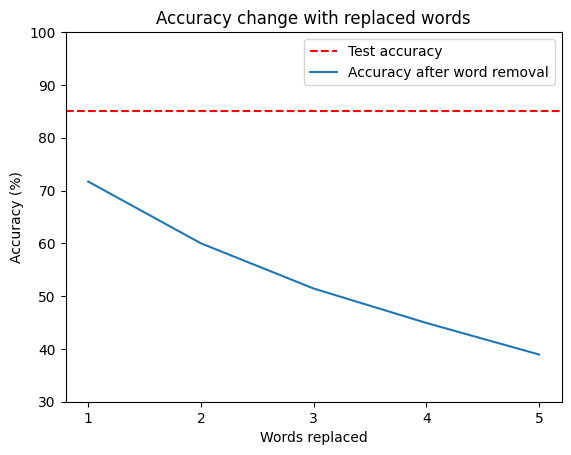

In [ ]:
import matplotlib.pyplot as plt

plt.axhline(y=85.012, xmin=0, xmax=5 ,color='r', linestyle='--')
plt.ylim(30, 100)
plt.xticks([1, 2, 3, 4, 5])
plt.plot(y,acc_vals)
plt.title("Accuracy change with replaced words")
plt.xlabel("Words replaced")
plt.ylabel("Accuracy (%)")
plt.legend(['Test accuracy','Accuracy after word removal'])

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
all_smaples = []
all_sams =[]
for iter in range(5):
  sam = sample_sentences[iter]
  sam_s = []
  for i in sam:
    sam_s.append(i2w[i])
  all_sams.append(sam_s)
  all_smaples.append( " ".join(sam_s))


for idx, exs in enumerate(all_word_exs):
  for iter in range(2):
    print("Orignal String")
    print(all_smaples[iter])
    t = exs[iter]
    mismatch = [i for i, (a, b) in enumerate(zip(t, sample_sentences[iter])) if a != b]
    # print(sample_sentences[iter].shape)
    pred  = model.predict(np.array(sample_sentences[iter]).reshape(1,200))
    print(f'Probability of Orignal string: {pred}')

    new = []
    for i in t:
      new.append(i2w[i])
    sentence = " ".join(new)
    for i in mismatch:
      real = all_sams[iter][i]
      replaced_with = new[i]
      print(f"\nOrignal word: {real}, replaced word: {replaced_with}")

    print(f"\nString after Replacing {idx + 1} words")
    print(sentence)
    pred  = model.predict(exs[iter].reshape(1,200))
    print(f'Probability after Replaced word: {pred}')

  print("\n\n\n")

Orignal String
of two men <UNK> murders in exchange for getting rid of the two people messing up their lives throw <UNK> from the train is an original and very inventive comedy take on the idea it's a credit to danny devito that he both wrote and starred in this minor comedy gem br br anne <UNK> is the mother who inspires the film's title and it's understandable why she gets under the skin of danny devito with her sharp tongue and relentlessly putting him down for any minor <UNK> billy crystal is the writer who's wife has stolen his book idea and is now being <UNK> as a great new author even appearing on the oprah show to in <UNK> he should be enjoying thus devito gets the idea of <UNK> murders to rid themselves of these <UNK> factors br br of course everything and anything can happen when writer carl <UNK> lets his imagination <UNK> with <UNK> ideas for how the plot develops and it's amusing all the way through providing plenty of laughs and chuckles along the way as well as a good de